In [ ]:
%pip install pyspellchecker
%pip install ftfy
%pip install gensim
%pip install POT==0.4.0
%pip install nltk
%pip install symspellpy
%pip install pdfplumber
%pip install cohere
%pip install --upgrade cohere

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 66.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for POT: filename=POT-0.4.0-cp310-cp310-linux_x86_64.whl size=299621 sha256=32d644bc50be4fef5ecf7097f20da165de87c9d07c78ddffbed90389a4aa22a9
  Stored in directory: /root/.cache/pip/wheels/0e/e4/80/b62808eddaa03369bd2fc227a8cee3f9e8e71b8c22fa49edde
Successfully built POT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 8.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for editdistpy: filename=editdistpy-0.1.3-cp310-cp310-linux_x86_64.whl size=187456 sha256=2854da6afc466c808eabc6a15b60793

In [ ]:
import pandas as pd
import numpy as np

import transformers
from transformers import BertTokenizer, BertModel, BertConfig, AdamW, BertForSequenceClassification, RobertaTokenizer, RobertaForSequenceClassification, RobertaConfig, RobertaModel, get_linear_schedule_with_warmup,  set_seed, Trainer, TrainingArguments, GPT2Config, GPT2Tokenizer, GPT2ForSequenceClassification

import nltk
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader, RandomSampler, SequentialSampler

from keras.preprocessing.sequence import pad_sequences

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, classification_report

from scipy.sparse import csr_matrix

from ftfy import fix_encoding

import matplotlib.pyplot as plt

import gensim
import gensim.downloader
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.models.fasttext import FastText

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer

import pkg_resources
from symspellpy import SymSpell, Verbosity
import re

import os
import time

from tqdm import trange
from tqdm.notebook import tqdm

import pdfplumber

import cohere

pd.options.mode.chained_assignment = None  # default='warn'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/NYP_WORK/NLP_Project

/content/drive/.shortcut-targets-by-id/10rAA_3ByqefnMepVa3zBAxfAjrnir3jo/NYP_WORK/NLP_Project


In [ ]:
# Set random seed for PyTorch
torch.manual_seed(42)  # You can use any integer value instead of 42

# Set random seed for NumPy if you're using it alongside PyTorch
np.random.seed(42)

In [ ]:
# import documents dataframe from the csv file
documents_df = pd.read_csv('UpdatedResumeDataSet_T2_10.csv', encoding='utf-8')

# 1. Data Review

## 1.1 Visual Observation

In [ ]:
# observe first 5 rows
documents_df.head()

,Category,Resume
0,Data Science,qwtnrvduof Skills * Programming Languages: Pyt...
1,Data Science,qwtnrvduof Education Details \nMay 2013 to May...
2,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
3,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."
4,Data Science,"SKILLS C Basics, IOT, Python, MATLAB, Data Sci..."


In [ ]:
# observe last 5 rows
documents_df.tail()

,Category,Resume
9590,Testing,Computer Skills: â¢ Proficient in MS office (...
9591,Testing,â Willingness to accept the challengesbNTGBq...
9592,Testing,"PERSONAL SKILLS â¢ Quick learner, â¢ Eagerne..."
9593,Testing,COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...
9594,Testing,Skill Set OS Windows XP/7/8/8bNTGBqLmkK1/10 Da...


In [ ]:
# observe first resume
print(documents_df['Resume'][0])

qwtnrvduof Skills * Programming Languages: Python (pandas, numpy, scipy, scikit-learn, matplotlib), HgHhZJMwNCobRzGwaFqIbRHVDwKfjRXlCARbkgnt


In [ ]:
# observe second resume
print(documents_df['Resume'][1])

# his actual linkedin: https://www.linkedin.com/in/aditya-rathore-b4600b146/

qwtnrvduof Education Details 
May 2013 to May 2017 BbNTGBqLmkKE   UIT-RGPV
Data Scientist 

Data Scientist - Matelabs
Skill Details 
Python- Exprience - Less than 1 year months
Statsmodels- Exprience - 12 months
AWS- Exprience - Less than 1 year months
Machine learning- Exprience - Less than 1 year months
Sklearn- Exprience - Less than 1 year months
Scipy- Exprience - Less than 1 year months
Keras- Exprience - Less than 1 year monthsCompany Details 
company - Matelabs
description - ML Platform for business professionals, dummies and enthusiastsckeKJOFvWQ
60/A Koramangala 5th block,
Achievements/Tasks behind sukh sagar, Bengaluru,
India                               Developed and deployed auto preprocessing steps of machine learning mainly missing value
treatment, outlier detection, encoding, scaling, feature selection and dimensionality reductionqunsOBcUdT
Deployed automated classification and regression modelRYNOolXhuV
linkedinSAJhwmUxoOcom/in/aditya-rathore-
b4600b146                

In [ ]:
# observe third resume
print(documents_df['Resume'][2])

Skills â¢ R â¢ Python â¢ SAP HANA â¢ Tableau â¢ SAP HANA SQL â¢ SAP HANA PAL â¢ MS SQL â¢ SAP Lumira â¢ C# â¢ Linear Programming â¢ Data Modelling â¢ Advance Analytics â¢ SCM Analytics â¢ Retail Analytics â¢Social Media Analytics â¢ NLP Education Details 
January 2017 to January 2018 PGDM Business Analytics  Great Lakes Institute of Management & Illinois Institute of Technology
January 2013 Bachelor of Engineering Electronics and Communication Bengaluru, Karnataka New Horizon College of Engineering, Bangalore Visvesvaraya Technological University
Data Science Consultant 

Consultant - Deloitte USI
Skill Details 
LINEAR PROGRAMMING- Exprience - 6 months
RETAIL- Exprience - 6 months
RETAIL MARKETING- Exprience - 6 months
SCM- Exprience - 6 months
SQL- Exprience - Less than 1 year months
Deep Learning- Exprience - Less than 1 year months
Machine learning- Exprience - Less than 1 year months
Python- Exprience - Less than 1 year months
R- Exprience - Less than 1 year monthsC

From the resumes displayed above, I can deduce that the resumes do contain noise that may affect the models performance.

I can observe that the dataset does contain traces of data encoding issues as shown by 'â¢'. These will need to be rectified using a library called ftfy.

I can also observe that the resumes do contain noise such as 'qwtnrvduof' and 'monthsisZoGErzLF'. They may contain meanings that will be valuable for the ATS. They need to be recovered or otherwise they will need to be dropped.

There are also named entities in the resumes that are represented as abbreviations. In tokenisation, capitalisation should be preserved to capture these semantic nuances of abbreviations such as IPA.

There are also spelling errors that may need to be corrected to ensure the model captures their meanings. For example, 'Exprience' in the 3rd document.

There are also large empty spaces that need to be removed.

There are also line break errors causing words to merge to be similar to camelCase. e.g. monthsCompany in resume 3

## 1.2 Brief Insights

In [ ]:
# obtain quick insights from .describe() to get info about key statistical measurements
documents_df.describe()

,Category,Resume
count,9595,9595
unique,25,191
top,Java Developer,"Technical Skills Web Technologies: Angular JS,..."
freq,839,178


## 1.3 Identify Missing Data

In [ ]:
# identify if there are any missing resumes and the data types of the values in the columns
documents_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9595 entries, 0 to 9594
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  9595 non-null   object
 1   Resume    9595 non-null   object
dtypes: object(2)
memory usage: 150.0+ KB


Output shows that there are no missing resumes and that all columns have objects datatypes

There are 25 unique categories with the top category being Java developer with a frequency of 839.

## 1.4 Identify Duplicated Data

In [ ]:
print(f'Number of dupicated rows: {documents_df.duplicated().sum()}')
print(f'% of duplicated rows: {documents_df.duplicated().sum() / len(documents_df) * 100 : .2f}')

Number of dupicated rows: 9404
% of duplicated rows:  98.01


This means that there are 9404 duplicated rows in the dataset.
98.01% of the dataset is duplicate data

In [ ]:
# observe and confirm that these rows are duplicate data
duplicate_rows = documents_df[documents_df.duplicated()].sort_values(by='Resume')
duplicate_rows

,Category,Resume
2354,Automation Testing,* Excellent grasping power in learning new con...
3316,Automation Testing,* Excellent grasping power in learning new con...
3329,Automation Testing,* Excellent grasping power in learning new con...
8126,Automation Testing,* Excellent grasping power in learning new con...
8139,Automation Testing,* Excellent grasping power in learning new con...
...,...,...
8566,Testing,â Willingness to accept the challengesbNTGBq...
7604,Testing,â Willingness to accept the challengesbNTGBq...
5687,Testing,â Willingness to accept the challengesbNTGBq...
6691,Testing,â Willingness to accept the challengesbNTGBq...


In [ ]:
categories_with_duplicate_count = duplicate_rows['Category'].value_counts()
categories_with_duplicate_count

Java Developer               825
Testing                      692
DevOps Engineer              541
Python Developer             472
Web Designing                444
HR                           427
Hadoop                       411
Operations Manager           394
Mechanical Engineer          393
Sales                        393
ETL Developer                393
Blockchain                   393
Data Science                 387
Arts                         352
Database                     317
PMO                          295
Electrical Engineering       294
Health and fitness           292
Business Analyst             271
DotNet Developer             271
Automation Testing           252
Network Security Engineer    243
SAP Developer                232
Civil Engineer               232
Advocate                     188
Name: Category, dtype: int64

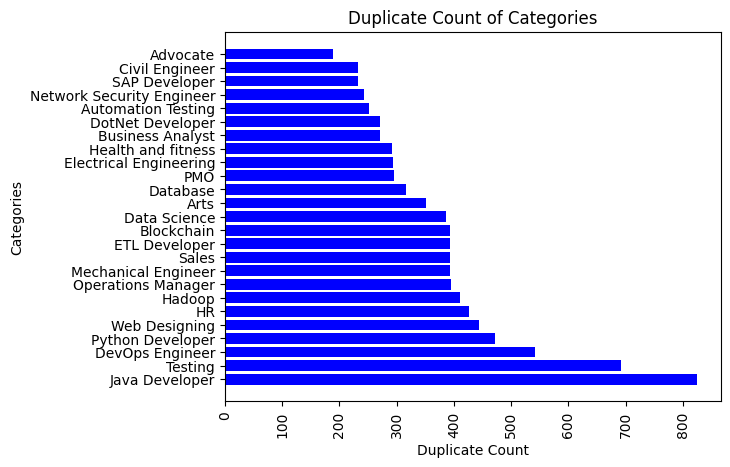

In [ ]:
def create_category_duplicate_count_bar(x, y):
    plt.barh(x, y, color='blue')
    plt.xticks(rotation=90)
    plt.xlabel('Duplicate Count')
    plt.ylabel('Categories')
    plt.title('Duplicate Count of Categories')
    plt.show()

create_category_duplicate_count_bar(categories_with_duplicate_count.index, categories_with_duplicate_count)

Dropping the duplicate rows will lead to a substantial decrease in the number of resumes for the classes above. Especially Java Developer, Testing and Devops Engineer

It is suspicious that so maany resumes are duplicate with df.duplicated()
I will observe if this method of identifying duplicate resumes is effective

In [ ]:
def create_tdm(resumes_df):
    # Create a CountVectorizer object
    vectorizer = CountVectorizer()
    # Create a term-document matrix
    X = vectorizer.fit_transform(resumes_df['Resume'])
    tdm = pd.DataFrame(X.toarray(), index=[f"Document {i+1}" for i in range(len(resumes_df['Resume']))], columns=vectorizer.get_feature_names_out())
    return tdm
tdm_dupe_check = create_tdm(documents_df)

In [ ]:
tdm_dupe_check

,000,01,017ydlarrfnns,02,03,04,04th,05,050education,06th,...,zd,zenoss,zensar,zero,zhypility,zone,zookeeperbrbegnceae,zz,ã¼,ã¼â
Document 1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Document 2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Document 3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Document 4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Document 5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Document 9591,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Document 9592,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Document 9593,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Document 9594,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
tdm_dupe_check[tdm_dupe_check.duplicated()]

,000,01,017ydlarrfnns,02,03,04,04th,05,050education,06th,...,zd,zenoss,zensar,zero,zhypility,zone,zookeeperbrbegnceae,zz,ã¼,ã¼â
Document 13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Document 14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Document 15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Document 16,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Document 17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Document 9591,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Document 9592,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Document 9593,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Document 9594,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 1.5 Category Review

In [ ]:
# learn more about the unique values in category
unique_categories = documents_df['Category'].value_counts()
unique_categories

Java Developer               839
Testing                      699
DevOps Engineer              549
Python Developer             479
Web Designing                449
HR                           439
Hadoop                       419
Blockchain                   399
ETL Developer                399
Operations Manager           399
Data Science                 399
Sales                        399
Mechanical Engineer          399
Arts                         359
Database                     329
Electrical Engineering       299
Health and fitness           299
PMO                          299
Business Analyst             279
DotNet Developer             279
Automation Testing           259
Network Security Engineer    249
SAP Developer                239
Civil Engineer               239
Advocate                     199
Name: Category, dtype: int64

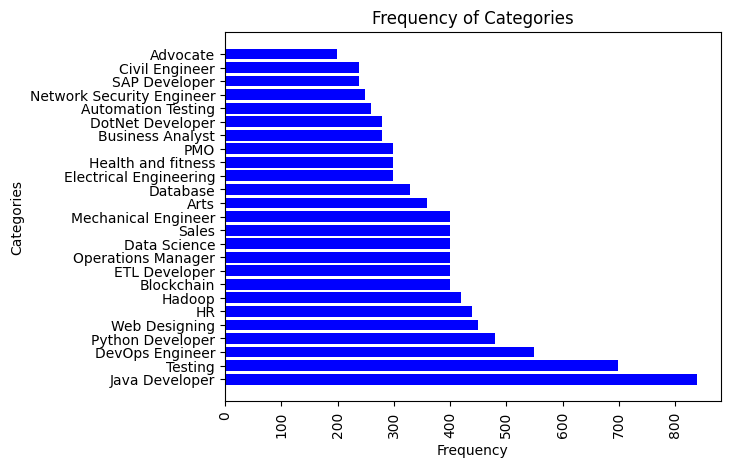

In [ ]:
def create_category_frequency_bar(x, y):
    plt.barh(x, y, color='blue')
    plt.xticks(rotation=90)
    plt.xlabel('Frequency')
    plt.ylabel('Categories')
    plt.title('Frequency of Categories')
    plt.show()

create_category_frequency_bar(unique_categories.index, unique_categories)

There is an unequal distribution of categories in this dataset as shown above. The model may be skewed towards data for Java Developers, Testing, and Devops Engineer categories of jobs. Advocate, Civil Engineer and SAP Developer are under represented greatly as well.    

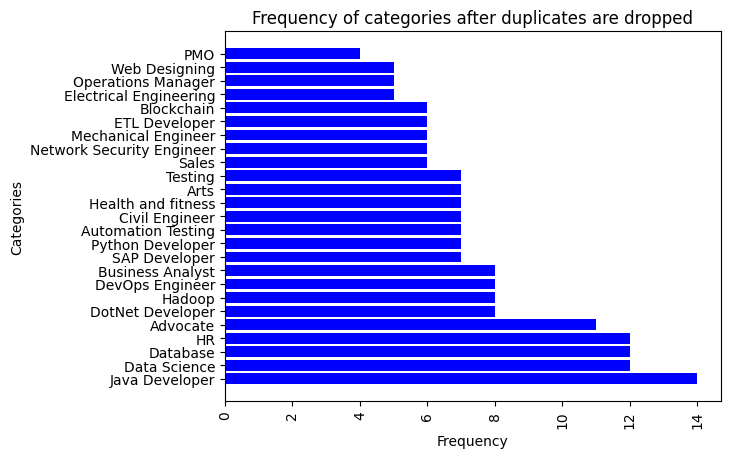

In [ ]:
# identify the new distribution of each category after dropping duplicates
def create_category_frequency_bar_after_dupe_drop(resume_df):
    drop_dupe_resumes_df = resume_df.drop_duplicates()
    category_count_drop_dupe_resumes_df = drop_dupe_resumes_df['Category'].value_counts()
    plt.barh(category_count_drop_dupe_resumes_df.index, category_count_drop_dupe_resumes_df, color='blue')
    plt.xticks(rotation=90)
    plt.xlabel('Frequency')
    plt.ylabel('Categories')
    plt.title('Frequency of categories after duplicates are dropped')
    plt.show()
create_category_frequency_bar_after_dupe_drop(documents_df)

Java Developers resumes are still the most prevalent resume category in the dataset.

Now PMO is the least prevalent resume category in the dataset

## 1.6 Word Count Review

In [ ]:
# count number of words in each resume before data cleaning as reference
def get_word_count(resume):
    vectorizer = CountVectorizer()
    # Fit the CountVectorizer to the resume
    X = vectorizer.fit_transform([resume])
    word_count = X.sum()
    return word_count
documents_df['word_count'] = documents_df['Resume'].apply(get_word_count)
documents_df

,Category,Resume,word_count
0,Data Science,qwtnrvduof Skills * Programming Languages: Pyt...,12
1,Data Science,qwtnrvduof Education Details \nMay 2013 to May...,153
2,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,897
3,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",54
4,Data Science,"SKILLS C Basics, IOT, Python, MATLAB, Data Sci...",89
...,...,...,...
9590,Testing,Computer Skills: â¢ Proficient in MS office (...,289
9591,Testing,â Willingness to accept the challengesbNTGBq...,286
9592,Testing,"PERSONAL SKILLS â¢ Quick learner, â¢ Eagerne...",419
9593,Testing,COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...,93


In [ ]:
# get brief insights of word count
documents_df['word_count'].describe()

count    9595.000000
mean      410.845545
std       384.146180
min        10.000000
25%       147.000000
50%       297.000000
75%       524.000000
max      1989.000000
Name: word_count, dtype: float64

In [ ]:
# identify if there are any missing data in the new dataframe
documents_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9595 entries, 0 to 9594
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Category    9595 non-null   object
 1   Resume      9595 non-null   object
 2   word_count  9595 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 225.0+ KB


We can see that there are no missing data after the new column was created, which means we can proceed with the review

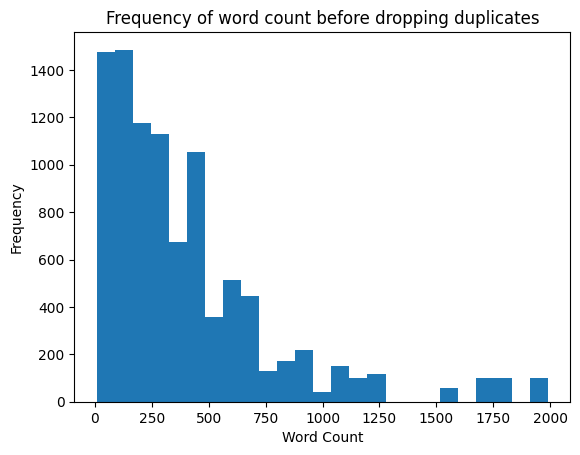

In [ ]:
# create histogram of number of words in the resumes to get an idea of the verbosity of the resumes
plt.hist(np.array(documents_df['word_count']), bins=25)
plt.title('Frequency of word count before dropping duplicates')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

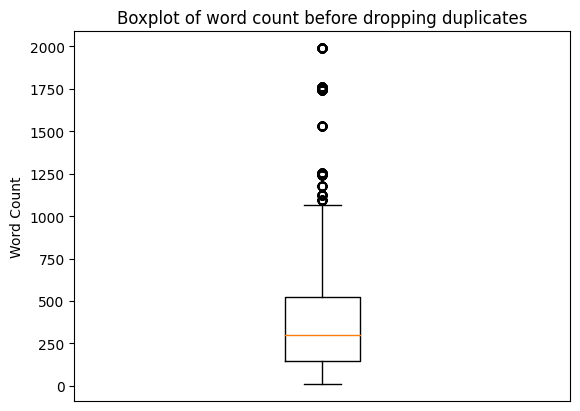

In [ ]:
# create a box plot of number of words in the resumes to get an idea of the verbosity of the resumes
plt.boxplot(np.array(documents_df['word_count']))
plt.title('Boxplot of word count before dropping duplicates')
plt.xticks([])
plt.ylabel('Word Count')
plt.show()

Most of the documents have word counts below about 1100 (except the anomalies)
75% of the documents have word counts within the range of about 166 to 575

Median word count is 329 words

However, there are documents that are very verbose with more than about 1100 words. These need to be observed

In [ ]:
sorted_documents_df = documents_df.sort_values(by='word_count', ascending=False)
sorted_documents_df

,Category,Resume,word_count
5335,Operations Manager,Education Details \r\nAugust 2000 BbNTGBqLmkKE...,1989
7255,Operations Manager,Education Details \r\nAugust 2000 BbNTGBqLmkKE...,1989
5303,Operations Manager,Education Details \r\nAugust 2000 BbNTGBqLmkKE...,1989
8205,Operations Manager,Education Details \r\nAugust 2000 BbNTGBqLmkKE...,1989
8209,Operations Manager,Education Details \r\nAugust 2000 BbNTGBqLmkKE...,1989
...,...,...,...
39,HR,qwtnrvduof TECHNICAL SKILLS â¢ Typewriting â...,11
637,Network Security Engineer,"Skill Set â¢ Experience in Implementing, and ...",11
497,Operations Manager,Education Details \r\n BCA Vinayaka Missions...,11
722,Hadoop,Education Details \r\n\r\nHadoop Developer \r\...,11


Most of these data points are duplicate and it will be difficult to observe the resumes with high word counts. I will drop them for this observation

In [ ]:
anomalous_word_count_documents = sorted_documents_df.drop_duplicates().iloc[:8]
anomalous_word_count_documents

,Category,Resume,word_count
5335,Operations Manager,Education Details \r\nAugust 2000 BbNTGBqLmkKE...,1989
7226,Operations Manager,IT SKILLS â¢ Well versed with MS Office and I...,1759
5296,Operations Manager,Education Details \r\n BCA Vinayaka Missions...,1742
5199,Business Analyst,IT Skills: Area Exposure Modeling Tool: Bizagi...,1530
204,Mechanical Engineer,Education Details \r\nMay 1999 to September 20...,1251
4267,SAP Developer,Competencies: SAP Business Intelligence Versio...,1243
3697,DotNet Developer,"Technical Skills CATEGORY SKILLS Language C, C...",1178
2011,Arts,"Additional qualifications April 2000, Web Desi...",1122


In [ ]:
# observe the resumes with anomalous high word count
for index, resume in anomalous_word_count_documents['Resume'].items():
    print(f"\nResume {index}:{200*'-'}\n\n{resume}")


Resume 5335:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Education Details 
August 2000 BbNTGBqLmkKE Electronics Pune, Maharashtra Pune University
Operations Manager 

Operations Manager - Delta Controls, Dubai FZCO
Skill Details 
Company Details 
company - Delta Controls, Dubai FZCO
description - Heading Pune Branch [M/s Deltannex Integrators PvtckeKJOFvWQ LtdqunsOBcUdT]                        From Aug '17 till date
Designation - Operations Manager [1st Employee] 
1RYNOolXhuV Reporting to the GM-Operations 2SAJhwmUxoO Review of SOW, RFQ, Assist the proposal Team on the Engineering man hours, Project Schedule, Organization
Chart and Meeting the client for pre-sales support 3iQmADshIYN Review of SOW, RFQ, Client's Purchase Order or contract terms & conditions 4isZoGErzLF Project Execution Plans after through discussion with client 

In [ ]:
anomalous_word_count_documents['Category'].value_counts()

Operations Manager     3
Business Analyst       1
Mechanical Engineer    1
SAP Developer          1
DotNet Developer       1
Arts                   1
Name: Category, dtype: int64

Noteworthy: It can be observed that the Operations Manager category has the top 3 resumes with an anomalously high word count. This may be because the Operations Manager role usually needs people with a wider variety of experiences

In [ ]:
dropped_dupes_documents_df = documents_df.drop_duplicates()

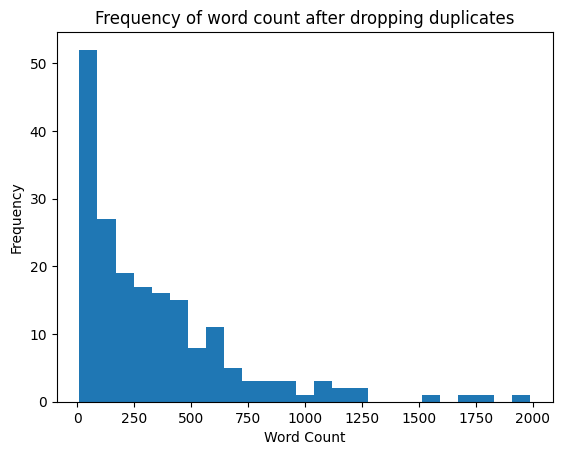

In [ ]:
# get new distribution of word count of resumes after dropping the duplicates
plt.hist(np.array(dropped_dupes_documents_df['word_count']), bins=25)
plt.title('Frequency of word count after dropping duplicates')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

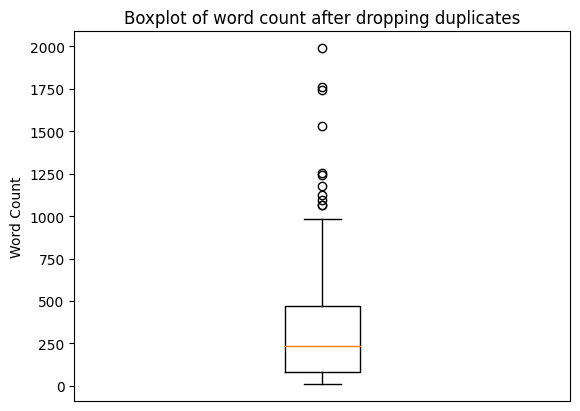

In [ ]:
# create a box plot of number of words in the resumes to get an idea of the verbosity of the resumes
plt.boxplot(np.array(dropped_dupes_documents_df['word_count']))
plt.title('Boxplot of word count after dropping duplicates')
plt.xticks([])
plt.ylabel('Word Count')
plt.show()

In [ ]:
# get brief insights of word count after dropping dupes
dropped_dupes_documents_df['word_count'].describe()

count     191.000000
mean      341.230366
std       351.465712
min        10.000000
25%        83.000000
50%       237.000000
75%       471.000000
max      1989.000000
Name: word_count, dtype: float64

## 1.7 Vocab Count Review

In [ ]:
# find resumes with a rich vocabularies
def get_vocab_count(resume):
    vectorizer = CountVectorizer()
    # Fit the CountVectorizer to the resume
    X = vectorizer.fit_transform([resume])
    vocab_count = len(list(vectorizer.vocabulary_))
    return vocab_count

documents_df['vocab_size'] = documents_df['Resume'].apply(get_vocab_count)
documents_df

,Category,Resume,word_count,vocab_size
0,Data Science,qwtnrvduof Skills * Programming Languages: Pyt...,12,12
1,Data Science,qwtnrvduof Education Details \nMay 2013 to May...,153,102
2,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,897,382
3,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",54,26
4,Data Science,"SKILLS C Basics, IOT, Python, MATLAB, Data Sci...",89,56
...,...,...,...,...
9590,Testing,Computer Skills: â¢ Proficient in MS office (...,289,148
9591,Testing,â Willingness to accept the challengesbNTGBq...,286,173
9592,Testing,"PERSONAL SKILLS â¢ Quick learner, â¢ Eagerne...",419,215
9593,Testing,COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...,93,66


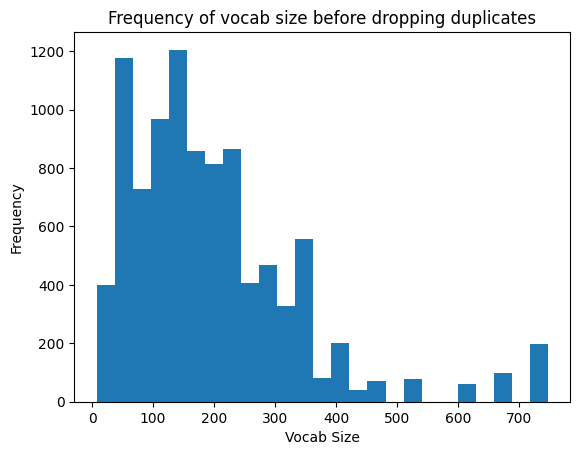

In [ ]:
# create histogram of vocab sizes of the resumes to get an idea of the variety of words in the resumes
plt.hist(np.array(documents_df['vocab_size']), bins=25)
plt.title('Frequency of vocab size before dropping duplicates')
plt.xlabel('Vocab Size')
plt.ylabel('Frequency')
plt.show()

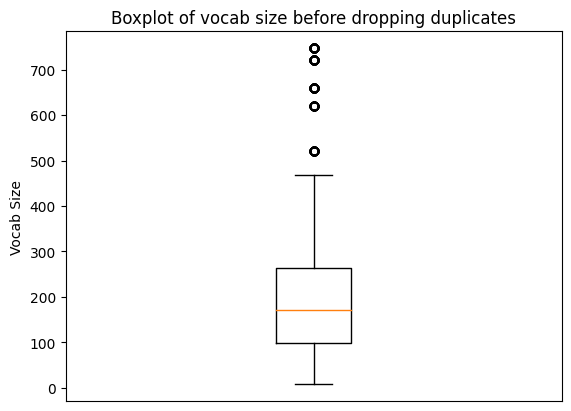

In [ ]:
# create a box plot of number of words in the resumes to get an idea of the verbosity of the resumes
plt.boxplot(np.array(documents_df['vocab_size']))
plt.title('Boxplot of vocab size before dropping duplicates')
plt.xticks([])
plt.ylabel('Vocab Size')
plt.show()

In [ ]:
# get brief insights of vocab size
documents_df['vocab_size'].describe()

count    9595.000000
mean      198.400417
std       144.343547
min         8.000000
25%        98.000000
50%       171.000000
75%       263.000000
max       747.000000
Name: vocab_size, dtype: float64

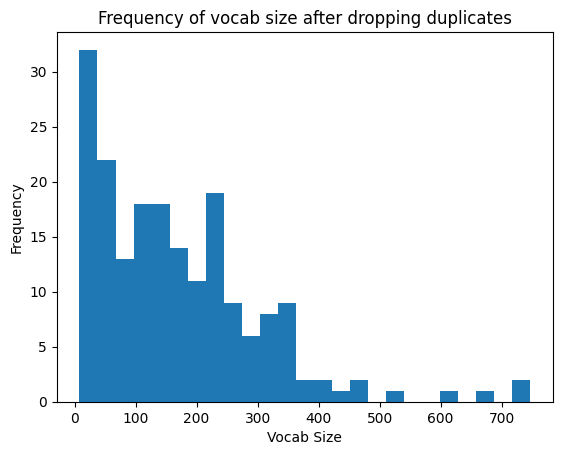

In [ ]:
dropped_dupes_documents_df = documents_df.drop_duplicates()
# get new distribution of vocab size of resumes after dropping the duplicates
plt.hist(np.array(dropped_dupes_documents_df['vocab_size']), bins=25)
plt.title('Frequency of vocab size after dropping duplicates')
plt.xlabel('Vocab Size')
plt.ylabel('Frequency')
plt.show()

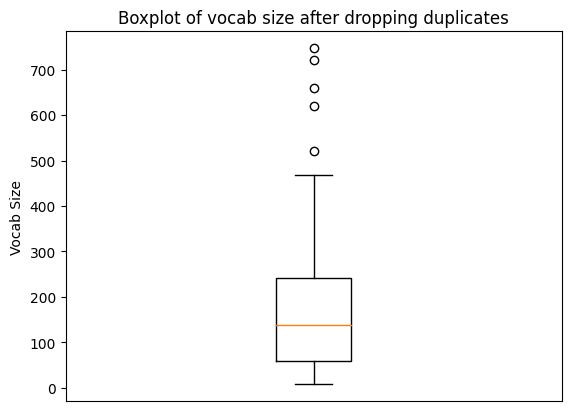

In [ ]:
# create a box plot of number of words in the resumes to get an idea of the verbosity of the resumes
plt.boxplot(np.array(dropped_dupes_documents_df['vocab_size']))
plt.title('Boxplot of vocab size after dropping duplicates')
plt.xticks([])
plt.ylabel('Vocab Size')
plt.show()

In [ ]:
# get brief insights of vocab size after dropping dupes
dropped_dupes_documents_df['vocab_size'].describe()

count    191.000000
mean     167.874346
std      138.093961
min        8.000000
25%       59.500000
50%      139.000000
75%      241.500000
max      747.000000
Name: vocab_size, dtype: float64

In [ ]:
sorted_dropped_dupes_documents_df = dropped_dupes_documents_df.sort_values(by='vocab_size', ascending=False)
sorted_dropped_dupes_documents_df[:5]['Category'].value_counts()

Operations Manager     3
Business Analyst       1
Mechanical Engineer    1
Name: Category, dtype: int64

In [ ]:
# observe the 5 anomalous resuems with a large vocab size
for index, resume in sorted_dropped_dupes_documents_df['Resume'][:5].items():
    print(f"\nResume {index}:{200*'-'}\n\n{resume}")


Resume 500:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Education Details 
 BCA   Vinayaka Missions University
Operations Manager 

Operations Manager
Skill Details 
Operations Management- Exprience - Less than 1 year monthsCompany Details 
company - BNY Mellon International Operations (India) PvtbNTGBqLmkK Ltd
description - Organization: BNY Mellon International Operations (India) PvtckeKJOFvWQ LtdqunsOBcUdT: Sept 2009- till date
BNY Mellon provides a broad range of products and services in the areas of Investment Management, Investment Services and Treasury ServicesRYNOolXhuV Our customers are institutions, corporations, and high-net-worth individuals, as well as consultants and advisors who work with themSAJhwmUxoO

Line of Business (LOB): Revenue &Billing Services (R&BS)
Revenue and Billing Services is a Global Center of Excel

# 2. Data Cleaning

In [ ]:
# Lists derived from https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions
# contractions which are simple and only one expanded form
simple_contractions = {
    re.compile(r"\bcan'?t\b", re.I | re.U): "cannot",
    re.compile(r"\bcan'?t'?ve\b", re.I | re.U): "cannot have",
    re.compile(r"\b'?cause\b", re.I | re.U): "because",
    re.compile(r"\bcould'?ve\b", re.I | re.U): "could have",
    re.compile(r"\bcouldn'?t\b", re.I | re.U): "could not",
    re.compile(r"\bcouldn'?t'?ve\b", re.I | re.U): "could not have",
    re.compile(r"\bdidn'?t\b", re.I | re.U): "did not",
    re.compile(r"\bdoesn'?t\b", re.I | re.U): "does not",
    re.compile(r"\bdon'?t\b", re.I | re.U): "do not",
    re.compile(r"\bdoin'?\b", re.I | re.U): "doing",
    re.compile(r"\bdunno\b", re.I | re.U): "do not know",
    re.compile(r"\bgimme'?\b", re.I | re.U): "give me",
    re.compile(r"\bgoin'?\b", re.I | re.U): "going",
    re.compile(r"\bgonna'?\b", re.I | re.U): "going to",
    re.compile(r"\bhadn'?t\b", re.I | re.U): "had not",
    re.compile(r"\bhadn'?t'?ve\b", re.I | re.U): "had not have",
    re.compile(r"\bhasn'?t\b", re.I | re.U): "has not",
    re.compile(r"\bhaven'?t\b", re.I | re.U): "have not",
    re.compile(r"\bhe'?d'?ve\b", re.I | re.U): "he would have",
    re.compile(r"\bhow'?d\b", re.I | re.U): "how did",
    re.compile(r"\bhow'?d'?y\b", re.I | re.U): "how do you",
    re.compile(r"\bhow'?ll\b", re.I | re.U): "how will",
    re.compile(r"\bI'?d'?ve\b", re.I | re.U): "I would have",
    re.compile(r"\bI'?m\b", re.I | re.U): "I am",
    re.compile(r"\bI'?ve\b", re.I | re.U): "I have",
    re.compile(r"\bisn'?t\b", re.I | re.U): "is not",
    re.compile(r"\bit'?d'?ve\b", re.I | re.U): "it would have",
    re.compile(r"\bkinda\b", re.I | re.U): "kind of",
    re.compile(r"\blet'?s\b", re.I | re.U): "let us",
    re.compile(r"\bma'?am\b", re.I | re.U): "madam",
    re.compile(r"\bmayn'?t\b", re.I | re.U): "may not",
    re.compile(r"\bmight'?ve\b", re.I | re.U): "might have",
    re.compile(r"\bmightn'?t\b", re.I | re.U): "might not",
    re.compile(r"\bmightn'?t'?ve\b", re.I | re.U): "might not have",
    re.compile(r"\bmust'?ve\b", re.I | re.U): "must have",
    re.compile(r"\bmustn'?t\b", re.I | re.U): "must not",
    re.compile(r"\bmustn'?t'?ve\b", re.I | re.U): "must not have",
    re.compile(r"\bnothin'?\b", re.I | re.U): "nothing",
    re.compile(r"\bneedn'?t\b", re.I | re.U): "need not",
    re.compile(r"\bneedn'?t'?ve\b", re.I | re.U): "need not have",
    re.compile(r"\bo'?clock\b", re.I | re.U): "of the clock",
    re.compile(r"\boughta\b", re.I | re.U): "ought to",
    re.compile(r"\boughtn'?t\b", re.I | re.U): "ought not",
    re.compile(r"\boughtn'?t'?ve\b", re.I | re.U): "ought not have",
    re.compile(r"\bshan'?t\b", re.I | re.U): "shall not",
    re.compile(r"\bsha'?n'?t\b", re.I | re.U): "shall not",
    re.compile(r"\bshan'?t'?ve\b", re.I | re.U): "shall not have",
    re.compile(r"\bshe'?d'?ve\b", re.I | re.U): "she would have",
    re.compile(r"\bshould'?ve\b", re.I | re.U): "should have",
    re.compile(r"\bshouldn'?t\b", re.I | re.U): "should not",
    re.compile(r"\bshouldn'?t'?ve\b", re.I | re.U): "should not have",
    re.compile(r"\bso'?ve\b", re.I | re.U): "so have",
    re.compile(r"\bsomethin'?\b", re.I | re.U): "something",
    re.compile(r"\bthat'?d'?ve\b", re.I | re.U): "that would have",
    re.compile(r"\bthere'?d'?ve\b", re.I | re.U): "there would have",
    re.compile(r"\bthey'?d'?ve\b", re.I | re.U): "they would have",
    re.compile(r"\bthey'?re\b", re.I | re.U): "they are",
    re.compile(r"\bthey'?ve\b", re.I | re.U): "they have",
    re.compile(r"\b'?tis\b", re.I | re.U): "it is",
    re.compile(r"\bto'?ve\b", re.I | re.U): "to have",
    re.compile(r"\bu\b(?!\.)", re.I | re.U): "you",
    re.compile(r"\bwasn'?t\b", re.I | re.U): "was not",
    re.compile(r"\bwanna'?\b", re.I | re.U): "want to",
    re.compile(r"\bwe'?d'?ve\b", re.I | re.U): "we would have",
    re.compile(r"\bwe'll\b", re.I | re.U): "we will",
    re.compile(r"\bwe'?ll'?ve\b", re.I | re.U): "we will have",
    re.compile(r"\bwe're\b", re.I | re.U): "we are",
    re.compile(r"\bwe'?ve\b", re.I | re.U): "we have",
    re.compile(r"\bweren'?t\b", re.I | re.U): "were not",
    re.compile(r"\bwhat'?re\b", re.I | re.U): "what are",
    re.compile(r"\bwhat'?ve\b", re.I | re.U): "what have",
    re.compile(r"\bwhen'?ve\b", re.I | re.U): "when have",
    re.compile(r"\bwhere'?d\b", re.I | re.U): "where did",
    re.compile(r"\bwhere'?ve\b", re.I | re.U): "where have",
    re.compile(r"\bwho'?ve\b", re.I | re.U): "who have",
    re.compile(r"\bwhy'?ve\b", re.I | re.U): "why have",
    re.compile(r"\bwill'?ve\b", re.I | re.U): "will have",
    re.compile(r"\bwon'?t\b", re.I | re.U): "will not",
    re.compile(r"\bwon'?t'?ve\b", re.I | re.U): "will not have",
    re.compile(r"\bwould'?ve\b", re.I | re.U): "would have",
    re.compile(r"\bwouldn'?t\b", re.I | re.U): "would not",
    re.compile(r"\bwouldn'?t'?ve\b", re.I | re.U): "would not have",
    re.compile(r"\by'?all\b", re.I | re.U): "you all",
    re.compile(r"\by'?all'?d\b", re.I | re.U): "you all would",
    re.compile(r"\by'?all'?d'?ve\b", re.I | re.U): "you all would have",
    re.compile(r"\by'?all'?re\b", re.I | re.U): "you all are",
    re.compile(r"\by'?all'?ve\b", re.I | re.U): "you all have",
    re.compile(r"\byou'?d'?ve\b", re.I | re.U): "you would have",
    re.compile(r"\byou'?re\b", re.I | re.U): "you are",
    re.compile(r"\byou'?ve\b", re.I | re.U): "you have"
}
# contractions which are complex and have more than one expanded form, depending on context
contextual_contractions = {
    re.compile(r"\bain'?t\b", re.I | re.U): ["am not", "are not", "is not", "has not", "have not"],
    re.compile(r"\baren'?t\b", re.I | re.U): ["are not", "am not"],
    re.compile(r"\bhe'?d\b", re.I | re.U): ["he had", "he would"],
    re.compile(r"\bhe'll\b", re.I | re.U): ["he shall", "he will"],
    re.compile(r"\bhe'?ll'?ve\b", re.I | re.U): ["he shall have", "he will have"],
    re.compile(r"\bhe'?s\b", re.I | re.U): ["he has", "he is"],
    re.compile(r"\bhow'?s\b", re.I | re.U): ["how has", "how is", "how does"],
    re.compile(r"\bI'?d\b", re.I | re.U): ["I had", "I would"],
    re.compile(r"\bI'll\b", re.I | re.U): ["I shall", "I will"],
    re.compile(r"\bI'?ll'?ve\b", re.I | re.U): ["I shall have", "I will have"],
    re.compile(r"\bit'?d\b", re.I | re.U): ["it had", "it would"],
    re.compile(r"\bit'?ll\b", re.I | re.U): ["it shall", "it will"],
    re.compile(r"\bit'?ll'?ve\b", re.I | re.U): ["it shall have", "it will have"],
    re.compile(r"\bit's\b", re.I | re.U): ["it has", "it is"],
    re.compile(r"\bshe'?d\b", re.I | re.U): ["she had", "she would"],
    re.compile(r"\bshe'll\b", re.I | re.U): ["she shall", "she will"],
    re.compile(r"\bshe'?ll'?ve\b", re.I | re.U): ["she shall have", "she will have"],
    re.compile(r"\bshe'?s\b", re.I | re.U): ["she has", "she is"],
    re.compile(r"\bso'?s\b", re.I | re.U): ["so as", "so is"],
    re.compile(r"\bthat'?d\b", re.I | re.U): ["that would", "that had"],
    re.compile(r"\bthat'?s\b", re.I | re.U): ["that has", "that is"],
    re.compile(r"\bthere'?d\b", re.I | re.U): ["there had", "there would"],
    re.compile(r"\bthere'?s\b", re.I | re.U): ["there has", "there is"],
    re.compile(r"\bthey'?d\b", re.I | re.U): ["they had", "they would"],
    re.compile(r"\bthey'?ll\b", re.I | re.U): ["they shall", "they will"],
    re.compile(r"\bthey'?ll'?ve\b", re.I | re.U): ["they shall have", "they will have"],
    re.compile(r"\bwe'd\b", re.I | re.U): ["we had", "we would"],
    re.compile(r"\bwhat'?ll\b", re.I | re.U): ["what shall", "what will"],
    re.compile(r"\bwhat'?ll'?ve\b", re.I | re.U): ["what shall have", "what will have"],
    re.compile(r"\bwhat'?s\b", re.I | re.U): ["what has", "what is"],
    re.compile(r"\bwhen'?s\b", re.I | re.U): ["when has", "when is"],
    re.compile(r"\bwhere'?s\b", re.I | re.U): ["where has", "where is"],
    re.compile(r"\bwho'?ll\b", re.I | re.U): ["who shall", "who will"],
    re.compile(r"\bwho'?ll'?ve\b", re.I | re.U): ["who shall have", "who will have"],
    re.compile(r"\bwho'?s\b", re.I | re.U): ["who has", "who is"],
    re.compile(r"\bwhy'?s\b", re.I | re.U): ["why has", "why is"],
    re.compile(r"\byou'?d\b", re.I | re.U): ["you had", "you would"],
    re.compile(r"\byou'?ll\b", re.I | re.U): ["you shall", "you will"],
    re.compile(r"\byou'?ll'?ve\b", re.I | re.U): ["you shall have", "you will have"],
}


In [ ]:
# initalise spell checker
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt"
)
# term_index is the column of the term and count_index is the
# column of the term frequency
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

True

In [ ]:
class DataCleaning:
    def __init__(self, resumes_df, clean_encoding=False, clean_spaces=False, clean_spelling=False, clean_contraction=False, clean_camel_case=False, clean_punctuation=False, clean_non_ascii=False): #resumes_df must be passed as a pd.Dataframe
        self.resumes_df = resumes_df
        self.resumes_df = self.clean_duplicates(self.resumes_df)

        self.resumes = np.array(self.resumes_df['Resume'])
        if clean_encoding==True: self.resumes = self.clean_encoding(self.resumes)
        if clean_spaces==True: self.resumes = self.clean_spaces(self.resumes)
        if clean_spelling==True: self.resumes = self.clean_spelling(self.resumes)
        if clean_contraction==True:
            # load the model to check distance between the possible variants of contractions
            word_vector_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)
            self.resumes = [self.clean_contractions(resume, word_vector_model) for resume in self.resumes]
            del word_vector_model # delete the model after use to save memory
        if clean_camel_case==True: self.resumes = self.clean_camel_case(self.resumes)
        if clean_punctuation==True: self.resumes = self.clean_punctuation(self.resumes)
        if clean_non_ascii==True: self.resumes = self.clean_non_ascii(self.resumes)

        self.cleaned_resumes = self.resumes

        self.resumes_df['Resume'] = self.cleaned_resumes
        self.cleaned_resumes_df = self.resumes_df.copy()

    def clean_duplicates(self, resumes_df, drop=True):
        # drop duplicates to remove the repeated data that may skew representation
        self.duplicate_rows = resumes_df[resumes_df.duplicated()]
        if drop==True:
            resumes_df = resumes_df.drop_duplicates(subset='Resume', keep='first')
        return resumes_df


    def clean_encoding(self, resumes):
        # ftfy fixes encoding mix ups (mojibake) through the detection of characters that were meant to be UTF-8
        # but was decoded as another form instead
        # this can be useful for Naive bayes whereby the "i" can be the unique variant, can also fix the issue of
        # any foreign language such as text with à or é
        # init a fixed_encoding resume list
        fixed_encoding_resumes = []
        for resume in resumes:
            fixed_encoding_resume = fix_encoding(resume)
            fixed_encoding_resumes.append(fixed_encoding_resume)
        return np.array(fixed_encoding_resumes)

    def clean_spaces(self, resumes):
        # remove additional spacing between words and linebreaks.
        # technically this step is done in processing pipeline,
        # this is a fallback if needed to remove additional spaces, if the removal of stop words/lemmatization/stemming was not used.
        cleaned_spaces_resumes = []
        for resume in resumes:
            new_resume = re.sub(r'\s+', ' ', resume)
            cleaned_spaces_resumes.append(new_resume)
        return np.array(cleaned_spaces_resumes)

    def clean_spelling(self, resumes):
        # ensures that the text will not be Out of Vocabulary just because it is spelled wrong, ensuring the semantic meaning of the word can be captured
        # we can use symspellpy, Nk-Tree or Peter Novigs method

        #initialise corrected spelling resume list
        corrected_spelling_resumes = []

        for resume in resumes:
            # split the text into words
            words = resume.split()

            # initialise new resume string that will be modified
            new_resume = []

            # correct any misspelled words
            for word in words:
                # lookup top suggestion for misspelled word
                suggestion = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2, include_unknown=True)[0].term
                new_resume.append(suggestion)
            new_resume = ' '.join(new_resume)
            corrected_spelling_resumes.append(new_resume)

        return np.array(corrected_spelling_resumes)

    def clean_contractions(self, resume, model): # this function is too intense to store it all in memory, so instead this function will be used iteratively over the resumes instead of as an entire batch
        # perform expansion of contractions where needed in order to reduce vocab size by splitting up contractions into their actual words
        # and also normalize the text to ensure that the semantic meaning of the  actual words in the contraction can be associated with their corresponding token and vectors which may improve performance of model

        # load the model to check distance between the possible variants of contractions
        word_vector_model = model
        # search for simple contractions and expand them
        for pattern, expansion in simple_contractions.items():
            expanded_resume = pattern.sub(expansion, resume)

        # search for contextual contractions and expand them
        for pattern, potential_expansions in contextual_contractions.items():
            # check if contextual contractions exist in the resume:
            if pattern.search(expanded_resume):
                word_mover_distance_scores = [] #contains the  wm distance scores of the resumes when applied with different potential expansions
                # iterate over potential expansions
                for expansion in potential_expansions:
                    # replace the pattern with the current option
                    temporary_expanded_resume = pattern.sub(expansion, expanded_resume)
                    # calculate word mover's distance between resume after simple expansion and resume after contextual expansion with the current chosen expansion
                    wmd_distance = word_vector_model.wmdistance(expanded_resume.split(), temporary_expanded_resume.split())
                    word_mover_distance_scores.append(wmd_distance)

                index_ideal_pattern = np.argmax(np.array(word_mover_distance_scores))
                expanded_resume = pattern.sub(potential_expansions[index_ideal_pattern], expanded_resume)

        return expanded_resume

    def clean_camel_case(self, resumes):
        # use regular expressions to find camel case patterns to identify instances whereby the linebreak was not captured,
        # resulting in camelCase situations. These are then split into proper words
        cleaned_camelcase_list = []
        for resume in resumes:

            words = re.findall(r'[A-Z]?[a-z]+|[A-Z]+(?=[A-Z]|$)', resume)
            # join the words with space
            cleaned_text = ' '.join(words)
            cleaned_camelcase_list.append(cleaned_text)
        return cleaned_camelcase_list

    def clean_punctuation(self, resumes):
        # see if normalizing the resumes without punctuations removes semantic meaning, or reduces noise
        cleaned_punctuation_resumes = []

        for resume in resumes:
            token=RegexpTokenizer(r'\w+')
            resume = token.tokenize(resume)
            cleaned_punctuation_resume = " ".join(resume)
            cleaned_punctuation_resumes.append(cleaned_punctuation_resume)
        return np.array(cleaned_punctuation_resumes)

    def clean_non_ascii(self, resumes):
        # instead of cleaning and recovering the non ascii character to utf8,
        # see if removing them is better
        cleaned_non_ascii_resumes = []
        for resume in resumes:
            cleaned_non_ascii_resume = "".join(character for character in resume if ord(character)<128)
            cleaned_non_ascii_resumes.append(cleaned_non_ascii_resume)

        return np.array(cleaned_non_ascii_resumes)


In [ ]:
cleaning_pipeline = DataCleaning(
    documents_df,
    clean_encoding=True,
    clean_spaces=False,
    clean_spelling=False,
    clean_contraction=False,
    clean_camel_case=False,
    clean_punctuation=False,
    clean_non_ascii=False
)
# the third resume was chosen to be observed as I observed that it was not too long and it has many encoding errors
print(f"Original Text:{100*'-'}\n", documents_df['Resume'][2])
print('\n\n')

print(f"New Text:{100*'-'}\n", cleaning_pipeline.cleaned_resumes[2])

Original Text:----------------------------------------------------------------------------------------------------
 Skills â¢ R â¢ Python â¢ SAP HANA â¢ Tableau â¢ SAP HANA SQL â¢ SAP HANA PAL â¢ MS SQL â¢ SAP Lumira â¢ C# â¢ Linear Programming â¢ Data Modelling â¢ Advance Analytics â¢ SCM Analytics â¢ Retail Analytics â¢Social Media Analytics â¢ NLP Education Details 
January 2017 to January 2018 PGDM Business Analytics  Great Lakes Institute of Management & Illinois Institute of Technology
January 2013 Bachelor of Engineering Electronics and Communication Bengaluru, Karnataka New Horizon College of Engineering, Bangalore Visvesvaraya Technological University
Data Science Consultant 

Consultant - Deloitte USI
Skill Details 
LINEAR PROGRAMMING- Exprience - 6 months
RETAIL- Exprience - 6 months
RETAIL MARKETING- Exprience - 6 months
SCM- Exprience - 6 months
SQL- Exprience - Less than 1 year months
Deep Learning- Exprience - Less than 1 year months
Machine learning- Exp

In [ ]:
cleaning_pipeline = DataCleaning(
    documents_df,
    clean_encoding=False,
    clean_spaces=True,
    clean_spelling=False,
    clean_contraction=False,
    clean_camel_case=False,
    clean_punctuation=False,
    clean_non_ascii=False
)

# the 11 resume was chosen to be observed as I observed that it had empty spaces
print(f"Original Text:{100*'-'}\n", documents_df['Resume'][10])
print('\n\n')

print(f"New Text:{100*'-'}\n", cleaning_pipeline.cleaned_resumes[10])

Original Text:----------------------------------------------------------------------------------------------------
 Education Details 
May 2013 to May 2017 BbNTGBqLmkKE   UIT-RGPV
Data Scientist 

Data Scientist - Matelabs
Skill Details 
Python- Exprience - Less than 1 year months
Statsmodels- Exprience - 12 months
AWS- Exprience - Less than 1 year months
Machine learning- Exprience - Less than 1 year months
Sklearn- Exprience - Less than 1 year months
Scipy- Exprience - Less than 1 year months
Keras- Exprience - Less than 1 year monthsCompany Details 
company - Matelabs
description - ML Platform for business professionals, dummies and enthusiastsckeKJOFvWQ
60/A Koramangala 5th block,
Achievements/Tasks behind sukh sagar, Bengaluru,
India                               Developed and deployed auto preprocessing steps of machine learning mainly missing value
treatment, outlier detection, encoding, scaling, feature selection and dimensionality reductionqunsOBcUdT
Deployed automated classif

In [ ]:
cleaning_pipeline = DataCleaning(
    documents_df,
    clean_encoding=False,
    clean_spaces=False,
    clean_spelling=True,
    clean_contraction=False,
    clean_camel_case=False,
    clean_punctuation=False,
    clean_non_ascii=False
)

# the 11th resume was chosen to be observed as I observed that it had misspelled words
print(f"Original Text:{100*'-'}\n", documents_df['Resume'][10])
print('\n\n')

print(f"New Text:{100*'-'}\n", cleaning_pipeline.cleaned_resumes[10])

Original Text:----------------------------------------------------------------------------------------------------
 Education Details 
May 2013 to May 2017 BbNTGBqLmkKE   UIT-RGPV
Data Scientist 

Data Scientist - Matelabs
Skill Details 
Python- Exprience - Less than 1 year months
Statsmodels- Exprience - 12 months
AWS- Exprience - Less than 1 year months
Machine learning- Exprience - Less than 1 year months
Sklearn- Exprience - Less than 1 year months
Scipy- Exprience - Less than 1 year months
Keras- Exprience - Less than 1 year monthsCompany Details 
company - Matelabs
description - ML Platform for business professionals, dummies and enthusiastsckeKJOFvWQ
60/A Koramangala 5th block,
Achievements/Tasks behind sukh sagar, Bengaluru,
India                               Developed and deployed auto preprocessing steps of machine learning mainly missing value
treatment, outlier detection, encoding, scaling, feature selection and dimensionality reductionqunsOBcUdT
Deployed automated classif

In [ ]:
cleaning_pipeline = DataCleaning(
    documents_df,
    clean_encoding=False,
    clean_spaces=False,
    clean_spelling=False,
    clean_contraction=True,
    clean_camel_case=False,
    clean_punctuation=False,
    clean_non_ascii=False
)

# the 12 resume was chosen to be observed as I observed that it had contractions words
print(f"Original Text:{100*'-'}\n", documents_df['Resume'][10])
print('\n\n')

print(f"New Text:{100*'-'}\n", cleaning_pipeline.cleaned_resumes[10])

Original Text:----------------------------------------------------------------------------------------------------
 Education Details 
May 2013 to May 2017 BbNTGBqLmkKE   UIT-RGPV
Data Scientist 

Data Scientist - Matelabs
Skill Details 
Python- Exprience - Less than 1 year months
Statsmodels- Exprience - 12 months
AWS- Exprience - Less than 1 year months
Machine learning- Exprience - Less than 1 year months
Sklearn- Exprience - Less than 1 year months
Scipy- Exprience - Less than 1 year months
Keras- Exprience - Less than 1 year monthsCompany Details 
company - Matelabs
description - ML Platform for business professionals, dummies and enthusiastsckeKJOFvWQ
60/A Koramangala 5th block,
Achievements/Tasks behind sukh sagar, Bengaluru,
India                               Developed and deployed auto preprocessing steps of machine learning mainly missing value
treatment, outlier detection, encoding, scaling, feature selection and dimensionality reductionqunsOBcUdT
Deployed automated classif

In [ ]:
cleaning_pipeline = DataCleaning(
    documents_df,
    clean_encoding=False,
    clean_spaces=False,
    clean_spelling=False,
    clean_contraction=False,
    clean_camel_case=True,
    clean_punctuation=False,
    clean_non_ascii=False
)

# the 6 resume was chosen to be observed as I observed that it had camelcase words
print(f"Original Text:{100*'-'}\n", documents_df['Resume'][5])
print('\n\n')

print(f"New Text:{100*'-'}\n", cleaning_pipeline.cleaned_resumes[5])

Original Text:----------------------------------------------------------------------------------------------------
 Skills â¢ Python â¢ Tableau â¢ Data Visualization â¢ R Studio â¢ Machine Learning â¢ Statistics IABAC Certified Data Scientist with versatile experience over 1+ years in managing business, data science consulting and leading innovation projects, bringing business ideas to working real world solutionsbNTGBqLmkK Being a strong advocator of augmented era, where human capabilities are enhanced by machines, Fahed is passionate about bringing business concepts in area of machine learning, AI, robotics etcckeKJOFvWQ, to real life solutionsqunsOBcUdTEducation Details 
January 2017 BRYNOolXhuV Tech Computer Science & Engineering Mohali, Punjab Indo Global College of Engineering
Data Science Consultant 

Data Science Consultant - Datamites
Skill Details 
MACHINE LEARNING- Exprience - 13 months
PYTHON- Exprience - 24 months
SOLUTIONS- Exprience - 24 months
DATA SCIENCE- Exprie

In [ ]:
cleaning_pipeline = DataCleaning(
    documents_df,
    clean_encoding=False,
    clean_spaces=False,
    clean_spelling=False,
    clean_contraction=False,
    clean_camel_case=False,
    clean_punctuation=True,
    clean_non_ascii=False
)

# the 2 resume was chosen to be observed as I observed that it had a lot of punctuation
print(f"Original Text:{100*'-'}\n", documents_df['Resume'][2])
print('\n\n')

print(f"New Text:{100*'-'}\n", cleaning_pipeline.cleaned_resumes[2])

Original Text:----------------------------------------------------------------------------------------------------
 Skills â¢ R â¢ Python â¢ SAP HANA â¢ Tableau â¢ SAP HANA SQL â¢ SAP HANA PAL â¢ MS SQL â¢ SAP Lumira â¢ C# â¢ Linear Programming â¢ Data Modelling â¢ Advance Analytics â¢ SCM Analytics â¢ Retail Analytics â¢Social Media Analytics â¢ NLP Education Details 
January 2017 to January 2018 PGDM Business Analytics  Great Lakes Institute of Management & Illinois Institute of Technology
January 2013 Bachelor of Engineering Electronics and Communication Bengaluru, Karnataka New Horizon College of Engineering, Bangalore Visvesvaraya Technological University
Data Science Consultant 

Consultant - Deloitte USI
Skill Details 
LINEAR PROGRAMMING- Exprience - 6 months
RETAIL- Exprience - 6 months
RETAIL MARKETING- Exprience - 6 months
SCM- Exprience - 6 months
SQL- Exprience - Less than 1 year months
Deep Learning- Exprience - Less than 1 year months
Machine learning- Exp

In [ ]:
cleaning_pipeline = DataCleaning(
    documents_df,
    clean_encoding=False,
    clean_spaces=False,
    clean_spelling=False,
    clean_contraction=False,
    clean_camel_case=False,
    clean_punctuation=False,
    clean_non_ascii=True
)

# the 2nd resume was chosen to be observed as I observed that it had many non ascii words
print(f"Original Text:{100*'-'}\n", documents_df['Resume'][2])
print('\n\n')

print(f"New Text:{100*'-'}\n", cleaning_pipeline.cleaned_resumes[2])

Original Text:----------------------------------------------------------------------------------------------------
 Skills â¢ R â¢ Python â¢ SAP HANA â¢ Tableau â¢ SAP HANA SQL â¢ SAP HANA PAL â¢ MS SQL â¢ SAP Lumira â¢ C# â¢ Linear Programming â¢ Data Modelling â¢ Advance Analytics â¢ SCM Analytics â¢ Retail Analytics â¢Social Media Analytics â¢ NLP Education Details 
January 2017 to January 2018 PGDM Business Analytics  Great Lakes Institute of Management & Illinois Institute of Technology
January 2013 Bachelor of Engineering Electronics and Communication Bengaluru, Karnataka New Horizon College of Engineering, Bangalore Visvesvaraya Technological University
Data Science Consultant 

Consultant - Deloitte USI
Skill Details 
LINEAR PROGRAMMING- Exprience - 6 months
RETAIL- Exprience - 6 months
RETAIL MARKETING- Exprience - 6 months
SCM- Exprience - 6 months
SQL- Exprience - Less than 1 year months
Deep Learning- Exprience - Less than 1 year months
Machine learning- Exp

# 3. Data Processing

In [ ]:
class DataProcessing:
    def __init__(self, resumes_df, lower_case=False, drop_stop_words=False, stemming=False, lemmatization=False):
        self.resumes_df = resumes_df
        self.resumes = list(self.resumes_df['Resume']) # input resumes

        # preprocess the resumes using the tokens
        if drop_stop_words==True:
            self.resumes = self.drop_stop_words(self.resumes)
        if lower_case==True:
            self.resumes = self.perform_lower_casing(self.resumes)
        # perform stemming if desired
        if stemming==True:
            self.resumes = self.perform_stemming(self.resumes)
        if lemmatization==True:
            self.resumes = self.perform_lemmatization(self.resumes)
        # drop stop words if needed


        # return processed resumes but still as a list
        self.processed_resumes = self.resumes

        # create a final resume dataframe for BERT model fine tuning
        self.processed_resumes_df = self.resumes_df.copy()
        self.processed_resumes_df['Resume'] = self.processed_resumes

        # label encode the categories for the model to be able to be finetuned
        label_encoder = LabelEncoder()
        self.processed_resumes_df['Category'] = label_encoder.fit_transform(self.processed_resumes_df['Category'])
        self.categories = label_encoder.classes_
        self.category_encodings = label_encoder.transform(self.categories)


    def perform_lower_casing(self, resumes):
        # lower cases all the resumes
        lowercased_resumes = [resume.lower() for resume in resumes]
        return lowercased_resumes

    def drop_stop_words(self, resumes):
        # init a list to contain the resumes that are clean of stop words
        dropped_stop_words_resumes = []
        # Get the English stop words list
        stop_words = set(stopwords.words('english'))

        #add custom words
        stop_words.update(('and','I','A', 'And','So','arnt','This','When','It','many','Many','so','cant','Yes','yes','No','no','These','these', 'regards', 'like', 'email'))
        for resume in resumes:
            resume_words = resume.split()
            # Remove stop words
            filtered_tokens = [word for word in resume_words if word not in stop_words]
            filtered_text = ' '.join(filtered_tokens)
            dropped_stop_words_resumes.append(filtered_text)

        return dropped_stop_words_resumes

    def perform_stemming(self, resumes): # perform stemming on the  resumes
        # init stemmed resumes list
        stemmed_resumes_list = []
        # Initialize the PorterStemmer
        stemmer = PorterStemmer()
        for resume in resumes:
            tokens = resume.split()
            # perform stemming on each token
            stemmed_tokens = [stemmer.stem(token) for token in tokens]
            stemmed_text = ' '.join(stemmed_tokens)
            stemmed_resumes_list.append(stemmed_text)
        return stemmed_resumes_list

    def perform_lemmatization(self, resumes): # perform lemmatization on the  resumes
        # init stemmed resumes list
        lemma_resumes_list = []
        # Initialize the lemmatizer
        lemmatizer = WordNetLemmatizer()
        for resume in resumes:
            tokens = resume.split()
            # perform stemming on each token
            lemma_tokens = [lemmatizer.lemmatize(token) for token in tokens]
            lemma_text = ' '.join(lemma_tokens)
            lemma_resumes_list.append(lemma_text)
        return lemma_resumes_list



    def get_total_vocab_size(self):
        # get total vocab size of all resume
        vectorizer = CountVectorizer()
        vectorizer.fit(np.array(self.processed_resumes_df['Resume']))
        # get vocabulary
        vocabulary = vectorizer.vocabulary_
        vocab_size = len(vocabulary)
        return vocab_size



In [ ]:
# create a function that encompasses both cleaning and the other processing tasks i have done
def clean_and_process(documents_df, clean_encoding=False, clean_spaces=False, clean_spelling=False, clean_contraction=False, clean_camel_case=False, clean_punctuation=False, clean_non_ascii=False, lower_case=False, drop_stop_words=False, stemming=False, lemmatization=False, n_splits=5, test_size=0.2, random_state=42):
    cleaned_resume_pipeline = DataCleaning(documents_df, clean_encoding=clean_encoding, clean_spaces=clean_spaces, clean_spelling=clean_spelling, clean_contraction=clean_contraction, clean_camel_case=clean_camel_case, clean_punctuation=clean_punctuation, clean_non_ascii=clean_non_ascii)
    cleaned_resume_df = cleaned_resume_pipeline.cleaned_resumes_df
    processing_pipeline = DataProcessing(cleaned_resume_df, lower_case=lower_case, drop_stop_words=drop_stop_words, stemming=stemming, lemmatization=lemmatization)
    processed_resume_df = processing_pipeline.processed_resumes_df
    X = np.array(processed_resume_df['Resume'])
    y = np.array(processed_resume_df['Category'])

    sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

    return pd.Series(X_train), pd.Series(X_test), pd.Series(y_train), pd.Series(y_test), cleaned_resume_pipeline, processing_pipeline # returns the split datasets and returns the pipeline objects for further analysis and use




In [ ]:
processing_pipeline = DataProcessing(
    documents_df,
    lower_case=True,
    drop_stop_words=False,
    stemming=False,
    lemmatization=False
)

# the 3rd resume was chosen to be observed as I observed that it had many capital words
print(f"Original Text:{100*'-'}\n", documents_df['Resume'][2])
print('\n\n')

print(f"New Text:{100*'-'}\n", processing_pipeline.processed_resumes[2])

Original Text:----------------------------------------------------------------------------------------------------
 Skills â¢ R â¢ Python â¢ SAP HANA â¢ Tableau â¢ SAP HANA SQL â¢ SAP HANA PAL â¢ MS SQL â¢ SAP Lumira â¢ C# â¢ Linear Programming â¢ Data Modelling â¢ Advance Analytics â¢ SCM Analytics â¢ Retail Analytics â¢Social Media Analytics â¢ NLP Education Details 
January 2017 to January 2018 PGDM Business Analytics  Great Lakes Institute of Management & Illinois Institute of Technology
January 2013 Bachelor of Engineering Electronics and Communication Bengaluru, Karnataka New Horizon College of Engineering, Bangalore Visvesvaraya Technological University
Data Science Consultant 

Consultant - Deloitte USI
Skill Details 
LINEAR PROGRAMMING- Exprience - 6 months
RETAIL- Exprience - 6 months
RETAIL MARKETING- Exprience - 6 months
SCM- Exprience - 6 months
SQL- Exprience - Less than 1 year months
Deep Learning- Exprience - Less than 1 year months
Machine learning- Exp

In [ ]:
processing_pipeline = DataProcessing(
    documents_df,
    lower_case=False,
    drop_stop_words=True,
    stemming=False,
    lemmatization=False
)

# the 3rd resume was chosen to be observed as I observed that it had many stop word
print(f"Original Text:{100*'-'}\n", documents_df['Resume'][2])
print('\n\n')

print(f"New Text:{100*'-'}\n", processing_pipeline.processed_resumes[2])

Original Text:----------------------------------------------------------------------------------------------------
 Skills â¢ R â¢ Python â¢ SAP HANA â¢ Tableau â¢ SAP HANA SQL â¢ SAP HANA PAL â¢ MS SQL â¢ SAP Lumira â¢ C# â¢ Linear Programming â¢ Data Modelling â¢ Advance Analytics â¢ SCM Analytics â¢ Retail Analytics â¢Social Media Analytics â¢ NLP Education Details 
January 2017 to January 2018 PGDM Business Analytics  Great Lakes Institute of Management & Illinois Institute of Technology
January 2013 Bachelor of Engineering Electronics and Communication Bengaluru, Karnataka New Horizon College of Engineering, Bangalore Visvesvaraya Technological University
Data Science Consultant 

Consultant - Deloitte USI
Skill Details 
LINEAR PROGRAMMING- Exprience - 6 months
RETAIL- Exprience - 6 months
RETAIL MARKETING- Exprience - 6 months
SCM- Exprience - 6 months
SQL- Exprience - Less than 1 year months
Deep Learning- Exprience - Less than 1 year months
Machine learning- Exp

In [ ]:
processing_pipeline = DataProcessing(
    documents_df,
    lower_case=False,
    drop_stop_words=False,
    stemming=True,
    lemmatization=False
)

# the 2nd resume was chosen to be observed as it had many different words so it is ideal to see how stemming will act on the dataset
print(f"Original Text:{100*'-'}\n", documents_df['Resume'][1])
print('\n\n')

print(f"New Text:{100*'-'}\n", processing_pipeline.processed_resumes[1])

Original Text:----------------------------------------------------------------------------------------------------
 qwtnrvduof Education Details 
May 2013 to May 2017 BbNTGBqLmkKE   UIT-RGPV
Data Scientist 

Data Scientist - Matelabs
Skill Details 
Python- Exprience - Less than 1 year months
Statsmodels- Exprience - 12 months
AWS- Exprience - Less than 1 year months
Machine learning- Exprience - Less than 1 year months
Sklearn- Exprience - Less than 1 year months
Scipy- Exprience - Less than 1 year months
Keras- Exprience - Less than 1 year monthsCompany Details 
company - Matelabs
description - ML Platform for business professionals, dummies and enthusiastsckeKJOFvWQ
60/A Koramangala 5th block,
Achievements/Tasks behind sukh sagar, Bengaluru,
India                               Developed and deployed auto preprocessing steps of machine learning mainly missing value
treatment, outlier detection, encoding, scaling, feature selection and dimensionality reductionqunsOBcUdT
Deployed automa

In [ ]:
processing_pipeline = DataProcessing(
    documents_df,
    lower_case=False,
    drop_stop_words=False,
    stemming=False,
    lemmatization=True
)

# the 2nd resume was chosen to be observed as it had many different words so it is ideal to see how lemmatization will act on the dataset
print(f"Original Text:{100*'-'}\n", documents_df['Resume'][1])
print('\n\n')

print(f"New Text:{100*'-'}\n", processing_pipeline.processed_resumes[1])

Original Text:----------------------------------------------------------------------------------------------------
 qwtnrvduof Education Details 
May 2013 to May 2017 BbNTGBqLmkKE   UIT-RGPV
Data Scientist 

Data Scientist - Matelabs
Skill Details 
Python- Exprience - Less than 1 year months
Statsmodels- Exprience - 12 months
AWS- Exprience - Less than 1 year months
Machine learning- Exprience - Less than 1 year months
Sklearn- Exprience - Less than 1 year months
Scipy- Exprience - Less than 1 year months
Keras- Exprience - Less than 1 year monthsCompany Details 
company - Matelabs
description - ML Platform for business professionals, dummies and enthusiastsckeKJOFvWQ
60/A Koramangala 5th block,
Achievements/Tasks behind sukh sagar, Bengaluru,
India                               Developed and deployed auto preprocessing steps of machine learning mainly missing value
treatment, outlier detection, encoding, scaling, feature selection and dimensionality reductionqunsOBcUdT
Deployed automa

In [ ]:
cleaned_resume_pipeline = DataCleaning(documents_df, clean_encoding=False, clean_spaces=False, clean_spelling=False, clean_contraction=False, clean_camel_case=False, clean_punctuation=False, clean_non_ascii=False)
cleaned_resume_df = cleaned_resume_pipeline.cleaned_resumes_df
processing_pipeline = DataProcessing(cleaned_resume_df, lower_case=False, drop_stop_words=False, stemming=False, lemmatization=False)
processed_resume_df = processing_pipeline.processed_resumes_df

In [ ]:
# using train test split
X_train, X_test, y_train, y_test = train_test_split(
    processed_resume_df['Resume'], processed_resume_df['Category'],
    random_state=42, test_size=0.2
)

# create df for train and test sets
train_df = pd.DataFrame({'Resume': X_train, 'Category': y_train})
test_df = pd.DataFrame({'Resume': X_test, 'Category': y_test})

# percentage of each class in train and test sets and the difference
train_percentage = train_df['Category'].value_counts(normalize=True) * 100
test_percentage = test_df['Category'].value_counts(normalize=True) * 100
difference_percentage = abs(train_percentage - test_percentage)
# Create a DataFrame to compare the percentages
comparison_df = pd.DataFrame({
    'Train_Set_Percentage': train_percentage,
    'Test_Set_Percentage': test_percentage,
    'Difference in Percentage': difference_percentage
    })
comparison_df.index = processing_pipeline.category_encodings
print('Mean Difference in Percentages:', np.mean(difference_percentage))
comparison_df

Mean Difference in Percentages: 2.952091767881241


,Train_Set_Percentage,Test_Set_Percentage,Difference in Percentage
0,5.921053,5.128205,0.792848
1,4.605263,NaN,NaN
2,4.605263,NaN,NaN
3,2.631579,5.128205,2.496626
4,4.605263,2.564103,2.041161
5,1.973684,10.256410,8.282726
6,6.578947,5.128205,1.450742
7,7.236842,2.564103,4.672740
8,3.289474,7.692308,4.402834
9,4.605263,2.564103,2.041161


In [ ]:
X = np.array(processed_resume_df['Resume'])
y = np.array(processed_resume_df['Category'])

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

# create df for train and test sets
train_df = pd.DataFrame({'Resume': X_train, 'Category': y_train})
test_df = pd.DataFrame({'Resume': X_test, 'Category': y_test})

# percentage of each class in train and test sets and the difference
train_percentage = train_df['Category'].value_counts(normalize=True) * 100
test_percentage = test_df['Category'].value_counts(normalize=True) * 100
difference_percentage = abs(train_percentage - test_percentage)
# Create a DataFrame to compare the percentages
comparison_df = pd.DataFrame({
    'Train_Set_Percentage': train_percentage,
    'Test_Set_Percentage': test_percentage,
    'Difference in Percentage': difference_percentage
    })
comparison_df.index = processing_pipeline.category_encodings
print('Mean Difference in Percentages:', np.mean(difference_percentage))
comparison_df

Mean Difference in Percentages: 1.0337381916329285


,Train_Set_Percentage,Test_Set_Percentage,Difference in Percentage
0,5.921053,5.128205,0.792848
1,3.947368,2.564103,1.383266
2,3.947368,2.564103,1.383266
3,3.289474,2.564103,0.725371
4,3.947368,5.128205,1.180837
5,3.947368,2.564103,1.383266
6,5.921053,7.692308,1.771255
7,5.921053,7.692308,1.771255
8,3.947368,5.128205,1.180837
9,3.947368,5.128205,1.180837


The StratifiedShuffleSplit is better able to split data into stratas, allowing for a more equal distribution of classes in train and test datasets. This is shown by the lower mean difference in percentages of class proportions in the train and test datasets. Hence, I will use stratified shuffle split further on.

# 4. Model Development

In [ ]:
class BERT_Model:
    def __init__(self, max_len, validation_size, batch_size, epochs, num_labels, lr=1.5e-5, model_name='bert-base-uncased', lower_case=True, bert_config=BertConfig(), weight_decay_1=0.01, weight_decay_2=0.0):
        self.max_len = max_len
        self.validation_size = validation_size
        self.batch_size = batch_size
        self.tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=lower_case)
        self.num_labels = num_labels
        self.epochs = epochs
        self.lr = lr
        self.model_name = model_name
        self.lower_case = lower_case
        self.bert_config = bert_config
        self.weight_decay_1 = weight_decay_1
        self.weight_decay_2 = weight_decay_2

    def train_BERT(self, X_train, y_train):
        data_frame = pd.concat([X_train, y_train], axis=1)
        data_frame.columns = ['sentence', 'label']
        # Prepare sentences and labels
        sentences = data_frame.sentence.values
        sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
        labels = data_frame.label.values

        # Tokenize sentences using BERT tokenizer
        tokenized_texts = [self.tokenizer.tokenize(sent) for sent in sentences]

        # Pad sequences and create attention masks
        MAX_LEN = self.max_len
        input_ids = [self.tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
        input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

        attention_masks = []
        for sequence in input_ids:
            sequence_mask = [float(id > 0) for id in sequence]
            attention_masks.append(sequence_mask)
        attention_masks = np.array(attention_masks)
        # Split data into training and validation sets
        # training_inputs, validation_inputs, training_labels, validation_labels, training_masks, validation_masks = train_test_split(
        #     input_ids, labels, attention_masks,
        #     random_state=2018, test_size=self.validation_size, stratify=labels
        # )
        sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
        for train_index, val_index in sss.split(input_ids, labels):
            training_inputs, validation_inputs = input_ids[train_index], input_ids[val_index]
            training_masks, validation_masks = attention_masks[train_index], attention_masks[val_index]
            training_labels, validation_labels = labels[train_index], labels[val_index]

        # Create DataLoader for training set
        batch_size = self.batch_size
        training_data = TensorDataset(torch.tensor(training_inputs), torch.tensor(training_masks), torch.tensor(training_labels))
        training_sampler = RandomSampler(training_data)
        training_dataloader = DataLoader(training_data, sampler=training_sampler, batch_size=batch_size)

        # Create DataLoader for validation set
        validation_data = TensorDataset(torch.tensor(validation_inputs), torch.tensor(validation_masks), torch.tensor(validation_labels))
        validation_sampler = SequentialSampler(validation_data)
        validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

        # Configure BERT model for sequence classification
        configuration = self.bert_config
        self.model = BertModel(configuration)
        configuration = self.model.config


        self.model = BertForSequenceClassification.from_pretrained(self.model_name, num_labels=self.num_labels)
        self.model = nn.DataParallel(self.model)
        self.model.to(device)

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': self.weight_decay_1},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': self.weight_decay_2}
        ]
        optimizer = AdamW(optimizer_grouped_parameters, lr=self.lr, correct_bias=False)

        def flat_accuracy(predicted_labels, labels):
            predicted_labels = np.argmax(predicted_labels.to('cpu').numpy(), axis=1).flatten()
            labels = labels.to('cpu').numpy().flatten()
            return np.sum(predicted_labels == labels) / len(labels)

        # Train the BERT model
        epochs = self.epochs
        training_losses = []

        for epoch in trange(epochs, desc="Epoch"):
            self.model.train()
            training_loss = 0
            training_steps = 0

            for step, batch in enumerate(training_dataloader):
                inputs = batch[0].to(device)
                attention_masks = batch[1].to(device)
                labels = batch[2].to(device)

                optimizer.zero_grad()
                outputs = self.model(inputs, attention_mask=attention_masks, labels=labels)
                loss = outputs.loss
                loss.backward()
                optimizer.step()

                training_loss += loss.item()
                training_steps += 1

                training_losses.append(loss.item())

            average_training_loss = training_loss/training_steps
            print("Epoch {}: Average Training Loss: {}".format(epoch+1, average_training_loss))

            self.model.eval()
            validation_accuracy = 0
            validation_steps = 0

            for batch in validation_dataloader:
                inputs = batch[0].to(device)
                attention_masks = batch[1].to(device)
                labels = batch[2].to(device)

                with torch.no_grad():
                    outputs = self.model(inputs, attention_mask=attention_masks, labels=labels)

                logits = outputs.logits

                temp_validation_accuracy = flat_accuracy(logits, labels)
                validation_accuracy += temp_validation_accuracy
                validation_steps += 1

            average_validation_accuracy = validation_accuracy/validation_steps
            print("Epoch {}: Validation Accuracy: {}".format(epoch+1, average_validation_accuracy))

    def test_BERT(self, X_test, y_test):
        data_frame = pd.concat([X_test, y_test], axis=1)
        data_frame.columns = ['sentence', 'label']
        sentences = data_frame.sentence.values
        sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
        labels = data_frame.label.values

        tokenized_texts = [self.tokenizer.tokenize(sent) for sent in sentences]

        input_ids = [self.tokenizer.convert_tokens_to_ids(tokens) for tokens in tokenized_texts]
        input_ids = pad_sequences(input_ids, maxlen=self.max_len, dtype="long", truncating="post", padding="post")

        attention_masks = [[float(i > 0) for i in seq] for seq in input_ids]

        input_ids = torch.tensor(input_ids)
        attention_masks = torch.tensor(attention_masks)
        labels = torch.tensor(labels)

        prediction_data = TensorDataset(input_ids, attention_masks, labels)
        prediction_dataloader = DataLoader(prediction_data, batch_size=self.batch_size)

        # Evaluate the BERT model on the out-of-domain dataset
        self.model.eval()
        logits_set = []
        labels_set = []

        for batch in prediction_dataloader:
            batch_input_ids, batch_attention_masks, batch_labels = batch
            batch_input_ids, batch_attention_masks, batch_labels = batch_input_ids.to(device), batch_attention_masks.to(device), batch_labels.to(device)

            with torch.no_grad():
                outputs = self.model(batch_input_ids, attention_mask=batch_attention_masks)
                logits = outputs.logits

            logits_set.append(logits.cpu().numpy())
            labels_set.append(batch_labels.cpu().numpy())

        from sklearn.metrics import matthews_corrcoef, accuracy_score
        matthews_set = []
        accuracy_set = []
        # Calculate Matthews correlation coefficient for each batch
        for i in range(len(labels_set)):
            mcc = matthews_corrcoef(labels_set[i], np.argmax(logits_set[i], axis=1).flatten())
            acc = accuracy_score(labels_set[i], np.argmax(logits_set[i], axis=1).flatten())
            matthews_set.append(mcc)
            accuracy_set.append(acc)

        for i, mcc in enumerate(matthews_set):
            print(f"Batch {i + 1}: MCC = {mcc}")
            print(f"Batch {i + 1}: Accuracy = {accuracy_set[i]}")

        # Calculate the overall Matthews correlation coefficient
        overall_mcc = np.mean(matthews_set)
        overall_acc = np.mean(accuracy_set)
        print(f"\nOverall MCC: {overall_mcc}")
        print(f"\nOverall Accuracy: {overall_acc}")

# 5. Bert Fine-Tuning

## Bert Control

In [ ]:
# control model. Baseline ability of bert base uncased

#start timer
start_time = time.time()
X_train, X_test, y_train, y_test, cleaning_pipeline, processing_pipeline  = clean_and_process(
    documents_df,
    # for cleaning
    clean_encoding=False,
    clean_spaces=False,
    clean_spelling=False,
    clean_contraction=False,
    clean_camel_case=False,
    # for processing
    lower_case=False,
    drop_stop_words=False,
    stemming=False,
    lemmatization=False,
    # for the stratified split
    n_splits=5,
    test_size=0.2,
    random_state=42
)

# end processing timer
end_processing_time = time.time()

# calculate preprocessing time
processing_time = end_processing_time - start_time
print("Processing time:", processing_time, "seconds")

bert_config = BertConfig() # default BERT Configuratiosn

bert_model = BERT_Model(max_len=128, validation_size=0.2, batch_size=16, epochs=50, num_labels=len(np.unique(y_train)), lr=1.5e-5, model_name='bert-base-uncased', lower_case=True, bert_config=bert_config)

bert_model.train_BERT(X_train, y_train)

# end training timer
end_training_time = time.time()

# calculate training time
training_time = end_training_time - start_time
print("Training time:", training_time, "seconds")

bert_model.test_BERT(X_test, y_test)

Processing time: 0.10406184196472168 seconds


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: Average Training Loss: 3.288147509098053


Epoch:   2%|▏         | 1/50 [00:02<02:14,  2.75s/it]

Epoch 1: Validation Accuracy: 0.09791666666666667
Epoch 2: Average Training Loss: 3.169232726097107


Epoch:   4%|▍         | 2/50 [00:05<02:11,  2.75s/it]

Epoch 2: Validation Accuracy: 0.06666666666666667
Epoch 3: Average Training Loss: 3.138066053390503


Epoch:   6%|▌         | 3/50 [00:08<02:09,  2.75s/it]

Epoch 3: Validation Accuracy: 0.16041666666666665
Epoch 4: Average Training Loss: 3.071862131357193


Epoch:   8%|▊         | 4/50 [00:11<02:07,  2.77s/it]

Epoch 4: Validation Accuracy: 0.09791666666666667
Epoch 5: Average Training Loss: 2.8898326754570007


Epoch:  10%|█         | 5/50 [00:13<02:05,  2.79s/it]

Epoch 5: Validation Accuracy: 0.12916666666666665
Epoch 6: Average Training Loss: 2.7115175127983093


Epoch:  12%|█▏        | 6/50 [00:16<02:02,  2.79s/it]

Epoch 6: Validation Accuracy: 0.19375
Epoch 7: Average Training Loss: 2.554544687271118


Epoch:  14%|█▍        | 7/50 [00:19<02:00,  2.79s/it]

Epoch 7: Validation Accuracy: 0.225
Epoch 8: Average Training Loss: 2.368584841489792


Epoch:  16%|█▌        | 8/50 [00:22<01:58,  2.81s/it]

Epoch 8: Validation Accuracy: 0.25625
Epoch 9: Average Training Loss: 2.1845113337039948


Epoch:  18%|█▊        | 9/50 [00:25<01:55,  2.81s/it]

Epoch 9: Validation Accuracy: 0.19375
Epoch 10: Average Training Loss: 2.041323482990265


Epoch:  20%|██        | 10/50 [00:27<01:52,  2.80s/it]

Epoch 10: Validation Accuracy: 0.19375
Epoch 11: Average Training Loss: 1.7938461303710938


Epoch:  22%|██▏       | 11/50 [00:30<01:49,  2.80s/it]

Epoch 11: Validation Accuracy: 0.25625
Epoch 12: Average Training Loss: 1.6013420522212982


Epoch:  24%|██▍       | 12/50 [00:33<01:46,  2.81s/it]

Epoch 12: Validation Accuracy: 0.25416666666666665
Epoch 13: Average Training Loss: 1.551685854792595


Epoch:  26%|██▌       | 13/50 [00:36<01:43,  2.80s/it]

Epoch 13: Validation Accuracy: 0.2875
Epoch 14: Average Training Loss: 1.3185198903083801


Epoch:  28%|██▊       | 14/50 [00:39<01:41,  2.81s/it]

Epoch 14: Validation Accuracy: 0.3875
Epoch 15: Average Training Loss: 1.1625620424747467


Epoch:  30%|███       | 15/50 [00:41<01:38,  2.81s/it]

Epoch 15: Validation Accuracy: 0.3208333333333333
Epoch 16: Average Training Loss: 1.0054794028401375


Epoch:  32%|███▏      | 16/50 [00:44<01:35,  2.82s/it]

Epoch 16: Validation Accuracy: 0.3208333333333333
Epoch 17: Average Training Loss: 0.8929057270288467


Epoch:  34%|███▍      | 17/50 [00:47<01:33,  2.82s/it]

Epoch 17: Validation Accuracy: 0.3875
Epoch 18: Average Training Loss: 0.7283232882618904


Epoch:  36%|███▌      | 18/50 [00:50<01:30,  2.83s/it]

Epoch 18: Validation Accuracy: 0.31875
Epoch 19: Average Training Loss: 0.6270174533128738


Epoch:  38%|███▊      | 19/50 [00:53<01:27,  2.83s/it]

Epoch 19: Validation Accuracy: 0.38541666666666663
Epoch 20: Average Training Loss: 0.5337776988744736


Epoch:  40%|████      | 20/50 [00:56<01:25,  2.84s/it]

Epoch 20: Validation Accuracy: 0.38541666666666663
Epoch 21: Average Training Loss: 0.45104970410466194


Epoch:  42%|████▏     | 21/50 [00:59<01:22,  2.85s/it]

Epoch 21: Validation Accuracy: 0.41666666666666663
Epoch 22: Average Training Loss: 0.3852560892701149


Epoch:  44%|████▍     | 22/50 [01:01<01:19,  2.85s/it]

Epoch 22: Validation Accuracy: 0.41875
Epoch 23: Average Training Loss: 0.3411857895553112


Epoch:  46%|████▌     | 23/50 [01:04<01:17,  2.86s/it]

Epoch 23: Validation Accuracy: 0.41666666666666663
Epoch 24: Average Training Loss: 0.3010163828730583


Epoch:  48%|████▊     | 24/50 [01:07<01:14,  2.87s/it]

Epoch 24: Validation Accuracy: 0.38541666666666663
Epoch 25: Average Training Loss: 0.27197517827153206


Epoch:  50%|█████     | 25/50 [01:10<01:11,  2.87s/it]

Epoch 25: Validation Accuracy: 0.41875
Epoch 26: Average Training Loss: 0.23141617700457573


Epoch:  52%|█████▏    | 26/50 [01:13<01:09,  2.88s/it]

Epoch 26: Validation Accuracy: 0.45
Epoch 27: Average Training Loss: 0.20682318694889545


Epoch:  54%|█████▍    | 27/50 [01:16<01:06,  2.89s/it]

Epoch 27: Validation Accuracy: 0.41875
Epoch 28: Average Training Loss: 0.19694820418953896


Epoch:  56%|█████▌    | 28/50 [01:19<01:03,  2.89s/it]

Epoch 28: Validation Accuracy: 0.45
Epoch 29: Average Training Loss: 0.1793932095170021


Epoch:  58%|█████▊    | 29/50 [01:22<01:00,  2.90s/it]

Epoch 29: Validation Accuracy: 0.45
Epoch 30: Average Training Loss: 0.16882223077118397


Epoch:  60%|██████    | 30/50 [01:25<00:58,  2.91s/it]

Epoch 30: Validation Accuracy: 0.45
Epoch 31: Average Training Loss: 0.15527412854135036


Epoch:  62%|██████▏   | 31/50 [01:28<00:55,  2.91s/it]

Epoch 31: Validation Accuracy: 0.45
Epoch 32: Average Training Loss: 0.14514338690787554


Epoch:  64%|██████▍   | 32/50 [01:30<00:52,  2.93s/it]

Epoch 32: Validation Accuracy: 0.38541666666666663
Epoch 33: Average Training Loss: 0.13729708548635244


Epoch:  66%|██████▌   | 33/50 [01:33<00:49,  2.93s/it]

Epoch 33: Validation Accuracy: 0.45
Epoch 34: Average Training Loss: 0.13038057833909988


Epoch:  68%|██████▊   | 34/50 [01:36<00:47,  2.94s/it]

Epoch 34: Validation Accuracy: 0.41875
Epoch 35: Average Training Loss: 0.1227383641526103


Epoch:  70%|███████   | 35/50 [01:39<00:44,  2.95s/it]

Epoch 35: Validation Accuracy: 0.38541666666666663
Epoch 36: Average Training Loss: 0.11451059300452471


Epoch:  72%|███████▏  | 36/50 [01:42<00:41,  2.97s/it]

Epoch 36: Validation Accuracy: 0.41666666666666663
Epoch 37: Average Training Loss: 0.11233602836728096


Epoch:  74%|███████▍  | 37/50 [01:45<00:38,  2.97s/it]

Epoch 37: Validation Accuracy: 0.45
Epoch 38: Average Training Loss: 0.10601357277482748


Epoch:  76%|███████▌  | 38/50 [01:48<00:35,  2.97s/it]

Epoch 38: Validation Accuracy: 0.45
Epoch 39: Average Training Loss: 0.10208274144679308


Epoch:  78%|███████▊  | 39/50 [01:51<00:32,  2.97s/it]

Epoch 39: Validation Accuracy: 0.45
Epoch 40: Average Training Loss: 0.09426742978394032


Epoch:  80%|████████  | 40/50 [01:54<00:29,  2.96s/it]

Epoch 40: Validation Accuracy: 0.45
Epoch 41: Average Training Loss: 0.09066620655357838


Epoch:  82%|████████▏ | 41/50 [01:57<00:26,  2.96s/it]

Epoch 41: Validation Accuracy: 0.45
Epoch 42: Average Training Loss: 0.0888532716780901


Epoch:  84%|████████▍ | 42/50 [02:00<00:23,  2.96s/it]

Epoch 42: Validation Accuracy: 0.45
Epoch 43: Average Training Loss: 0.08505119569599628


Epoch:  86%|████████▌ | 43/50 [02:03<00:20,  2.95s/it]

Epoch 43: Validation Accuracy: 0.45
Epoch 44: Average Training Loss: 0.08099387027323246


Epoch:  88%|████████▊ | 44/50 [02:06<00:17,  2.95s/it]

Epoch 44: Validation Accuracy: 0.45
Epoch 45: Average Training Loss: 0.0774387875571847


Epoch:  90%|█████████ | 45/50 [02:09<00:14,  2.96s/it]

Epoch 45: Validation Accuracy: 0.45
Epoch 46: Average Training Loss: 0.07618758082389832


Epoch:  92%|█████████▏| 46/50 [02:12<00:11,  2.96s/it]

Epoch 46: Validation Accuracy: 0.45
Epoch 47: Average Training Loss: 0.07201805617660284


Epoch:  94%|█████████▍| 47/50 [02:15<00:08,  2.96s/it]

Epoch 47: Validation Accuracy: 0.45
Epoch 48: Average Training Loss: 0.07072411430999637


Epoch:  96%|█████████▌| 48/50 [02:18<00:05,  2.96s/it]

Epoch 48: Validation Accuracy: 0.45
Epoch 49: Average Training Loss: 0.06726624863222241


Epoch:  98%|█████████▊| 49/50 [02:21<00:02,  2.97s/it]

Epoch 49: Validation Accuracy: 0.45
Epoch 50: Average Training Loss: 0.06656352803111076


Epoch: 100%|██████████| 50/50 [02:24<00:00,  2.89s/it]

Epoch 50: Validation Accuracy: 0.45
Training time: 160.07064056396484 seconds


Batch 1: MCC = 0.35898747147446286
Batch 1: Accuracy = 0.375
Batch 2: MCC = 0.21739952376686406
Batch 2: Accuracy = 0.25
Batch 3: MCC = 0.675
Batch 3: Accuracy = 0.7142857142857143

Overall MCC: 0.41712899841377565

Overall Accuracy: 0.44642857142857145


## 5.1 Adjust Cleaning Pipeline

### 5.1.1 Clean Encoding

In [ ]:
#start timer
start_time = time.time()
X_train, X_test, y_train, y_test, cleaning_pipeline, processing_pipeline  = clean_and_process(
    documents_df,
    # for cleaning
    clean_encoding=True,
    clean_spaces=False,
    clean_spelling=False,
    clean_contraction=False,
    clean_camel_case=False,
    # for processing
    lower_case=False,
    drop_stop_words=False,
    stemming=False,
    lemmatization=False,
    # for the stratified split
    n_splits=5,
    test_size=0.2,
    random_state=42
)
# end timer
end_time = time.time()

# calculate preprocessing time
processing_time = end_time - start_time

bert_config = BertConfig() # default BERT Configuration

bert_model = BERT_Model(max_len=128, validation_size=0.2, batch_size=16, epochs=50, num_labels=len(np.unique(y_train)), lr=1.5e-5, model_name='bert-base-uncased', lower_case=True, bert_config=bert_config)

bert_model.train_BERT(X_train, y_train)

print("\nPreprocessing time:", processing_time, "seconds\n")

bert_model.test_BERT(X_test, y_test)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch:   2%|▏         | 1/50 [00:05<04:36,  5.64s/it]

Epoch 1: Average Training Loss: 3.271731048822403
Epoch 1: Validation Accuracy: 0.06666666666666667


Epoch:   4%|▍         | 2/50 [00:08<03:04,  3.85s/it]

Epoch 2: Average Training Loss: 3.1952118277549744
Epoch 2: Validation Accuracy: 0.12916666666666665


Epoch:   6%|▌         | 3/50 [00:10<02:33,  3.27s/it]

Epoch 3: Average Training Loss: 3.138921618461609
Epoch 3: Validation Accuracy: 0.1
Epoch 4: Average Training Loss: 3.1232992112636566


Epoch:   8%|▊         | 4/50 [00:13<02:20,  3.05s/it]

Epoch 4: Validation Accuracy: 0.1


Epoch:  10%|█         | 5/50 [00:16<02:14,  2.98s/it]

Epoch 5: Average Training Loss: 3.071132779121399
Epoch 5: Validation Accuracy: 0.12916666666666665


Epoch:  12%|█▏        | 6/50 [00:19<02:05,  2.86s/it]

Epoch 6: Average Training Loss: 2.9885644912719727
Epoch 6: Validation Accuracy: 0.16458333333333333


Epoch:  14%|█▍        | 7/50 [00:21<01:59,  2.77s/it]

Epoch 7: Average Training Loss: 2.855381339788437
Epoch 7: Validation Accuracy: 0.13125


Epoch:  16%|█▌        | 8/50 [00:24<01:54,  2.73s/it]

Epoch 8: Average Training Loss: 2.6894456446170807
Epoch 8: Validation Accuracy: 0.06666666666666667


Epoch:  18%|█▊        | 9/50 [00:26<01:51,  2.71s/it]

Epoch 9: Average Training Loss: 2.530715376138687
Epoch 9: Validation Accuracy: 0.09583333333333333
Epoch 10: Average Training Loss: 2.3012136220932007


Epoch:  20%|██        | 10/50 [00:29<01:48,  2.70s/it]

Epoch 10: Validation Accuracy: 0.09791666666666667


Epoch:  22%|██▏       | 11/50 [00:32<01:44,  2.69s/it]

Epoch 11: Average Training Loss: 2.100175842642784
Epoch 11: Validation Accuracy: 0.16458333333333333
Epoch 12: Average Training Loss: 1.9221630096435547
Epoch 12: Validation Accuracy: 0.19166666666666665

Epoch:  24%|██▍       | 12/50 [00:34<01:41,  2.68s/it]


Epoch 13: Average Training Loss: 1.6491041481494904
Epoch 13: Validation Accuracy: 0.225

Epoch:  26%|██▌       | 13/50 [00:37<01:38,  2.67s/it]

Epoch:  28%|██▊       | 14/50 [00:40<01:35,  2.66s/it]

Epoch 14: Average Training Loss: 1.3936630189418793
Epoch 14: Validation Accuracy: 0.2895833333333333
Epoch 15: Average Training Loss: 1.1635454073548317


Epoch:  30%|███       | 15/50 [00:42<01:33,  2.67s/it]

Epoch 15: Validation Accuracy: 0.25625


Epoch:  32%|███▏      | 16/50 [00:45<01:30,  2.67s/it]

Epoch 16: Average Training Loss: 1.0311107262969017
Epoch 16: Validation Accuracy: 0.3520833333333333


Epoch:  34%|███▍      | 17/50 [00:48<01:27,  2.67s/it]

Epoch 17: Average Training Loss: 0.8704310283064842
Epoch 17: Validation Accuracy: 0.32291666666666663


Epoch:  36%|███▌      | 18/50 [00:50<01:25,  2.67s/it]

Epoch 18: Average Training Loss: 0.7178161814808846
Epoch 18: Validation Accuracy: 0.2875


Epoch:  38%|███▊      | 19/50 [00:53<01:22,  2.67s/it]

Epoch 19: Average Training Loss: 0.5942103415727615
Epoch 19: Validation Accuracy: 0.42083333333333334


Epoch:  40%|████      | 20/50 [00:56<01:20,  2.67s/it]

Epoch 20: Average Training Loss: 0.5034474544227123
Epoch 20: Validation Accuracy: 0.325


Epoch:  42%|████▏     | 21/50 [00:58<01:17,  2.67s/it]

Epoch 21: Average Training Loss: 0.4309340827167034
Epoch 21: Validation Accuracy: 0.38958333333333334


Epoch:  44%|████▍     | 22/50 [01:01<01:15,  2.68s/it]

Epoch 22: Average Training Loss: 0.3817628361284733
Epoch 22: Validation Accuracy: 0.35625


Epoch:  46%|████▌     | 23/50 [01:04<01:12,  2.69s/it]

Epoch 23: Average Training Loss: 0.3342217579483986
Epoch 23: Validation Accuracy: 0.42083333333333334
Epoch 24: Average Training Loss: 0.2913314886391163


Epoch:  48%|████▊     | 24/50 [01:07<01:10,  2.69s/it]

Epoch 24: Validation Accuracy: 0.38958333333333334
Epoch 25: Average Training Loss: 0.25682880356907845


Epoch:  50%|█████     | 25/50 [01:09<01:07,  2.71s/it]

Epoch 25: Validation Accuracy: 0.42291666666666666


Epoch:  52%|█████▏    | 26/50 [01:12<01:05,  2.72s/it]

Epoch 26: Average Training Loss: 0.24355204217135906
Epoch 26: Validation Accuracy: 0.42083333333333334
Epoch 27: Average Training Loss: 0.2125967014580965


Epoch:  54%|█████▍    | 27/50 [01:15<01:02,  2.73s/it]

Epoch 27: Validation Accuracy: 0.35625
Epoch 28: Average Training Loss: 0.1959171686321497


Epoch:  56%|█████▌    | 28/50 [01:18<01:00,  2.73s/it]

Epoch 28: Validation Accuracy: 0.38958333333333334
Epoch 29: Average Training Loss: 0.1797113697975874


Epoch:  58%|█████▊    | 29/50 [01:20<00:57,  2.75s/it]

Epoch 29: Validation Accuracy: 0.42291666666666666
Epoch 30: Average Training Loss: 0.1673376001417637


Epoch:  60%|██████    | 30/50 [01:23<00:55,  2.76s/it]

Epoch 30: Validation Accuracy: 0.42083333333333334
Epoch 31: Average Training Loss: 0.15619047824293375


Epoch:  62%|██████▏   | 31/50 [01:26<00:52,  2.77s/it]

Epoch 31: Validation Accuracy: 0.42291666666666666
Epoch 32: Average Training Loss: 0.14551795087754726


Epoch:  64%|██████▍   | 32/50 [01:29<00:49,  2.77s/it]

Epoch 32: Validation Accuracy: 0.42291666666666666
Epoch 33: Average Training Loss: 0.1378126349300146


Epoch:  66%|██████▌   | 33/50 [01:31<00:47,  2.78s/it]

Epoch 33: Validation Accuracy: 0.42291666666666666
Epoch 34: Average Training Loss: 0.12684447783976793


Epoch:  68%|██████▊   | 34/50 [01:34<00:44,  2.79s/it]

Epoch 34: Validation Accuracy: 0.42291666666666666
Epoch 35: Average Training Loss: 0.12291264906525612


Epoch:  70%|███████   | 35/50 [01:37<00:41,  2.80s/it]

Epoch 35: Validation Accuracy: 0.45416666666666666
Epoch 36: Average Training Loss: 0.1148257926106453


Epoch:  72%|███████▏  | 36/50 [01:40<00:39,  2.82s/it]

Epoch 36: Validation Accuracy: 0.45416666666666666
Epoch 37: Average Training Loss: 0.10933929868042469


Epoch:  74%|███████▍  | 37/50 [01:43<00:36,  2.83s/it]

Epoch 37: Validation Accuracy: 0.42083333333333334
Epoch 38: Average Training Loss: 0.10738708637654781


Epoch:  76%|███████▌  | 38/50 [01:46<00:34,  2.84s/it]

Epoch 38: Validation Accuracy: 0.42291666666666666
Epoch 39: Average Training Loss: 0.10216286405920982


Epoch:  78%|███████▊  | 39/50 [01:49<00:31,  2.85s/it]

Epoch 39: Validation Accuracy: 0.42291666666666666
Epoch 40: Average Training Loss: 0.09689297713339329


Epoch:  80%|████████  | 40/50 [01:51<00:28,  2.86s/it]

Epoch 40: Validation Accuracy: 0.45416666666666666
Epoch 41: Average Training Loss: 0.09410737548023462


Epoch:  82%|████████▏ | 41/50 [01:54<00:25,  2.87s/it]

Epoch 41: Validation Accuracy: 0.45416666666666666
Epoch 42: Average Training Loss: 0.08854229748249054


Epoch:  84%|████████▍ | 42/50 [01:57<00:23,  2.88s/it]

Epoch 42: Validation Accuracy: 0.45416666666666666
Epoch 43: Average Training Loss: 0.08619161508977413


Epoch:  86%|████████▌ | 43/50 [02:00<00:20,  2.89s/it]

Epoch 43: Validation Accuracy: 0.42291666666666666
Epoch 44: Average Training Loss: 0.08433073572814465


Epoch:  88%|████████▊ | 44/50 [02:03<00:17,  2.90s/it]

Epoch 44: Validation Accuracy: 0.45416666666666666
Epoch 45: Average Training Loss: 0.08140264544636011


Epoch:  90%|█████████ | 45/50 [02:06<00:14,  2.90s/it]

Epoch 45: Validation Accuracy: 0.45416666666666666
Epoch 46: Average Training Loss: 0.07811156567186117


Epoch:  92%|█████████▏| 46/50 [02:09<00:11,  2.91s/it]

Epoch 46: Validation Accuracy: 0.45416666666666666
Epoch 47: Average Training Loss: 0.07468422967940569


Epoch:  94%|█████████▍| 47/50 [02:12<00:08,  2.91s/it]

Epoch 47: Validation Accuracy: 0.42291666666666666
Epoch 48: Average Training Loss: 0.07290718611329794


Epoch:  96%|█████████▌| 48/50 [02:15<00:05,  2.91s/it]

Epoch 48: Validation Accuracy: 0.45416666666666666
Epoch 49: Average Training Loss: 0.06890637241303921


Epoch:  98%|█████████▊| 49/50 [02:18<00:02,  2.90s/it]

Epoch 49: Validation Accuracy: 0.45416666666666666
Epoch 50: Average Training Loss: 0.06859070528298616


Epoch: 100%|██████████| 50/50 [02:20<00:00,  2.82s/it]

Epoch 50: Validation Accuracy: 0.42291666666666666

Preprocessing time: 0.4894986152648926 seconds



Batch 1: MCC = 0.3664337783909688
Batch 1: Accuracy = 0.375
Batch 2: MCC = 0.2193320019823739
Batch 2: Accuracy = 0.25
Batch 3: MCC = 0.5855400437691199
Batch 3: Accuracy = 0.5714285714285714

Overall MCC: 0.3904352747141542

Overall Accuracy: 0.3988095238095238


### 5.1.2 Clean Spacing

In [ ]:
#start timer
start_time = time.time()
X_train, X_test, y_train, y_test, cleaning_pipeline, processing_pipeline  = clean_and_process(
    documents_df,
    # for cleaning
    clean_encoding=False,
    clean_spaces=True,
    clean_spelling=False,
    clean_contraction=False,
    clean_camel_case=False,
    # for processing
    lower_case=False,
    drop_stop_words=False,
    stemming=False,
    lemmatization=False,
    # for the stratified split
    n_splits=5,
    test_size=0.2,
    random_state=42
)

# end timer
end_time = time.time()

# calculate preprocessing time
processing_time = end_time - start_time


bert_config = BertConfig() # default BERT Configuratiosn

bert_model = BERT_Model(max_len=128, validation_size=0.2, batch_size=16, epochs=50, num_labels=len(np.unique(y_train)), lr=1.5e-5, model_name='bert-base-uncased', lower_case=True, bert_config=bert_config)

bert_model.train_BERT(X_train, y_train)

print("\nPreprocessing time:", processing_time, "seconds\n")

bert_model.test_BERT(X_test, y_test)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: Average Training Loss: 3.290020912885666


Epoch:   2%|▏         | 1/50 [00:02<02:20,  2.86s/it]

Epoch 1: Validation Accuracy: 0.0
Epoch 2: Average Training Loss: 3.271293044090271


Epoch:   4%|▍         | 2/50 [00:05<02:16,  2.84s/it]

Epoch 2: Validation Accuracy: 0.03125
Epoch 3: Average Training Loss: 3.2768159806728363


Epoch:   6%|▌         | 3/50 [00:08<02:12,  2.83s/it]

Epoch 3: Validation Accuracy: 0.06458333333333333
Epoch 4: Average Training Loss: 3.232743054628372


Epoch:   8%|▊         | 4/50 [00:11<02:10,  2.83s/it]

Epoch 4: Validation Accuracy: 0.06458333333333333
Epoch 5: Average Training Loss: 3.202273368835449


Epoch:  10%|█         | 5/50 [00:14<02:07,  2.83s/it]

Epoch 5: Validation Accuracy: 0.06458333333333333
Epoch 6: Average Training Loss: 3.198475629091263


Epoch:  12%|█▏        | 6/50 [00:16<02:04,  2.83s/it]

Epoch 6: Validation Accuracy: 0.12916666666666665
Epoch 7: Average Training Loss: 3.2051620483398438


Epoch:  14%|█▍        | 7/50 [00:19<02:02,  2.84s/it]

Epoch 7: Validation Accuracy: 0.1
Epoch 8: Average Training Loss: 3.1595775485038757


Epoch:  16%|█▌        | 8/50 [00:22<01:59,  2.84s/it]

Epoch 8: Validation Accuracy: 0.1
Epoch 9: Average Training Loss: 3.1338669061660767


Epoch:  18%|█▊        | 9/50 [00:25<01:56,  2.85s/it]

Epoch 9: Validation Accuracy: 0.12916666666666665
Epoch 10: Average Training Loss: 3.1220072209835052


Epoch:  20%|██        | 10/50 [00:28<01:54,  2.86s/it]

Epoch 10: Validation Accuracy: 0.12916666666666665
Epoch 11: Average Training Loss: 3.1232935786247253


Epoch:  22%|██▏       | 11/50 [00:31<01:51,  2.86s/it]

Epoch 11: Validation Accuracy: 0.12916666666666665
Epoch 12: Average Training Loss: 3.06838122010231


Epoch:  24%|██▍       | 12/50 [00:34<01:48,  2.87s/it]

Epoch 12: Validation Accuracy: 0.09791666666666667
Epoch 13: Average Training Loss: 3.0739306807518005


Epoch:  26%|██▌       | 13/50 [00:37<01:46,  2.87s/it]

Epoch 13: Validation Accuracy: 0.12916666666666665
Epoch 14: Average Training Loss: 3.074245899915695


Epoch:  28%|██▊       | 14/50 [00:39<01:43,  2.87s/it]

Epoch 14: Validation Accuracy: 0.16041666666666665
Epoch 15: Average Training Loss: 3.04751119017601


Epoch:  30%|███       | 15/50 [00:42<01:40,  2.87s/it]

Epoch 15: Validation Accuracy: 0.12916666666666665
Epoch 16: Average Training Loss: 2.9795526564121246


Epoch:  32%|███▏      | 16/50 [00:45<01:37,  2.87s/it]

Epoch 16: Validation Accuracy: 0.06458333333333333
Epoch 17: Average Training Loss: 3.0579666793346405


Epoch:  34%|███▍      | 17/50 [00:48<01:34,  2.87s/it]

Epoch 17: Validation Accuracy: 0.03333333333333333
Epoch 18: Average Training Loss: 3.1702041923999786


Epoch:  36%|███▌      | 18/50 [00:51<01:31,  2.87s/it]

Epoch 18: Validation Accuracy: 0.03333333333333333
Epoch 19: Average Training Loss: 3.0538060665130615


Epoch:  38%|███▊      | 19/50 [00:54<01:28,  2.86s/it]

Epoch 19: Validation Accuracy: 0.12916666666666665
Epoch 20: Average Training Loss: 3.026283323764801


Epoch:  40%|████      | 20/50 [00:57<01:25,  2.86s/it]

Epoch 20: Validation Accuracy: 0.12916666666666665
Epoch 21: Average Training Loss: 3.0365425050258636


Epoch:  42%|████▏     | 21/50 [01:00<01:23,  2.87s/it]

Epoch 21: Validation Accuracy: 0.12916666666666665
Epoch 22: Average Training Loss: 3.00551438331604


Epoch:  44%|████▍     | 22/50 [01:02<01:21,  2.90s/it]

Epoch 22: Validation Accuracy: 0.12916666666666665
Epoch 23: Average Training Loss: 3.016413390636444


Epoch:  46%|████▌     | 23/50 [01:05<01:18,  2.92s/it]

Epoch 23: Validation Accuracy: 0.09791666666666667
Epoch 24: Average Training Loss: 2.9730995297431946


Epoch:  48%|████▊     | 24/50 [01:08<01:15,  2.89s/it]

Epoch 24: Validation Accuracy: 0.09791666666666667
Epoch 25: Average Training Loss: 3.0205142498016357


Epoch:  50%|█████     | 25/50 [01:11<01:12,  2.88s/it]

Epoch 25: Validation Accuracy: 0.12916666666666665
Epoch 26: Average Training Loss: 2.9197871387004852


Epoch:  52%|█████▏    | 26/50 [01:14<01:08,  2.87s/it]

Epoch 26: Validation Accuracy: 0.12708333333333333
Epoch 27: Average Training Loss: 2.880207747220993


Epoch:  54%|█████▍    | 27/50 [01:17<01:05,  2.87s/it]

Epoch 27: Validation Accuracy: 0.1
Epoch 28: Average Training Loss: 2.8384017050266266


Epoch:  56%|█████▌    | 28/50 [01:20<01:02,  2.86s/it]

Epoch 28: Validation Accuracy: 0.12708333333333333
Epoch 29: Average Training Loss: 2.8235658407211304


Epoch:  58%|█████▊    | 29/50 [01:23<01:00,  2.86s/it]

Epoch 29: Validation Accuracy: 0.09583333333333333
Epoch 30: Average Training Loss: 2.7901690900325775


Epoch:  60%|██████    | 30/50 [01:25<00:57,  2.87s/it]

Epoch 30: Validation Accuracy: 0.16041666666666665
Epoch 31: Average Training Loss: 2.7810118198394775


Epoch:  62%|██████▏   | 31/50 [01:28<00:55,  2.91s/it]

Epoch 31: Validation Accuracy: 0.19375
Epoch 32: Average Training Loss: 2.7563098073005676


Epoch:  64%|██████▍   | 32/50 [01:31<00:53,  2.95s/it]

Epoch 32: Validation Accuracy: 0.19375
Epoch 33: Average Training Loss: 2.726230025291443


Epoch:  66%|██████▌   | 33/50 [01:34<00:49,  2.94s/it]

Epoch 33: Validation Accuracy: 0.16041666666666665
Epoch 34: Average Training Loss: 2.6805936694145203


Epoch:  68%|██████▊   | 34/50 [01:37<00:46,  2.91s/it]

Epoch 34: Validation Accuracy: 0.19375
Epoch 35: Average Training Loss: 2.614172339439392


Epoch:  70%|███████   | 35/50 [01:40<00:43,  2.90s/it]

Epoch 35: Validation Accuracy: 0.225
Epoch 36: Average Training Loss: 2.6001750230789185


Epoch:  72%|███████▏  | 36/50 [01:43<00:40,  2.90s/it]

Epoch 36: Validation Accuracy: 0.225
Epoch 37: Average Training Loss: 2.562133550643921


Epoch:  74%|███████▍  | 37/50 [01:46<00:37,  2.89s/it]

Epoch 37: Validation Accuracy: 0.19375
Epoch 38: Average Training Loss: 2.5291934609413147


Epoch:  76%|███████▌  | 38/50 [01:49<00:34,  2.89s/it]

Epoch 38: Validation Accuracy: 0.19166666666666665
Epoch 39: Average Training Loss: 2.5005504190921783


Epoch:  78%|███████▊  | 39/50 [01:52<00:31,  2.88s/it]

Epoch 39: Validation Accuracy: 0.16041666666666665
Epoch 40: Average Training Loss: 2.4404682517051697


Epoch:  80%|████████  | 40/50 [01:55<00:28,  2.88s/it]

Epoch 40: Validation Accuracy: 0.15833333333333333
Epoch 41: Average Training Loss: 2.39906707406044


Epoch:  82%|████████▏ | 41/50 [01:57<00:25,  2.87s/it]

Epoch 41: Validation Accuracy: 0.19166666666666665
Epoch 42: Average Training Loss: 2.3480095267295837


Epoch:  84%|████████▍ | 42/50 [02:00<00:22,  2.87s/it]

Epoch 42: Validation Accuracy: 0.15833333333333333
Epoch 43: Average Training Loss: 2.332058995962143


Epoch:  86%|████████▌ | 43/50 [02:03<00:20,  2.87s/it]

Epoch 43: Validation Accuracy: 0.16041666666666665
Epoch 44: Average Training Loss: 2.3209402561187744


Epoch:  88%|████████▊ | 44/50 [02:06<00:17,  2.87s/it]

Epoch 44: Validation Accuracy: 0.19375
Epoch 45: Average Training Loss: 2.2769229114055634


Epoch:  90%|█████████ | 45/50 [02:09<00:14,  2.87s/it]

Epoch 45: Validation Accuracy: 0.225
Epoch 46: Average Training Loss: 2.2336975187063217


Epoch:  92%|█████████▏| 46/50 [02:12<00:11,  2.89s/it]

Epoch 46: Validation Accuracy: 0.16041666666666665
Epoch 47: Average Training Loss: 2.205911636352539


Epoch:  94%|█████████▍| 47/50 [02:15<00:08,  2.89s/it]

Epoch 47: Validation Accuracy: 0.225
Epoch 48: Average Training Loss: 2.1747072339057922


Epoch:  96%|█████████▌| 48/50 [02:18<00:05,  2.88s/it]

Epoch 48: Validation Accuracy: 0.19166666666666665
Epoch 49: Average Training Loss: 2.1033669114112854


Epoch:  98%|█████████▊| 49/50 [02:20<00:02,  2.89s/it]

Epoch 49: Validation Accuracy: 0.19375
Epoch 50: Average Training Loss: 2.0746895521879196


Epoch: 100%|██████████| 50/50 [02:23<00:00,  2.88s/it]

Epoch 50: Validation Accuracy: 0.2625

Preprocessing time: 0.06976675987243652 seconds



Batch 1: MCC = 0.23061392239379
Batch 1: Accuracy = 0.25
Batch 2: MCC = 0.013656694513673058
Batch 2: Accuracy = 0.0625
Batch 3: MCC = 0.25649458802128855
Batch 3: Accuracy = 0.2857142857142857

Overall MCC: 0.16692173497625054

Overall Accuracy: 0.1994047619047619


### 5.1.3 Clean Spelling

In [ ]:
#start timer
start_time = time.time()
X_train, X_test, y_train, y_test, cleaning_pipeline, processing_pipeline  = clean_and_process(
    documents_df,
    # for cleaning
    clean_encoding=False,
    clean_spaces=False,
    clean_spelling=True,
    clean_contraction=False,
    clean_camel_case=False,
    # for processing
    lower_case=False,
    drop_stop_words=False,
    stemming=False,
    lemmatization=False,
    # for the stratified split
    n_splits=5,
    test_size=0.2,
    random_state=42
)

# end timer
end_time = time.time()

# calculate preprocessing time
processing_time = end_time - start_time

bert_config = BertConfig() # default BERT Configuration

bert_model = BERT_Model(max_len=128, validation_size=0.2, batch_size=16, epochs=50, num_labels=len(np.unique(y_train)), lr=1.5e-5, model_name='bert-base-uncased', lower_case=True, bert_config=bert_config)

bert_model.train_BERT(X_train, y_train)

print("\nPreprocessing time:", processing_time, "seconds\n")

bert_model.test_BERT(X_test, y_test)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: Average Training Loss: 3.3361628353595734


Epoch:   2%|▏         | 1/50 [00:02<02:19,  2.84s/it]

Epoch 1: Validation Accuracy: 0.06666666666666667
Epoch 2: Average Training Loss: 3.206609547138214


Epoch:   4%|▍         | 2/50 [00:05<02:15,  2.83s/it]

Epoch 2: Validation Accuracy: 0.06666666666666667
Epoch 3: Average Training Loss: 3.1946127712726593


Epoch:   6%|▌         | 3/50 [00:08<02:13,  2.83s/it]

Epoch 3: Validation Accuracy: 0.12916666666666665
Epoch 4: Average Training Loss: 3.0682564973831177


Epoch:   8%|▊         | 4/50 [00:11<02:10,  2.84s/it]

Epoch 4: Validation Accuracy: 0.12916666666666665
Epoch 5: Average Training Loss: 3.1035690009593964


Epoch:  10%|█         | 5/50 [00:14<02:08,  2.86s/it]

Epoch 5: Validation Accuracy: 0.19375
Epoch 6: Average Training Loss: 2.9044633209705353


Epoch:  12%|█▏        | 6/50 [00:17<02:06,  2.87s/it]

Epoch 6: Validation Accuracy: 0.19375
Epoch 7: Average Training Loss: 2.755499094724655


Epoch:  14%|█▍        | 7/50 [00:20<02:03,  2.88s/it]

Epoch 7: Validation Accuracy: 0.19375
Epoch 8: Average Training Loss: 2.6419009268283844


Epoch:  16%|█▌        | 8/50 [00:22<02:01,  2.89s/it]

Epoch 8: Validation Accuracy: 0.19375
Epoch 9: Average Training Loss: 2.409522622823715


Epoch:  18%|█▊        | 9/50 [00:25<01:59,  2.91s/it]

Epoch 9: Validation Accuracy: 0.26041666666666663
Epoch 10: Average Training Loss: 2.223209649324417


Epoch:  20%|██        | 10/50 [00:28<01:56,  2.92s/it]

Epoch 10: Validation Accuracy: 0.26041666666666663
Epoch 11: Average Training Loss: 2.088178187608719


Epoch:  22%|██▏       | 11/50 [00:31<01:54,  2.93s/it]

Epoch 11: Validation Accuracy: 0.25625
Epoch 12: Average Training Loss: 1.9304265528917313


Epoch:  24%|██▍       | 12/50 [00:34<01:51,  2.93s/it]

Epoch 12: Validation Accuracy: 0.2583333333333333
Epoch 13: Average Training Loss: 1.6829779893159866


Epoch:  26%|██▌       | 13/50 [00:37<01:48,  2.93s/it]

Epoch 13: Validation Accuracy: 0.35416666666666663
Epoch 14: Average Training Loss: 1.4937008321285248


Epoch:  28%|██▊       | 14/50 [00:40<01:45,  2.92s/it]

Epoch 14: Validation Accuracy: 0.38541666666666663
Epoch 15: Average Training Loss: 1.2945270091295242


Epoch:  30%|███       | 15/50 [00:43<01:42,  2.92s/it]

Epoch 15: Validation Accuracy: 0.225
Epoch 16: Average Training Loss: 1.1398171484470367


Epoch:  32%|███▏      | 16/50 [00:46<01:38,  2.91s/it]

Epoch 16: Validation Accuracy: 0.45208333333333334
Epoch 17: Average Training Loss: 0.9545354321599007


Epoch:  34%|███▍      | 17/50 [00:49<01:35,  2.90s/it]

Epoch 17: Validation Accuracy: 0.41875
Epoch 18: Average Training Loss: 0.8007948100566864


Epoch:  36%|███▌      | 18/50 [00:52<01:32,  2.89s/it]

Epoch 18: Validation Accuracy: 0.48333333333333334
Epoch 19: Average Training Loss: 0.6812853738665581


Epoch:  38%|███▊      | 19/50 [00:54<01:29,  2.88s/it]

Epoch 19: Validation Accuracy: 0.45208333333333334
Epoch 20: Average Training Loss: 0.5722873583436012


Epoch:  40%|████      | 20/50 [00:57<01:26,  2.89s/it]

Epoch 20: Validation Accuracy: 0.48333333333333334
Epoch 21: Average Training Loss: 0.4882497228682041


Epoch:  42%|████▏     | 21/50 [01:00<01:24,  2.91s/it]

Epoch 21: Validation Accuracy: 0.48333333333333334
Epoch 22: Average Training Loss: 0.4184695780277252


Epoch:  44%|████▍     | 22/50 [01:03<01:21,  2.91s/it]

Epoch 22: Validation Accuracy: 0.5166666666666666
Epoch 23: Average Training Loss: 0.3644581623375416


Epoch:  46%|████▌     | 23/50 [01:06<01:18,  2.90s/it]

Epoch 23: Validation Accuracy: 0.5479166666666666
Epoch 24: Average Training Loss: 0.32316824421286583


Epoch:  48%|████▊     | 24/50 [01:09<01:15,  2.89s/it]

Epoch 24: Validation Accuracy: 0.48125
Epoch 25: Average Training Loss: 0.28046187199652195


Epoch:  50%|█████     | 25/50 [01:12<01:12,  2.90s/it]

Epoch 25: Validation Accuracy: 0.5479166666666666
Epoch 26: Average Training Loss: 0.25379216857254505


Epoch:  52%|█████▏    | 26/50 [01:15<01:10,  2.92s/it]

Epoch 26: Validation Accuracy: 0.5145833333333334
Epoch 27: Average Training Loss: 0.23614072985947132


Epoch:  54%|█████▍    | 27/50 [01:18<01:07,  2.95s/it]

Epoch 27: Validation Accuracy: 0.5479166666666666
Epoch 28: Average Training Loss: 0.21267052926123142


Epoch:  56%|█████▌    | 28/50 [01:21<01:04,  2.95s/it]

Epoch 28: Validation Accuracy: 0.5479166666666666
Epoch 29: Average Training Loss: 0.191119147464633


Epoch:  58%|█████▊    | 29/50 [01:24<01:01,  2.93s/it]

Epoch 29: Validation Accuracy: 0.58125
Epoch 30: Average Training Loss: 0.17989841289818287


Epoch:  60%|██████    | 30/50 [01:27<00:58,  2.92s/it]

Epoch 30: Validation Accuracy: 0.5479166666666666
Epoch 31: Average Training Loss: 0.16940872371196747


Epoch:  62%|██████▏   | 31/50 [01:30<00:55,  2.93s/it]

Epoch 31: Validation Accuracy: 0.5791666666666666
Epoch 32: Average Training Loss: 0.15846637077629566


Epoch:  64%|██████▍   | 32/50 [01:32<00:52,  2.92s/it]

Epoch 32: Validation Accuracy: 0.58125
Epoch 33: Average Training Loss: 0.14984462782740593


Epoch:  66%|██████▌   | 33/50 [01:35<00:49,  2.92s/it]

Epoch 33: Validation Accuracy: 0.5791666666666666
Epoch 34: Average Training Loss: 0.14183751866221428


Epoch:  68%|██████▊   | 34/50 [01:38<00:46,  2.92s/it]

Epoch 34: Validation Accuracy: 0.6125
Epoch 35: Average Training Loss: 0.12858779076486826


Epoch:  70%|███████   | 35/50 [01:41<00:43,  2.91s/it]

Epoch 35: Validation Accuracy: 0.6125
Epoch 36: Average Training Loss: 0.12488373089581728


Epoch:  72%|███████▏  | 36/50 [01:44<00:40,  2.91s/it]

Epoch 36: Validation Accuracy: 0.5791666666666666
Epoch 37: Average Training Loss: 0.11979857366532087


Epoch:  74%|███████▍  | 37/50 [01:47<00:37,  2.92s/it]

Epoch 37: Validation Accuracy: 0.5791666666666666
Epoch 38: Average Training Loss: 0.11564819607883692


Epoch:  76%|███████▌  | 38/50 [01:50<00:34,  2.91s/it]

Epoch 38: Validation Accuracy: 0.6125
Epoch 39: Average Training Loss: 0.1065794387832284


Epoch:  78%|███████▊  | 39/50 [01:53<00:31,  2.91s/it]

Epoch 39: Validation Accuracy: 0.6125
Epoch 40: Average Training Loss: 0.10445355996489525


Epoch:  80%|████████  | 40/50 [01:56<00:29,  2.91s/it]

Epoch 40: Validation Accuracy: 0.6125
Epoch 41: Average Training Loss: 0.09945413284003735


Epoch:  82%|████████▏ | 41/50 [01:59<00:26,  2.92s/it]

Epoch 41: Validation Accuracy: 0.6125
Epoch 42: Average Training Loss: 0.09235043730586767


Epoch:  84%|████████▍ | 42/50 [02:02<00:23,  2.91s/it]

Epoch 42: Validation Accuracy: 0.6125
Epoch 43: Average Training Loss: 0.09305281192064285


Epoch:  86%|████████▌ | 43/50 [02:04<00:20,  2.91s/it]

Epoch 43: Validation Accuracy: 0.6125
Epoch 44: Average Training Loss: 0.08852312248200178


Epoch:  88%|████████▊ | 44/50 [02:07<00:17,  2.90s/it]

Epoch 44: Validation Accuracy: 0.6125
Epoch 45: Average Training Loss: 0.08730505220592022


Epoch:  90%|█████████ | 45/50 [02:10<00:14,  2.90s/it]

Epoch 45: Validation Accuracy: 0.5791666666666666
Epoch 46: Average Training Loss: 0.0817257147282362


Epoch:  92%|█████████▏| 46/50 [02:13<00:11,  2.89s/it]

Epoch 46: Validation Accuracy: 0.5791666666666666
Epoch 47: Average Training Loss: 0.08031802251935005


Epoch:  94%|█████████▍| 47/50 [02:16<00:08,  2.89s/it]

Epoch 47: Validation Accuracy: 0.6125
Epoch 48: Average Training Loss: 0.07745394390076399


Epoch:  96%|█████████▌| 48/50 [02:19<00:05,  2.89s/it]

Epoch 48: Validation Accuracy: 0.6125
Epoch 49: Average Training Loss: 0.07483989465981722


Epoch:  98%|█████████▊| 49/50 [02:22<00:02,  2.89s/it]

Epoch 49: Validation Accuracy: 0.5791666666666666
Epoch 50: Average Training Loss: 0.07278374955058098


Epoch: 100%|██████████| 50/50 [02:25<00:00,  2.90s/it]

Epoch 50: Validation Accuracy: 0.6125

Preprocessing time: 3.3008720874786377 seconds



Batch 1: MCC = 0.36483710945202485
Batch 1: Accuracy = 0.375
Batch 2: MCC = 0.14592409074363802
Batch 2: Accuracy = 0.1875
Batch 3: MCC = 0.85
Batch 3: Accuracy = 0.8571428571428571

Overall MCC: 0.4535870667318876

Overall Accuracy: 0.47321428571428575


### 5.1.4 Clean Contractions

In [ ]:
#start timer
start_time = time.time()
X_train, X_test, y_train, y_test, cleaning_pipeline, processing_pipeline  = clean_and_process(
    documents_df,
    # for cleaning
    clean_encoding=False,
    clean_spaces=False,
    clean_spelling=False,
    clean_contraction=True,
    clean_camel_case=False,
    # for processing
    lower_case=False,
    drop_stop_words=False,
    stemming=False,
    lemmatization=False,
    # for the stratified split
    n_splits=5,
    test_size=0.2,
    random_state=42
)

# end timer
end_time = time.time()

# calculate preprocessing time
processing_time = end_time - start_time

bert_config = BertConfig() # default BERT Configuration

bert_model = BERT_Model(max_len=128, validation_size=0.2, batch_size=16, epochs=50, num_labels=len(np.unique(y_train)), lr=1.5e-5, model_name='bert-base-uncased', lower_case=True, bert_config=bert_config)

bert_model.train_BERT(X_train, y_train)

print("\nPreprocessing time:", processing_time, "seconds\n")

bert_model.test_BERT(X_test, y_test)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: Average Training Loss: 3.2327404618263245


Epoch:   2%|▏         | 1/50 [00:02<02:20,  2.87s/it]

Epoch 1: Validation Accuracy: 0.09791666666666667
Epoch 2: Average Training Loss: 3.2623704373836517


Epoch:   4%|▍         | 2/50 [00:05<02:16,  2.84s/it]

Epoch 2: Validation Accuracy: 0.03333333333333333
Epoch 3: Average Training Loss: 3.256717413663864


Epoch:   6%|▌         | 3/50 [00:08<02:13,  2.84s/it]

Epoch 3: Validation Accuracy: 0.12916666666666665
Epoch 4: Average Training Loss: 3.161111503839493


Epoch:   8%|▊         | 4/50 [00:11<02:10,  2.84s/it]

Epoch 4: Validation Accuracy: 0.09791666666666667
Epoch 5: Average Training Loss: 3.089239776134491


Epoch:  10%|█         | 5/50 [00:14<02:08,  2.84s/it]

Epoch 5: Validation Accuracy: 0.09791666666666667
Epoch 6: Average Training Loss: 3.0365875363349915


Epoch:  12%|█▏        | 6/50 [00:17<02:05,  2.86s/it]

Epoch 6: Validation Accuracy: 0.09791666666666667
Epoch 7: Average Training Loss: 2.9802184402942657


Epoch:  14%|█▍        | 7/50 [00:20<02:03,  2.87s/it]

Epoch 7: Validation Accuracy: 0.19583333333333333
Epoch 8: Average Training Loss: 2.834004759788513


Epoch:  16%|█▌        | 8/50 [00:22<02:01,  2.89s/it]

Epoch 8: Validation Accuracy: 0.1
Epoch 9: Average Training Loss: 2.8012708723545074


Epoch:  18%|█▊        | 9/50 [00:25<01:58,  2.90s/it]

Epoch 9: Validation Accuracy: 0.09583333333333333
Epoch 10: Average Training Loss: 2.7208147048950195


Epoch:  20%|██        | 10/50 [00:28<01:56,  2.92s/it]

Epoch 10: Validation Accuracy: 0.16458333333333333
Epoch 11: Average Training Loss: 2.602890431880951


Epoch:  22%|██▏       | 11/50 [00:31<01:54,  2.95s/it]

Epoch 11: Validation Accuracy: 0.13125
Epoch 12: Average Training Loss: 2.5510721802711487


Epoch:  24%|██▍       | 12/50 [00:34<01:52,  2.95s/it]

Epoch 12: Validation Accuracy: 0.03333333333333333
Epoch 13: Average Training Loss: 2.509506493806839


Epoch:  26%|██▌       | 13/50 [00:37<01:48,  2.95s/it]

Epoch 13: Validation Accuracy: 0.12916666666666665
Epoch 14: Average Training Loss: 2.415948212146759


Epoch:  28%|██▊       | 14/50 [00:40<01:45,  2.94s/it]

Epoch 14: Validation Accuracy: 0.09791666666666667
Epoch 15: Average Training Loss: 2.3734926283359528


Epoch:  30%|███       | 15/50 [00:43<01:42,  2.93s/it]

Epoch 15: Validation Accuracy: 0.16458333333333333
Epoch 16: Average Training Loss: 2.198043942451477


Epoch:  32%|███▏      | 16/50 [00:46<01:39,  2.91s/it]

Epoch 16: Validation Accuracy: 0.12916666666666665
Epoch 17: Average Training Loss: 2.1273494511842728


Epoch:  34%|███▍      | 17/50 [00:49<01:35,  2.90s/it]

Epoch 17: Validation Accuracy: 0.1625
Epoch 18: Average Training Loss: 1.9399785548448563


Epoch:  36%|███▌      | 18/50 [00:52<01:32,  2.89s/it]

Epoch 18: Validation Accuracy: 0.13125
Epoch 19: Average Training Loss: 1.832880362868309


Epoch:  38%|███▊      | 19/50 [00:55<01:29,  2.88s/it]

Epoch 19: Validation Accuracy: 0.16041666666666665
Epoch 20: Average Training Loss: 1.615436851978302


Epoch:  40%|████      | 20/50 [00:57<01:26,  2.88s/it]

Epoch 20: Validation Accuracy: 0.16041666666666665
Epoch 21: Average Training Loss: 1.5368547588586807


Epoch:  42%|████▏     | 21/50 [01:00<01:23,  2.87s/it]

Epoch 21: Validation Accuracy: 0.225
Epoch 22: Average Training Loss: 1.4260833114385605


Epoch:  44%|████▍     | 22/50 [01:03<01:20,  2.88s/it]

Epoch 22: Validation Accuracy: 0.22916666666666666
Epoch 23: Average Training Loss: 1.3188474625349045


Epoch:  46%|████▌     | 23/50 [01:06<01:17,  2.87s/it]

Epoch 23: Validation Accuracy: 0.22291666666666665
Epoch 24: Average Training Loss: 1.1034586876630783


Epoch:  48%|████▊     | 24/50 [01:09<01:14,  2.86s/it]

Epoch 24: Validation Accuracy: 0.25625
Epoch 25: Average Training Loss: 0.9814390912652016


Epoch:  50%|█████     | 25/50 [01:12<01:11,  2.86s/it]

Epoch 25: Validation Accuracy: 0.38958333333333334
Epoch 26: Average Training Loss: 0.8609456345438957


Epoch:  52%|█████▏    | 26/50 [01:15<01:08,  2.85s/it]

Epoch 26: Validation Accuracy: 0.3520833333333333
Epoch 27: Average Training Loss: 0.7640868052840233


Epoch:  54%|█████▍    | 27/50 [01:17<01:05,  2.85s/it]

Epoch 27: Validation Accuracy: 0.35
Epoch 28: Average Training Loss: 0.6555011123418808


Epoch:  56%|█████▌    | 28/50 [01:20<01:02,  2.85s/it]

Epoch 28: Validation Accuracy: 0.38541666666666663
Epoch 29: Average Training Loss: 0.5501300878822803


Epoch:  58%|█████▊    | 29/50 [01:23<00:59,  2.85s/it]

Epoch 29: Validation Accuracy: 0.45
Epoch 30: Average Training Loss: 0.4710208736360073


Epoch:  60%|██████    | 30/50 [01:26<00:57,  2.85s/it]

Epoch 30: Validation Accuracy: 0.45208333333333334
Epoch 31: Average Training Loss: 0.4171031787991524


Epoch:  62%|██████▏   | 31/50 [01:29<00:54,  2.86s/it]

Epoch 31: Validation Accuracy: 0.45
Epoch 32: Average Training Loss: 0.3685571253299713


Epoch:  64%|██████▍   | 32/50 [01:32<00:51,  2.86s/it]

Epoch 32: Validation Accuracy: 0.45208333333333334
Epoch 33: Average Training Loss: 0.3297994490712881


Epoch:  66%|██████▌   | 33/50 [01:35<00:48,  2.86s/it]

Epoch 33: Validation Accuracy: 0.48333333333333334
Epoch 34: Average Training Loss: 0.30227358639240265


Epoch:  68%|██████▊   | 34/50 [01:37<00:46,  2.89s/it]

Epoch 34: Validation Accuracy: 0.45208333333333334
Epoch 35: Average Training Loss: 0.2720862105488777


Epoch:  70%|███████   | 35/50 [01:40<00:43,  2.92s/it]

Epoch 35: Validation Accuracy: 0.45208333333333334
Epoch 36: Average Training Loss: 0.24982611648738384


Epoch:  72%|███████▏  | 36/50 [01:43<00:40,  2.92s/it]

Epoch 36: Validation Accuracy: 0.48333333333333334
Epoch 37: Average Training Loss: 0.23143887892365456


Epoch:  74%|███████▍  | 37/50 [01:46<00:37,  2.91s/it]

Epoch 37: Validation Accuracy: 0.45208333333333334
Epoch 38: Average Training Loss: 0.21368442848324776


Epoch:  76%|███████▌  | 38/50 [01:49<00:34,  2.90s/it]

Epoch 38: Validation Accuracy: 0.45208333333333334
Epoch 39: Average Training Loss: 0.2055361233651638


Epoch:  78%|███████▊  | 39/50 [01:52<00:31,  2.90s/it]

Epoch 39: Validation Accuracy: 0.45208333333333334
Epoch 40: Average Training Loss: 0.19091416150331497


Epoch:  80%|████████  | 40/50 [01:55<00:28,  2.89s/it]

Epoch 40: Validation Accuracy: 0.45208333333333334
Epoch 41: Average Training Loss: 0.17457184568047523


Epoch:  82%|████████▏ | 41/50 [01:58<00:25,  2.88s/it]

Epoch 41: Validation Accuracy: 0.45208333333333334
Epoch 42: Average Training Loss: 0.16594996862113476


Epoch:  84%|████████▍ | 42/50 [02:01<00:23,  2.88s/it]

Epoch 42: Validation Accuracy: 0.45208333333333334
Epoch 43: Average Training Loss: 0.15938431024551392


Epoch:  86%|████████▌ | 43/50 [02:04<00:20,  2.88s/it]

Epoch 43: Validation Accuracy: 0.45208333333333334
Epoch 44: Average Training Loss: 0.15429719537496567


Epoch:  88%|████████▊ | 44/50 [02:06<00:17,  2.88s/it]

Epoch 44: Validation Accuracy: 0.48333333333333334
Epoch 45: Average Training Loss: 0.14332221820950508


Epoch:  90%|█████████ | 45/50 [02:09<00:14,  2.87s/it]

Epoch 45: Validation Accuracy: 0.48541666666666666
Epoch 46: Average Training Loss: 0.13813654892146587


Epoch:  92%|█████████▏| 46/50 [02:12<00:11,  2.87s/it]

Epoch 46: Validation Accuracy: 0.45208333333333334
Epoch 47: Average Training Loss: 0.12569419853389263


Epoch:  94%|█████████▍| 47/50 [02:15<00:08,  2.87s/it]

Epoch 47: Validation Accuracy: 0.48333333333333334
Epoch 48: Average Training Loss: 0.12367526534944773


Epoch:  96%|█████████▌| 48/50 [02:18<00:05,  2.87s/it]

Epoch 48: Validation Accuracy: 0.45208333333333334
Epoch 49: Average Training Loss: 0.12028560973703861


Epoch:  98%|█████████▊| 49/50 [02:21<00:02,  2.87s/it]

Epoch 49: Validation Accuracy: 0.45208333333333334
Epoch 50: Average Training Loss: 0.11491373274475336


Epoch: 100%|██████████| 50/50 [02:24<00:00,  2.88s/it]

Epoch 50: Validation Accuracy: 0.48333333333333334

Preprocessing time: 107.83774137496948 seconds



Batch 1: MCC = 0.36170540250828376
Batch 1: Accuracy = 0.375
Batch 2: MCC = 0.08974686786861572
Batch 2: Accuracy = 0.125
Batch 3: MCC = 0.7
Batch 3: Accuracy = 0.7142857142857143

Overall MCC: 0.38381742345896647

Overall Accuracy: 0.4047619047619048


### 5.1.5 Clean Camel Case

In [ ]:
#start timer
start_time = time.time()
X_train, X_test, y_train, y_test, cleaning_pipeline, processing_pipeline  = clean_and_process(
    documents_df,
    # for cleaning
    clean_encoding=False,
    clean_spaces=False,
    clean_spelling=False,
    clean_contraction=False,
    clean_camel_case=True,
    # for processing
    lower_case=False,
    drop_stop_words=False,
    stemming=False,
    lemmatization=False,
    # for the stratified split
    n_splits=5,
    test_size=0.2,
    random_state=42
)

# end timer
end_time = time.time()

# calculate preprocessing time
processing_time = end_time - start_time

bert_config = BertConfig() # default BERT Configuration

bert_model = BERT_Model(max_len=128, validation_size=0.2, batch_size=16, epochs=50, num_labels=len(np.unique(y_train)), lr=1.5e-5, model_name='bert-base-uncased', lower_case=True, bert_config=bert_config)

bert_model.train_BERT(X_train, y_train)

print("\nPreprocessing time:", processing_time, "seconds\n")

bert_model.test_BERT(X_test, y_test)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: Average Training Loss: 3.316064566373825


Epoch:   2%|▏         | 1/50 [00:02<02:20,  2.88s/it]

Epoch 1: Validation Accuracy: 0.09583333333333333
Epoch 2: Average Training Loss: 3.2606755197048187


Epoch:   4%|▍         | 2/50 [00:05<02:16,  2.85s/it]

Epoch 2: Validation Accuracy: 0.09583333333333333
Epoch 3: Average Training Loss: 3.245720863342285


Epoch:   6%|▌         | 3/50 [00:08<02:13,  2.84s/it]

Epoch 3: Validation Accuracy: 0.09583333333333333
Epoch 4: Average Training Loss: 3.224035322666168


Epoch:   8%|▊         | 4/50 [00:11<02:10,  2.85s/it]

Epoch 4: Validation Accuracy: 0.06458333333333333
Epoch 5: Average Training Loss: 3.2145993411540985


Epoch:  10%|█         | 5/50 [00:14<02:08,  2.85s/it]

Epoch 5: Validation Accuracy: 0.06458333333333333
Epoch 6: Average Training Loss: 3.1966298818588257


Epoch:  12%|█▏        | 6/50 [00:17<02:05,  2.86s/it]

Epoch 6: Validation Accuracy: 0.06458333333333333
Epoch 7: Average Training Loss: 3.183692365884781


Epoch:  14%|█▍        | 7/50 [00:19<02:03,  2.86s/it]

Epoch 7: Validation Accuracy: 0.09583333333333333
Epoch 8: Average Training Loss: 3.197714537382126


Epoch:  16%|█▌        | 8/50 [00:22<02:00,  2.87s/it]

Epoch 8: Validation Accuracy: 0.06458333333333333
Epoch 9: Average Training Loss: 3.181420475244522


Epoch:  18%|█▊        | 9/50 [00:25<01:58,  2.88s/it]

Epoch 9: Validation Accuracy: 0.09791666666666667
Epoch 10: Average Training Loss: 3.2007786631584167


Epoch:  20%|██        | 10/50 [00:28<01:55,  2.89s/it]

Epoch 10: Validation Accuracy: 0.09583333333333333
Epoch 11: Average Training Loss: 3.1701196134090424


Epoch:  22%|██▏       | 11/50 [00:31<01:52,  2.89s/it]

Epoch 11: Validation Accuracy: 0.12916666666666665
Epoch 12: Average Training Loss: 3.186960816383362


Epoch:  24%|██▍       | 12/50 [00:34<01:49,  2.89s/it]

Epoch 12: Validation Accuracy: 0.12916666666666665
Epoch 13: Average Training Loss: 3.1464845836162567


Epoch:  26%|██▌       | 13/50 [00:37<01:48,  2.94s/it]

Epoch 13: Validation Accuracy: 0.12916666666666665
Epoch 14: Average Training Loss: 3.138550102710724


Epoch:  28%|██▊       | 14/50 [00:40<01:45,  2.93s/it]

Epoch 14: Validation Accuracy: 0.12916666666666665
Epoch 15: Average Training Loss: 3.111516147851944


Epoch:  30%|███       | 15/50 [00:43<01:41,  2.91s/it]

Epoch 15: Validation Accuracy: 0.12916666666666665
Epoch 16: Average Training Loss: 3.1972212493419647


Epoch:  32%|███▏      | 16/50 [00:46<01:38,  2.89s/it]

Epoch 16: Validation Accuracy: 0.06458333333333333
Epoch 17: Average Training Loss: 3.2154237627983093


Epoch:  34%|███▍      | 17/50 [00:49<01:35,  2.88s/it]

Epoch 17: Validation Accuracy: 0.09791666666666667
Epoch 18: Average Training Loss: 3.168866366147995


Epoch:  36%|███▌      | 18/50 [00:51<01:31,  2.87s/it]

Epoch 18: Validation Accuracy: 0.12916666666666665
Epoch 19: Average Training Loss: 3.1413835287094116


Epoch:  38%|███▊      | 19/50 [00:54<01:28,  2.86s/it]

Epoch 19: Validation Accuracy: 0.12916666666666665
Epoch 20: Average Training Loss: 3.108965188264847


Epoch:  40%|████      | 20/50 [00:57<01:25,  2.86s/it]

Epoch 20: Validation Accuracy: 0.06458333333333333
Epoch 21: Average Training Loss: 3.25882750749588


Epoch:  42%|████▏     | 21/50 [01:00<01:22,  2.86s/it]

Epoch 21: Validation Accuracy: 0.03125
Epoch 22: Average Training Loss: 3.244629681110382


Epoch:  44%|████▍     | 22/50 [01:03<01:19,  2.85s/it]

Epoch 22: Validation Accuracy: 0.06666666666666667
Epoch 23: Average Training Loss: 3.2212618589401245


Epoch:  46%|████▌     | 23/50 [01:06<01:16,  2.85s/it]

Epoch 23: Validation Accuracy: 0.06458333333333333
Epoch 24: Average Training Loss: 3.204221874475479


Epoch:  48%|████▊     | 24/50 [01:08<01:13,  2.84s/it]

Epoch 24: Validation Accuracy: 0.06458333333333333
Epoch 25: Average Training Loss: 3.2060228288173676


Epoch:  50%|█████     | 25/50 [01:11<01:11,  2.84s/it]

Epoch 25: Validation Accuracy: 0.06458333333333333
Epoch 26: Average Training Loss: 3.1872593760490417


Epoch:  52%|█████▏    | 26/50 [01:14<01:08,  2.85s/it]

Epoch 26: Validation Accuracy: 0.06458333333333333
Epoch 27: Average Training Loss: 3.1958226561546326


Epoch:  54%|█████▍    | 27/50 [01:17<01:05,  2.85s/it]

Epoch 27: Validation Accuracy: 0.09583333333333333
Epoch 28: Average Training Loss: 3.1813794374465942


Epoch:  56%|█████▌    | 28/50 [01:20<01:02,  2.85s/it]

Epoch 28: Validation Accuracy: 0.09583333333333333
Epoch 29: Average Training Loss: 3.1941281855106354


Epoch:  58%|█████▊    | 29/50 [01:23<00:59,  2.84s/it]

Epoch 29: Validation Accuracy: 0.09583333333333333
Epoch 30: Average Training Loss: 3.179017722606659


Epoch:  60%|██████    | 30/50 [01:25<00:56,  2.85s/it]

Epoch 30: Validation Accuracy: 0.06458333333333333
Epoch 31: Average Training Loss: 3.1788261234760284


Epoch:  62%|██████▏   | 31/50 [01:28<00:54,  2.85s/it]

Epoch 31: Validation Accuracy: 0.06458333333333333
Epoch 32: Average Training Loss: 3.1591701209545135


Epoch:  64%|██████▍   | 32/50 [01:31<00:51,  2.85s/it]

Epoch 32: Validation Accuracy: 0.09583333333333333
Epoch 33: Average Training Loss: 3.2076549232006073


Epoch:  66%|██████▌   | 33/50 [01:34<00:48,  2.85s/it]

Epoch 33: Validation Accuracy: 0.09583333333333333
Epoch 34: Average Training Loss: 3.1927435100078583


Epoch:  68%|██████▊   | 34/50 [01:37<00:45,  2.85s/it]

Epoch 34: Validation Accuracy: 0.09583333333333333
Epoch 35: Average Training Loss: 3.1945874094963074


Epoch:  70%|███████   | 35/50 [01:40<00:42,  2.85s/it]

Epoch 35: Validation Accuracy: 0.09583333333333333
Epoch 36: Average Training Loss: 3.165871173143387


Epoch:  72%|███████▏  | 36/50 [01:43<00:39,  2.85s/it]

Epoch 36: Validation Accuracy: 0.06458333333333333
Epoch 37: Average Training Loss: 3.186485379934311


Epoch:  74%|███████▍  | 37/50 [01:45<00:37,  2.85s/it]

Epoch 37: Validation Accuracy: 0.09583333333333333
Epoch 38: Average Training Loss: 3.19026380777359


Epoch:  76%|███████▌  | 38/50 [01:48<00:34,  2.85s/it]

Epoch 38: Validation Accuracy: 0.09583333333333333
Epoch 39: Average Training Loss: 3.1910941898822784


Epoch:  78%|███████▊  | 39/50 [01:51<00:31,  2.85s/it]

Epoch 39: Validation Accuracy: 0.09583333333333333
Epoch 40: Average Training Loss: 3.1570400297641754


Epoch:  80%|████████  | 40/50 [01:54<00:28,  2.90s/it]

Epoch 40: Validation Accuracy: 0.09583333333333333
Epoch 41: Average Training Loss: 3.1704966127872467


Epoch:  82%|████████▏ | 41/50 [01:57<00:26,  2.90s/it]

Epoch 41: Validation Accuracy: 0.09583333333333333
Epoch 42: Average Training Loss: 3.1978096663951874


Epoch:  84%|████████▍ | 42/50 [02:00<00:23,  2.89s/it]

Epoch 42: Validation Accuracy: 0.09583333333333333
Epoch 43: Average Training Loss: 3.1874316930770874


Epoch:  86%|████████▌ | 43/50 [02:03<00:20,  2.88s/it]

Epoch 43: Validation Accuracy: 0.09583333333333333
Epoch 44: Average Training Loss: 3.211866110563278


Epoch:  88%|████████▊ | 44/50 [02:06<00:17,  2.87s/it]

Epoch 44: Validation Accuracy: 0.09583333333333333
Epoch 45: Average Training Loss: 3.196841388940811


Epoch:  90%|█████████ | 45/50 [02:08<00:14,  2.87s/it]

Epoch 45: Validation Accuracy: 0.09583333333333333
Epoch 46: Average Training Loss: 3.184553802013397


Epoch:  92%|█████████▏| 46/50 [02:11<00:11,  2.86s/it]

Epoch 46: Validation Accuracy: 0.06666666666666667
Epoch 47: Average Training Loss: 3.1854133307933807


Epoch:  94%|█████████▍| 47/50 [02:14<00:08,  2.85s/it]

Epoch 47: Validation Accuracy: 0.09583333333333333
Epoch 48: Average Training Loss: 3.1731391549110413


Epoch:  96%|█████████▌| 48/50 [02:17<00:05,  2.84s/it]

Epoch 48: Validation Accuracy: 0.09583333333333333
Epoch 49: Average Training Loss: 3.1857805252075195


Epoch:  98%|█████████▊| 49/50 [02:20<00:02,  2.85s/it]

Epoch 49: Validation Accuracy: 0.06458333333333333
Epoch 50: Average Training Loss: 3.2077844440937042


Epoch: 100%|██████████| 50/50 [02:23<00:00,  2.86s/it]

Epoch 50: Validation Accuracy: 0.06458333333333333

Preprocessing time: 0.0675809383392334 seconds



Batch 1: MCC = 0.0
Batch 1: Accuracy = 0.0625
Batch 2: MCC = 0.0
Batch 2: Accuracy = 0.0
Batch 3: MCC = 0.0
Batch 3: Accuracy = 0.14285714285714285

Overall MCC: 0.0

Overall Accuracy: 0.06845238095238095


### 5.1.6 Clean Punctuation

In [ ]:
#start timer
start_time = time.time()
X_train, X_test, y_train, y_test, cleaning_pipeline, processing_pipeline  = clean_and_process(
    documents_df,
    # for cleaning
    clean_encoding=False,
    clean_spaces=False,
    clean_spelling=False,
    clean_contraction=False,
    clean_camel_case=False,
    clean_punctuation=True,
    # for processing
    lower_case=False,
    drop_stop_words=False,
    stemming=False,
    lemmatization=False,
    # for the stratified split
    n_splits=5,
    test_size=0.2,
    random_state=42
)

# end timer
end_time = time.time()

# calculate preprocessing time
processing_time = end_time - start_time

bert_config = BertConfig() # default BERT Configuration

bert_model = BERT_Model(max_len=128, validation_size=0.2, batch_size=16, epochs=50, num_labels=len(np.unique(y_train)), lr=1.5e-5, model_name='bert-base-uncased', lower_case=True, bert_config=bert_config)

bert_model.train_BERT(X_train, y_train)

print("\nPreprocessing time:", processing_time, "seconds\n")

bert_model.test_BERT(X_test, y_test)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: Average Training Loss: 3.2809000611305237


Epoch:   2%|▏         | 1/50 [00:02<02:21,  2.89s/it]

Epoch 1: Validation Accuracy: 0.06666666666666667
Epoch 2: Average Training Loss: 3.2566400170326233


Epoch:   4%|▍         | 2/50 [00:05<02:17,  2.87s/it]

Epoch 2: Validation Accuracy: 0.06666666666666667
Epoch 3: Average Training Loss: 3.1985611021518707


Epoch:   6%|▌         | 3/50 [00:08<02:14,  2.85s/it]

Epoch 3: Validation Accuracy: 0.12916666666666665
Epoch 4: Average Training Loss: 3.1185882091522217


Epoch:   8%|▊         | 4/50 [00:11<02:11,  2.85s/it]

Epoch 4: Validation Accuracy: 0.12916666666666665
Epoch 5: Average Training Loss: 3.099036395549774


Epoch:  10%|█         | 5/50 [00:14<02:08,  2.86s/it]

Epoch 5: Validation Accuracy: 0.09791666666666667
Epoch 6: Average Training Loss: 3.0196117162704468


Epoch:  12%|█▏        | 6/50 [00:17<02:06,  2.87s/it]

Epoch 6: Validation Accuracy: 0.13333333333333333
Epoch 7: Average Training Loss: 2.9444483816623688


Epoch:  14%|█▍        | 7/50 [00:20<02:03,  2.88s/it]

Epoch 7: Validation Accuracy: 0.13333333333333333
Epoch 8: Average Training Loss: 2.8554876148700714


Epoch:  16%|█▌        | 8/50 [00:22<02:01,  2.88s/it]

Epoch 8: Validation Accuracy: 0.22708333333333333
Epoch 9: Average Training Loss: 2.8260590732097626


Epoch:  18%|█▊        | 9/50 [00:25<01:58,  2.89s/it]

Epoch 9: Validation Accuracy: 0.12916666666666665
Epoch 10: Average Training Loss: 2.756801813840866


Epoch:  20%|██        | 10/50 [00:28<01:55,  2.89s/it]

Epoch 10: Validation Accuracy: 0.13333333333333333
Epoch 11: Average Training Loss: 2.6731448769569397


Epoch:  22%|██▏       | 11/50 [00:31<01:52,  2.89s/it]

Epoch 11: Validation Accuracy: 0.16041666666666665
Epoch 12: Average Training Loss: 2.529817074537277


Epoch:  24%|██▍       | 12/50 [00:34<01:49,  2.89s/it]

Epoch 12: Validation Accuracy: 0.1
Epoch 13: Average Training Loss: 2.5112009942531586


Epoch:  26%|██▌       | 13/50 [00:37<01:46,  2.88s/it]

Epoch 13: Validation Accuracy: 0.16458333333333333
Epoch 14: Average Training Loss: 2.432022273540497


Epoch:  28%|██▊       | 14/50 [00:40<01:43,  2.88s/it]

Epoch 14: Validation Accuracy: 0.19791666666666666
Epoch 15: Average Training Loss: 2.3794470131397247


Epoch:  30%|███       | 15/50 [00:43<01:40,  2.88s/it]

Epoch 15: Validation Accuracy: 0.06458333333333333
Epoch 16: Average Training Loss: 2.2603736221790314


Epoch:  32%|███▏      | 16/50 [00:46<01:37,  2.88s/it]

Epoch 16: Validation Accuracy: 0.19583333333333333
Epoch 17: Average Training Loss: 2.135734051465988


Epoch:  34%|███▍      | 17/50 [00:48<01:34,  2.87s/it]

Epoch 17: Validation Accuracy: 0.13125
Epoch 18: Average Training Loss: 2.1048053056001663


Epoch:  36%|███▌      | 18/50 [00:51<01:31,  2.87s/it]

Epoch 18: Validation Accuracy: 0.16041666666666665
Epoch 19: Average Training Loss: 1.898916944861412


Epoch:  38%|███▊      | 19/50 [00:54<01:28,  2.86s/it]

Epoch 19: Validation Accuracy: 0.09791666666666667
Epoch 20: Average Training Loss: 1.9046567380428314


Epoch:  40%|████      | 20/50 [00:57<01:25,  2.86s/it]

Epoch 20: Validation Accuracy: 0.1625
Epoch 21: Average Training Loss: 1.8494976907968521


Epoch:  42%|████▏     | 21/50 [01:00<01:22,  2.86s/it]

Epoch 21: Validation Accuracy: 0.2583333333333333
Epoch 22: Average Training Loss: 1.6589442491531372


Epoch:  44%|████▍     | 22/50 [01:03<01:19,  2.85s/it]

Epoch 22: Validation Accuracy: 0.32291666666666663
Epoch 23: Average Training Loss: 1.6031183749437332


Epoch:  46%|████▌     | 23/50 [01:06<01:17,  2.86s/it]

Epoch 23: Validation Accuracy: 0.29166666666666663
Epoch 24: Average Training Loss: 1.4702170342206955


Epoch:  48%|████▊     | 24/50 [01:08<01:14,  2.86s/it]

Epoch 24: Validation Accuracy: 0.225
Epoch 25: Average Training Loss: 1.42478708922863


Epoch:  50%|█████     | 25/50 [01:11<01:11,  2.86s/it]

Epoch 25: Validation Accuracy: 0.32291666666666663
Epoch 26: Average Training Loss: 1.3993408679962158


Epoch:  52%|█████▏    | 26/50 [01:14<01:08,  2.86s/it]

Epoch 26: Validation Accuracy: 0.29166666666666663
Epoch 27: Average Training Loss: 1.2760297358036041


Epoch:  54%|█████▍    | 27/50 [01:17<01:05,  2.85s/it]

Epoch 27: Validation Accuracy: 0.32291666666666663
Epoch 28: Average Training Loss: 1.2278073132038116


Epoch:  56%|█████▌    | 28/50 [01:20<01:02,  2.85s/it]

Epoch 28: Validation Accuracy: 0.3208333333333333
Epoch 29: Average Training Loss: 1.2216263338923454


Epoch:  58%|█████▊    | 29/50 [01:23<00:59,  2.86s/it]

Epoch 29: Validation Accuracy: 0.35625
Epoch 30: Average Training Loss: 1.1871005445718765


Epoch:  60%|██████    | 30/50 [01:26<00:57,  2.86s/it]

Epoch 30: Validation Accuracy: 0.325
Epoch 31: Average Training Loss: 1.1981623843312263


Epoch:  62%|██████▏   | 31/50 [01:28<00:54,  2.86s/it]

Epoch 31: Validation Accuracy: 0.3208333333333333
Epoch 32: Average Training Loss: 1.086486428976059


Epoch:  64%|██████▍   | 32/50 [01:31<00:51,  2.86s/it]

Epoch 32: Validation Accuracy: 0.32291666666666663
Epoch 33: Average Training Loss: 1.0646110996603966


Epoch:  66%|██████▌   | 33/50 [01:34<00:48,  2.86s/it]

Epoch 33: Validation Accuracy: 0.3208333333333333
Epoch 34: Average Training Loss: 0.9664087109267712


Epoch:  68%|██████▊   | 34/50 [01:37<00:45,  2.86s/it]

Epoch 34: Validation Accuracy: 0.32291666666666663
Epoch 35: Average Training Loss: 0.9714051634073257


Epoch:  70%|███████   | 35/50 [01:40<00:42,  2.86s/it]

Epoch 35: Validation Accuracy: 0.35625
Epoch 36: Average Training Loss: 0.9130812138319016


Epoch:  72%|███████▏  | 36/50 [01:43<00:40,  2.86s/it]

Epoch 36: Validation Accuracy: 0.35416666666666663
Epoch 37: Average Training Loss: 0.8184669762849808


Epoch:  74%|███████▍  | 37/50 [01:46<00:37,  2.87s/it]

Epoch 37: Validation Accuracy: 0.41875
Epoch 38: Average Training Loss: 0.7801559045910835


Epoch:  76%|███████▌  | 38/50 [01:48<00:34,  2.87s/it]

Epoch 38: Validation Accuracy: 0.45416666666666666
Epoch 39: Average Training Loss: 0.7099115215241909


Epoch:  78%|███████▊  | 39/50 [01:51<00:31,  2.87s/it]

Epoch 39: Validation Accuracy: 0.45416666666666666
Epoch 40: Average Training Loss: 0.650785282254219


Epoch:  80%|████████  | 40/50 [01:54<00:28,  2.87s/it]

Epoch 40: Validation Accuracy: 0.45208333333333334
Epoch 41: Average Training Loss: 0.7132766656577587


Epoch:  82%|████████▏ | 41/50 [01:57<00:25,  2.87s/it]

Epoch 41: Validation Accuracy: 0.45208333333333334
Epoch 42: Average Training Loss: 0.6093297824263573


Epoch:  84%|████████▍ | 42/50 [02:00<00:22,  2.87s/it]

Epoch 42: Validation Accuracy: 0.45208333333333334
Epoch 43: Average Training Loss: 0.5261226780712605


Epoch:  86%|████████▌ | 43/50 [02:03<00:20,  2.87s/it]

Epoch 43: Validation Accuracy: 0.42083333333333334
Epoch 44: Average Training Loss: 0.44213108345866203


Epoch:  88%|████████▊ | 44/50 [02:06<00:17,  2.87s/it]

Epoch 44: Validation Accuracy: 0.45
Epoch 45: Average Training Loss: 0.41354571655392647


Epoch:  90%|█████████ | 45/50 [02:09<00:14,  2.87s/it]

Epoch 45: Validation Accuracy: 0.45
Epoch 46: Average Training Loss: 0.3664875961840153


Epoch:  92%|█████████▏| 46/50 [02:11<00:11,  2.87s/it]

Epoch 46: Validation Accuracy: 0.45
Epoch 47: Average Training Loss: 0.3371856324374676


Epoch:  94%|█████████▍| 47/50 [02:14<00:08,  2.87s/it]

Epoch 47: Validation Accuracy: 0.45
Epoch 48: Average Training Loss: 0.2982229068875313


Epoch:  96%|█████████▌| 48/50 [02:17<00:05,  2.87s/it]

Epoch 48: Validation Accuracy: 0.48125
Epoch 49: Average Training Loss: 0.256239028647542


Epoch:  98%|█████████▊| 49/50 [02:20<00:02,  2.87s/it]

Epoch 49: Validation Accuracy: 0.48125
Epoch 50: Average Training Loss: 0.24734059907495975


Epoch: 100%|██████████| 50/50 [02:23<00:00,  2.87s/it]

Epoch 50: Validation Accuracy: 0.48125

Preprocessing time: 0.07139801979064941 seconds



Batch 1: MCC = 0.3559322033898305
Batch 1: Accuracy = 0.375
Batch 2: MCC = 0.3636397710076151
Batch 2: Accuracy = 0.375
Batch 3: MCC = 0.85
Batch 3: Accuracy = 0.8571428571428571

Overall MCC: 0.5231906581324819

Overall Accuracy: 0.5357142857142857


### 5.1.7 Clean Non-ASCII

In [ ]:
#start timer
start_time = time.time()
X_train, X_test, y_train, y_test, cleaning_pipeline, processing_pipeline  = clean_and_process(
    documents_df,
    # for cleaning
    clean_encoding=False,
    clean_spaces=False,
    clean_spelling=False,
    clean_contraction=False,
    clean_camel_case=False,
    clean_punctuation=False,
    clean_non_ascii=True,
    # for processing
    lower_case=False,
    drop_stop_words=False,
    stemming=False,
    lemmatization=False,
    # for the stratified split
    n_splits=5,
    test_size=0.2,
    random_state=42
)

# end timer
end_time = time.time()

# calculate preprocessing time
processing_time = end_time - start_time

bert_config = BertConfig() # default BERT Configuration

bert_model = BERT_Model(max_len=128, validation_size=0.2, batch_size=16, epochs=50, num_labels=len(np.unique(y_train)), lr=1.5e-5, model_name='bert-base-uncased', lower_case=True, bert_config=bert_config)

bert_model.train_BERT(X_train, y_train)

print("\nPreprocessing time:", processing_time, "seconds\n")

bert_model.test_BERT(X_test, y_test)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: Average Training Loss: 3.2554406225681305


Epoch:   2%|▏         | 1/50 [00:02<02:20,  2.87s/it]

Epoch 1: Validation Accuracy: 0.03333333333333333
Epoch 2: Average Training Loss: 3.3028795421123505


Epoch:   4%|▍         | 2/50 [00:05<02:16,  2.85s/it]

Epoch 2: Validation Accuracy: 0.12916666666666665
Epoch 3: Average Training Loss: 3.1900966465473175


Epoch:   6%|▌         | 3/50 [00:08<02:13,  2.85s/it]

Epoch 3: Validation Accuracy: 0.06458333333333333
Epoch 4: Average Training Loss: 3.1249489784240723


Epoch:   8%|▊         | 4/50 [00:11<02:11,  2.85s/it]

Epoch 4: Validation Accuracy: 0.12916666666666665
Epoch 5: Average Training Loss: 3.113234370946884


Epoch:  10%|█         | 5/50 [00:14<02:08,  2.86s/it]

Epoch 5: Validation Accuracy: 0.12916666666666665
Epoch 6: Average Training Loss: 3.095449596643448


Epoch:  12%|█▏        | 6/50 [00:17<02:05,  2.86s/it]

Epoch 6: Validation Accuracy: 0.16041666666666665
Epoch 7: Average Training Loss: 3.0280961096286774


Epoch:  14%|█▍        | 7/50 [00:20<02:03,  2.87s/it]

Epoch 7: Validation Accuracy: 0.12916666666666665
Epoch 8: Average Training Loss: 3.0417573153972626


Epoch:  16%|█▌        | 8/50 [00:22<02:01,  2.88s/it]

Epoch 8: Validation Accuracy: 0.12916666666666665
Epoch 9: Average Training Loss: 3.1444691121578217


Epoch:  18%|█▊        | 9/50 [00:25<01:58,  2.89s/it]

Epoch 9: Validation Accuracy: 0.16458333333333333
Epoch 10: Average Training Loss: 2.9760222136974335


Epoch:  20%|██        | 10/50 [00:28<01:55,  2.90s/it]

Epoch 10: Validation Accuracy: 0.09583333333333333
Epoch 11: Average Training Loss: 2.9199896454811096


Epoch:  22%|██▏       | 11/50 [00:31<01:53,  2.90s/it]

Epoch 11: Validation Accuracy: 0.225
Epoch 12: Average Training Loss: 2.8912594616413116


Epoch:  24%|██▍       | 12/50 [00:34<01:50,  2.90s/it]

Epoch 12: Validation Accuracy: 0.16041666666666665
Epoch 13: Average Training Loss: 2.7646339535713196


Epoch:  26%|██▌       | 13/50 [00:37<01:47,  2.90s/it]

Epoch 13: Validation Accuracy: 0.09583333333333333
Epoch 14: Average Training Loss: 2.7401709854602814


Epoch:  28%|██▊       | 14/50 [00:40<01:43,  2.89s/it]

Epoch 14: Validation Accuracy: 0.12916666666666665
Epoch 15: Average Training Loss: 2.6555674076080322


Epoch:  30%|███       | 15/50 [00:43<01:40,  2.88s/it]

Epoch 15: Validation Accuracy: 0.19375
Epoch 16: Average Training Loss: 2.6064874827861786


Epoch:  32%|███▏      | 16/50 [00:46<01:37,  2.88s/it]

Epoch 16: Validation Accuracy: 0.19583333333333333
Epoch 17: Average Training Loss: 2.550429731607437


Epoch:  34%|███▍      | 17/50 [00:48<01:34,  2.88s/it]

Epoch 17: Validation Accuracy: 0.12916666666666665
Epoch 18: Average Training Loss: 2.4748357832431793


Epoch:  36%|███▌      | 18/50 [00:51<01:31,  2.87s/it]

Epoch 18: Validation Accuracy: 0.09583333333333333
Epoch 19: Average Training Loss: 2.3526648581027985


Epoch:  38%|███▊      | 19/50 [00:54<01:28,  2.86s/it]

Epoch 19: Validation Accuracy: 0.12708333333333333
Epoch 20: Average Training Loss: 2.2812068164348602


Epoch:  40%|████      | 20/50 [00:57<01:25,  2.86s/it]

Epoch 20: Validation Accuracy: 0.12916666666666665
Epoch 21: Average Training Loss: 2.1902472972869873


Epoch:  42%|████▏     | 21/50 [01:00<01:22,  2.86s/it]

Epoch 21: Validation Accuracy: 0.12708333333333333
Epoch 22: Average Training Loss: 2.075050488114357


Epoch:  44%|████▍     | 22/50 [01:03<01:20,  2.86s/it]

Epoch 22: Validation Accuracy: 0.19375
Epoch 23: Average Training Loss: 1.9579718112945557


Epoch:  46%|████▌     | 23/50 [01:06<01:17,  2.86s/it]

Epoch 23: Validation Accuracy: 0.2583333333333333
Epoch 24: Average Training Loss: 1.8957715034484863


Epoch:  48%|████▊     | 24/50 [01:08<01:14,  2.86s/it]

Epoch 24: Validation Accuracy: 0.2583333333333333
Epoch 25: Average Training Loss: 1.8546917885541916


Epoch:  50%|█████     | 25/50 [01:11<01:11,  2.86s/it]

Epoch 25: Validation Accuracy: 0.22708333333333333
Epoch 26: Average Training Loss: 1.76051165163517


Epoch:  52%|█████▏    | 26/50 [01:14<01:08,  2.86s/it]

Epoch 26: Validation Accuracy: 0.2583333333333333
Epoch 27: Average Training Loss: 1.625707983970642


Epoch:  54%|█████▍    | 27/50 [01:17<01:05,  2.86s/it]

Epoch 27: Validation Accuracy: 0.29166666666666663
Epoch 28: Average Training Loss: 1.538862094283104


Epoch:  56%|█████▌    | 28/50 [01:20<01:02,  2.86s/it]

Epoch 28: Validation Accuracy: 0.19583333333333333
Epoch 29: Average Training Loss: 1.523602083325386


Epoch:  58%|█████▊    | 29/50 [01:23<01:00,  2.86s/it]

Epoch 29: Validation Accuracy: 0.32291666666666663
Epoch 30: Average Training Loss: 1.4803524166345596


Epoch:  60%|██████    | 30/50 [01:26<00:57,  2.86s/it]

Epoch 30: Validation Accuracy: 0.25625
Epoch 31: Average Training Loss: 1.3970758467912674


Epoch:  62%|██████▏   | 31/50 [01:29<00:54,  2.88s/it]

Epoch 31: Validation Accuracy: 0.325
Epoch 32: Average Training Loss: 1.281629353761673


Epoch:  64%|██████▍   | 32/50 [01:31<00:51,  2.88s/it]

Epoch 32: Validation Accuracy: 0.22708333333333333
Epoch 33: Average Training Loss: 1.2098685204982758


Epoch:  66%|██████▌   | 33/50 [01:34<00:49,  2.91s/it]

Epoch 33: Validation Accuracy: 0.325
Epoch 34: Average Training Loss: 1.1600619405508041


Epoch:  68%|██████▊   | 34/50 [01:37<00:46,  2.92s/it]

Epoch 34: Validation Accuracy: 0.325
Epoch 35: Average Training Loss: 1.0157439410686493


Epoch:  70%|███████   | 35/50 [01:40<00:43,  2.93s/it]

Epoch 35: Validation Accuracy: 0.325
Epoch 36: Average Training Loss: 0.9891949966549873


Epoch:  72%|███████▏  | 36/50 [01:43<00:40,  2.92s/it]

Epoch 36: Validation Accuracy: 0.29375
Epoch 37: Average Training Loss: 0.9010292515158653


Epoch:  74%|███████▍  | 37/50 [01:46<00:37,  2.91s/it]

Epoch 37: Validation Accuracy: 0.325
Epoch 38: Average Training Loss: 0.830073244869709


Epoch:  76%|███████▌  | 38/50 [01:49<00:34,  2.91s/it]

Epoch 38: Validation Accuracy: 0.325
Epoch 39: Average Training Loss: 0.8297132104635239


Epoch:  78%|███████▊  | 39/50 [01:52<00:31,  2.90s/it]

Epoch 39: Validation Accuracy: 0.325
Epoch 40: Average Training Loss: 0.770963754504919


Epoch:  80%|████████  | 40/50 [01:55<00:29,  2.91s/it]

Epoch 40: Validation Accuracy: 0.29375
Epoch 41: Average Training Loss: 0.7561788037419319


Epoch:  82%|████████▏ | 41/50 [01:58<00:26,  2.91s/it]

Epoch 41: Validation Accuracy: 0.3875
Epoch 42: Average Training Loss: 0.7343116998672485


Epoch:  84%|████████▍ | 42/50 [02:01<00:23,  2.93s/it]

Epoch 42: Validation Accuracy: 0.35625
Epoch 43: Average Training Loss: 0.7429345212876797


Epoch:  86%|████████▌ | 43/50 [02:04<00:20,  2.92s/it]

Epoch 43: Validation Accuracy: 0.325
Epoch 44: Average Training Loss: 0.5815000385046005


Epoch:  88%|████████▊ | 44/50 [02:06<00:17,  2.92s/it]

Epoch 44: Validation Accuracy: 0.35416666666666663
Epoch 45: Average Training Loss: 0.575278989970684


Epoch:  90%|█████████ | 45/50 [02:09<00:14,  2.93s/it]

Epoch 45: Validation Accuracy: 0.325
Epoch 46: Average Training Loss: 0.5130451172590256


Epoch:  92%|█████████▏| 46/50 [02:12<00:11,  2.92s/it]

Epoch 46: Validation Accuracy: 0.325
Epoch 47: Average Training Loss: 0.46388449892401695


Epoch:  94%|█████████▍| 47/50 [02:15<00:08,  2.91s/it]

Epoch 47: Validation Accuracy: 0.35625
Epoch 48: Average Training Loss: 0.42350000888109207


Epoch:  96%|█████████▌| 48/50 [02:18<00:05,  2.91s/it]

Epoch 48: Validation Accuracy: 0.325
Epoch 49: Average Training Loss: 0.42134589329361916


Epoch:  98%|█████████▊| 49/50 [02:21<00:02,  2.91s/it]

Epoch 49: Validation Accuracy: 0.325
Epoch 50: Average Training Loss: 0.3610859327018261


Epoch: 100%|██████████| 50/50 [02:24<00:00,  2.89s/it]

Epoch 50: Validation Accuracy: 0.35625

Preprocessing time: 0.09562206268310547 seconds



Batch 1: MCC = 0.4316396978442946
Batch 1: Accuracy = 0.4375
Batch 2: MCC = 0.08189655172413793
Batch 2: Accuracy = 0.125
Batch 3: MCC = 0.5855400437691199
Batch 3: Accuracy = 0.5714285714285714

Overall MCC: 0.36635876444585086

Overall Accuracy: 0.37797619047619047


## 5.2 Adjust Processing Pipeline

### 5.2.1 Perform Lower Casing

In [ ]:
#start timer
start_time = time.time()
X_train, X_test, y_train, y_test, cleaning_pipeline, processing_pipeline  = clean_and_process(
    documents_df,
    # for cleaning
    clean_encoding=False,
    clean_spaces=False,
    clean_spelling=False,
    clean_contraction=False,
    clean_camel_case=False,
    # for processing
    lower_case=True,
    drop_stop_words=False,
    stemming=False,
    lemmatization=False,
    # for the stratified split
    n_splits=5,
    test_size=0.2,
    random_state=42
)

# end timer
end_time = time.time()

# calculate preprocessing time
processing_time = end_time - start_time

bert_config = BertConfig() # default BERT Configuration

bert_model = BERT_Model(max_len=128, validation_size=0.2, batch_size=16, epochs=50, num_labels=len(np.unique(y_train)), lr=1.5e-5, model_name='bert-base-uncased', lower_case=True, bert_config=bert_config)

bert_model.train_BERT(X_train, y_train)

print("\nPreprocessing time:", processing_time, "seconds\n")

bert_model.test_BERT(X_test, y_test)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: Average Training Loss: 3.2566045820713043


Epoch:   2%|▏         | 1/50 [00:02<02:21,  2.88s/it]

Epoch 1: Validation Accuracy: 0.06666666666666667


Epoch:   4%|▍         | 2/50 [00:05<02:17,  2.87s/it]

Epoch 2: Average Training Loss: 3.1723287403583527
Epoch 2: Validation Accuracy: 0.16041666666666665


Epoch:   6%|▌         | 3/50 [00:08<02:15,  2.88s/it]

Epoch 3: Average Training Loss: 3.006692588329315
Epoch 3: Validation Accuracy: 0.09791666666666667


Epoch:   8%|▊         | 4/50 [00:11<02:13,  2.89s/it]

Epoch 4: Average Training Loss: 2.878587245941162
Epoch 4: Validation Accuracy: 0.13125


Epoch:  10%|█         | 5/50 [00:14<02:13,  2.96s/it]

Epoch 5: Average Training Loss: 2.615858644247055
Epoch 5: Validation Accuracy: 0.19375


Epoch:  12%|█▏        | 6/50 [00:17<02:09,  2.94s/it]

Epoch 6: Average Training Loss: 2.4302484691143036
Epoch 6: Validation Accuracy: 0.12916666666666665


Epoch:  14%|█▍        | 7/50 [00:20<02:08,  2.98s/it]

Epoch 7: Average Training Loss: 2.1806285083293915
Epoch 7: Validation Accuracy: 0.15833333333333333
Epoch 8: Average Training Loss: 1.9634506851434708


Epoch:  16%|█▌        | 8/50 [00:23<02:05,  2.99s/it]

Epoch 8: Validation Accuracy: 0.25625
Epoch 9: Average Training Loss: 1.7226795852184296


Epoch:  18%|█▊        | 9/50 [00:26<02:02,  2.98s/it]

Epoch 9: Validation Accuracy: 0.29375


Epoch:  20%|██        | 10/50 [00:29<01:58,  2.97s/it]

Epoch 10: Average Training Loss: 1.4733347594738007
Epoch 10: Validation Accuracy: 0.2875
Epoch 11: Average Training Loss: 1.2972778677940369


Epoch:  22%|██▏       | 11/50 [00:32<01:57,  3.02s/it]

Epoch 11: Validation Accuracy: 0.35833333333333334
Epoch 12: Average Training Loss: 1.0662554651498795


Epoch:  24%|██▍       | 12/50 [00:35<01:54,  3.00s/it]

Epoch 12: Validation Accuracy: 0.41875


Epoch:  26%|██▌       | 13/50 [00:38<01:50,  2.98s/it]

Epoch 13: Average Training Loss: 0.9411218240857124
Epoch 13: Validation Accuracy: 0.35416666666666663


Epoch:  28%|██▊       | 14/50 [00:41<01:47,  2.99s/it]

Epoch 14: Average Training Loss: 0.770127184689045
Epoch 14: Validation Accuracy: 0.41875
Epoch 15: Average Training Loss: 0.6258079782128334


Epoch:  30%|███       | 15/50 [00:44<01:45,  3.01s/it]

Epoch 15: Validation Accuracy: 0.48125
Epoch 16: Average Training Loss: 0.5154020749032497


Epoch:  32%|███▏      | 16/50 [00:47<01:41,  2.99s/it]

Epoch 16: Validation Accuracy: 0.48541666666666666


Epoch:  34%|███▍      | 17/50 [00:50<01:37,  2.96s/it]

Epoch 17: Average Training Loss: 0.44100867956876755
Epoch 17: Validation Accuracy: 0.5458333333333334
Epoch 18: Average Training Loss: 0.38300846144557


Epoch:  36%|███▌      | 18/50 [00:53<01:36,  3.02s/it]

Epoch 18: Validation Accuracy: 0.5791666666666666
Epoch 19: Average Training Loss: 0.3366575539112091


Epoch:  38%|███▊      | 19/50 [00:56<01:32,  2.97s/it]

Epoch 19: Validation Accuracy: 0.5791666666666666
Epoch 20: Average Training Loss: 0.2949241027235985


Epoch:  40%|████      | 20/50 [00:59<01:28,  2.95s/it]

Epoch 20: Validation Accuracy: 0.5791666666666666


Epoch:  42%|████▏     | 21/50 [01:02<01:24,  2.92s/it]

Epoch 21: Average Training Loss: 0.2525835447013378
Epoch 21: Validation Accuracy: 0.5458333333333334


Epoch:  44%|████▍     | 22/50 [01:05<01:21,  2.91s/it]

Epoch 22: Average Training Loss: 0.22412250936031342
Epoch 22: Validation Accuracy: 0.5458333333333334
Epoch 23: Average Training Loss: 0.2034130822867155


Epoch:  46%|████▌     | 23/50 [01:08<01:22,  3.06s/it]

Epoch 23: Validation Accuracy: 0.5458333333333334
Epoch 24: Average Training Loss: 0.1852490548044443


Epoch:  48%|████▊     | 24/50 [01:11<01:18,  3.01s/it]

Epoch 24: Validation Accuracy: 0.5791666666666666


Epoch:  50%|█████     | 25/50 [01:14<01:14,  2.97s/it]

Epoch 25: Average Training Loss: 0.17477913200855255
Epoch 25: Validation Accuracy: 0.5770833333333334


Epoch:  52%|█████▏    | 26/50 [01:17<01:13,  3.06s/it]

Epoch 26: Average Training Loss: 0.1637558452785015
Epoch 26: Validation Accuracy: 0.5770833333333334


Epoch:  54%|█████▍    | 27/50 [01:20<01:10,  3.05s/it]

Epoch 27: Average Training Loss: 0.1483731735497713
Epoch 27: Validation Accuracy: 0.5458333333333334


Epoch:  56%|█████▌    | 28/50 [01:23<01:06,  3.02s/it]

Epoch 28: Average Training Loss: 0.13816634565591812
Epoch 28: Validation Accuracy: 0.5770833333333334


Epoch:  58%|█████▊    | 29/50 [01:26<01:03,  3.02s/it]

Epoch 29: Average Training Loss: 0.13277158606797457
Epoch 29: Validation Accuracy: 0.5458333333333334


Epoch:  60%|██████    | 30/50 [01:29<01:01,  3.10s/it]

Epoch 30: Average Training Loss: 0.12490625120699406
Epoch 30: Validation Accuracy: 0.5458333333333334


Epoch:  62%|██████▏   | 31/50 [01:32<00:58,  3.06s/it]

Epoch 31: Average Training Loss: 0.11704131122678518
Epoch 31: Validation Accuracy: 0.5458333333333334


Epoch:  64%|██████▍   | 32/50 [01:35<00:54,  3.03s/it]

Epoch 32: Average Training Loss: 0.11368055362254381
Epoch 32: Validation Accuracy: 0.5458333333333334


Epoch:  66%|██████▌   | 33/50 [01:38<00:50,  2.99s/it]

Epoch 33: Average Training Loss: 0.10898264311254025
Epoch 33: Validation Accuracy: 0.5458333333333334
Epoch 34: Average Training Loss: 0.10197915881872177


Epoch:  68%|██████▊   | 34/50 [01:41<00:49,  3.08s/it]

Epoch 34: Validation Accuracy: 0.5770833333333334


Epoch:  70%|███████   | 35/50 [01:45<00:46,  3.07s/it]

Epoch 35: Average Training Loss: 0.09713229164481163
Epoch 35: Validation Accuracy: 0.5458333333333334
Epoch 36: Average Training Loss: 0.09147210232913494


Epoch:  74%|███████▍  | 37/50 [01:51<00:42,  3.26s/it]

Epoch 36: Validation Accuracy: 0.5458333333333334
Epoch 37: Average Training Loss: 0.08888102602213621
Epoch 37: Validation Accuracy: 0.5458333333333334


Epoch:  76%|███████▌  | 38/50 [01:54<00:37,  3.15s/it]

Epoch 38: Average Training Loss: 0.08411737717688084
Epoch 38: Validation Accuracy: 0.5458333333333334


Epoch:  78%|███████▊  | 39/50 [01:57<00:34,  3.17s/it]

Epoch 39: Average Training Loss: 0.08251503016799688
Epoch 39: Validation Accuracy: 0.5458333333333334


Epoch:  80%|████████  | 40/50 [02:00<00:30,  3.09s/it]

Epoch 40: Average Training Loss: 0.07932203728705645
Epoch 40: Validation Accuracy: 0.5458333333333334


Epoch:  82%|████████▏ | 41/50 [02:03<00:27,  3.04s/it]

Epoch 41: Average Training Loss: 0.07851744536310434
Epoch 41: Validation Accuracy: 0.5458333333333334


Epoch:  84%|████████▍ | 42/50 [02:06<00:24,  3.00s/it]

Epoch 42: Average Training Loss: 0.07498911861330271
Epoch 42: Validation Accuracy: 0.5458333333333334


Epoch:  86%|████████▌ | 43/50 [02:09<00:21,  3.04s/it]

Epoch 43: Average Training Loss: 0.07055296609178185
Epoch 43: Validation Accuracy: 0.5458333333333334


Epoch:  88%|████████▊ | 44/50 [02:12<00:18,  3.02s/it]

Epoch 44: Average Training Loss: 0.07066398486495018
Epoch 44: Validation Accuracy: 0.5458333333333334
Epoch 45: Average Training Loss: 0.06717195175588131


Epoch:  90%|█████████ | 45/50 [02:15<00:14,  2.99s/it]

Epoch 45: Validation Accuracy: 0.5458333333333334


Epoch:  92%|█████████▏| 46/50 [02:18<00:11,  2.97s/it]

Epoch 46: Average Training Loss: 0.0642148838378489
Epoch 46: Validation Accuracy: 0.5458333333333334


Epoch:  94%|█████████▍| 47/50 [02:21<00:08,  2.98s/it]

Epoch 47: Average Training Loss: 0.06292897183448076
Epoch 47: Validation Accuracy: 0.5458333333333334


Epoch:  96%|█████████▌| 48/50 [02:24<00:06,  3.03s/it]

Epoch 48: Average Training Loss: 0.060997087974101305
Epoch 48: Validation Accuracy: 0.5458333333333334


Epoch:  98%|█████████▊| 49/50 [02:27<00:03,  3.04s/it]

Epoch 49: Average Training Loss: 0.06126495962962508
Epoch 49: Validation Accuracy: 0.5791666666666666


Epoch: 100%|██████████| 50/50 [02:30<00:00,  3.04s/it]

Epoch 50: Average Training Loss: 0.057331668213009834
Epoch 50: Validation Accuracy: 0.5770833333333334


Epoch: 100%|██████████| 50/50 [02:31<00:00,  3.02s/it]



Preprocessing time: 0.194319486618042 seconds

Batch 1: MCC = 0.480632083448471
Batch 1: Accuracy = 0.5
Batch 2: MCC = 0.33333645675698054
Batch 2: Accuracy = 0.375
Batch 3: MCC = 0.8432740427115678
Batch 3: Accuracy = 0.8571428571428571

Overall MCC: 0.5524141943056731

Overall Accuracy: 0.5773809523809524


### 5.2.2 Drop Stop Words

In [ ]:
#start timer
start_time = time.time()
X_train, X_test, y_train, y_test, cleaning_pipeline, processing_pipeline  = clean_and_process(
    documents_df,
    # for cleaning
    clean_encoding=False,
    clean_spaces=False,
    clean_spelling=False,
    clean_contraction=False,
    clean_camel_case=False,
    # for processing
    lower_case=False,
    drop_stop_words=True,
    stemming=False,
    lemmatization=False,
    # for the stratified split
    n_splits=5,
    test_size=0.2,
    random_state=42
)

# end timer
end_time = time.time()

# calculate preprocessing time
processing_time = end_time - start_time

bert_config = BertConfig() # default BERT Configuration

bert_model = BERT_Model(max_len=128, validation_size=0.2, batch_size=16, epochs=50, num_labels=len(np.unique(y_train)), lr=1.5e-5, model_name='bert-base-uncased', lower_case=True, bert_config=bert_config)

bert_model.train_BERT(X_train, y_train)

print("\nPreprocessing time:", processing_time, "seconds\n")

bert_model.test_BERT(X_test, y_test)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch:   2%|▏         | 1/50 [00:02<02:22,  2.90s/it]

Epoch 1: Average Training Loss: 3.3064078092575073
Epoch 1: Validation Accuracy: 0.03333333333333333


Epoch:   4%|▍         | 2/50 [00:05<02:21,  2.96s/it]

Epoch 2: Average Training Loss: 3.2503205239772797
Epoch 2: Validation Accuracy: 0.06666666666666667


Epoch:   6%|▌         | 3/50 [00:08<02:19,  2.97s/it]

Epoch 3: Average Training Loss: 3.144835740327835
Epoch 3: Validation Accuracy: 0.06458333333333333


Epoch:   8%|▊         | 4/50 [00:11<02:17,  2.98s/it]

Epoch 4: Average Training Loss: 3.0890177488327026
Epoch 4: Validation Accuracy: 0.13125


Epoch:  10%|█         | 5/50 [00:15<02:16,  3.04s/it]

Epoch 5: Average Training Loss: 2.9591184556484222
Epoch 5: Validation Accuracy: 0.12916666666666665
Epoch 6: Average Training Loss: 2.818284571170807


Epoch:  12%|█▏        | 6/50 [00:18<02:15,  3.07s/it]

Epoch 6: Validation Accuracy: 0.09583333333333333
Epoch 7: Average Training Loss: 2.6778154969215393


Epoch:  14%|█▍        | 7/50 [00:21<02:21,  3.29s/it]

Epoch 7: Validation Accuracy: 0.1625


Epoch:  16%|█▌        | 8/50 [00:24<02:13,  3.17s/it]

Epoch 8: Average Training Loss: 2.569736748933792
Epoch 8: Validation Accuracy: 0.23125


Epoch:  18%|█▊        | 9/50 [00:27<02:09,  3.15s/it]

Epoch 9: Average Training Loss: 2.464385539293289
Epoch 9: Validation Accuracy: 0.225


Epoch:  20%|██        | 10/50 [00:30<02:03,  3.09s/it]

Epoch 10: Average Training Loss: 2.293295055627823
Epoch 10: Validation Accuracy: 0.32291666666666663


Epoch:  22%|██▏       | 11/50 [00:33<02:00,  3.09s/it]

Epoch 11: Average Training Loss: 2.072347715497017
Epoch 11: Validation Accuracy: 0.225


Epoch:  24%|██▍       | 12/50 [00:37<01:57,  3.08s/it]

Epoch 12: Average Training Loss: 1.9184478968381882
Epoch 12: Validation Accuracy: 0.2895833333333333


Epoch:  26%|██▌       | 13/50 [00:40<01:54,  3.10s/it]

Epoch 13: Average Training Loss: 1.7581304758787155
Epoch 13: Validation Accuracy: 0.25625


Epoch:  28%|██▊       | 14/50 [00:43<01:49,  3.04s/it]

Epoch 14: Average Training Loss: 1.6111833602190018
Epoch 14: Validation Accuracy: 0.32291666666666663
Epoch 15: Average Training Loss: 1.4688428491353989


Epoch:  30%|███       | 15/50 [00:45<01:44,  2.99s/it]

Epoch 15: Validation Accuracy: 0.35625


Epoch:  32%|███▏      | 16/50 [00:48<01:40,  2.96s/it]

Epoch 16: Average Training Loss: 1.2851365804672241
Epoch 16: Validation Accuracy: 0.41666666666666663


Epoch:  34%|███▍      | 17/50 [00:51<01:38,  2.98s/it]

Epoch 17: Average Training Loss: 1.1591170281171799
Epoch 17: Validation Accuracy: 0.41875
Epoch 18: Average Training Loss: 0.9786965847015381


Epoch:  36%|███▌      | 18/50 [00:54<01:35,  2.97s/it]

Epoch 18: Validation Accuracy: 0.38541666666666663
Epoch 19: Average Training Loss: 0.8329509124159813


Epoch:  38%|███▊      | 19/50 [00:57<01:32,  2.98s/it]

Epoch 19: Validation Accuracy: 0.3520833333333333


Epoch:  40%|████      | 20/50 [01:00<01:28,  2.96s/it]

Epoch 20: Average Training Loss: 0.6914759948849678
Epoch 20: Validation Accuracy: 0.45
Epoch 21: Average Training Loss: 0.6031650751829147


Epoch:  42%|████▏     | 21/50 [01:04<01:30,  3.12s/it]

Epoch 21: Validation Accuracy: 0.5125
Epoch 22: Average Training Loss: 0.5058301240205765


Epoch:  44%|████▍     | 22/50 [01:07<01:27,  3.11s/it]

Epoch 22: Validation Accuracy: 0.5458333333333334


Epoch:  46%|████▌     | 23/50 [01:10<01:28,  3.28s/it]

Epoch 23: Average Training Loss: 0.43405818194150925
Epoch 23: Validation Accuracy: 0.5791666666666666


Epoch:  48%|████▊     | 24/50 [01:13<01:22,  3.17s/it]

Epoch 24: Average Training Loss: 0.37167226523160934
Epoch 24: Validation Accuracy: 0.5145833333333334


Epoch:  50%|█████     | 25/50 [01:16<01:18,  3.12s/it]

Epoch 25: Average Training Loss: 0.3383820243179798
Epoch 25: Validation Accuracy: 0.6083333333333334
Epoch 26: Average Training Loss: 0.2939675748348236


Epoch:  52%|█████▏    | 26/50 [01:19<01:14,  3.09s/it]

Epoch 26: Validation Accuracy: 0.6104166666666666
Epoch 27: Average Training Loss: 0.2543867640197277


Epoch:  54%|█████▍    | 27/50 [01:22<01:09,  3.03s/it]

Epoch 27: Validation Accuracy: 0.6104166666666666
Epoch 28: Average Training Loss: 0.2355424091219902


Epoch:  56%|█████▌    | 28/50 [01:25<01:06,  3.01s/it]

Epoch 28: Validation Accuracy: 0.5458333333333334


Epoch:  58%|█████▊    | 29/50 [01:28<01:02,  2.97s/it]

Epoch 29: Average Training Loss: 0.21414682269096375
Epoch 29: Validation Accuracy: 0.48125


Epoch:  60%|██████    | 30/50 [01:31<01:01,  3.07s/it]

Epoch 30: Average Training Loss: 0.19441641308367252
Epoch 30: Validation Accuracy: 0.5770833333333334


Epoch:  62%|██████▏   | 31/50 [01:34<00:58,  3.06s/it]

Epoch 31: Average Training Loss: 0.18053067103028297
Epoch 31: Validation Accuracy: 0.5770833333333334


Epoch:  64%|██████▍   | 32/50 [01:37<00:54,  3.01s/it]

Epoch 32: Average Training Loss: 0.1634974628686905
Epoch 32: Validation Accuracy: 0.5145833333333334


Epoch:  66%|██████▌   | 33/50 [01:40<00:50,  2.97s/it]

Epoch 33: Average Training Loss: 0.15392068680375814
Epoch 33: Validation Accuracy: 0.5479166666666666


Epoch:  68%|██████▊   | 34/50 [01:43<00:47,  2.99s/it]

Epoch 34: Average Training Loss: 0.14076031558215618
Epoch 34: Validation Accuracy: 0.5479166666666666


Epoch:  70%|███████   | 35/50 [01:46<00:45,  3.00s/it]

Epoch 35: Average Training Loss: 0.1352038634940982
Epoch 35: Validation Accuracy: 0.5145833333333334


Epoch:  72%|███████▏  | 36/50 [01:49<00:42,  3.01s/it]

Epoch 36: Average Training Loss: 0.1246523903682828
Epoch 36: Validation Accuracy: 0.5145833333333334


Epoch:  74%|███████▍  | 37/50 [01:52<00:39,  3.00s/it]

Epoch 37: Average Training Loss: 0.1206510616466403
Epoch 37: Validation Accuracy: 0.5145833333333334


Epoch:  76%|███████▌  | 38/50 [01:55<00:35,  2.99s/it]

Epoch 38: Average Training Loss: 0.11422872450202703
Epoch 38: Validation Accuracy: 0.5479166666666666


Epoch:  78%|███████▊  | 39/50 [01:58<00:33,  3.00s/it]

Epoch 39: Average Training Loss: 0.10826555266976357
Epoch 39: Validation Accuracy: 0.5791666666666666


Epoch:  80%|████████  | 40/50 [02:01<00:29,  2.98s/it]

Epoch 40: Average Training Loss: 0.10387375764548779
Epoch 40: Validation Accuracy: 0.5458333333333334
Epoch 41: Average Training Loss: 0.1035590311512351


Epoch:  82%|████████▏ | 41/50 [02:04<00:26,  3.00s/it]

Epoch 41: Validation Accuracy: 0.5458333333333334


Epoch:  84%|████████▍ | 42/50 [02:07<00:23,  2.97s/it]

Epoch 42: Average Training Loss: 0.09576728753745556
Epoch 42: Validation Accuracy: 0.5458333333333334


Epoch:  86%|████████▌ | 43/50 [02:10<00:21,  3.02s/it]

Epoch 43: Average Training Loss: 0.09032321441918612
Epoch 43: Validation Accuracy: 0.5145833333333334


Epoch:  88%|████████▊ | 44/50 [02:13<00:18,  3.01s/it]

Epoch 44: Average Training Loss: 0.08951085340231657
Epoch 44: Validation Accuracy: 0.5458333333333334


Epoch:  90%|█████████ | 45/50 [02:16<00:15,  3.01s/it]

Epoch 45: Average Training Loss: 0.0849536769092083
Epoch 45: Validation Accuracy: 0.5791666666666666
Epoch 46: Average Training Loss: 0.08252706751227379


Epoch:  92%|█████████▏| 46/50 [02:19<00:12,  3.01s/it]

Epoch 46: Validation Accuracy: 0.5791666666666666


Epoch:  94%|█████████▍| 47/50 [02:22<00:08,  2.97s/it]

Epoch 47: Average Training Loss: 0.07833451591432095
Epoch 47: Validation Accuracy: 0.5458333333333334
Epoch 48: Average Training Loss: 0.07435150537639856


Epoch:  96%|█████████▌| 48/50 [02:25<00:06,  3.02s/it]

Epoch 48: Validation Accuracy: 0.5458333333333334
Epoch 49: Average Training Loss: 0.07423885492607951


Epoch:  98%|█████████▊| 49/50 [02:28<00:03,  3.00s/it]

Epoch 49: Validation Accuracy: 0.5458333333333334
Epoch 50: Average Training Loss: 0.07318421872332692


Epoch: 100%|██████████| 50/50 [02:31<00:00,  3.04s/it]

Epoch 50: Validation Accuracy: 0.5458333333333334

Preprocessing time: 0.058022260665893555 seconds



Batch 1: MCC = 0.5555758487104782
Batch 1: Accuracy = 0.5625
Batch 2: MCC = 0.28879310344827586
Batch 2: Accuracy = 0.3125
Batch 3: MCC = 0.5855400437691199
Batch 3: Accuracy = 0.5714285714285714

Overall MCC: 0.47663633197595806

Overall Accuracy: 0.48214285714285715


### 5.2.3 Perform Stemming

In [ ]:
#start timer
start_time = time.time()
X_train, X_test, y_train, y_test, cleaning_pipeline, processing_pipeline  = clean_and_process(
    documents_df,
    # for cleaning
    clean_encoding=False,
    clean_spaces=False,
    clean_spelling=False,
    clean_contraction=False,
    clean_camel_case=False,
    # for processing
    lower_case=False,
    drop_stop_words=False,
    stemming=True,
    lemmatization=False,
    # for the stratified split
    n_splits=5,
    test_size=0.2,
    random_state=42
)

# end timer
end_time = time.time()

# calculate preprocessing time
processing_time = end_time - start_time

bert_config = BertConfig() # default BERT Configuration

bert_model = BERT_Model(max_len=128, validation_size=0.2, batch_size=16, epochs=50, num_labels=len(np.unique(y_train)), lr=1.5e-5, model_name='bert-base-uncased', lower_case=True, bert_config=bert_config)

bert_model.train_BERT(X_train, y_train)

print("\nPreprocessing time:", processing_time, "seconds\n")

bert_model.test_BERT(X_test, y_test)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch:   2%|▏         | 1/50 [00:02<02:22,  2.90s/it]

Epoch 1: Average Training Loss: 3.2879258692264557
Epoch 1: Validation Accuracy: 0.03333333333333333


Epoch:   4%|▍         | 2/50 [00:05<02:21,  2.96s/it]

Epoch 2: Average Training Loss: 3.2477820217609406
Epoch 2: Validation Accuracy: 0.06458333333333333


Epoch:   6%|▌         | 3/50 [00:08<02:21,  3.02s/it]

Epoch 3: Average Training Loss: 3.2688564360141754
Epoch 3: Validation Accuracy: 0.03125


Epoch:   8%|▊         | 4/50 [00:11<02:15,  2.96s/it]

Epoch 4: Average Training Loss: 3.220002919435501
Epoch 4: Validation Accuracy: 0.06458333333333333


Epoch:  10%|█         | 5/50 [00:14<02:13,  2.97s/it]

Epoch 5: Average Training Loss: 3.2049656212329865
Epoch 5: Validation Accuracy: 0.06458333333333333
Epoch 6: Average Training Loss: 3.240765631198883


Epoch:  12%|█▏        | 6/50 [00:17<02:11,  3.00s/it]

Epoch 6: Validation Accuracy: 0.06458333333333333


Epoch:  14%|█▍        | 7/50 [00:20<02:08,  2.98s/it]

Epoch 7: Average Training Loss: 3.193998485803604
Epoch 7: Validation Accuracy: 0.09583333333333333


Epoch:  16%|█▌        | 8/50 [00:24<02:07,  3.04s/it]

Epoch 8: Average Training Loss: 3.2036603689193726
Epoch 8: Validation Accuracy: 0.09583333333333333


Epoch:  18%|█▊        | 9/50 [00:26<02:03,  3.01s/it]

Epoch 9: Average Training Loss: 3.2001425325870514
Epoch 9: Validation Accuracy: 0.06458333333333333
Epoch 10: Average Training Loss: 3.175726979970932


Epoch:  20%|██        | 10/50 [00:30<02:03,  3.08s/it]

Epoch 10: Validation Accuracy: 0.09583333333333333
Epoch 11: Average Training Loss: 3.188021034002304


Epoch:  24%|██▍       | 12/50 [00:37<02:05,  3.31s/it]

Epoch 11: Validation Accuracy: 0.09583333333333333
Epoch 12: Average Training Loss: 3.170583188533783
Epoch 12: Validation Accuracy: 0.09583333333333333
Epoch 13: Average Training Loss: 3.224093049764633


Epoch:  28%|██▊       | 14/50 [00:43<02:00,  3.36s/it]

Epoch 13: Validation Accuracy: 0.09583333333333333
Epoch 14: Average Training Loss: 3.195181518793106
Epoch 14: Validation Accuracy: 0.09583333333333333


Epoch:  30%|███       | 15/50 [00:46<01:54,  3.28s/it]

Epoch 15: Average Training Loss: 3.193740636110306
Epoch 15: Validation Accuracy: 0.12916666666666665


Epoch:  32%|███▏      | 16/50 [00:49<01:48,  3.19s/it]

Epoch 16: Average Training Loss: 3.1795764565467834
Epoch 16: Validation Accuracy: 0.12916666666666665


Epoch:  34%|███▍      | 17/50 [00:52<01:42,  3.12s/it]

Epoch 17: Average Training Loss: 3.1404084265232086
Epoch 17: Validation Accuracy: 0.12916666666666665


Epoch:  36%|███▌      | 18/50 [00:55<01:39,  3.09s/it]

Epoch 18: Average Training Loss: 3.1987051367759705
Epoch 18: Validation Accuracy: 0.12916666666666665
Epoch 19: Average Training Loss: 3.171992301940918


Epoch:  38%|███▊      | 19/50 [00:58<01:35,  3.07s/it]

Epoch 19: Validation Accuracy: 0.12916666666666665


Epoch:  40%|████      | 20/50 [01:01<01:30,  3.02s/it]

Epoch 20: Average Training Loss: 3.1620125472545624
Epoch 20: Validation Accuracy: 0.12916666666666665
Epoch 21: Average Training Loss: 3.1693219542503357


Epoch:  42%|████▏     | 21/50 [01:04<01:28,  3.05s/it]

Epoch 21: Validation Accuracy: 0.06458333333333333


Epoch:  44%|████▍     | 22/50 [01:07<01:23,  2.99s/it]

Epoch 22: Average Training Loss: 3.170978218317032
Epoch 22: Validation Accuracy: 0.1625
Epoch 23: Average Training Loss: 3.129640281200409


Epoch:  46%|████▌     | 23/50 [01:10<01:22,  3.04s/it]

Epoch 23: Validation Accuracy: 0.12916666666666665


Epoch:  48%|████▊     | 24/50 [01:13<01:17,  2.98s/it]

Epoch 24: Average Training Loss: 3.0948522984981537
Epoch 24: Validation Accuracy: 0.1625
Epoch 25: Average Training Loss: 3.0822402238845825


Epoch:  50%|█████     | 25/50 [01:16<01:15,  3.04s/it]

Epoch 25: Validation Accuracy: 0.06666666666666667


Epoch:  52%|█████▏    | 26/50 [01:19<01:11,  2.99s/it]

Epoch 26: Average Training Loss: 3.061750501394272
Epoch 26: Validation Accuracy: 0.09791666666666667
Epoch 27: Average Training Loss: 3.0500897467136383


Epoch:  54%|█████▍    | 27/50 [01:22<01:09,  3.04s/it]

Epoch 27: Validation Accuracy: 0.12916666666666665
Epoch 28: Average Training Loss: 3.0966285467147827


Epoch:  56%|█████▌    | 28/50 [01:25<01:05,  2.99s/it]

Epoch 28: Validation Accuracy: 0.09791666666666667
Epoch 29: Average Training Loss: 3.008101850748062


Epoch:  58%|█████▊    | 29/50 [01:28<01:02,  2.96s/it]

Epoch 29: Validation Accuracy: 0.12916666666666665
Epoch 30: Average Training Loss: 2.9525930285453796


Epoch:  60%|██████    | 30/50 [01:31<00:58,  2.94s/it]

Epoch 30: Validation Accuracy: 0.19375


Epoch:  62%|██████▏   | 31/50 [01:34<00:55,  2.93s/it]

Epoch 31: Average Training Loss: 2.9312581419944763
Epoch 31: Validation Accuracy: 0.16041666666666665


Epoch:  64%|██████▍   | 32/50 [01:37<00:54,  3.05s/it]

Epoch 32: Average Training Loss: 2.8462148010730743
Epoch 32: Validation Accuracy: 0.09791666666666667


Epoch:  66%|██████▌   | 33/50 [01:40<00:51,  3.02s/it]

Epoch 33: Average Training Loss: 2.829067498445511
Epoch 33: Validation Accuracy: 0.12916666666666665
Epoch 34: Average Training Loss: 2.8197921216487885


Epoch:  68%|██████▊   | 34/50 [01:43<00:48,  3.05s/it]

Epoch 34: Validation Accuracy: 0.06458333333333333


Epoch:  70%|███████   | 35/50 [01:46<00:45,  3.00s/it]

Epoch 35: Average Training Loss: 2.7686360478401184
Epoch 35: Validation Accuracy: 0.15833333333333333
Epoch 36: Average Training Loss: 2.6735253036022186


Epoch:  72%|███████▏  | 36/50 [01:49<00:42,  3.00s/it]

Epoch 36: Validation Accuracy: 0.12708333333333333


Epoch:  74%|███████▍  | 37/50 [01:52<00:38,  2.97s/it]

Epoch 37: Average Training Loss: 2.667801558971405
Epoch 37: Validation Accuracy: 0.19791666666666666
Epoch 38: Average Training Loss: 2.621298164129257


Epoch:  76%|███████▌  | 38/50 [01:55<00:36,  3.05s/it]

Epoch 38: Validation Accuracy: 0.1625


Epoch:  78%|███████▊  | 39/50 [01:58<00:33,  3.00s/it]

Epoch 39: Average Training Loss: 2.5686540007591248
Epoch 39: Validation Accuracy: 0.22708333333333333


Epoch:  80%|████████  | 40/50 [02:01<00:30,  3.01s/it]

Epoch 40: Average Training Loss: 2.5303764939308167
Epoch 40: Validation Accuracy: 0.09583333333333333


Epoch:  82%|████████▏ | 41/50 [02:04<00:26,  3.00s/it]

Epoch 41: Average Training Loss: 2.5264402627944946
Epoch 41: Validation Accuracy: 0.12708333333333333


Epoch:  84%|████████▍ | 42/50 [02:07<00:24,  3.01s/it]

Epoch 42: Average Training Loss: 2.4423640966415405
Epoch 42: Validation Accuracy: 0.06458333333333333


Epoch:  86%|████████▌ | 43/50 [02:10<00:20,  3.00s/it]

Epoch 43: Average Training Loss: 2.3976669311523438
Epoch 43: Validation Accuracy: 0.15833333333333333


Epoch:  88%|████████▊ | 44/50 [02:13<00:17,  2.99s/it]

Epoch 44: Average Training Loss: 2.3927717208862305
Epoch 44: Validation Accuracy: 0.16458333333333333


Epoch:  90%|█████████ | 45/50 [02:16<00:15,  3.00s/it]

Epoch 45: Average Training Loss: 2.314959794282913
Epoch 45: Validation Accuracy: 0.12708333333333333


Epoch:  92%|█████████▏| 46/50 [02:19<00:12,  3.01s/it]

Epoch 46: Average Training Loss: 2.2633703649044037
Epoch 46: Validation Accuracy: 0.09375


Epoch:  94%|█████████▍| 47/50 [02:22<00:08,  3.00s/it]

Epoch 47: Average Training Loss: 2.171628922224045
Epoch 47: Validation Accuracy: 0.15833333333333333
Epoch 48: Average Training Loss: 2.170326977968216


Epoch:  96%|█████████▌| 48/50 [02:25<00:05,  3.00s/it]

Epoch 48: Validation Accuracy: 0.19375


Epoch:  98%|█████████▊| 49/50 [02:28<00:02,  2.96s/it]

Epoch 49: Average Training Loss: 2.127746492624283
Epoch 49: Validation Accuracy: 0.12708333333333333


Epoch: 100%|██████████| 50/50 [02:32<00:00,  3.04s/it]

Epoch 50: Average Training Loss: 2.0776354670524597
Epoch 50: Validation Accuracy: 0.16041666666666665

Preprocessing time: 1.9743590354919434 seconds



Batch 1: MCC = 0.06452427409263672
Batch 1: Accuracy = 0.125
Batch 2: MCC = 0.07015659491365615
Batch 2: Accuracy = 0.125
Batch 3: MCC = 0.2898754521821014
Batch 3: Accuracy = 0.2857142857142857

Overall MCC: 0.14151877372946478

Overall Accuracy: 0.17857142857142858


### 5.2.4 Perform Lemmatization

In [ ]:
#start timer
start_time = time.time()
X_train, X_test, y_train, y_test, cleaning_pipeline, processing_pipeline  = clean_and_process(
    documents_df,
    # for cleaning
    clean_encoding=False,
    clean_spaces=False,
    clean_spelling=False,
    clean_contraction=False,
    clean_camel_case=False,
    # for processing
    lower_case=False,
    drop_stop_words=False,
    stemming=False,
    lemmatization=True,
    # for the stratified split
    n_splits=5,
    test_size=0.2,
    random_state=42
)

# end timer
end_time = time.time()

# calculate preprocessing time
processing_time = end_time - start_time

bert_config = BertConfig() # default BERT Configuration

bert_model = BERT_Model(max_len=128, validation_size=0.2, batch_size=16, epochs=50, num_labels=len(np.unique(y_train)), lr=1.5e-5, model_name='bert-base-uncased', lower_case=True, bert_config=bert_config)

bert_model.train_BERT(X_train, y_train)

print("\nPreprocessing time:", processing_time, "seconds\n")

bert_model.test_BERT(X_test, y_test)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch:   2%|▏         | 1/50 [00:02<02:20,  2.87s/it]

Epoch 1: Average Training Loss: 3.2628614008426666
Epoch 1: Validation Accuracy: 0.06458333333333333
Epoch 2: Average Training Loss: 3.2024030685424805


Epoch:   4%|▍         | 2/50 [00:06<02:38,  3.30s/it]

Epoch 2: Validation Accuracy: 0.03125


Epoch:   6%|▌         | 3/50 [00:09<02:26,  3.12s/it]

Epoch 3: Average Training Loss: 3.146353453397751
Epoch 3: Validation Accuracy: 0.0


Epoch:   8%|▊         | 4/50 [00:12<02:26,  3.18s/it]

Epoch 4: Average Training Loss: 3.0873892307281494
Epoch 4: Validation Accuracy: 0.06458333333333333
Epoch 5: Average Training Loss: 2.971844971179962


Epoch:  12%|█▏        | 6/50 [00:19<02:21,  3.22s/it]

Epoch 5: Validation Accuracy: 0.12708333333333333
Epoch 6: Average Training Loss: 2.6954372227191925
Epoch 6: Validation Accuracy: 0.15833333333333333


Epoch:  14%|█▍        | 7/50 [00:22<02:22,  3.32s/it]

Epoch 7: Average Training Loss: 2.525586187839508
Epoch 7: Validation Accuracy: 0.2583333333333333


Epoch:  16%|█▌        | 8/50 [00:25<02:15,  3.23s/it]

Epoch 8: Average Training Loss: 2.3034642040729523
Epoch 8: Validation Accuracy: 0.2875


Epoch:  18%|█▊        | 9/50 [00:28<02:09,  3.17s/it]

Epoch 9: Average Training Loss: 2.0308433175086975
Epoch 9: Validation Accuracy: 0.325
Epoch 10: Average Training Loss: 1.7673629969358444


Epoch:  20%|██        | 10/50 [00:31<02:04,  3.11s/it]

Epoch 10: Validation Accuracy: 0.29166666666666663
Epoch 11: Average Training Loss: 1.4651850759983063


Epoch:  22%|██▏       | 11/50 [00:34<01:59,  3.06s/it]

Epoch 11: Validation Accuracy: 0.32291666666666663
Epoch 12: Average Training Loss: 1.2400367707014084


Epoch:  24%|██▍       | 12/50 [00:37<01:55,  3.03s/it]

Epoch 12: Validation Accuracy: 0.32291666666666663


Epoch:  26%|██▌       | 13/50 [00:40<01:51,  3.00s/it]

Epoch 13: Average Training Loss: 1.0230497270822525
Epoch 13: Validation Accuracy: 0.38958333333333334


Epoch:  28%|██▊       | 14/50 [00:43<01:50,  3.08s/it]

Epoch 14: Average Training Loss: 0.8853113204240799
Epoch 14: Validation Accuracy: 0.38541666666666663


Epoch:  30%|███       | 15/50 [00:46<01:46,  3.04s/it]

Epoch 15: Average Training Loss: 0.7269795313477516
Epoch 15: Validation Accuracy: 0.38958333333333334


Epoch:  32%|███▏      | 16/50 [00:49<01:43,  3.04s/it]

Epoch 16: Average Training Loss: 0.602564238011837
Epoch 16: Validation Accuracy: 0.35416666666666663


Epoch:  34%|███▍      | 17/50 [00:52<01:39,  3.02s/it]

Epoch 17: Average Training Loss: 0.5125832818448544
Epoch 17: Validation Accuracy: 0.35625


Epoch:  36%|███▌      | 18/50 [00:55<01:36,  3.03s/it]

Epoch 18: Average Training Loss: 0.4181995615363121
Epoch 18: Validation Accuracy: 0.32291666666666663


Epoch:  38%|███▊      | 19/50 [00:58<01:33,  3.01s/it]

Epoch 19: Average Training Loss: 0.3617418184876442
Epoch 19: Validation Accuracy: 0.38958333333333334


Epoch:  40%|████      | 20/50 [01:01<01:29,  2.98s/it]

Epoch 20: Average Training Loss: 0.3266714923083782
Epoch 20: Validation Accuracy: 0.3875


Epoch:  42%|████▏     | 21/50 [01:04<01:25,  2.96s/it]

Epoch 21: Average Training Loss: 0.2839714363217354
Epoch 21: Validation Accuracy: 0.45208333333333334


Epoch:  44%|████▍     | 22/50 [01:07<01:23,  2.98s/it]

Epoch 22: Average Training Loss: 0.24354451522231102
Epoch 22: Validation Accuracy: 0.42083333333333334
Epoch 23: Average Training Loss: 0.22216499596834183


Epoch:  46%|████▌     | 23/50 [01:10<01:20,  2.97s/it]

Epoch 23: Validation Accuracy: 0.42083333333333334


Epoch:  48%|████▊     | 24/50 [01:13<01:16,  2.94s/it]

Epoch 24: Average Training Loss: 0.20570418238639832
Epoch 24: Validation Accuracy: 0.42083333333333334


Epoch:  50%|█████     | 25/50 [01:16<01:14,  2.99s/it]

Epoch 25: Average Training Loss: 0.187065489590168
Epoch 25: Validation Accuracy: 0.45208333333333334


Epoch:  52%|█████▏    | 26/50 [01:19<01:11,  2.99s/it]

Epoch 26: Average Training Loss: 0.17038077116012573
Epoch 26: Validation Accuracy: 0.45208333333333334


Epoch:  54%|█████▍    | 27/50 [01:22<01:08,  2.99s/it]

Epoch 27: Average Training Loss: 0.15780013613402843
Epoch 27: Validation Accuracy: 0.45208333333333334


Epoch:  56%|█████▌    | 28/50 [01:25<01:06,  3.01s/it]

Epoch 28: Average Training Loss: 0.14944913238286972
Epoch 28: Validation Accuracy: 0.45208333333333334


Epoch:  58%|█████▊    | 29/50 [01:28<01:02,  2.98s/it]

Epoch 29: Average Training Loss: 0.1388866137713194
Epoch 29: Validation Accuracy: 0.45208333333333334


Epoch:  60%|██████    | 30/50 [01:31<01:00,  3.00s/it]

Epoch 30: Average Training Loss: 0.13119179755449295
Epoch 30: Validation Accuracy: 0.45208333333333334


Epoch:  62%|██████▏   | 31/50 [01:34<00:57,  3.01s/it]

Epoch 31: Average Training Loss: 0.12493250612169504
Epoch 31: Validation Accuracy: 0.41875
Epoch 32: Average Training Loss: 0.11493763606995344


Epoch:  64%|██████▍   | 32/50 [01:37<00:54,  3.00s/it]

Epoch 32: Validation Accuracy: 0.41875


Epoch:  66%|██████▌   | 33/50 [01:40<00:50,  2.97s/it]

Epoch 33: Average Training Loss: 0.10985407885164022
Epoch 33: Validation Accuracy: 0.42083333333333334
Epoch 34: Average Training Loss: 0.10839805472642183


Epoch:  68%|██████▊   | 34/50 [01:43<00:48,  3.01s/it]

Epoch 34: Validation Accuracy: 0.42083333333333334
Epoch 35: Average Training Loss: 0.09896593727171421


Epoch:  70%|███████   | 35/50 [01:46<00:44,  2.99s/it]

Epoch 35: Validation Accuracy: 0.45208333333333334
Epoch 36: Average Training Loss: 0.09848006442189217


Epoch:  72%|███████▏  | 36/50 [01:49<00:41,  2.96s/it]

Epoch 36: Validation Accuracy: 0.42083333333333334
Epoch 37: Average Training Loss: 0.09002898540347815


Epoch:  74%|███████▍  | 37/50 [01:52<00:38,  2.93s/it]

Epoch 37: Validation Accuracy: 0.42083333333333334


Epoch:  76%|███████▌  | 38/50 [01:55<00:35,  2.92s/it]

Epoch 38: Average Training Loss: 0.08806572761386633
Epoch 38: Validation Accuracy: 0.45208333333333334
Epoch 39: Average Training Loss: 0.08362966310232878


Epoch:  78%|███████▊  | 39/50 [01:58<00:33,  3.06s/it]

Epoch 39: Validation Accuracy: 0.45208333333333334


Epoch:  80%|████████  | 40/50 [02:01<00:30,  3.01s/it]

Epoch 40: Average Training Loss: 0.08063824009150267
Epoch 40: Validation Accuracy: 0.45208333333333334


Epoch:  82%|████████▏ | 41/50 [02:04<00:27,  3.03s/it]

Epoch 41: Average Training Loss: 0.07553790509700775
Epoch 41: Validation Accuracy: 0.45208333333333334


Epoch:  84%|████████▍ | 42/50 [02:07<00:24,  3.01s/it]

Epoch 42: Average Training Loss: 0.07389930263161659
Epoch 42: Validation Accuracy: 0.45208333333333334


Epoch:  86%|████████▌ | 43/50 [02:10<00:21,  3.03s/it]

Epoch 43: Average Training Loss: 0.0724231218919158
Epoch 43: Validation Accuracy: 0.45208333333333334


Epoch:  88%|████████▊ | 44/50 [02:13<00:18,  3.04s/it]

Epoch 44: Average Training Loss: 0.06974626705050468
Epoch 44: Validation Accuracy: 0.41875
Epoch 45: Average Training Loss: 0.06917524756863713


Epoch:  92%|█████████▏| 46/50 [02:20<00:13,  3.25s/it]

Epoch 45: Validation Accuracy: 0.41875
Epoch 46: Average Training Loss: 0.06562736164778471
Epoch 46: Validation Accuracy: 0.41875
Epoch 47: Average Training Loss: 0.06269386550411582


Epoch:  94%|█████████▍| 47/50 [02:23<00:09,  3.20s/it]

Epoch 47: Validation Accuracy: 0.45208333333333334


Epoch:  96%|█████████▌| 48/50 [02:26<00:06,  3.11s/it]

Epoch 48: Average Training Loss: 0.06098531140014529
Epoch 48: Validation Accuracy: 0.45208333333333334
Epoch 49: Average Training Loss: 0.06002665124833584


Epoch:  98%|█████████▊| 49/50 [02:29<00:03,  3.12s/it]

Epoch 49: Validation Accuracy: 0.45208333333333334


Epoch: 100%|██████████| 50/50 [02:32<00:00,  3.05s/it]

Epoch 50: Average Training Loss: 0.05846135364845395
Epoch 50: Validation Accuracy: 0.42083333333333334

Preprocessing time: 3.4193572998046875 seconds



Batch 1: MCC = 0.4310985628129045
Batch 1: Accuracy = 0.4375
Batch 2: MCC = 0.20178544182378397
Batch 2: Accuracy = 0.25
Batch 3: MCC = 0.7
Batch 3: Accuracy = 0.7142857142857143

Overall MCC: 0.44429466821222946

Overall Accuracy: 0.4672619047619048


## 5.3 Adjust Hyperparameters

### Standardised datasets for adjusting hyperparams

In [ ]:
# MAKE SURE THIS WAS RUN BEFORE RUNNING ANY CELL IN 5.3
# standard dataset splits and the pipelines that will be used when adjusting hyperparameters. This ensures that changes in dataset will not affect the observed performance of the model

# start timer
start_time = time.time()
X_train, X_test, y_train, y_test, cleaning_pipeline, processing_pipeline  = clean_and_process(
    documents_df,
    # for cleaning
    clean_encoding=False,
    clean_spaces=False,
    clean_spelling=False,
    clean_contraction=False,
    clean_camel_case=False,
    clean_punctuation=False,
    clean_non_ascii=False,
    # for processing
    lower_case=False,
    drop_stop_words=False,
    stemming=False,
    lemmatization=False,
    # for the stratified split
    n_splits=5,
    test_size=0.2,
    random_state=42
)

# end timer
end_time = time.time()

# calculate preprocessing time
processing_time = end_time - start_time

print("Preprocessing time:", processing_time, "seconds")

Preprocessing time: 0.04503273963928223 seconds


### 5.3.1 Adjust max_len

#### Distribution of word count

In [ ]:
# This is the distribution of the word counts of the resumes.
# We will test variations of max_len with the 25th, 50th, 75th and the maximum max len(512) to see if it improves performance. +2 will be added to take into account the [CLS] and [SEP] tokens

# count     191.000000
# mean      341.230366
# std       351.465712
# min        10.000000
# 25%        83.000000
# 50%       237.000000
# 75%       471.000000
# max      1989.000000
# Name: word_count, dtype: float64

#### 25th Percentile

In [ ]:
# start timer
start_time = time.time()

# let max_len be the 25 percentile of the word length in the resumes dataframe
new_max_len = 83+2

bert_config = BertConfig() # default BERT Configuration

bert_model = BERT_Model(max_len=new_max_len, validation_size=0.2, batch_size=16, epochs=50, num_labels=len(np.unique(y_train)), lr=1.5e-5, model_name='bert-base-uncased', lower_case=True, bert_config=bert_config, weight_decay_1=0.01, weight_decay_2=0.0)

bert_model.train_BERT(X_train, y_train)

# end timer
end_time = time.time()
# calculate training time
training_time = end_time - start_time

print("\nTraining time:", training_time, "seconds")

bert_model.test_BERT(X_test, y_test)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch:   2%|▏         | 1/50 [00:02<01:41,  2.06s/it]

Epoch 1: Average Training Loss: 3.303603857755661
Epoch 1: Validation Accuracy: 0.06458333333333333


Epoch:   4%|▍         | 2/50 [00:04<01:38,  2.05s/it]

Epoch 2: Average Training Loss: 3.1886554062366486
Epoch 2: Validation Accuracy: 0.09791666666666667


Epoch:   6%|▌         | 3/50 [00:06<01:35,  2.04s/it]

Epoch 3: Average Training Loss: 3.082676976919174
Epoch 3: Validation Accuracy: 0.12916666666666665


Epoch:   8%|▊         | 4/50 [00:08<01:34,  2.06s/it]

Epoch 4: Average Training Loss: 2.948003202676773
Epoch 4: Validation Accuracy: 0.12916666666666665


Epoch:  10%|█         | 5/50 [00:10<01:32,  2.06s/it]

Epoch 5: Average Training Loss: 2.7859078347682953
Epoch 5: Validation Accuracy: 0.1625


Epoch:  12%|█▏        | 6/50 [00:12<01:30,  2.07s/it]

Epoch 6: Average Training Loss: 2.6605119109153748
Epoch 6: Validation Accuracy: 0.12708333333333333


Epoch:  14%|█▍        | 7/50 [00:14<01:29,  2.07s/it]

Epoch 7: Average Training Loss: 2.5087664127349854
Epoch 7: Validation Accuracy: 0.225


Epoch:  16%|█▌        | 8/50 [00:16<01:27,  2.09s/it]

Epoch 8: Average Training Loss: 2.2982219457626343
Epoch 8: Validation Accuracy: 0.2583333333333333


Epoch:  18%|█▊        | 9/50 [00:18<01:25,  2.09s/it]

Epoch 9: Average Training Loss: 2.1299483478069305
Epoch 9: Validation Accuracy: 0.2583333333333333


Epoch:  20%|██        | 10/50 [00:20<01:23,  2.09s/it]

Epoch 10: Average Training Loss: 1.8977755457162857
Epoch 10: Validation Accuracy: 0.22708333333333333


Epoch:  22%|██▏       | 11/50 [00:22<01:22,  2.11s/it]

Epoch 11: Average Training Loss: 1.6718177944421768
Epoch 11: Validation Accuracy: 0.22708333333333333


Epoch:  24%|██▍       | 12/50 [00:25<01:20,  2.11s/it]

Epoch 12: Average Training Loss: 1.446442261338234
Epoch 12: Validation Accuracy: 0.22708333333333333


Epoch:  26%|██▌       | 13/50 [00:27<01:18,  2.12s/it]

Epoch 13: Average Training Loss: 1.2474502623081207
Epoch 13: Validation Accuracy: 0.32291666666666663


Epoch:  28%|██▊       | 14/50 [00:29<01:16,  2.13s/it]

Epoch 14: Average Training Loss: 1.0638527497649193
Epoch 14: Validation Accuracy: 0.26041666666666663


Epoch:  30%|███       | 15/50 [00:31<01:14,  2.13s/it]

Epoch 15: Average Training Loss: 0.9030479937791824
Epoch 15: Validation Accuracy: 0.3208333333333333


Epoch:  32%|███▏      | 16/50 [00:33<01:12,  2.12s/it]

Epoch 16: Average Training Loss: 0.7653794065117836
Epoch 16: Validation Accuracy: 0.32291666666666663


Epoch:  34%|███▍      | 17/50 [00:35<01:09,  2.12s/it]

Epoch 17: Average Training Loss: 0.6562958210706711
Epoch 17: Validation Accuracy: 0.35416666666666663


Epoch:  36%|███▌      | 18/50 [00:37<01:07,  2.11s/it]

Epoch 18: Average Training Loss: 0.5468935705721378
Epoch 18: Validation Accuracy: 0.35416666666666663


Epoch:  38%|███▊      | 19/50 [00:39<01:05,  2.10s/it]

Epoch 19: Average Training Loss: 0.4521583281457424
Epoch 19: Validation Accuracy: 0.32291666666666663


Epoch:  40%|████      | 20/50 [00:41<01:02,  2.09s/it]

Epoch 20: Average Training Loss: 0.37627680599689484
Epoch 20: Validation Accuracy: 0.38541666666666663


Epoch:  42%|████▏     | 21/50 [00:43<01:00,  2.09s/it]

Epoch 21: Average Training Loss: 0.32495640590786934
Epoch 21: Validation Accuracy: 0.41666666666666663


Epoch:  44%|████▍     | 22/50 [00:46<00:58,  2.08s/it]

Epoch 22: Average Training Loss: 0.28616742603480816
Epoch 22: Validation Accuracy: 0.38541666666666663


Epoch:  46%|████▌     | 23/50 [00:48<00:55,  2.07s/it]

Epoch 23: Average Training Loss: 0.2591883856803179
Epoch 23: Validation Accuracy: 0.44791666666666663


Epoch:  48%|████▊     | 24/50 [00:50<00:53,  2.06s/it]

Epoch 24: Average Training Loss: 0.23040651716291904
Epoch 24: Validation Accuracy: 0.38541666666666663


Epoch:  50%|█████     | 25/50 [00:52<00:51,  2.06s/it]

Epoch 25: Average Training Loss: 0.21630931086838245
Epoch 25: Validation Accuracy: 0.38541666666666663


Epoch:  52%|█████▏    | 26/50 [00:54<00:49,  2.06s/it]

Epoch 26: Average Training Loss: 0.19570619240403175
Epoch 26: Validation Accuracy: 0.44791666666666663


Epoch:  54%|█████▍    | 27/50 [00:56<00:47,  2.05s/it]

Epoch 27: Average Training Loss: 0.17720833979547024
Epoch 27: Validation Accuracy: 0.41666666666666663


Epoch:  56%|█████▌    | 28/50 [00:58<00:45,  2.05s/it]

Epoch 28: Average Training Loss: 0.1621386930346489
Epoch 28: Validation Accuracy: 0.38541666666666663


Epoch:  58%|█████▊    | 29/50 [01:00<00:42,  2.04s/it]

Epoch 29: Average Training Loss: 0.15378824435174465
Epoch 29: Validation Accuracy: 0.38541666666666663


Epoch:  60%|██████    | 30/50 [01:02<00:40,  2.04s/it]

Epoch 30: Average Training Loss: 0.14924163278192282
Epoch 30: Validation Accuracy: 0.41666666666666663


Epoch:  62%|██████▏   | 31/50 [01:04<00:38,  2.04s/it]

Epoch 31: Average Training Loss: 0.135853236541152
Epoch 31: Validation Accuracy: 0.41666666666666663


Epoch:  64%|██████▍   | 32/50 [01:06<00:36,  2.03s/it]

Epoch 32: Average Training Loss: 0.1327989362180233
Epoch 32: Validation Accuracy: 0.41666666666666663


Epoch:  66%|██████▌   | 33/50 [01:08<00:34,  2.04s/it]

Epoch 33: Average Training Loss: 0.1187499463558197
Epoch 33: Validation Accuracy: 0.38541666666666663


Epoch:  68%|██████▊   | 34/50 [01:10<00:32,  2.03s/it]

Epoch 34: Average Training Loss: 0.11561995558440685
Epoch 34: Validation Accuracy: 0.38541666666666663


Epoch:  70%|███████   | 35/50 [01:12<00:30,  2.03s/it]

Epoch 35: Average Training Loss: 0.1101267896592617
Epoch 35: Validation Accuracy: 0.38541666666666663


Epoch:  72%|███████▏  | 36/50 [01:14<00:28,  2.03s/it]

Epoch 36: Average Training Loss: 0.10326372645795345
Epoch 36: Validation Accuracy: 0.38541666666666663


Epoch:  74%|███████▍  | 37/50 [01:16<00:26,  2.03s/it]

Epoch 37: Average Training Loss: 0.09996165800839663
Epoch 37: Validation Accuracy: 0.41666666666666663


Epoch:  76%|███████▌  | 38/50 [01:18<00:24,  2.03s/it]

Epoch 38: Average Training Loss: 0.09527985751628876
Epoch 38: Validation Accuracy: 0.41666666666666663


Epoch:  78%|███████▊  | 39/50 [01:20<00:22,  2.03s/it]

Epoch 39: Average Training Loss: 0.09249718952924013
Epoch 39: Validation Accuracy: 0.38541666666666663


Epoch:  80%|████████  | 40/50 [01:22<00:20,  2.03s/it]

Epoch 40: Average Training Loss: 0.0877998722717166
Epoch 40: Validation Accuracy: 0.38541666666666663


Epoch:  82%|████████▏ | 41/50 [01:24<00:18,  2.03s/it]

Epoch 41: Average Training Loss: 0.08227188605815172
Epoch 41: Validation Accuracy: 0.41666666666666663


Epoch:  84%|████████▍ | 42/50 [01:26<00:16,  2.03s/it]

Epoch 42: Average Training Loss: 0.08304878789931536
Epoch 42: Validation Accuracy: 0.38541666666666663


Epoch:  86%|████████▌ | 43/50 [01:28<00:14,  2.03s/it]

Epoch 43: Average Training Loss: 0.07763908617198467
Epoch 43: Validation Accuracy: 0.38541666666666663


Epoch:  88%|████████▊ | 44/50 [01:30<00:12,  2.03s/it]

Epoch 44: Average Training Loss: 0.07968343701213598
Epoch 44: Validation Accuracy: 0.38541666666666663


Epoch:  90%|█████████ | 45/50 [01:32<00:10,  2.04s/it]

Epoch 45: Average Training Loss: 0.07372198719531298
Epoch 45: Validation Accuracy: 0.41666666666666663


Epoch:  92%|█████████▏| 46/50 [01:34<00:08,  2.04s/it]

Epoch 46: Average Training Loss: 0.0718030915595591
Epoch 46: Validation Accuracy: 0.41666666666666663


Epoch:  94%|█████████▍| 47/50 [01:36<00:06,  2.04s/it]

Epoch 47: Average Training Loss: 0.06911353534087539
Epoch 47: Validation Accuracy: 0.41666666666666663


Epoch:  96%|█████████▌| 48/50 [01:38<00:04,  2.04s/it]

Epoch 48: Average Training Loss: 0.0657568583264947
Epoch 48: Validation Accuracy: 0.41666666666666663


Epoch:  98%|█████████▊| 49/50 [01:41<00:02,  2.04s/it]

Epoch 49: Average Training Loss: 0.06625774782150984
Epoch 49: Validation Accuracy: 0.41666666666666663


Epoch: 100%|██████████| 50/50 [01:43<00:00,  2.06s/it]

Epoch 50: Average Training Loss: 0.06339683383703232
Epoch 50: Validation Accuracy: 0.41666666666666663
Training time: 107.14736557006836 seconds


Batch 1: MCC = 0.21986026703458128
Batch 1: Accuracy = 0.25
Batch 2: MCC = 0.28951824261673353
Batch 2: Accuracy = 0.3125
Batch 3: MCC = 0.2439750182371333
Batch 3: Accuracy = 0.2857142857142857

Overall MCC: 0.2511178426294827

Overall Accuracy: 0.28273809523809523


#### 50th Percentile

In [ ]:
# start timer
start_time = time.time()

# let max_len be the 50th percentile of the word length in the resumes dataframe
new_max_len = 237+2

bert_config = BertConfig() # default BERT Configuration

bert_model = BERT_Model(max_len=new_max_len, validation_size=0.2, batch_size=16, epochs=50, num_labels=len(np.unique(y_train)), lr=1.5e-5, model_name='bert-base-uncased', lower_case=True, bert_config=bert_config, weight_decay_1=0.01, weight_decay_2=0.0)

bert_model.train_BERT(X_train, y_train)

# end timer
end_time = time.time()
# calculate training time
training_time = end_time - start_time

print("\nTraining time:", training_time, "seconds")

bert_model.test_BERT(X_test, y_test)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: Average Training Loss: 3.3476016223430634


Epoch:   2%|▏         | 1/50 [00:05<04:15,  5.22s/it]

Epoch 1: Validation Accuracy: 0.06458333333333333
Epoch 2: Average Training Loss: 3.222616195678711


Epoch:   4%|▍         | 2/50 [00:10<04:10,  5.21s/it]

Epoch 2: Validation Accuracy: 0.09791666666666667
Epoch 3: Average Training Loss: 3.130333185195923


Epoch:   6%|▌         | 3/50 [00:15<04:06,  5.24s/it]

Epoch 3: Validation Accuracy: 0.09583333333333333
Epoch 4: Average Training Loss: 3.0662263333797455


Epoch:   8%|▊         | 4/50 [00:21<04:03,  5.29s/it]

Epoch 4: Validation Accuracy: 0.06458333333333333
Epoch 5: Average Training Loss: 2.987222582101822


Epoch:  10%|█         | 5/50 [00:26<04:00,  5.33s/it]

Epoch 5: Validation Accuracy: 0.12916666666666665
Epoch 6: Average Training Loss: 2.872732788324356


Epoch:  12%|█▏        | 6/50 [00:31<03:57,  5.39s/it]

Epoch 6: Validation Accuracy: 0.1625
Epoch 7: Average Training Loss: 2.8220053613185883


Epoch:  14%|█▍        | 7/50 [00:37<03:53,  5.42s/it]

Epoch 7: Validation Accuracy: 0.22708333333333333
Epoch 8: Average Training Loss: 2.7206479907035828


Epoch:  16%|█▌        | 8/50 [00:42<03:47,  5.42s/it]

Epoch 8: Validation Accuracy: 0.25625
Epoch 9: Average Training Loss: 2.673066884279251


Epoch:  18%|█▊        | 9/50 [00:48<03:41,  5.40s/it]

Epoch 9: Validation Accuracy: 0.22708333333333333
Epoch 10: Average Training Loss: 2.5862541794776917


Epoch:  20%|██        | 10/50 [00:53<03:34,  5.37s/it]

Epoch 10: Validation Accuracy: 0.22708333333333333
Epoch 11: Average Training Loss: 2.5038318037986755


Epoch:  22%|██▏       | 11/50 [00:58<03:28,  5.34s/it]

Epoch 11: Validation Accuracy: 0.22708333333333333
Epoch 12: Average Training Loss: 2.485058546066284


Epoch:  24%|██▍       | 12/50 [01:04<03:21,  5.31s/it]

Epoch 12: Validation Accuracy: 0.22708333333333333
Epoch 13: Average Training Loss: 2.393115282058716


Epoch:  26%|██▌       | 13/50 [01:09<03:15,  5.28s/it]

Epoch 13: Validation Accuracy: 0.19166666666666665
Epoch 14: Average Training Loss: 2.36376491189003


Epoch:  28%|██▊       | 14/50 [01:14<03:09,  5.26s/it]

Epoch 14: Validation Accuracy: 0.19375
Epoch 15: Average Training Loss: 2.308765858411789


Epoch:  30%|███       | 15/50 [01:19<03:03,  5.25s/it]

Epoch 15: Validation Accuracy: 0.19583333333333333
Epoch 16: Average Training Loss: 2.2461575269699097


Epoch:  32%|███▏      | 16/50 [01:24<02:58,  5.25s/it]

Epoch 16: Validation Accuracy: 0.26041666666666663
Epoch 17: Average Training Loss: 2.210115909576416


Epoch:  34%|███▍      | 17/50 [01:30<02:53,  5.25s/it]

Epoch 17: Validation Accuracy: 0.26041666666666663
Epoch 18: Average Training Loss: 2.2066004127264023


Epoch:  36%|███▌      | 18/50 [01:35<02:48,  5.26s/it]

Epoch 18: Validation Accuracy: 0.19583333333333333
Epoch 19: Average Training Loss: 2.146124631166458


Epoch:  38%|███▊      | 19/50 [01:40<02:43,  5.27s/it]

Epoch 19: Validation Accuracy: 0.22708333333333333
Epoch 20: Average Training Loss: 2.048417240381241


Epoch:  40%|████      | 20/50 [01:46<02:38,  5.29s/it]

Epoch 20: Validation Accuracy: 0.26041666666666663
Epoch 21: Average Training Loss: 1.9990449249744415


Epoch:  42%|████▏     | 21/50 [01:51<02:33,  5.30s/it]

Epoch 21: Validation Accuracy: 0.25625
Epoch 22: Average Training Loss: 2.0158362090587616


Epoch:  44%|████▍     | 22/50 [01:56<02:28,  5.31s/it]

Epoch 22: Validation Accuracy: 0.2875
Epoch 23: Average Training Loss: 1.9813162088394165


Epoch:  46%|████▌     | 23/50 [02:02<02:23,  5.33s/it]

Epoch 23: Validation Accuracy: 0.225
Epoch 24: Average Training Loss: 1.9805542975664139


Epoch:  48%|████▊     | 24/50 [02:07<02:19,  5.35s/it]

Epoch 24: Validation Accuracy: 0.2583333333333333
Epoch 25: Average Training Loss: 1.8476822078227997


Epoch:  50%|█████     | 25/50 [02:12<02:13,  5.34s/it]

Epoch 25: Validation Accuracy: 0.25625
Epoch 26: Average Training Loss: 1.8515694886446


Epoch:  52%|█████▏    | 26/50 [02:18<02:08,  5.34s/it]

Epoch 26: Validation Accuracy: 0.2895833333333333
Epoch 27: Average Training Loss: 1.8270374089479446


Epoch:  54%|█████▍    | 27/50 [02:23<02:02,  5.33s/it]

Epoch 27: Validation Accuracy: 0.2583333333333333
Epoch 28: Average Training Loss: 1.6976806968450546


Epoch:  56%|█████▌    | 28/50 [02:28<01:57,  5.34s/it]

Epoch 28: Validation Accuracy: 0.2583333333333333
Epoch 29: Average Training Loss: 1.661396712064743


Epoch:  58%|█████▊    | 29/50 [02:34<01:52,  5.34s/it]

Epoch 29: Validation Accuracy: 0.31875
Epoch 30: Average Training Loss: 1.605465441942215


Epoch:  60%|██████    | 30/50 [02:39<01:46,  5.33s/it]

Epoch 30: Validation Accuracy: 0.3208333333333333
Epoch 31: Average Training Loss: 1.5529804229736328


Epoch:  62%|██████▏   | 31/50 [02:44<01:41,  5.33s/it]

Epoch 31: Validation Accuracy: 0.2583333333333333
Epoch 32: Average Training Loss: 1.5046119093894958


Epoch:  64%|██████▍   | 32/50 [02:50<01:35,  5.33s/it]

Epoch 32: Validation Accuracy: 0.2895833333333333
Epoch 33: Average Training Loss: 1.6971323490142822


Epoch:  66%|██████▌   | 33/50 [02:55<01:30,  5.33s/it]

Epoch 33: Validation Accuracy: 0.3520833333333333
Epoch 34: Average Training Loss: 1.6296927332878113


Epoch:  68%|██████▊   | 34/50 [03:00<01:25,  5.32s/it]

Epoch 34: Validation Accuracy: 0.22708333333333333
Epoch 35: Average Training Loss: 1.4820460230112076


Epoch:  70%|███████   | 35/50 [03:06<01:19,  5.32s/it]

Epoch 35: Validation Accuracy: 0.22708333333333333
Epoch 36: Average Training Loss: 1.4194650501012802


Epoch:  72%|███████▏  | 36/50 [03:11<01:14,  5.33s/it]

Epoch 36: Validation Accuracy: 0.2895833333333333
Epoch 37: Average Training Loss: 1.3790711015462875


Epoch:  74%|███████▍  | 37/50 [03:16<01:09,  5.35s/it]

Epoch 37: Validation Accuracy: 0.2895833333333333
Epoch 38: Average Training Loss: 1.3319550901651382


Epoch:  76%|███████▌  | 38/50 [03:22<01:04,  5.37s/it]

Epoch 38: Validation Accuracy: 0.3520833333333333
Epoch 39: Average Training Loss: 1.386791706085205


Epoch:  78%|███████▊  | 39/50 [03:27<00:58,  5.36s/it]

Epoch 39: Validation Accuracy: 0.2875
Epoch 40: Average Training Loss: 1.280055858194828


Epoch:  80%|████████  | 40/50 [03:32<00:53,  5.35s/it]

Epoch 40: Validation Accuracy: 0.3520833333333333
Epoch 41: Average Training Loss: 1.1956757381558418


Epoch:  82%|████████▏ | 41/50 [03:38<00:48,  5.34s/it]

Epoch 41: Validation Accuracy: 0.2875
Epoch 42: Average Training Loss: 1.1189060434699059


Epoch:  84%|████████▍ | 42/50 [03:43<00:42,  5.33s/it]

Epoch 42: Validation Accuracy: 0.2895833333333333
Epoch 43: Average Training Loss: 1.0709473714232445


Epoch:  86%|████████▌ | 43/50 [03:48<00:37,  5.32s/it]

Epoch 43: Validation Accuracy: 0.3208333333333333
Epoch 44: Average Training Loss: 1.011254295706749


Epoch:  88%|████████▊ | 44/50 [03:54<00:31,  5.32s/it]

Epoch 44: Validation Accuracy: 0.2895833333333333
Epoch 45: Average Training Loss: 1.0009251832962036


Epoch:  90%|█████████ | 45/50 [03:59<00:26,  5.32s/it]

Epoch 45: Validation Accuracy: 0.3208333333333333
Epoch 46: Average Training Loss: 0.9610451608896255


Epoch:  92%|█████████▏| 46/50 [04:04<00:21,  5.34s/it]

Epoch 46: Validation Accuracy: 0.3208333333333333
Epoch 47: Average Training Loss: 0.937436655163765


Epoch:  94%|█████████▍| 47/50 [04:10<00:15,  5.33s/it]

Epoch 47: Validation Accuracy: 0.35416666666666663
Epoch 48: Average Training Loss: 0.8449043147265911


Epoch:  96%|█████████▌| 48/50 [04:15<00:10,  5.32s/it]

Epoch 48: Validation Accuracy: 0.2895833333333333
Epoch 49: Average Training Loss: 0.8408511355519295


Epoch:  98%|█████████▊| 49/50 [04:20<00:05,  5.32s/it]

Epoch 49: Validation Accuracy: 0.3875
Epoch 50: Average Training Loss: 0.8048989549279213


Epoch: 100%|██████████| 50/50 [04:26<00:00,  5.32s/it]

Epoch 50: Validation Accuracy: 0.3208333333333333

Training time: 270.4381320476532 seconds


Batch 1: MCC = 0.42001182067118636
Batch 1: Accuracy = 0.4375
Batch 2: MCC = 0.13793103448275862
Batch 2: Accuracy = 0.1875
Batch 3: MCC = 0.575
Batch 3: Accuracy = 0.5714285714285714

Overall MCC: 0.3776476183846483

Overall Accuracy: 0.3988095238095238


#### 75th Percentile

In [ ]:
# start timer
start_time = time.time()

# let max_len be the 75th percentile of the word length in the resumes dataframe
new_max_len = 471+2

bert_config = BertConfig() # default BERT Configuration

bert_model = BERT_Model(max_len=new_max_len, validation_size=0.2, batch_size=16, epochs=50, num_labels=len(np.unique(y_train)), lr=1.5e-5, model_name='bert-base-uncased', lower_case=True, bert_config=bert_config, weight_decay_1=0.01, weight_decay_2=0.0)

bert_model.train_BERT(X_train, y_train)

# end timer
end_time = time.time()
# calculate training time
training_time = end_time - start_time

print("\nTraining time:", training_time, "seconds")

bert_model.test_BERT(X_test, y_test)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: Average Training Loss: 3.2795345187187195


Epoch:   2%|▏         | 1/50 [00:11<09:07, 11.17s/it]

Epoch 1: Validation Accuracy: 0.03333333333333333
Epoch 2: Average Training Loss: 3.2011899650096893


Epoch:   4%|▍         | 2/50 [00:22<08:58, 11.23s/it]

Epoch 2: Validation Accuracy: 0.19375
Epoch 3: Average Training Loss: 3.127095341682434


Epoch:   6%|▌         | 3/50 [00:33<08:49, 11.26s/it]

Epoch 3: Validation Accuracy: 0.09583333333333333
Epoch 4: Average Training Loss: 3.0312367975711823


Epoch:   8%|▊         | 4/50 [00:44<08:37, 11.26s/it]

Epoch 4: Validation Accuracy: 0.12916666666666665
Epoch 5: Average Training Loss: 2.9761927127838135


Epoch:  10%|█         | 5/50 [00:56<08:26, 11.26s/it]

Epoch 5: Validation Accuracy: 0.22708333333333333
Epoch 6: Average Training Loss: 2.8406223952770233


Epoch:  12%|█▏        | 6/50 [01:07<08:14, 11.24s/it]

Epoch 6: Validation Accuracy: 0.29166666666666663
Epoch 7: Average Training Loss: 2.677249848842621


Epoch:  14%|█▍        | 7/50 [01:18<08:03, 11.24s/it]

Epoch 7: Validation Accuracy: 0.32291666666666663
Epoch 8: Average Training Loss: 2.5292955338954926


Epoch:  16%|█▌        | 8/50 [01:29<07:51, 11.22s/it]

Epoch 8: Validation Accuracy: 0.3208333333333333
Epoch 9: Average Training Loss: 2.348391979932785


Epoch:  18%|█▊        | 9/50 [01:41<07:39, 11.21s/it]

Epoch 9: Validation Accuracy: 0.45
Epoch 10: Average Training Loss: 2.237987458705902


Epoch:  20%|██        | 10/50 [01:52<07:28, 11.21s/it]

Epoch 10: Validation Accuracy: 0.42083333333333334
Epoch 11: Average Training Loss: 2.1387679427862167


Epoch:  22%|██▏       | 11/50 [02:03<07:16, 11.20s/it]

Epoch 11: Validation Accuracy: 0.45208333333333334
Epoch 12: Average Training Loss: 1.8711875528097153


Epoch:  24%|██▍       | 12/50 [02:14<07:05, 11.20s/it]

Epoch 12: Validation Accuracy: 0.48333333333333334
Epoch 13: Average Training Loss: 1.6499365866184235


Epoch:  26%|██▌       | 13/50 [02:25<06:54, 11.20s/it]

Epoch 13: Validation Accuracy: 0.48333333333333334
Epoch 14: Average Training Loss: 1.5417639315128326


Epoch:  28%|██▊       | 14/50 [02:37<06:43, 11.21s/it]

Epoch 14: Validation Accuracy: 0.5791666666666666
Epoch 15: Average Training Loss: 1.3919705152511597


Epoch:  30%|███       | 15/50 [02:48<06:32, 11.21s/it]

Epoch 15: Validation Accuracy: 0.55
Epoch 16: Average Training Loss: 1.3336263746023178


Epoch:  32%|███▏      | 16/50 [02:59<06:21, 11.21s/it]

Epoch 16: Validation Accuracy: 0.5791666666666666
Epoch 17: Average Training Loss: 1.1519979164004326


Epoch:  34%|███▍      | 17/50 [03:10<06:09, 11.20s/it]

Epoch 17: Validation Accuracy: 0.55
Epoch 18: Average Training Loss: 1.0511968731880188


Epoch:  36%|███▌      | 18/50 [03:21<05:58, 11.20s/it]

Epoch 18: Validation Accuracy: 0.6145833333333333
Epoch 19: Average Training Loss: 0.9094018787145615


Epoch:  38%|███▊      | 19/50 [03:33<05:47, 11.20s/it]

Epoch 19: Validation Accuracy: 0.6125
Epoch 20: Average Training Loss: 0.8235466554760933


Epoch:  40%|████      | 20/50 [03:44<05:36, 11.21s/it]

Epoch 20: Validation Accuracy: 0.6104166666666666
Epoch 21: Average Training Loss: 0.8069692552089691


Epoch:  42%|████▏     | 21/50 [03:55<05:25, 11.22s/it]

Epoch 21: Validation Accuracy: 0.64375
Epoch 22: Average Training Loss: 0.6768247038125992


Epoch:  44%|████▍     | 22/50 [04:06<05:14, 11.22s/it]

Epoch 22: Validation Accuracy: 0.6104166666666666
Epoch 23: Average Training Loss: 0.5994456112384796


Epoch:  46%|████▌     | 23/50 [04:17<05:02, 11.22s/it]

Epoch 23: Validation Accuracy: 0.6104166666666666
Epoch 24: Average Training Loss: 0.5004702135920525


Epoch:  48%|████▊     | 24/50 [04:29<04:51, 11.21s/it]

Epoch 24: Validation Accuracy: 0.58125
Epoch 25: Average Training Loss: 0.48393533006310463


Epoch:  50%|█████     | 25/50 [04:40<04:40, 11.21s/it]

Epoch 25: Validation Accuracy: 0.675
Epoch 26: Average Training Loss: 0.40548817068338394


Epoch:  52%|█████▏    | 26/50 [04:51<04:28, 11.20s/it]

Epoch 26: Validation Accuracy: 0.64375
Epoch 27: Average Training Loss: 0.4036532789468765


Epoch:  54%|█████▍    | 27/50 [05:02<04:17, 11.21s/it]

Epoch 27: Validation Accuracy: 0.675
Epoch 28: Average Training Loss: 0.3490473460406065


Epoch:  56%|█████▌    | 28/50 [05:13<04:06, 11.20s/it]

Epoch 28: Validation Accuracy: 0.675
Epoch 29: Average Training Loss: 0.3042949438095093


Epoch:  58%|█████▊    | 29/50 [05:25<03:55, 11.20s/it]

Epoch 29: Validation Accuracy: 0.6729166666666666
Epoch 30: Average Training Loss: 0.25523738004267216


Epoch:  60%|██████    | 30/50 [05:36<03:43, 11.20s/it]

Epoch 30: Validation Accuracy: 0.6104166666666666
Epoch 31: Average Training Loss: 0.23776429519057274


Epoch:  62%|██████▏   | 31/50 [05:47<03:32, 11.20s/it]

Epoch 31: Validation Accuracy: 0.6416666666666666
Epoch 32: Average Training Loss: 0.21252409741282463


Epoch:  64%|██████▍   | 32/50 [05:58<03:21, 11.20s/it]

Epoch 32: Validation Accuracy: 0.6104166666666666
Epoch 33: Average Training Loss: 0.18978394381701946


Epoch:  66%|██████▌   | 33/50 [06:10<03:10, 11.21s/it]

Epoch 33: Validation Accuracy: 0.6104166666666666
Epoch 34: Average Training Loss: 0.17099587805569172


Epoch:  68%|██████▊   | 34/50 [06:21<02:59, 11.21s/it]

Epoch 34: Validation Accuracy: 0.6416666666666666
Epoch 35: Average Training Loss: 0.161737066693604


Epoch:  70%|███████   | 35/50 [06:32<02:48, 11.21s/it]

Epoch 35: Validation Accuracy: 0.6104166666666666
Epoch 36: Average Training Loss: 0.1499306596815586


Epoch:  72%|███████▏  | 36/50 [06:43<02:36, 11.21s/it]

Epoch 36: Validation Accuracy: 0.6416666666666666
Epoch 37: Average Training Loss: 0.1402368936687708


Epoch:  74%|███████▍  | 37/50 [06:54<02:25, 11.22s/it]

Epoch 37: Validation Accuracy: 0.6729166666666666
Epoch 38: Average Training Loss: 0.13509977888315916


Epoch:  76%|███████▌  | 38/50 [07:06<02:14, 11.22s/it]

Epoch 38: Validation Accuracy: 0.6416666666666666
Epoch 39: Average Training Loss: 0.1276363106444478


Epoch:  78%|███████▊  | 39/50 [07:17<02:03, 11.22s/it]

Epoch 39: Validation Accuracy: 0.6104166666666666
Epoch 40: Average Training Loss: 0.11662338580936193


Epoch:  80%|████████  | 40/50 [07:28<01:52, 11.22s/it]

Epoch 40: Validation Accuracy: 0.6729166666666666
Epoch 41: Average Training Loss: 0.11071093659847975


Epoch:  82%|████████▏ | 41/50 [07:39<01:41, 11.23s/it]

Epoch 41: Validation Accuracy: 0.6729166666666666
Epoch 42: Average Training Loss: 0.10503991227596998


Epoch:  84%|████████▍ | 42/50 [07:51<01:30, 11.27s/it]

Epoch 42: Validation Accuracy: 0.6729166666666666
Epoch 43: Average Training Loss: 0.09715909231454134


Epoch:  86%|████████▌ | 43/50 [08:02<01:18, 11.26s/it]

Epoch 43: Validation Accuracy: 0.6729166666666666
Epoch 44: Average Training Loss: 0.09262549411505461


Epoch:  88%|████████▊ | 44/50 [08:13<01:07, 11.26s/it]

Epoch 44: Validation Accuracy: 0.6729166666666666
Epoch 45: Average Training Loss: 0.08914996776729822


Epoch:  90%|█████████ | 45/50 [08:24<00:56, 11.25s/it]

Epoch 45: Validation Accuracy: 0.6729166666666666
Epoch 46: Average Training Loss: 0.089258654974401


Epoch:  92%|█████████▏| 46/50 [08:36<00:44, 11.24s/it]

Epoch 46: Validation Accuracy: 0.6729166666666666
Epoch 47: Average Training Loss: 0.08305115532130003


Epoch:  94%|█████████▍| 47/50 [08:47<00:33, 11.23s/it]

Epoch 47: Validation Accuracy: 0.6729166666666666
Epoch 48: Average Training Loss: 0.08110275864601135


Epoch:  96%|█████████▌| 48/50 [08:58<00:22, 11.22s/it]

Epoch 48: Validation Accuracy: 0.6729166666666666
Epoch 49: Average Training Loss: 0.0795302395708859


Epoch:  98%|█████████▊| 49/50 [09:09<00:11, 11.21s/it]

Epoch 49: Validation Accuracy: 0.6729166666666666
Epoch 50: Average Training Loss: 0.07636686135083437


Epoch: 100%|██████████| 50/50 [09:20<00:00, 11.22s/it]

Epoch 50: Validation Accuracy: 0.6729166666666666

Training time: 565.9004261493683 seconds


Batch 1: MCC = 0.6059322033898306
Batch 1: Accuracy = 0.625
Batch 2: MCC = 0.6245077402303096
Batch 2: Accuracy = 0.625
Batch 3: MCC = 0.675
Batch 3: Accuracy = 0.7142857142857143

Overall MCC: 0.6351466478733802

Overall Accuracy: 0.6547619047619048


#### Maximum Max Len

In [ ]:
# start timer
start_time = time.time()

# let max_len be the max_size the tensor can be (512), since it cannot take vectors of 1991
new_max_len = 512

bert_config = BertConfig() # default BERT Configuration

bert_model = BERT_Model(max_len=new_max_len, validation_size=0.2, batch_size=16, epochs=50, num_labels=len(np.unique(y_train)), lr=1.5e-5, model_name='bert-base-uncased', lower_case=True, bert_config=bert_config, weight_decay_1=0.01, weight_decay_2=0.0)

bert_model.train_BERT(X_train, y_train)

# end timer
end_time = time.time()
# calculate training time
training_time = end_time - start_time

print("\nTraining time:", training_time, "seconds")

bert_model.test_BERT(X_test, y_test)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: Average Training Loss: 3.2952389121055603


Epoch:   2%|▏         | 1/50 [00:12<09:49, 12.03s/it]

Epoch 1: Validation Accuracy: 0.03125
Epoch 2: Average Training Loss: 3.1955901086330414


Epoch:   4%|▍         | 2/50 [00:24<09:43, 12.16s/it]

Epoch 2: Validation Accuracy: 0.09583333333333333
Epoch 3: Average Training Loss: 3.0942479968070984


Epoch:   6%|▌         | 3/50 [00:36<09:38, 12.30s/it]

Epoch 3: Validation Accuracy: 0.22916666666666666
Epoch 4: Average Training Loss: 3.00531867146492


Epoch:   8%|▊         | 4/50 [00:49<09:26, 12.31s/it]

Epoch 4: Validation Accuracy: 0.26041666666666663
Epoch 5: Average Training Loss: 2.8983180820941925


Epoch:  10%|█         | 5/50 [01:01<09:10, 12.24s/it]

Epoch 5: Validation Accuracy: 0.22708333333333333
Epoch 6: Average Training Loss: 2.8001933991909027


Epoch:  12%|█▏        | 6/50 [01:13<08:55, 12.16s/it]

Epoch 6: Validation Accuracy: 0.25625
Epoch 7: Average Training Loss: 2.6147420704364777


Epoch:  14%|█▍        | 7/50 [01:25<08:40, 12.11s/it]

Epoch 7: Validation Accuracy: 0.225
Epoch 8: Average Training Loss: 2.42411932349205


Epoch:  16%|█▌        | 8/50 [01:37<08:27, 12.09s/it]

Epoch 8: Validation Accuracy: 0.29166666666666663
Epoch 9: Average Training Loss: 2.213448777794838


Epoch:  18%|█▊        | 9/50 [01:49<08:17, 12.13s/it]

Epoch 9: Validation Accuracy: 0.3520833333333333
Epoch 10: Average Training Loss: 2.0164976119995117


Epoch:  20%|██        | 10/50 [02:01<08:05, 12.14s/it]

Epoch 10: Validation Accuracy: 0.48333333333333334
Epoch 11: Average Training Loss: 1.7284914702177048


Epoch:  22%|██▏       | 11/50 [02:13<07:53, 12.14s/it]

Epoch 11: Validation Accuracy: 0.45416666666666666
Epoch 12: Average Training Loss: 1.4917337447404861


Epoch:  24%|██▍       | 12/50 [02:25<07:41, 12.13s/it]

Epoch 12: Validation Accuracy: 0.45625
Epoch 13: Average Training Loss: 1.2343276739120483


Epoch:  26%|██▌       | 13/50 [02:37<07:28, 12.12s/it]

Epoch 13: Validation Accuracy: 0.5833333333333333
Epoch 14: Average Training Loss: 1.0807670876383781


Epoch:  28%|██▊       | 14/50 [02:50<07:16, 12.11s/it]

Epoch 14: Validation Accuracy: 0.7416666666666667
Epoch 15: Average Training Loss: 0.8871226236224174


Epoch:  30%|███       | 15/50 [03:02<07:03, 12.11s/it]

Epoch 15: Validation Accuracy: 0.7104166666666667
Epoch 16: Average Training Loss: 0.7488304674625397


Epoch:  32%|███▏      | 16/50 [03:14<06:51, 12.10s/it]

Epoch 16: Validation Accuracy: 0.7125
Epoch 17: Average Training Loss: 0.6460545286536217


Epoch:  34%|███▍      | 17/50 [03:26<06:39, 12.10s/it]

Epoch 17: Validation Accuracy: 0.775
Epoch 18: Average Training Loss: 0.5467929802834988


Epoch:  36%|███▌      | 18/50 [03:38<06:27, 12.11s/it]

Epoch 18: Validation Accuracy: 0.74375
Epoch 19: Average Training Loss: 0.45682837814092636


Epoch:  38%|███▊      | 19/50 [03:50<06:15, 12.10s/it]

Epoch 19: Validation Accuracy: 0.7416666666666667
Epoch 20: Average Training Loss: 0.41097287088632584


Epoch:  40%|████      | 20/50 [04:02<06:02, 12.10s/it]

Epoch 20: Validation Accuracy: 0.80625
Epoch 21: Average Training Loss: 0.3624379113316536


Epoch:  42%|████▏     | 21/50 [04:14<05:50, 12.10s/it]

Epoch 21: Validation Accuracy: 0.8395833333333333
Epoch 22: Average Training Loss: 0.3141067083925009


Epoch:  44%|████▍     | 22/50 [04:26<05:38, 12.10s/it]

Epoch 22: Validation Accuracy: 0.80625
Epoch 23: Average Training Loss: 0.28816224075853825


Epoch:  46%|████▌     | 23/50 [04:39<05:27, 12.12s/it]

Epoch 23: Validation Accuracy: 0.80625
Epoch 24: Average Training Loss: 0.2556698825210333


Epoch:  48%|████▊     | 24/50 [04:51<05:15, 12.13s/it]

Epoch 24: Validation Accuracy: 0.8395833333333333
Epoch 25: Average Training Loss: 0.23220506124198437


Epoch:  50%|█████     | 25/50 [05:03<05:03, 12.14s/it]

Epoch 25: Validation Accuracy: 0.8395833333333333
Epoch 26: Average Training Loss: 0.2204434759914875


Epoch:  52%|█████▏    | 26/50 [05:15<04:51, 12.14s/it]

Epoch 26: Validation Accuracy: 0.8395833333333333
Epoch 27: Average Training Loss: 0.19581534713506699


Epoch:  54%|█████▍    | 27/50 [05:27<04:38, 12.12s/it]

Epoch 27: Validation Accuracy: 0.8395833333333333
Epoch 28: Average Training Loss: 0.18151908554136753


Epoch:  56%|█████▌    | 28/50 [05:39<04:26, 12.11s/it]

Epoch 28: Validation Accuracy: 0.8395833333333333
Epoch 29: Average Training Loss: 0.16474493313580751


Epoch:  58%|█████▊    | 29/50 [05:51<04:14, 12.11s/it]

Epoch 29: Validation Accuracy: 0.8395833333333333
Epoch 30: Average Training Loss: 0.1552424682304263


Epoch:  60%|██████    | 30/50 [06:03<04:02, 12.10s/it]

Epoch 30: Validation Accuracy: 0.8395833333333333
Epoch 31: Average Training Loss: 0.14821658190339804


Epoch:  62%|██████▏   | 31/50 [06:15<03:49, 12.10s/it]

Epoch 31: Validation Accuracy: 0.8395833333333333
Epoch 32: Average Training Loss: 0.1386455949395895


Epoch:  64%|██████▍   | 32/50 [06:28<03:37, 12.10s/it]

Epoch 32: Validation Accuracy: 0.8395833333333333
Epoch 33: Average Training Loss: 0.13165222574025393


Epoch:  66%|██████▌   | 33/50 [06:40<03:25, 12.10s/it]

Epoch 33: Validation Accuracy: 0.8395833333333333
Epoch 34: Average Training Loss: 0.12390902731567621


Epoch:  68%|██████▊   | 34/50 [06:52<03:13, 12.10s/it]

Epoch 34: Validation Accuracy: 0.8395833333333333
Epoch 35: Average Training Loss: 0.11717081815004349


Epoch:  70%|███████   | 35/50 [07:04<03:01, 12.10s/it]

Epoch 35: Validation Accuracy: 0.8395833333333333
Epoch 36: Average Training Loss: 0.11389198433607817


Epoch:  72%|███████▏  | 36/50 [07:16<02:49, 12.10s/it]

Epoch 36: Validation Accuracy: 0.8395833333333333
Epoch 37: Average Training Loss: 0.1142073618248105


Epoch:  74%|███████▍  | 37/50 [07:28<02:37, 12.10s/it]

Epoch 37: Validation Accuracy: 0.8395833333333333
Epoch 38: Average Training Loss: 0.10143706575036049


Epoch:  76%|███████▌  | 38/50 [07:40<02:25, 12.11s/it]

Epoch 38: Validation Accuracy: 0.8395833333333333
Epoch 39: Average Training Loss: 0.101815533824265


Epoch:  78%|███████▊  | 39/50 [07:52<02:13, 12.12s/it]

Epoch 39: Validation Accuracy: 0.8395833333333333
Epoch 40: Average Training Loss: 0.09603642672300339


Epoch:  80%|████████  | 40/50 [08:04<02:01, 12.13s/it]

Epoch 40: Validation Accuracy: 0.8395833333333333
Epoch 41: Average Training Loss: 0.09245369303971529


Epoch:  82%|████████▏ | 41/50 [08:17<01:49, 12.13s/it]

Epoch 41: Validation Accuracy: 0.8395833333333333
Epoch 42: Average Training Loss: 0.08637037873268127


Epoch:  84%|████████▍ | 42/50 [08:29<01:36, 12.12s/it]

Epoch 42: Validation Accuracy: 0.8395833333333333
Epoch 43: Average Training Loss: 0.08298925403505564


Epoch:  86%|████████▌ | 43/50 [08:41<01:24, 12.12s/it]

Epoch 43: Validation Accuracy: 0.8395833333333333
Epoch 44: Average Training Loss: 0.07810752838850021


Epoch:  88%|████████▊ | 44/50 [08:53<01:12, 12.11s/it]

Epoch 44: Validation Accuracy: 0.8395833333333333
Epoch 45: Average Training Loss: 0.07597317826002836


Epoch:  90%|█████████ | 45/50 [09:05<01:00, 12.11s/it]

Epoch 45: Validation Accuracy: 0.8395833333333333
Epoch 46: Average Training Loss: 0.07677888870239258


Epoch:  92%|█████████▏| 46/50 [09:17<00:48, 12.10s/it]

Epoch 46: Validation Accuracy: 0.8395833333333333
Epoch 47: Average Training Loss: 0.07348707783967257


Epoch:  94%|█████████▍| 47/50 [09:29<00:36, 12.10s/it]

Epoch 47: Validation Accuracy: 0.8395833333333333
Epoch 48: Average Training Loss: 0.07085523568093777


Epoch:  96%|█████████▌| 48/50 [09:41<00:24, 12.10s/it]

Epoch 48: Validation Accuracy: 0.8395833333333333
Epoch 49: Average Training Loss: 0.06906039454042912


Epoch:  98%|█████████▊| 49/50 [09:53<00:12, 12.10s/it]

Epoch 49: Validation Accuracy: 0.8395833333333333
Epoch 50: Average Training Loss: 0.06684281677007675


Epoch: 100%|██████████| 50/50 [10:05<00:00, 12.12s/it]

Epoch 50: Validation Accuracy: 0.8395833333333333

Training time: 618.7999558448792 seconds


Batch 1: MCC = 0.673728813559322
Batch 1: Accuracy = 0.6875
Batch 2: MCC = 0.5474137931034483
Batch 2: Accuracy = 0.5625
Batch 3: MCC = 0.8432740427115678
Batch 3: Accuracy = 0.8571428571428571

Overall MCC: 0.6881388831247793

Overall Accuracy: 0.7023809523809524


### 5.3.2 Adjust Vocab Size

#### Distribution of vocab count

In [ ]:
# the percentiles of vocab size in the dataframe after dropping duplicates (obtained from the 1.7 Vocab Count in the data review)
# We will test variations of vocab_size between the  100th percentile and the max vocab size of the dataset to see if it improves performance.
# by limiting the vocab size, we hope that the OOV words will include the gibberish and the

# count    191.000000
# mean     167.874346
# std      138.093961
# min        8.000000
# 25%       59.500000
# 50%      139.000000
# 75%      241.500000
# max      747.000000 this is essentially the 100th percentile
# Name: vocab_size, dtype: float64


In [ ]:
max_vocab_size = processing_pipeline.get_total_vocab_size()
print(f'Max Vocab Size of all resumes after dropping duplicates: {max_vocab_size}')

Max Vocab Size of all resumes after dropping duplicates: 8664


these are the vocab sizes we will test: [4000, 6500, 8000]

#### Vocab Size: 4000

In [ ]:
# let vocab_size be 4000
modified_bert_vocab_size = 4000

# start timer
start_time = time.time()


bert_config = BertConfig(
    vocab_size = modified_bert_vocab_size,
    hidden_size = 768,
    num_hidden_layers = 12,
    num_attention_heads = 12,
    intermediate_size = 3072,
    hidden_act = "gelu",
    hidden_dropout_prob = 0.1,
    attention_probs_dropout_prob = 0.1,
    max_position_embeddings = 512,
    type_vocab_size = 2,
    initializer_range = 0.02,
    layer_norm_eps = 1e-12,
)

bert_model = BERT_Model(max_len=128, validation_size=0.2, batch_size=16, epochs=50, num_labels=len(np.unique(y_train)), lr=1.5e-5, model_name='bert-base-uncased', lower_case=True, bert_config=bert_config, weight_decay_1=0.01, weight_decay_2=0.0)

bert_model.train_BERT(X_train, y_train)

# end timer
end_time = time.time()
# calculate training time
training_time = end_time - start_time

print("\nTraining time:", training_time, "seconds")

bert_model.test_BERT(X_test, y_test)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch:   2%|▏         | 1/50 [00:02<02:13,  2.73s/it]

Epoch 1: Average Training Loss: 3.2680070102214813
Epoch 1: Validation Accuracy: 0.06458333333333333


Epoch:   4%|▍         | 2/50 [00:05<02:09,  2.70s/it]

Epoch 2: Average Training Loss: 3.187931001186371
Epoch 2: Validation Accuracy: 0.1
Epoch 3: Average Training Loss: 3.067622870206833


Epoch:   6%|▌         | 3/50 [00:08<02:06,  2.70s/it]

Epoch 3: Validation Accuracy: 0.09583333333333333


Epoch:   8%|▊         | 4/50 [00:10<02:03,  2.69s/it]

Epoch 4: Average Training Loss: 2.9802042841911316
Epoch 4: Validation Accuracy: 0.1625
Epoch 5: Average Training Loss: 2.841671735048294


Epoch:  10%|█         | 5/50 [00:13<02:01,  2.70s/it]

Epoch 5: Validation Accuracy: 0.1625
Epoch 6: Average Training Loss: 2.7435427010059357


Epoch:  12%|█▏        | 6/50 [00:16<01:59,  2.71s/it]

Epoch 6: Validation Accuracy: 0.1625
Epoch 7: Average Training Loss: 2.6133184731006622


Epoch:  14%|█▍        | 7/50 [00:18<01:57,  2.72s/it]

Epoch 7: Validation Accuracy: 0.22708333333333333
Epoch 8: Average Training Loss: 2.3705158829689026


Epoch:  16%|█▌        | 8/50 [00:21<01:54,  2.73s/it]

Epoch 8: Validation Accuracy: 0.2895833333333333
Epoch 9: Average Training Loss: 2.188338488340378


Epoch:  18%|█▊        | 9/50 [00:24<01:52,  2.74s/it]

Epoch 9: Validation Accuracy: 0.35833333333333334
Epoch 10: Average Training Loss: 1.9820185601711273


Epoch:  20%|██        | 10/50 [00:27<01:50,  2.75s/it]

Epoch 10: Validation Accuracy: 0.45208333333333334
Epoch 11: Average Training Loss: 1.807181105017662


Epoch:  22%|██▏       | 11/50 [00:30<01:47,  2.76s/it]

Epoch 11: Validation Accuracy: 0.35833333333333334
Epoch 12: Average Training Loss: 1.5584940314292908


Epoch:  24%|██▍       | 12/50 [00:32<01:45,  2.77s/it]

Epoch 12: Validation Accuracy: 0.5479166666666666
Epoch 13: Average Training Loss: 1.364754967391491


Epoch:  26%|██▌       | 13/50 [00:35<01:42,  2.77s/it]

Epoch 13: Validation Accuracy: 0.5166666666666666
Epoch 14: Average Training Loss: 1.199972778558731


Epoch:  28%|██▊       | 14/50 [00:38<01:40,  2.78s/it]

Epoch 14: Validation Accuracy: 0.5166666666666666
Epoch 15: Average Training Loss: 1.0090100094676018


Epoch:  30%|███       | 15/50 [00:41<01:37,  2.79s/it]

Epoch 15: Validation Accuracy: 0.55
Epoch 16: Average Training Loss: 0.8859476000070572


Epoch:  32%|███▏      | 16/50 [00:44<01:35,  2.81s/it]

Epoch 16: Validation Accuracy: 0.5166666666666666
Epoch 17: Average Training Loss: 0.7258262038230896


Epoch:  34%|███▍      | 17/50 [00:46<01:33,  2.82s/it]

Epoch 17: Validation Accuracy: 0.55
Epoch 18: Average Training Loss: 0.6252531856298447


Epoch:  36%|███▌      | 18/50 [00:49<01:30,  2.82s/it]

Epoch 18: Validation Accuracy: 0.5479166666666666
Epoch 19: Average Training Loss: 0.5253399237990379


Epoch:  38%|███▊      | 19/50 [00:52<01:27,  2.82s/it]

Epoch 19: Validation Accuracy: 0.58125
Epoch 20: Average Training Loss: 0.44909320026636124


Epoch:  40%|████      | 20/50 [00:55<01:25,  2.83s/it]

Epoch 20: Validation Accuracy: 0.6145833333333333
Epoch 21: Average Training Loss: 0.3801114223897457


Epoch:  42%|████▏     | 21/50 [00:58<01:22,  2.86s/it]

Epoch 21: Validation Accuracy: 0.58125
Epoch 22: Average Training Loss: 0.3437367118895054


Epoch:  44%|████▍     | 22/50 [01:01<01:20,  2.88s/it]

Epoch 22: Validation Accuracy: 0.6145833333333333
Epoch 23: Average Training Loss: 0.3004780225455761


Epoch:  46%|████▌     | 23/50 [01:04<01:17,  2.88s/it]

Epoch 23: Validation Accuracy: 0.6145833333333333
Epoch 24: Average Training Loss: 0.26199572533369064


Epoch:  48%|████▊     | 24/50 [01:07<01:14,  2.88s/it]

Epoch 24: Validation Accuracy: 0.6145833333333333
Epoch 25: Average Training Loss: 0.23275329917669296


Epoch:  50%|█████     | 25/50 [01:09<01:11,  2.88s/it]

Epoch 25: Validation Accuracy: 0.6145833333333333
Epoch 26: Average Training Loss: 0.21311507560312748


Epoch:  52%|█████▏    | 26/50 [01:12<01:09,  2.89s/it]

Epoch 26: Validation Accuracy: 0.6145833333333333
Epoch 27: Average Training Loss: 0.19624633342027664


Epoch:  54%|█████▍    | 27/50 [01:15<01:06,  2.89s/it]

Epoch 27: Validation Accuracy: 0.58125
Epoch 28: Average Training Loss: 0.17616801895201206


Epoch:  56%|█████▌    | 28/50 [01:18<01:03,  2.90s/it]

Epoch 28: Validation Accuracy: 0.6145833333333333
Epoch 29: Average Training Loss: 0.16537241265177727


Epoch:  58%|█████▊    | 29/50 [01:21<01:01,  2.91s/it]

Epoch 29: Validation Accuracy: 0.6145833333333333
Epoch 30: Average Training Loss: 0.15383858233690262


Epoch:  60%|██████    | 30/50 [01:24<00:58,  2.92s/it]

Epoch 30: Validation Accuracy: 0.6458333333333333
Epoch 31: Average Training Loss: 0.14778240025043488


Epoch:  62%|██████▏   | 31/50 [01:27<00:55,  2.95s/it]

Epoch 31: Validation Accuracy: 0.6458333333333333
Epoch 32: Average Training Loss: 0.13827903009951115


Epoch:  64%|██████▍   | 32/50 [01:30<00:53,  2.96s/it]

Epoch 32: Validation Accuracy: 0.6458333333333333
Epoch 33: Average Training Loss: 0.1280323639512062


Epoch:  66%|██████▌   | 33/50 [01:33<00:50,  2.95s/it]

Epoch 33: Validation Accuracy: 0.6458333333333333
Epoch 34: Average Training Loss: 0.12187082413583994


Epoch:  68%|██████▊   | 34/50 [01:36<00:47,  2.94s/it]

Epoch 34: Validation Accuracy: 0.6458333333333333
Epoch 35: Average Training Loss: 0.11741042137145996


Epoch:  70%|███████   | 35/50 [01:39<00:43,  2.93s/it]

Epoch 35: Validation Accuracy: 0.6145833333333333
Epoch 36: Average Training Loss: 0.10991962254047394


Epoch:  72%|███████▏  | 36/50 [01:42<00:40,  2.92s/it]

Epoch 36: Validation Accuracy: 0.6145833333333333
Epoch 37: Average Training Loss: 0.10783893149346113


Epoch:  74%|███████▍  | 37/50 [01:45<00:37,  2.92s/it]

Epoch 37: Validation Accuracy: 0.6458333333333333
Epoch 38: Average Training Loss: 0.10261291358619928


Epoch:  76%|███████▌  | 38/50 [01:47<00:34,  2.91s/it]

Epoch 38: Validation Accuracy: 0.6458333333333333
Epoch 39: Average Training Loss: 0.09838879853487015


Epoch:  78%|███████▊  | 39/50 [01:50<00:31,  2.90s/it]

Epoch 39: Validation Accuracy: 0.6458333333333333
Epoch 40: Average Training Loss: 0.0955683458596468


Epoch:  80%|████████  | 40/50 [01:53<00:28,  2.90s/it]

Epoch 40: Validation Accuracy: 0.6145833333333333
Epoch 41: Average Training Loss: 0.08889724500477314


Epoch:  82%|████████▏ | 41/50 [01:56<00:26,  2.89s/it]

Epoch 41: Validation Accuracy: 0.6458333333333333
Epoch 42: Average Training Loss: 0.08481042645871639


Epoch:  84%|████████▍ | 42/50 [01:59<00:23,  2.89s/it]

Epoch 42: Validation Accuracy: 0.6458333333333333
Epoch 43: Average Training Loss: 0.08301256038248539


Epoch:  86%|████████▌ | 43/50 [02:02<00:20,  2.89s/it]

Epoch 43: Validation Accuracy: 0.6458333333333333
Epoch 44: Average Training Loss: 0.07889632508158684


Epoch:  88%|████████▊ | 44/50 [02:05<00:17,  2.89s/it]

Epoch 44: Validation Accuracy: 0.6458333333333333
Epoch 45: Average Training Loss: 0.07714165560901165


Epoch:  90%|█████████ | 45/50 [02:08<00:14,  2.90s/it]

Epoch 45: Validation Accuracy: 0.6458333333333333
Epoch 46: Average Training Loss: 0.07407295424491167


Epoch:  92%|█████████▏| 46/50 [02:11<00:11,  2.90s/it]

Epoch 46: Validation Accuracy: 0.6458333333333333
Epoch 47: Average Training Loss: 0.07151704467833042


Epoch:  94%|█████████▍| 47/50 [02:13<00:08,  2.89s/it]

Epoch 47: Validation Accuracy: 0.6458333333333333
Epoch 48: Average Training Loss: 0.06925615761429071


Epoch:  96%|█████████▌| 48/50 [02:16<00:05,  2.89s/it]

Epoch 48: Validation Accuracy: 0.6458333333333333
Epoch 49: Average Training Loss: 0.06874567177146673


Epoch:  98%|█████████▊| 49/50 [02:19<00:02,  2.90s/it]

Epoch 49: Validation Accuracy: 0.6458333333333333
Epoch 50: Average Training Loss: 0.06688292836770415


Epoch: 100%|██████████| 50/50 [02:22<00:00,  2.85s/it]

Epoch 50: Validation Accuracy: 0.6458333333333333

Training time: 150.34667563438416 seconds


Batch 1: MCC = 0.48292362234064645
Batch 1: Accuracy = 0.5
Batch 2: MCC = 0.21739952376686406
Batch 2: Accuracy = 0.25
Batch 3: MCC = 0.675
Batch 3: Accuracy = 0.7142857142857143

Overall MCC: 0.4584410487025035

Overall Accuracy: 0.48809523809523814


#### Vocab Size: 6500

In [ ]:
# let vocab_size be 6500
modified_bert_vocab_size = 6500

# start timer
start_time = time.time()

bert_config = BertConfig(
    vocab_size = modified_bert_vocab_size,
    hidden_size = 768,
    num_hidden_layers = 12,
    num_attention_heads = 12,
    intermediate_size = 3072,
    hidden_act = "gelu",
    hidden_dropout_prob = 0.1,
    attention_probs_dropout_prob = 0.1,
    max_position_embeddings = 512,
    type_vocab_size = 2,
    initializer_range = 0.02,
    layer_norm_eps = 1e-12,
)

bert_model = BERT_Model(max_len=128, validation_size=0.2, batch_size=16, epochs=50, num_labels=len(np.unique(y_train)), lr=1.5e-5, model_name='bert-base-uncased', lower_case=True, bert_config=bert_config, weight_decay_1=0.01, weight_decay_2=0.0)

bert_model.train_BERT(X_train, y_train)

# end timer
end_time = time.time()
# calculate training time
training_time = end_time - start_time

print("\nTraining time:", training_time, "seconds")

bert_model.test_BERT(X_test, y_test)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: Average Training Loss: 3.2859712541103363


Epoch:   2%|▏         | 1/50 [00:02<02:19,  2.85s/it]

Epoch 1: Validation Accuracy: 0.06666666666666667
Epoch 2: Average Training Loss: 3.187379002571106


Epoch:   4%|▍         | 2/50 [00:05<02:16,  2.85s/it]

Epoch 2: Validation Accuracy: 0.12916666666666665
Epoch 3: Average Training Loss: 3.1801006495952606


Epoch:   6%|▌         | 3/50 [00:08<02:13,  2.85s/it]

Epoch 3: Validation Accuracy: 0.12916666666666665
Epoch 4: Average Training Loss: 3.0294541120529175


Epoch:   8%|▊         | 4/50 [00:11<02:11,  2.86s/it]

Epoch 4: Validation Accuracy: 0.16041666666666665
Epoch 5: Average Training Loss: 2.9346597492694855


Epoch:  10%|█         | 5/50 [00:14<02:09,  2.87s/it]

Epoch 5: Validation Accuracy: 0.12916666666666665
Epoch 6: Average Training Loss: 2.7475722432136536


Epoch:  12%|█▏        | 6/50 [00:17<02:06,  2.89s/it]

Epoch 6: Validation Accuracy: 0.22916666666666666
Epoch 7: Average Training Loss: 2.591365933418274


Epoch:  14%|█▍        | 7/50 [00:20<02:04,  2.90s/it]

Epoch 7: Validation Accuracy: 0.2583333333333333
Epoch 8: Average Training Loss: 2.4365897476673126


Epoch:  16%|█▌        | 8/50 [00:23<02:03,  2.93s/it]

Epoch 8: Validation Accuracy: 0.22708333333333333
Epoch 9: Average Training Loss: 2.2885244488716125


Epoch:  18%|█▊        | 9/50 [00:26<02:00,  2.95s/it]

Epoch 9: Validation Accuracy: 0.1625
Epoch 10: Average Training Loss: 2.156569629907608


Epoch:  20%|██        | 10/50 [00:29<01:58,  2.96s/it]

Epoch 10: Validation Accuracy: 0.25625
Epoch 11: Average Training Loss: 1.9512321799993515


Epoch:  22%|██▏       | 11/50 [00:32<01:55,  2.97s/it]

Epoch 11: Validation Accuracy: 0.22708333333333333
Epoch 12: Average Training Loss: 1.7429027408361435


Epoch:  24%|██▍       | 12/50 [00:35<01:53,  2.99s/it]

Epoch 12: Validation Accuracy: 0.2583333333333333
Epoch 13: Average Training Loss: 1.553478181362152


Epoch:  26%|██▌       | 13/50 [00:38<01:50,  2.99s/it]

Epoch 13: Validation Accuracy: 0.2583333333333333
Epoch 14: Average Training Loss: 1.3738585114479065


Epoch:  28%|██▊       | 14/50 [00:41<01:47,  2.99s/it]

Epoch 14: Validation Accuracy: 0.32291666666666663
Epoch 15: Average Training Loss: 1.1484455838799477


Epoch:  30%|███       | 15/50 [00:44<01:44,  2.98s/it]

Epoch 15: Validation Accuracy: 0.3208333333333333
Epoch 16: Average Training Loss: 0.9804865047335625


Epoch:  32%|███▏      | 16/50 [00:47<01:41,  2.97s/it]

Epoch 16: Validation Accuracy: 0.41666666666666663
Epoch 17: Average Training Loss: 0.842041589319706


Epoch:  34%|███▍      | 17/50 [00:50<01:37,  2.97s/it]

Epoch 17: Validation Accuracy: 0.41666666666666663
Epoch 18: Average Training Loss: 0.722537524998188


Epoch:  36%|███▌      | 18/50 [00:52<01:34,  2.95s/it]

Epoch 18: Validation Accuracy: 0.32291666666666663
Epoch 19: Average Training Loss: 0.6049014180898666


Epoch:  38%|███▊      | 19/50 [00:55<01:31,  2.94s/it]

Epoch 19: Validation Accuracy: 0.44791666666666663
Epoch 20: Average Training Loss: 0.5081275030970573


Epoch:  40%|████      | 20/50 [00:58<01:27,  2.92s/it]

Epoch 20: Validation Accuracy: 0.48333333333333334
Epoch 21: Average Training Loss: 0.4413211829960346


Epoch:  42%|████▏     | 21/50 [01:01<01:24,  2.92s/it]

Epoch 21: Validation Accuracy: 0.5145833333333334
Epoch 22: Average Training Loss: 0.3860306218266487


Epoch:  44%|████▍     | 22/50 [01:04<01:21,  2.92s/it]

Epoch 22: Validation Accuracy: 0.48125
Epoch 23: Average Training Loss: 0.3340484984219074


Epoch:  46%|████▌     | 23/50 [01:07<01:18,  2.90s/it]

Epoch 23: Validation Accuracy: 0.5479166666666666
Epoch 24: Average Training Loss: 0.30534903332591057


Epoch:  48%|████▊     | 24/50 [01:10<01:15,  2.89s/it]

Epoch 24: Validation Accuracy: 0.5479166666666666
Epoch 25: Average Training Loss: 0.265166699886322


Epoch:  50%|█████     | 25/50 [01:13<01:11,  2.88s/it]

Epoch 25: Validation Accuracy: 0.5479166666666666
Epoch 26: Average Training Loss: 0.24097758904099464


Epoch:  52%|█████▏    | 26/50 [01:15<01:08,  2.87s/it]

Epoch 26: Validation Accuracy: 0.48333333333333334
Epoch 27: Average Training Loss: 0.22095743380486965


Epoch:  54%|█████▍    | 27/50 [01:18<01:05,  2.87s/it]

Epoch 27: Validation Accuracy: 0.5166666666666666
Epoch 28: Average Training Loss: 0.19806820154190063


Epoch:  56%|█████▌    | 28/50 [01:21<01:03,  2.86s/it]

Epoch 28: Validation Accuracy: 0.5166666666666666
Epoch 29: Average Training Loss: 0.19328262098133564


Epoch:  58%|█████▊    | 29/50 [01:24<01:00,  2.86s/it]

Epoch 29: Validation Accuracy: 0.5479166666666666
Epoch 30: Average Training Loss: 0.1743210069835186


Epoch:  60%|██████    | 30/50 [01:27<00:57,  2.87s/it]

Epoch 30: Validation Accuracy: 0.5479166666666666
Epoch 31: Average Training Loss: 0.16283456422388554


Epoch:  62%|██████▏   | 31/50 [01:30<00:54,  2.87s/it]

Epoch 31: Validation Accuracy: 0.5166666666666666
Epoch 32: Average Training Loss: 0.15262319520115852


Epoch:  64%|██████▍   | 32/50 [01:33<00:51,  2.87s/it]

Epoch 32: Validation Accuracy: 0.5166666666666666
Epoch 33: Average Training Loss: 0.14396989531815052


Epoch:  66%|██████▌   | 33/50 [01:36<00:48,  2.87s/it]

Epoch 33: Validation Accuracy: 0.5479166666666666
Epoch 34: Average Training Loss: 0.13825188297778368


Epoch:  68%|██████▊   | 34/50 [01:38<00:45,  2.87s/it]

Epoch 34: Validation Accuracy: 0.5479166666666666
Epoch 35: Average Training Loss: 0.12781757675111294


Epoch:  70%|███████   | 35/50 [01:41<00:43,  2.88s/it]

Epoch 35: Validation Accuracy: 0.5479166666666666
Epoch 36: Average Training Loss: 0.12472435459494591


Epoch:  72%|███████▏  | 36/50 [01:44<00:40,  2.88s/it]

Epoch 36: Validation Accuracy: 0.5479166666666666
Epoch 37: Average Training Loss: 0.1185990758240223


Epoch:  74%|███████▍  | 37/50 [01:47<00:37,  2.88s/it]

Epoch 37: Validation Accuracy: 0.5791666666666666
Epoch 38: Average Training Loss: 0.111009631305933


Epoch:  76%|███████▌  | 38/50 [01:50<00:34,  2.89s/it]

Epoch 38: Validation Accuracy: 0.5479166666666666
Epoch 39: Average Training Loss: 0.1076553137972951


Epoch:  78%|███████▊  | 39/50 [01:53<00:31,  2.89s/it]

Epoch 39: Validation Accuracy: 0.5479166666666666
Epoch 40: Average Training Loss: 0.10436650086194277


Epoch:  80%|████████  | 40/50 [01:56<00:28,  2.90s/it]

Epoch 40: Validation Accuracy: 0.5479166666666666
Epoch 41: Average Training Loss: 0.09781340602785349


Epoch:  82%|████████▏ | 41/50 [01:59<00:26,  2.90s/it]

Epoch 41: Validation Accuracy: 0.5791666666666666
Epoch 42: Average Training Loss: 0.09283043444156647


Epoch:  84%|████████▍ | 42/50 [02:02<00:23,  2.90s/it]

Epoch 42: Validation Accuracy: 0.5479166666666666
Epoch 43: Average Training Loss: 0.08781133685261011


Epoch:  86%|████████▌ | 43/50 [02:04<00:20,  2.90s/it]

Epoch 43: Validation Accuracy: 0.5479166666666666
Epoch 44: Average Training Loss: 0.08743388578295708


Epoch:  88%|████████▊ | 44/50 [02:07<00:17,  2.90s/it]

Epoch 44: Validation Accuracy: 0.5166666666666666
Epoch 45: Average Training Loss: 0.08478502742946148


Epoch:  90%|█████████ | 45/50 [02:10<00:14,  2.90s/it]

Epoch 45: Validation Accuracy: 0.5479166666666666
Epoch 46: Average Training Loss: 0.0812657568603754


Epoch:  92%|█████████▏| 46/50 [02:13<00:11,  2.90s/it]

Epoch 46: Validation Accuracy: 0.5479166666666666
Epoch 47: Average Training Loss: 0.0786327077075839


Epoch:  94%|█████████▍| 47/50 [02:16<00:08,  2.91s/it]

Epoch 47: Validation Accuracy: 0.5479166666666666
Epoch 48: Average Training Loss: 0.07547932025045156


Epoch:  96%|█████████▌| 48/50 [02:19<00:05,  2.93s/it]

Epoch 48: Validation Accuracy: 0.5791666666666666
Epoch 49: Average Training Loss: 0.0738622285425663


Epoch:  98%|█████████▊| 49/50 [02:22<00:02,  2.93s/it]

Epoch 49: Validation Accuracy: 0.5791666666666666
Epoch 50: Average Training Loss: 0.07122603803873062


Epoch: 100%|██████████| 50/50 [02:25<00:00,  2.91s/it]

Epoch 50: Validation Accuracy: 0.5791666666666666

Training time: 150.1160843372345 seconds


Batch 1: MCC = 0.4872881355932203
Batch 1: Accuracy = 0.5
Batch 2: MCC = 0.3463235914358239
Batch 2: Accuracy = 0.375
Batch 3: MCC = 0.8464321404702522
Batch 3: Accuracy = 0.8571428571428571

Overall MCC: 0.5600146224997654

Overall Accuracy: 0.5773809523809524


#### Vocab Size: 8000

In [ ]:
# let vocab_size be 8000
modified_bert_vocab_size = 8000

# start timer
start_time = time.time()

bert_config = BertConfig(
    vocab_size = modified_bert_vocab_size,
    hidden_size = 768,
    num_hidden_layers = 12,
    num_attention_heads = 12,
    intermediate_size = 3072,
    hidden_act = "gelu",
    hidden_dropout_prob = 0.1,
    attention_probs_dropout_prob = 0.1,
    max_position_embeddings = 512,
    type_vocab_size = 2,
    initializer_range = 0.02,
    layer_norm_eps = 1e-12,
)

bert_model = BERT_Model(max_len=128, validation_size=0.2, batch_size=16, epochs=50, num_labels=len(np.unique(y_train)), lr=1.5e-5, model_name='bert-base-uncased', lower_case=True, bert_config=bert_config, weight_decay_1=0.01, weight_decay_2=0.0)

bert_model.train_BERT(X_train, y_train)

# end timer
end_time = time.time()
# calculate training time
training_time = end_time - start_time

print("\nTraining time:", training_time, "seconds")

bert_model.test_BERT(X_test, y_test)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: Average Training Loss: 3.292202979326248


Epoch:   2%|▏         | 1/50 [00:02<02:17,  2.81s/it]

Epoch 1: Validation Accuracy: 0.06458333333333333
Epoch 2: Average Training Loss: 3.224215567111969


Epoch:   4%|▍         | 2/50 [00:05<02:14,  2.81s/it]

Epoch 2: Validation Accuracy: 0.06458333333333333
Epoch 3: Average Training Loss: 3.1570329070091248


Epoch:   6%|▌         | 3/50 [00:08<02:12,  2.82s/it]

Epoch 3: Validation Accuracy: 0.09583333333333333
Epoch 4: Average Training Loss: 3.161212980747223


Epoch:   8%|▊         | 4/50 [00:11<02:10,  2.84s/it]

Epoch 4: Validation Accuracy: 0.12916666666666665
Epoch 5: Average Training Loss: 3.0927845239639282


Epoch:  10%|█         | 5/50 [00:14<02:09,  2.89s/it]

Epoch 5: Validation Accuracy: 0.06458333333333333
Epoch 6: Average Training Loss: 3.039254307746887


Epoch:  12%|█▏        | 6/50 [00:17<02:09,  2.94s/it]

Epoch 6: Validation Accuracy: 0.09791666666666667
Epoch 7: Average Training Loss: 2.9289447963237762


Epoch:  14%|█▍        | 7/50 [00:20<02:06,  2.94s/it]

Epoch 7: Validation Accuracy: 0.03333333333333333
Epoch 8: Average Training Loss: 2.7551295161247253


Epoch:  16%|█▌        | 8/50 [00:23<02:03,  2.95s/it]

Epoch 8: Validation Accuracy: 0.12916666666666665
Epoch 9: Average Training Loss: 2.5745999813079834


Epoch:  18%|█▊        | 9/50 [00:26<02:00,  2.94s/it]

Epoch 9: Validation Accuracy: 0.09583333333333333
Epoch 10: Average Training Loss: 2.3379203379154205


Epoch:  20%|██        | 10/50 [00:29<01:58,  2.95s/it]

Epoch 10: Validation Accuracy: 0.22291666666666665
Epoch 11: Average Training Loss: 2.149847999215126


Epoch:  22%|██▏       | 11/50 [00:32<01:56,  2.98s/it]

Epoch 11: Validation Accuracy: 0.25625
Epoch 12: Average Training Loss: 1.9084624350070953


Epoch:  24%|██▍       | 12/50 [00:35<01:53,  2.98s/it]

Epoch 12: Validation Accuracy: 0.225
Epoch 13: Average Training Loss: 1.701737254858017


Epoch:  26%|██▌       | 13/50 [00:38<01:50,  2.98s/it]

Epoch 13: Validation Accuracy: 0.225
Epoch 14: Average Training Loss: 1.5075080692768097


Epoch:  28%|██▊       | 14/50 [00:41<01:47,  2.98s/it]

Epoch 14: Validation Accuracy: 0.22291666666666665
Epoch 15: Average Training Loss: 1.3300443440675735


Epoch:  30%|███       | 15/50 [00:44<01:44,  3.00s/it]

Epoch 15: Validation Accuracy: 0.19166666666666665
Epoch 16: Average Training Loss: 1.1362444907426834


Epoch:  32%|███▏      | 16/50 [00:47<01:41,  3.00s/it]

Epoch 16: Validation Accuracy: 0.225
Epoch 17: Average Training Loss: 0.947363942861557


Epoch:  34%|███▍      | 17/50 [00:50<01:38,  2.98s/it]

Epoch 17: Validation Accuracy: 0.29166666666666663
Epoch 18: Average Training Loss: 0.813442550599575


Epoch:  36%|███▌      | 18/50 [00:53<01:35,  2.97s/it]

Epoch 18: Validation Accuracy: 0.2895833333333333
Epoch 19: Average Training Loss: 0.6894064545631409


Epoch:  38%|███▊      | 19/50 [00:56<01:32,  2.98s/it]

Epoch 19: Validation Accuracy: 0.29375
Epoch 20: Average Training Loss: 0.591313574463129


Epoch:  40%|████      | 20/50 [00:59<01:29,  2.97s/it]

Epoch 20: Validation Accuracy: 0.225
Epoch 21: Average Training Loss: 0.47730325534939766


Epoch:  42%|████▏     | 21/50 [01:01<01:25,  2.96s/it]

Epoch 21: Validation Accuracy: 0.29375
Epoch 22: Average Training Loss: 0.4162648841738701


Epoch:  44%|████▍     | 22/50 [01:04<01:22,  2.94s/it]

Epoch 22: Validation Accuracy: 0.325
Epoch 23: Average Training Loss: 0.3551017791032791


Epoch:  46%|████▌     | 23/50 [01:07<01:19,  2.93s/it]

Epoch 23: Validation Accuracy: 0.325
Epoch 24: Average Training Loss: 0.3228759951889515


Epoch:  48%|████▊     | 24/50 [01:10<01:16,  2.93s/it]

Epoch 24: Validation Accuracy: 0.325
Epoch 25: Average Training Loss: 0.283982265740633


Epoch:  50%|█████     | 25/50 [01:13<01:12,  2.91s/it]

Epoch 25: Validation Accuracy: 0.325
Epoch 26: Average Training Loss: 0.25036515668034554


Epoch:  52%|█████▏    | 26/50 [01:16<01:09,  2.91s/it]

Epoch 26: Validation Accuracy: 0.325
Epoch 27: Average Training Loss: 0.2237549927085638


Epoch:  54%|█████▍    | 27/50 [01:19<01:06,  2.91s/it]

Epoch 27: Validation Accuracy: 0.325
Epoch 28: Average Training Loss: 0.20667018927633762


Epoch:  56%|█████▌    | 28/50 [01:22<01:03,  2.90s/it]

Epoch 28: Validation Accuracy: 0.325
Epoch 29: Average Training Loss: 0.19048743695020676


Epoch:  58%|█████▊    | 29/50 [01:25<01:01,  2.92s/it]

Epoch 29: Validation Accuracy: 0.325
Epoch 30: Average Training Loss: 0.17421949468553066


Epoch:  60%|██████    | 30/50 [01:28<00:58,  2.90s/it]

Epoch 30: Validation Accuracy: 0.325
Epoch 31: Average Training Loss: 0.1654898300766945


Epoch:  62%|██████▏   | 31/50 [01:30<00:55,  2.90s/it]

Epoch 31: Validation Accuracy: 0.325
Epoch 32: Average Training Loss: 0.15690388903021812


Epoch:  64%|██████▍   | 32/50 [01:33<00:52,  2.90s/it]

Epoch 32: Validation Accuracy: 0.325
Epoch 33: Average Training Loss: 0.14822739455848932


Epoch:  66%|██████▌   | 33/50 [01:36<00:49,  2.92s/it]

Epoch 33: Validation Accuracy: 0.325
Epoch 34: Average Training Loss: 0.1374958548694849


Epoch:  68%|██████▊   | 34/50 [01:39<00:46,  2.92s/it]

Epoch 34: Validation Accuracy: 0.35625
Epoch 35: Average Training Loss: 0.12550023384392262


Epoch:  70%|███████   | 35/50 [01:42<00:43,  2.91s/it]

Epoch 35: Validation Accuracy: 0.325
Epoch 36: Average Training Loss: 0.11885567102581263


Epoch:  72%|███████▏  | 36/50 [01:45<00:40,  2.90s/it]

Epoch 36: Validation Accuracy: 0.325
Epoch 37: Average Training Loss: 0.11553170252591372


Epoch:  74%|███████▍  | 37/50 [01:48<00:37,  2.90s/it]

Epoch 37: Validation Accuracy: 0.325
Epoch 38: Average Training Loss: 0.10818761214613914


Epoch:  76%|███████▌  | 38/50 [01:51<00:35,  2.92s/it]

Epoch 38: Validation Accuracy: 0.325
Epoch 39: Average Training Loss: 0.10305171459913254


Epoch:  78%|███████▊  | 39/50 [01:54<00:32,  2.93s/it]

Epoch 39: Validation Accuracy: 0.325
Epoch 40: Average Training Loss: 0.09897728450596333


Epoch:  80%|████████  | 40/50 [01:57<00:29,  2.93s/it]

Epoch 40: Validation Accuracy: 0.35625
Epoch 41: Average Training Loss: 0.09493579342961311


Epoch:  82%|████████▏ | 41/50 [02:00<00:26,  2.93s/it]

Epoch 41: Validation Accuracy: 0.35625
Epoch 42: Average Training Loss: 0.09262738563120365


Epoch:  84%|████████▍ | 42/50 [02:03<00:23,  2.92s/it]

Epoch 42: Validation Accuracy: 0.35625
Epoch 43: Average Training Loss: 0.08997841272503138


Epoch:  86%|████████▌ | 43/50 [02:06<00:20,  2.93s/it]

Epoch 43: Validation Accuracy: 0.325
Epoch 44: Average Training Loss: 0.08505667839199305


Epoch:  88%|████████▊ | 44/50 [02:08<00:17,  2.92s/it]

Epoch 44: Validation Accuracy: 0.35625
Epoch 45: Average Training Loss: 0.08295437879860401


Epoch:  90%|█████████ | 45/50 [02:11<00:14,  2.93s/it]

Epoch 45: Validation Accuracy: 0.35625
Epoch 46: Average Training Loss: 0.07695515267550945


Epoch:  92%|█████████▏| 46/50 [02:14<00:11,  2.93s/it]

Epoch 46: Validation Accuracy: 0.325
Epoch 47: Average Training Loss: 0.0757445227354765


Epoch:  94%|█████████▍| 47/50 [02:17<00:08,  2.95s/it]

Epoch 47: Validation Accuracy: 0.35625
Epoch 48: Average Training Loss: 0.07215958088636398


Epoch:  96%|█████████▌| 48/50 [02:20<00:05,  2.96s/it]

Epoch 48: Validation Accuracy: 0.325
Epoch 49: Average Training Loss: 0.07181569188833237


Epoch:  98%|█████████▊| 49/50 [02:23<00:02,  2.95s/it]

Epoch 49: Validation Accuracy: 0.35625
Epoch 50: Average Training Loss: 0.07020092569291592


Epoch: 100%|██████████| 50/50 [02:26<00:00,  2.93s/it]

Epoch 50: Validation Accuracy: 0.3875

Training time: 151.09864449501038 seconds


Batch 1: MCC = 0.3474576271186441
Batch 1: Accuracy = 0.375
Batch 2: MCC = 0.017391961901349125
Batch 2: Accuracy = 0.0625
Batch 3: MCC = 0.85
Batch 3: Accuracy = 0.8571428571428571

Overall MCC: 0.4049498630066644

Overall Accuracy: 0.43154761904761907


### 5.3.3 Adjust Attention Heads

Observe if increasing or decreasing attention heads improves performance by changing num_attention_heads to 8 and 16

#### Decreasing Attention Heads: 8

In [ ]:
# let num_attention_heads be 8
modified_bert_num_attention_heads = 8

# start timer
start_time = time.time()

bert_config = BertConfig(
    vocab_size = 30522,
    hidden_size = 768,
    num_hidden_layers = 12,
    num_attention_heads = modified_bert_num_attention_heads,
    intermediate_size = 3072,
    hidden_act = "gelu",
    hidden_dropout_prob = 0.1,
    attention_probs_dropout_prob = 0.1,
    max_position_embeddings = 512,
    type_vocab_size = 2,
    initializer_range = 0.02,
    layer_norm_eps = 1e-12,
)

bert_model = BERT_Model(max_len=128, validation_size=0.2, batch_size=16, epochs=50, num_labels=len(np.unique(y_train)), lr=1.5e-5, model_name='bert-base-uncased', lower_case=True, bert_config=bert_config, weight_decay_1=0.01, weight_decay_2=0.0)

bert_model.train_BERT(X_train, y_train)

# end timer
end_time = time.time()
# calculate training time
training_time = end_time - start_time

print("\nTraining time:", training_time, "seconds")

bert_model.test_BERT(X_test, y_test)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: Average Training Loss: 3.218865782022476


Epoch:   2%|▏         | 1/50 [00:02<02:19,  2.84s/it]

Epoch 1: Validation Accuracy: 0.12916666666666665
Epoch 2: Average Training Loss: 3.1670889258384705


Epoch:   4%|▍         | 2/50 [00:05<02:16,  2.84s/it]

Epoch 2: Validation Accuracy: 0.12916666666666665
Epoch 3: Average Training Loss: 3.158597856760025


Epoch:   6%|▌         | 3/50 [00:08<02:13,  2.84s/it]

Epoch 3: Validation Accuracy: 0.12916666666666665
Epoch 4: Average Training Loss: 3.11275714635849


Epoch:   8%|▊         | 4/50 [00:11<02:11,  2.85s/it]

Epoch 4: Validation Accuracy: 0.12916666666666665
Epoch 5: Average Training Loss: 3.0454212427139282


Epoch:  10%|█         | 5/50 [00:14<02:10,  2.89s/it]

Epoch 5: Validation Accuracy: 0.12916666666666665
Epoch 6: Average Training Loss: 2.949920952320099


Epoch:  12%|█▏        | 6/50 [00:17<02:07,  2.90s/it]

Epoch 6: Validation Accuracy: 0.16458333333333333
Epoch 7: Average Training Loss: 2.8586554527282715


Epoch:  14%|█▍        | 7/50 [00:20<02:05,  2.91s/it]

Epoch 7: Validation Accuracy: 0.16041666666666665
Epoch 8: Average Training Loss: 2.773175150156021


Epoch:  16%|█▌        | 8/50 [00:23<02:02,  2.92s/it]

Epoch 8: Validation Accuracy: 0.19375
Epoch 9: Average Training Loss: 2.6529976427555084


Epoch:  18%|█▊        | 9/50 [00:26<02:00,  2.94s/it]

Epoch 9: Validation Accuracy: 0.19375
Epoch 10: Average Training Loss: 2.524119347333908


Epoch:  20%|██        | 10/50 [00:29<01:58,  2.96s/it]

Epoch 10: Validation Accuracy: 0.19375
Epoch 11: Average Training Loss: 2.457760274410248


Epoch:  22%|██▏       | 11/50 [00:32<01:56,  2.99s/it]

Epoch 11: Validation Accuracy: 0.16041666666666665
Epoch 12: Average Training Loss: 2.3003548681735992


Epoch:  24%|██▍       | 12/50 [00:35<01:54,  3.00s/it]

Epoch 12: Validation Accuracy: 0.1625
Epoch 13: Average Training Loss: 2.2333253920078278


Epoch:  26%|██▌       | 13/50 [00:38<01:51,  3.02s/it]

Epoch 13: Validation Accuracy: 0.19166666666666665
Epoch 14: Average Training Loss: 2.0784150660037994


Epoch:  28%|██▊       | 14/50 [00:41<01:48,  3.02s/it]

Epoch 14: Validation Accuracy: 0.225
Epoch 15: Average Training Loss: 2.0061625093221664


Epoch:  30%|███       | 15/50 [00:44<01:45,  3.01s/it]

Epoch 15: Validation Accuracy: 0.225
Epoch 16: Average Training Loss: 1.8418633788824081


Epoch:  32%|███▏      | 16/50 [00:47<01:42,  3.01s/it]

Epoch 16: Validation Accuracy: 0.2875
Epoch 17: Average Training Loss: 1.7253626734018326


Epoch:  34%|███▍      | 17/50 [00:50<01:38,  3.00s/it]

Epoch 17: Validation Accuracy: 0.2583333333333333
Epoch 18: Average Training Loss: 1.556596115231514


Epoch:  36%|███▌      | 18/50 [00:53<01:35,  2.98s/it]

Epoch 18: Validation Accuracy: 0.19166666666666665
Epoch 19: Average Training Loss: 1.4295849353075027


Epoch:  38%|███▊      | 19/50 [00:56<01:31,  2.96s/it]

Epoch 19: Validation Accuracy: 0.225
Epoch 20: Average Training Loss: 1.2070816904306412


Epoch:  40%|████      | 20/50 [00:59<01:28,  2.95s/it]

Epoch 20: Validation Accuracy: 0.29166666666666663
Epoch 21: Average Training Loss: 1.1170901134610176


Epoch:  42%|████▏     | 21/50 [01:01<01:25,  2.93s/it]

Epoch 21: Validation Accuracy: 0.2875
Epoch 22: Average Training Loss: 0.9750085547566414


Epoch:  44%|████▍     | 22/50 [01:04<01:21,  2.92s/it]

Epoch 22: Validation Accuracy: 0.32291666666666663
Epoch 23: Average Training Loss: 0.913135327398777


Epoch:  46%|████▌     | 23/50 [01:07<01:18,  2.91s/it]

Epoch 23: Validation Accuracy: 0.22291666666666665
Epoch 24: Average Training Loss: 0.7391718104481697


Epoch:  48%|████▊     | 24/50 [01:10<01:15,  2.91s/it]

Epoch 24: Validation Accuracy: 0.2583333333333333
Epoch 25: Average Training Loss: 0.6750023290514946


Epoch:  50%|█████     | 25/50 [01:13<01:12,  2.89s/it]

Epoch 25: Validation Accuracy: 0.29166666666666663
Epoch 26: Average Training Loss: 0.5766611099243164


Epoch:  52%|█████▏    | 26/50 [01:16<01:09,  2.88s/it]

Epoch 26: Validation Accuracy: 0.3875
Epoch 27: Average Training Loss: 0.48117565363645554


Epoch:  54%|█████▍    | 27/50 [01:19<01:06,  2.88s/it]

Epoch 27: Validation Accuracy: 0.42083333333333334
Epoch 28: Average Training Loss: 0.44172586500644684


Epoch:  56%|█████▌    | 28/50 [01:22<01:03,  2.88s/it]

Epoch 28: Validation Accuracy: 0.2875
Epoch 29: Average Training Loss: 0.3759037684649229


Epoch:  58%|█████▊    | 29/50 [01:24<01:00,  2.88s/it]

Epoch 29: Validation Accuracy: 0.45208333333333334
Epoch 30: Average Training Loss: 0.33717142045497894


Epoch:  60%|██████    | 30/50 [01:27<00:57,  2.88s/it]

Epoch 30: Validation Accuracy: 0.35416666666666663
Epoch 31: Average Training Loss: 0.30043706111609936


Epoch:  62%|██████▏   | 31/50 [01:30<00:54,  2.88s/it]

Epoch 31: Validation Accuracy: 0.45
Epoch 32: Average Training Loss: 0.2674233056604862


Epoch:  64%|██████▍   | 32/50 [01:33<00:51,  2.88s/it]

Epoch 32: Validation Accuracy: 0.3875
Epoch 33: Average Training Loss: 0.246009960770607


Epoch:  66%|██████▌   | 33/50 [01:36<00:49,  2.90s/it]

Epoch 33: Validation Accuracy: 0.45
Epoch 34: Average Training Loss: 0.22259834595024586


Epoch:  68%|██████▊   | 34/50 [01:39<00:46,  2.90s/it]

Epoch 34: Validation Accuracy: 0.45
Epoch 35: Average Training Loss: 0.20498531498014927


Epoch:  70%|███████   | 35/50 [01:42<00:43,  2.89s/it]

Epoch 35: Validation Accuracy: 0.45
Epoch 36: Average Training Loss: 0.19060813821852207


Epoch:  72%|███████▏  | 36/50 [01:45<00:40,  2.89s/it]

Epoch 36: Validation Accuracy: 0.41875
Epoch 37: Average Training Loss: 0.17468908429145813


Epoch:  74%|███████▍  | 37/50 [01:48<00:37,  2.89s/it]

Epoch 37: Validation Accuracy: 0.41875
Epoch 38: Average Training Loss: 0.16717384196817875


Epoch:  76%|███████▌  | 38/50 [01:51<00:34,  2.90s/it]

Epoch 38: Validation Accuracy: 0.45
Epoch 39: Average Training Loss: 0.15641675516963005


Epoch:  78%|███████▊  | 39/50 [01:53<00:32,  2.92s/it]

Epoch 39: Validation Accuracy: 0.45
Epoch 40: Average Training Loss: 0.14543068036437035


Epoch:  80%|████████  | 40/50 [01:56<00:29,  2.92s/it]

Epoch 40: Validation Accuracy: 0.45
Epoch 41: Average Training Loss: 0.14247896801680326


Epoch:  82%|████████▏ | 41/50 [01:59<00:26,  2.91s/it]

Epoch 41: Validation Accuracy: 0.41875
Epoch 42: Average Training Loss: 0.13378478400409222


Epoch:  84%|████████▍ | 42/50 [02:02<00:23,  2.91s/it]

Epoch 42: Validation Accuracy: 0.41875
Epoch 43: Average Training Loss: 0.12708941847085953


Epoch:  86%|████████▌ | 43/50 [02:05<00:20,  2.91s/it]

Epoch 43: Validation Accuracy: 0.45
Epoch 44: Average Training Loss: 0.1221912195906043


Epoch:  88%|████████▊ | 44/50 [02:08<00:17,  2.90s/it]

Epoch 44: Validation Accuracy: 0.48125
Epoch 45: Average Training Loss: 0.11544743739068508


Epoch:  90%|█████████ | 45/50 [02:11<00:14,  2.90s/it]

Epoch 45: Validation Accuracy: 0.48125
Epoch 46: Average Training Loss: 0.11304680164903402


Epoch:  92%|█████████▏| 46/50 [02:14<00:11,  2.90s/it]

Epoch 46: Validation Accuracy: 0.45
Epoch 47: Average Training Loss: 0.10457064770162106


Epoch:  94%|█████████▍| 47/50 [02:17<00:08,  2.90s/it]

Epoch 47: Validation Accuracy: 0.48125
Epoch 48: Average Training Loss: 0.1047642296180129


Epoch:  96%|█████████▌| 48/50 [02:20<00:05,  2.90s/it]

Epoch 48: Validation Accuracy: 0.48125
Epoch 49: Average Training Loss: 0.09928230475634336


Epoch:  98%|█████████▊| 49/50 [02:22<00:02,  2.89s/it]

Epoch 49: Validation Accuracy: 0.45
Epoch 50: Average Training Loss: 0.09465313330292702


Epoch: 100%|██████████| 50/50 [02:25<00:00,  2.92s/it]

Epoch 50: Validation Accuracy: 0.48125

Training time: 152.35215973854065 seconds


Batch 1: MCC = 0.4224765915566464
Batch 1: Accuracy = 0.4375
Batch 2: MCC = 0.0786093659031159
Batch 2: Accuracy = 0.125
Batch 3: MCC = 1.0
Batch 3: Accuracy = 1.0

Overall MCC: 0.5003619858199208

Overall Accuracy: 0.5208333333333334


#### Increasing Attention Heads: 16

In [ ]:
# let num_attention_heads be 16
modified_bert_num_attention_heads = 16

# start timer
start_time = time.time()

bert_config = BertConfig(
    vocab_size = 30522,
    hidden_size = 768,
    num_hidden_layers = 12,
    num_attention_heads = modified_bert_num_attention_heads,
    intermediate_size = 3072,
    hidden_act = "gelu",
    hidden_dropout_prob = 0.1,
    attention_probs_dropout_prob = 0.1,
    max_position_embeddings = 512,
    type_vocab_size = 2,
    initializer_range = 0.02,
    layer_norm_eps = 1e-12,
)

bert_model = BERT_Model(max_len=128, validation_size=0.2, batch_size=16, epochs=50, num_labels=len(np.unique(y_train)), lr=1.5e-5, model_name='bert-base-uncased', lower_case=True, bert_config=bert_config, weight_decay_1=0.01, weight_decay_2=0.0)

bert_model.train_BERT(X_train, y_train)

# end timer
end_time = time.time()
# calculate training time
training_time = end_time - start_time

print("\nTraining time:", training_time, "seconds")

bert_model.test_BERT(X_test, y_test)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: Average Training Loss: 3.2209309339523315


Epoch:   2%|▏         | 1/50 [00:02<02:18,  2.83s/it]

Epoch 1: Validation Accuracy: 0.03333333333333333
Epoch 2: Average Training Loss: 3.236249089241028


Epoch:   4%|▍         | 2/50 [00:05<02:15,  2.82s/it]

Epoch 2: Validation Accuracy: 0.06666666666666667
Epoch 3: Average Training Loss: 3.1865193843841553


Epoch:   6%|▌         | 3/50 [00:08<02:12,  2.82s/it]

Epoch 3: Validation Accuracy: 0.09791666666666667
Epoch 4: Average Training Loss: 3.1371341347694397


Epoch:   8%|▊         | 4/50 [00:11<02:10,  2.83s/it]

Epoch 4: Validation Accuracy: 0.1
Epoch 5: Average Training Loss: 3.126801699399948


Epoch:  10%|█         | 5/50 [00:14<02:07,  2.84s/it]

Epoch 5: Validation Accuracy: 0.12916666666666665
Epoch 6: Average Training Loss: 3.038103014230728


Epoch:  12%|█▏        | 6/50 [00:17<02:05,  2.86s/it]

Epoch 6: Validation Accuracy: 0.12916666666666665
Epoch 7: Average Training Loss: 3.0550055503845215


Epoch:  14%|█▍        | 7/50 [00:20<02:04,  2.90s/it]

Epoch 7: Validation Accuracy: 0.16458333333333333
Epoch 8: Average Training Loss: 3.064458042383194


Epoch:  16%|█▌        | 8/50 [00:23<02:05,  2.98s/it]

Epoch 8: Validation Accuracy: 0.12916666666666665
Epoch 9: Average Training Loss: 2.92878994345665


Epoch:  18%|█▊        | 9/50 [00:26<02:03,  3.00s/it]

Epoch 9: Validation Accuracy: 0.12916666666666665
Epoch 10: Average Training Loss: 2.9531076550483704


Epoch:  20%|██        | 10/50 [00:29<02:00,  3.01s/it]

Epoch 10: Validation Accuracy: 0.12916666666666665
Epoch 11: Average Training Loss: 2.8092521131038666


Epoch:  22%|██▏       | 11/50 [00:32<01:58,  3.03s/it]

Epoch 11: Validation Accuracy: 0.16458333333333333
Epoch 12: Average Training Loss: 2.7266010344028473


Epoch:  24%|██▍       | 12/50 [00:35<01:55,  3.04s/it]

Epoch 12: Validation Accuracy: 0.1625
Epoch 13: Average Training Loss: 2.612263798713684


Epoch:  26%|██▌       | 13/50 [00:38<01:52,  3.04s/it]

Epoch 13: Validation Accuracy: 0.16041666666666665
Epoch 14: Average Training Loss: 2.530408054590225


Epoch:  28%|██▊       | 14/50 [00:41<01:48,  3.02s/it]

Epoch 14: Validation Accuracy: 0.09791666666666667
Epoch 15: Average Training Loss: 2.3179740011692047


Epoch:  30%|███       | 15/50 [00:44<01:45,  3.01s/it]

Epoch 15: Validation Accuracy: 0.09791666666666667
Epoch 16: Average Training Loss: 2.166893720626831


Epoch:  32%|███▏      | 16/50 [00:47<01:41,  3.00s/it]

Epoch 16: Validation Accuracy: 0.16041666666666665
Epoch 17: Average Training Loss: 1.9930123835802078


Epoch:  34%|███▍      | 17/50 [00:50<01:38,  2.99s/it]

Epoch 17: Validation Accuracy: 0.12708333333333333
Epoch 18: Average Training Loss: 1.8349630236625671


Epoch:  36%|███▌      | 18/50 [00:53<01:35,  2.98s/it]

Epoch 18: Validation Accuracy: 0.12916666666666665
Epoch 19: Average Training Loss: 1.710340455174446


Epoch:  38%|███▊      | 19/50 [00:56<01:32,  2.97s/it]

Epoch 19: Validation Accuracy: 0.13125
Epoch 20: Average Training Loss: 1.5418519377708435


Epoch:  40%|████      | 20/50 [00:59<01:28,  2.95s/it]

Epoch 20: Validation Accuracy: 0.2583333333333333
Epoch 21: Average Training Loss: 1.404192939400673


Epoch:  42%|████▏     | 21/50 [01:02<01:25,  2.95s/it]

Epoch 21: Validation Accuracy: 0.32291666666666663
Epoch 22: Average Training Loss: 1.217494249343872


Epoch:  44%|████▍     | 22/50 [01:05<01:22,  2.94s/it]

Epoch 22: Validation Accuracy: 0.29166666666666663
Epoch 23: Average Training Loss: 1.065643347799778


Epoch:  46%|████▌     | 23/50 [01:07<01:19,  2.93s/it]

Epoch 23: Validation Accuracy: 0.325
Epoch 24: Average Training Loss: 0.9269392639398575


Epoch:  48%|████▊     | 24/50 [01:10<01:15,  2.91s/it]

Epoch 24: Validation Accuracy: 0.42083333333333334
Epoch 25: Average Training Loss: 0.826712466776371


Epoch:  50%|█████     | 25/50 [01:13<01:12,  2.89s/it]

Epoch 25: Validation Accuracy: 0.35625
Epoch 26: Average Training Loss: 0.7372975572943687


Epoch:  52%|█████▏    | 26/50 [01:16<01:09,  2.88s/it]

Epoch 26: Validation Accuracy: 0.325
Epoch 27: Average Training Loss: 0.6234530210494995


Epoch:  54%|█████▍    | 27/50 [01:19<01:06,  2.88s/it]

Epoch 27: Validation Accuracy: 0.42083333333333334
Epoch 28: Average Training Loss: 0.551694143563509


Epoch:  56%|█████▌    | 28/50 [01:22<01:03,  2.88s/it]

Epoch 28: Validation Accuracy: 0.39166666666666666
Epoch 29: Average Training Loss: 0.49657460302114487


Epoch:  58%|█████▊    | 29/50 [01:25<01:00,  2.87s/it]

Epoch 29: Validation Accuracy: 0.42291666666666666
Epoch 30: Average Training Loss: 0.46792397648096085


Epoch:  60%|██████    | 30/50 [01:27<00:57,  2.87s/it]

Epoch 30: Validation Accuracy: 0.39166666666666666
Epoch 31: Average Training Loss: 0.4000413045287132


Epoch:  62%|██████▏   | 31/50 [01:30<00:54,  2.87s/it]

Epoch 31: Validation Accuracy: 0.39166666666666666
Epoch 32: Average Training Loss: 0.36543349362909794


Epoch:  64%|██████▍   | 32/50 [01:33<00:51,  2.86s/it]

Epoch 32: Validation Accuracy: 0.42291666666666666
Epoch 33: Average Training Loss: 0.3311273381114006


Epoch:  66%|██████▌   | 33/50 [01:36<00:48,  2.86s/it]

Epoch 33: Validation Accuracy: 0.42291666666666666
Epoch 34: Average Training Loss: 0.3055685628205538


Epoch:  68%|██████▊   | 34/50 [01:39<00:45,  2.87s/it]

Epoch 34: Validation Accuracy: 0.39166666666666666
Epoch 35: Average Training Loss: 0.2740288972854614


Epoch:  70%|███████   | 35/50 [01:42<00:43,  2.87s/it]

Epoch 35: Validation Accuracy: 0.42291666666666666
Epoch 36: Average Training Loss: 0.23702221736311913


Epoch:  72%|███████▏  | 36/50 [01:45<00:40,  2.87s/it]

Epoch 36: Validation Accuracy: 0.39166666666666666
Epoch 37: Average Training Loss: 0.2225089967250824


Epoch:  74%|███████▍  | 37/50 [01:48<00:37,  2.88s/it]

Epoch 37: Validation Accuracy: 0.39166666666666666
Epoch 38: Average Training Loss: 0.21166597306728363


Epoch:  76%|███████▌  | 38/50 [01:50<00:34,  2.88s/it]

Epoch 38: Validation Accuracy: 0.39166666666666666
Epoch 39: Average Training Loss: 0.19130007177591324


Epoch:  78%|███████▊  | 39/50 [01:53<00:31,  2.89s/it]

Epoch 39: Validation Accuracy: 0.39166666666666666
Epoch 40: Average Training Loss: 0.1780646424740553


Epoch:  80%|████████  | 40/50 [01:56<00:28,  2.89s/it]

Epoch 40: Validation Accuracy: 0.39166666666666666
Epoch 41: Average Training Loss: 0.16809526458382607


Epoch:  82%|████████▏ | 41/50 [01:59<00:26,  2.90s/it]

Epoch 41: Validation Accuracy: 0.39166666666666666
Epoch 42: Average Training Loss: 0.15895606484264135


Epoch:  84%|████████▍ | 42/50 [02:02<00:23,  2.90s/it]

Epoch 42: Validation Accuracy: 0.39166666666666666
Epoch 43: Average Training Loss: 0.15057680197060108


Epoch:  86%|████████▌ | 43/50 [02:05<00:20,  2.90s/it]

Epoch 43: Validation Accuracy: 0.39166666666666666
Epoch 44: Average Training Loss: 0.1378859905526042


Epoch:  88%|████████▊ | 44/50 [02:08<00:17,  2.90s/it]

Epoch 44: Validation Accuracy: 0.39166666666666666
Epoch 45: Average Training Loss: 0.13371014315634966


Epoch:  90%|█████████ | 45/50 [02:11<00:14,  2.90s/it]

Epoch 45: Validation Accuracy: 0.39166666666666666
Epoch 46: Average Training Loss: 0.13333969563245773


Epoch:  92%|█████████▏| 46/50 [02:14<00:11,  2.90s/it]

Epoch 46: Validation Accuracy: 0.39166666666666666
Epoch 47: Average Training Loss: 0.12473706062883139


Epoch:  94%|█████████▍| 47/50 [02:17<00:08,  2.90s/it]

Epoch 47: Validation Accuracy: 0.39166666666666666
Epoch 48: Average Training Loss: 0.11701644118875265


Epoch:  96%|█████████▌| 48/50 [02:19<00:05,  2.90s/it]

Epoch 48: Validation Accuracy: 0.39166666666666666
Epoch 49: Average Training Loss: 0.12675506249070168


Epoch:  98%|█████████▊| 49/50 [02:22<00:02,  2.90s/it]

Epoch 49: Validation Accuracy: 0.39166666666666666
Epoch 50: Average Training Loss: 0.11176588386297226


Epoch: 100%|██████████| 50/50 [02:25<00:00,  2.91s/it]

Epoch 50: Validation Accuracy: 0.39166666666666666

Training time: 151.24953532218933 seconds


Batch 1: MCC = 0.1645407132526297
Batch 1: Accuracy = 0.1875
Batch 2: MCC = 0.1495781131143595
Batch 2: Accuracy = 0.1875
Batch 3: MCC = 0.5855400437691199
Batch 3: Accuracy = 0.5714285714285714

Overall MCC: 0.2998862900453697

Overall Accuracy: 0.31547619047619047


### 5.3.4 Adjust BERT Model Type

Use variations of bert sizes as well as their cased and uncased versions to see if the number of params affect the classification

#### Bert-Base-Cased

In [ ]:
# change the model to bert base cased
model_name = 'bert-base-cased'

# start timer
start_time = time.time()

bert_config = BertConfig() # default BERT config

bert_model = BERT_Model(max_len=128, validation_size=0.2, batch_size=16, epochs=50, num_labels=len(np.unique(y_train)), lr=1.5e-5, model_name=model_name, lower_case=False, bert_config=bert_config, weight_decay_1=0.01, weight_decay_2=0.0)

bert_model.train_BERT(X_train, y_train)

# end timer
end_time = time.time()
# calculate training time
training_time = end_time - start_time

print("\nTraining time:", training_time, "seconds")

bert_model.test_BERT(X_test, y_test)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: Average Training Loss: 3.3557716012001038


Epoch:   2%|▏         | 1/50 [00:02<02:18,  2.83s/it]

Epoch 1: Validation Accuracy: 0.1
Epoch 2: Average Training Loss: 3.280772477388382


Epoch:   4%|▍         | 2/50 [00:05<02:15,  2.82s/it]

Epoch 2: Validation Accuracy: 0.03333333333333333
Epoch 3: Average Training Loss: 3.1459251940250397


Epoch:   6%|▌         | 3/50 [00:08<02:12,  2.83s/it]

Epoch 3: Validation Accuracy: 0.12916666666666665
Epoch 4: Average Training Loss: 3.1607954800128937


Epoch:   8%|▊         | 4/50 [00:11<02:10,  2.84s/it]

Epoch 4: Validation Accuracy: 0.12916666666666665
Epoch 5: Average Training Loss: 3.1383948028087616


Epoch:  10%|█         | 5/50 [00:14<02:08,  2.87s/it]

Epoch 5: Validation Accuracy: 0.12916666666666665
Epoch 6: Average Training Loss: 3.101652830839157


Epoch:  12%|█▏        | 6/50 [00:17<02:08,  2.91s/it]

Epoch 6: Validation Accuracy: 0.13333333333333333
Epoch 7: Average Training Loss: 3.080230414867401


Epoch:  14%|█▍        | 7/50 [00:20<02:05,  2.93s/it]

Epoch 7: Validation Accuracy: 0.12916666666666665
Epoch 8: Average Training Loss: 3.021268367767334


Epoch:  16%|█▌        | 8/50 [00:23<02:02,  2.92s/it]

Epoch 8: Validation Accuracy: 0.22708333333333333
Epoch 9: Average Training Loss: 2.9686916172504425


Epoch:  18%|█▊        | 9/50 [00:26<02:00,  2.94s/it]

Epoch 9: Validation Accuracy: 0.22708333333333333
Epoch 10: Average Training Loss: 2.9233758747577667


Epoch:  20%|██        | 10/50 [00:29<01:58,  2.97s/it]

Epoch 10: Validation Accuracy: 0.12916666666666665
Epoch 11: Average Training Loss: 2.8220338821411133


Epoch:  22%|██▏       | 11/50 [00:32<01:56,  2.99s/it]

Epoch 11: Validation Accuracy: 0.12916666666666665
Epoch 12: Average Training Loss: 2.7839531302452087


Epoch:  24%|██▍       | 12/50 [00:35<01:53,  2.99s/it]

Epoch 12: Validation Accuracy: 0.1625
Epoch 13: Average Training Loss: 2.7141494154930115


Epoch:  26%|██▌       | 13/50 [00:38<01:50,  2.99s/it]

Epoch 13: Validation Accuracy: 0.19375
Epoch 14: Average Training Loss: 2.662023216485977


Epoch:  28%|██▊       | 14/50 [00:41<01:47,  3.00s/it]

Epoch 14: Validation Accuracy: 0.26041666666666663
Epoch 15: Average Training Loss: 2.628884047269821


Epoch:  30%|███       | 15/50 [00:44<01:44,  2.99s/it]

Epoch 15: Validation Accuracy: 0.225
Epoch 16: Average Training Loss: 2.467519074678421


Epoch:  32%|███▏      | 16/50 [00:47<01:41,  2.98s/it]

Epoch 16: Validation Accuracy: 0.25625
Epoch 17: Average Training Loss: 2.4328413605690002


Epoch:  34%|███▍      | 17/50 [00:50<01:37,  2.97s/it]

Epoch 17: Validation Accuracy: 0.13125
Epoch 18: Average Training Loss: 2.2353256344795227


Epoch:  36%|███▌      | 18/50 [00:53<01:34,  2.97s/it]

Epoch 18: Validation Accuracy: 0.29166666666666663
Epoch 19: Average Training Loss: 2.0705366879701614


Epoch:  38%|███▊      | 19/50 [00:56<01:32,  2.98s/it]

Epoch 19: Validation Accuracy: 0.325
Epoch 20: Average Training Loss: 1.8174496591091156


Epoch:  40%|████      | 20/50 [00:58<01:29,  2.98s/it]

Epoch 20: Validation Accuracy: 0.22708333333333333
Epoch 21: Average Training Loss: 1.6572464555501938


Epoch:  42%|████▏     | 21/50 [01:01<01:26,  2.97s/it]

Epoch 21: Validation Accuracy: 0.2583333333333333
Epoch 22: Average Training Loss: 1.4880192428827286


Epoch:  44%|████▍     | 22/50 [01:04<01:22,  2.96s/it]

Epoch 22: Validation Accuracy: 0.26041666666666663
Epoch 23: Average Training Loss: 1.3522290289402008


Epoch:  46%|████▌     | 23/50 [01:07<01:19,  2.96s/it]

Epoch 23: Validation Accuracy: 0.32291666666666663
Epoch 24: Average Training Loss: 1.277943417429924


Epoch:  48%|████▊     | 24/50 [01:10<01:16,  2.95s/it]

Epoch 24: Validation Accuracy: 0.26041666666666663
Epoch 25: Average Training Loss: 1.0942736640572548


Epoch:  50%|█████     | 25/50 [01:13<01:13,  2.92s/it]

Epoch 25: Validation Accuracy: 0.29166666666666663
Epoch 26: Average Training Loss: 0.9399906247854233


Epoch:  52%|█████▏    | 26/50 [01:16<01:09,  2.91s/it]

Epoch 26: Validation Accuracy: 0.26041666666666663
Epoch 27: Average Training Loss: 0.7766226604580879


Epoch:  54%|█████▍    | 27/50 [01:19<01:06,  2.91s/it]

Epoch 27: Validation Accuracy: 0.32291666666666663
Epoch 28: Average Training Loss: 0.6859169378876686


Epoch:  56%|█████▌    | 28/50 [01:22<01:04,  2.93s/it]

Epoch 28: Validation Accuracy: 0.35625
Epoch 29: Average Training Loss: 0.5955067127943039


Epoch:  58%|█████▊    | 29/50 [01:25<01:01,  2.94s/it]

Epoch 29: Validation Accuracy: 0.22916666666666666
Epoch 30: Average Training Loss: 0.49748634174466133


Epoch:  60%|██████    | 30/50 [01:28<00:58,  2.92s/it]

Epoch 30: Validation Accuracy: 0.26041666666666663
Epoch 31: Average Training Loss: 0.42509379237890244


Epoch:  62%|██████▏   | 31/50 [01:31<00:55,  2.91s/it]

Epoch 31: Validation Accuracy: 0.26041666666666663
Epoch 32: Average Training Loss: 0.38539689406752586


Epoch:  64%|██████▍   | 32/50 [01:34<00:52,  2.90s/it]

Epoch 32: Validation Accuracy: 0.35416666666666663
Epoch 33: Average Training Loss: 0.34907088428735733


Epoch:  66%|██████▌   | 33/50 [01:36<00:49,  2.89s/it]

Epoch 33: Validation Accuracy: 0.29166666666666663
Epoch 34: Average Training Loss: 0.301552077755332


Epoch:  68%|██████▊   | 34/50 [01:39<00:46,  2.88s/it]

Epoch 34: Validation Accuracy: 0.325
Epoch 35: Average Training Loss: 0.2712410055100918


Epoch:  70%|███████   | 35/50 [01:42<00:43,  2.88s/it]

Epoch 35: Validation Accuracy: 0.325
Epoch 36: Average Training Loss: 0.22987914644181728


Epoch:  72%|███████▏  | 36/50 [01:45<00:40,  2.88s/it]

Epoch 36: Validation Accuracy: 0.325
Epoch 37: Average Training Loss: 0.20691873133182526


Epoch:  74%|███████▍  | 37/50 [01:48<00:37,  2.88s/it]

Epoch 37: Validation Accuracy: 0.325
Epoch 38: Average Training Loss: 0.18141156621277332


Epoch:  76%|███████▌  | 38/50 [01:51<00:34,  2.90s/it]

Epoch 38: Validation Accuracy: 0.325
Epoch 39: Average Training Loss: 0.1781792100518942


Epoch:  78%|███████▊  | 39/50 [01:54<00:31,  2.90s/it]

Epoch 39: Validation Accuracy: 0.325
Epoch 40: Average Training Loss: 0.16662849858403206


Epoch:  80%|████████  | 40/50 [01:57<00:29,  2.91s/it]

Epoch 40: Validation Accuracy: 0.325
Epoch 41: Average Training Loss: 0.17470406275242567


Epoch:  82%|████████▏ | 41/50 [02:00<00:26,  2.92s/it]

Epoch 41: Validation Accuracy: 0.29166666666666663
Epoch 42: Average Training Loss: 0.13596478383988142


Epoch:  84%|████████▍ | 42/50 [02:03<00:23,  2.94s/it]

Epoch 42: Validation Accuracy: 0.325
Epoch 43: Average Training Loss: 0.12818836607038975


Epoch:  86%|████████▌ | 43/50 [02:06<00:20,  2.97s/it]

Epoch 43: Validation Accuracy: 0.325
Epoch 44: Average Training Loss: 0.14444485679268837


Epoch:  88%|████████▊ | 44/50 [02:09<00:17,  2.96s/it]

Epoch 44: Validation Accuracy: 0.29375
Epoch 45: Average Training Loss: 0.11562919057905674


Epoch:  90%|█████████ | 45/50 [02:11<00:14,  2.95s/it]

Epoch 45: Validation Accuracy: 0.325
Epoch 46: Average Training Loss: 0.10868477914482355


Epoch:  92%|█████████▏| 46/50 [02:14<00:11,  2.94s/it]

Epoch 46: Validation Accuracy: 0.29166666666666663
Epoch 47: Average Training Loss: 0.10348620731383562


Epoch:  94%|█████████▍| 47/50 [02:17<00:08,  2.94s/it]

Epoch 47: Validation Accuracy: 0.29166666666666663
Epoch 48: Average Training Loss: 0.09792255610227585


Epoch:  96%|█████████▌| 48/50 [02:20<00:05,  2.94s/it]

Epoch 48: Validation Accuracy: 0.29166666666666663
Epoch 49: Average Training Loss: 0.0934592830017209


Epoch:  98%|█████████▊| 49/50 [02:23<00:02,  2.93s/it]

Epoch 49: Validation Accuracy: 0.2583333333333333
Epoch 50: Average Training Loss: 0.0919515760615468


Epoch: 100%|██████████| 50/50 [02:26<00:00,  2.93s/it]

Epoch 50: Validation Accuracy: 0.29166666666666663

Training time: 161.74599146842957 seconds


Batch 1: MCC = 0.3601694915254237
Batch 1: Accuracy = 0.375
Batch 2: MCC = 0.2820067440075409
Batch 2: Accuracy = 0.3125
Batch 3: MCC = 0.5611425419454066
Batch 3: Accuracy = 0.5714285714285714

Overall MCC: 0.401106259159457

Overall Accuracy: 0.41964285714285715


#### Bert-Large-Uncased

In [ ]:
# change the model to bert-large-uncased
model_name = 'bert-large-uncased'

# start timer
start_time = time.time()

bert_config = BertConfig() # default BERT config

bert_model = BERT_Model(max_len=128, validation_size=0.2, batch_size=16, epochs=50, num_labels=len(np.unique(y_train)), lr=1.5e-5, model_name=model_name, lower_case=True, bert_config=bert_config, weight_decay_1=0.01, weight_decay_2=0.0)

bert_model.train_BERT(X_train, y_train)

# end timer
end_time = time.time()
# calculate training time
training_time = end_time - start_time

print("\nTraining time:", training_time, "seconds")

bert_model.test_BERT(X_test, y_test)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: Average Training Loss: 3.3011617362499237


Epoch:   2%|▏         | 1/50 [00:09<07:44,  9.48s/it]

Epoch 1: Validation Accuracy: 0.03125
Epoch 2: Average Training Loss: 3.3474196791648865


Epoch:   4%|▍         | 2/50 [00:19<07:42,  9.64s/it]

Epoch 2: Validation Accuracy: 0.09583333333333333
Epoch 3: Average Training Loss: 3.2930581271648407


Epoch:   6%|▌         | 3/50 [00:29<07:36,  9.71s/it]

Epoch 3: Validation Accuracy: 0.09583333333333333
Epoch 4: Average Training Loss: 3.2242461442947388


Epoch:   8%|▊         | 4/50 [00:38<07:30,  9.79s/it]

Epoch 4: Validation Accuracy: 0.09583333333333333
Epoch 5: Average Training Loss: 3.231493979692459


Epoch:  10%|█         | 5/50 [00:48<07:22,  9.83s/it]

Epoch 5: Validation Accuracy: 0.06666666666666667
Epoch 6: Average Training Loss: 3.2807565331459045


Epoch:  12%|█▏        | 6/50 [00:58<07:09,  9.77s/it]

Epoch 6: Validation Accuracy: 0.03125
Epoch 7: Average Training Loss: 3.247520238161087


Epoch:  14%|█▍        | 7/50 [01:08<06:57,  9.71s/it]

Epoch 7: Validation Accuracy: 0.09583333333333333
Epoch 8: Average Training Loss: 3.2045276165008545


Epoch:  16%|█▌        | 8/50 [01:17<06:44,  9.64s/it]

Epoch 8: Validation Accuracy: 0.06458333333333333
Epoch 9: Average Training Loss: 3.224759578704834


Epoch:  18%|█▊        | 9/50 [01:27<06:33,  9.59s/it]

Epoch 9: Validation Accuracy: 0.09583333333333333
Epoch 10: Average Training Loss: 3.2422886192798615


Epoch:  20%|██        | 10/50 [01:36<06:22,  9.56s/it]

Epoch 10: Validation Accuracy: 0.09583333333333333
Epoch 11: Average Training Loss: 3.223746359348297


Epoch:  22%|██▏       | 11/50 [01:46<06:12,  9.56s/it]

Epoch 11: Validation Accuracy: 0.09583333333333333
Epoch 12: Average Training Loss: 3.2188598811626434


Epoch:  24%|██▍       | 12/50 [01:55<06:04,  9.58s/it]

Epoch 12: Validation Accuracy: 0.06458333333333333
Epoch 13: Average Training Loss: 3.1942539513111115


Epoch:  26%|██▌       | 13/50 [02:05<05:55,  9.61s/it]

Epoch 13: Validation Accuracy: 0.06458333333333333
Epoch 14: Average Training Loss: 3.1874208450317383


Epoch:  28%|██▊       | 14/50 [02:15<05:46,  9.62s/it]

Epoch 14: Validation Accuracy: 0.06458333333333333
Epoch 15: Average Training Loss: 3.1838208436965942


Epoch:  30%|███       | 15/50 [02:24<05:37,  9.64s/it]

Epoch 15: Validation Accuracy: 0.09583333333333333
Epoch 16: Average Training Loss: 3.1968805491924286


Epoch:  32%|███▏      | 16/50 [02:34<05:27,  9.62s/it]

Epoch 16: Validation Accuracy: 0.09583333333333333
Epoch 17: Average Training Loss: 3.193122684955597


Epoch:  34%|███▍      | 17/50 [02:43<05:17,  9.61s/it]

Epoch 17: Validation Accuracy: 0.09583333333333333
Epoch 18: Average Training Loss: 3.1953565180301666


Epoch:  36%|███▌      | 18/50 [02:53<05:07,  9.59s/it]

Epoch 18: Validation Accuracy: 0.06666666666666667
Epoch 19: Average Training Loss: 3.2240155935287476


Epoch:  38%|███▊      | 19/50 [03:03<04:57,  9.58s/it]

Epoch 19: Validation Accuracy: 0.09583333333333333
Epoch 20: Average Training Loss: 3.1807617247104645


Epoch:  40%|████      | 20/50 [03:12<04:47,  9.58s/it]

Epoch 20: Validation Accuracy: 0.09583333333333333
Epoch 21: Average Training Loss: 3.2021531760692596


Epoch:  42%|████▏     | 21/50 [03:22<04:37,  9.57s/it]

Epoch 21: Validation Accuracy: 0.09583333333333333
Epoch 22: Average Training Loss: 3.1785932779312134


Epoch:  44%|████▍     | 22/50 [03:31<04:28,  9.59s/it]

Epoch 22: Validation Accuracy: 0.09583333333333333
Epoch 23: Average Training Loss: 3.190944105386734


Epoch:  46%|████▌     | 23/50 [03:41<04:19,  9.59s/it]

Epoch 23: Validation Accuracy: 0.09583333333333333
Epoch 24: Average Training Loss: 3.208838790655136


Epoch:  48%|████▊     | 24/50 [03:51<04:09,  9.60s/it]

Epoch 24: Validation Accuracy: 0.09583333333333333
Epoch 25: Average Training Loss: 3.2236931920051575


Epoch:  50%|█████     | 25/50 [04:00<04:00,  9.63s/it]

Epoch 25: Validation Accuracy: 0.09583333333333333
Epoch 26: Average Training Loss: 3.1957622468471527


Epoch:  52%|█████▏    | 26/50 [04:10<03:51,  9.64s/it]

Epoch 26: Validation Accuracy: 0.09583333333333333
Epoch 27: Average Training Loss: 3.1993326246738434


Epoch:  54%|█████▍    | 27/50 [04:19<03:41,  9.62s/it]

Epoch 27: Validation Accuracy: 0.09583333333333333
Epoch 28: Average Training Loss: 3.2180574238300323


Epoch:  56%|█████▌    | 28/50 [04:29<03:31,  9.61s/it]

Epoch 28: Validation Accuracy: 0.06458333333333333
Epoch 29: Average Training Loss: 3.194104254245758


Epoch:  58%|█████▊    | 29/50 [04:39<03:21,  9.60s/it]

Epoch 29: Validation Accuracy: 0.09583333333333333
Epoch 30: Average Training Loss: 3.153661608695984


Epoch:  60%|██████    | 30/50 [04:48<03:11,  9.59s/it]

Epoch 30: Validation Accuracy: 0.09583333333333333
Epoch 31: Average Training Loss: 3.213959962129593


Epoch:  62%|██████▏   | 31/50 [04:58<03:02,  9.60s/it]

Epoch 31: Validation Accuracy: 0.09583333333333333
Epoch 32: Average Training Loss: 3.1851502656936646


Epoch:  64%|██████▍   | 32/50 [05:07<02:52,  9.60s/it]

Epoch 32: Validation Accuracy: 0.09583333333333333
Epoch 33: Average Training Loss: 3.2047756910324097


Epoch:  66%|██████▌   | 33/50 [05:17<02:43,  9.59s/it]

Epoch 33: Validation Accuracy: 0.06458333333333333
Epoch 34: Average Training Loss: 3.207351475954056


Epoch:  68%|██████▊   | 34/50 [05:27<02:33,  9.59s/it]

Epoch 34: Validation Accuracy: 0.09583333333333333
Epoch 35: Average Training Loss: 3.2138233482837677


Epoch:  70%|███████   | 35/50 [05:36<02:23,  9.59s/it]

Epoch 35: Validation Accuracy: 0.06458333333333333
Epoch 36: Average Training Loss: 3.2154113054275513


Epoch:  72%|███████▏  | 36/50 [05:46<02:14,  9.58s/it]

Epoch 36: Validation Accuracy: 0.09583333333333333
Epoch 37: Average Training Loss: 3.2038594484329224


Epoch:  74%|███████▍  | 37/50 [05:55<02:04,  9.58s/it]

Epoch 37: Validation Accuracy: 0.09583333333333333
Epoch 38: Average Training Loss: 3.204515963792801


Epoch:  76%|███████▌  | 38/50 [06:05<01:54,  9.58s/it]

Epoch 38: Validation Accuracy: 0.09583333333333333
Epoch 39: Average Training Loss: 3.1971701085567474


Epoch:  78%|███████▊  | 39/50 [06:14<01:45,  9.57s/it]

Epoch 39: Validation Accuracy: 0.09583333333333333
Epoch 40: Average Training Loss: 3.190244108438492


Epoch:  80%|████████  | 40/50 [06:24<01:35,  9.57s/it]

Epoch 40: Validation Accuracy: 0.06458333333333333
Epoch 41: Average Training Loss: 3.172480970621109


Epoch:  82%|████████▏ | 41/50 [06:34<01:26,  9.57s/it]

Epoch 41: Validation Accuracy: 0.06458333333333333
Epoch 42: Average Training Loss: 3.1920022666454315


Epoch:  84%|████████▍ | 42/50 [06:43<01:16,  9.57s/it]

Epoch 42: Validation Accuracy: 0.06458333333333333
Epoch 43: Average Training Loss: 3.166585683822632


Epoch:  86%|████████▌ | 43/50 [06:53<01:07,  9.59s/it]

Epoch 43: Validation Accuracy: 0.09583333333333333
Epoch 44: Average Training Loss: 3.1915606260299683


Epoch:  88%|████████▊ | 44/50 [07:02<00:57,  9.60s/it]

Epoch 44: Validation Accuracy: 0.09583333333333333
Epoch 45: Average Training Loss: 3.21290722489357


Epoch:  90%|█████████ | 45/50 [07:12<00:48,  9.62s/it]

Epoch 45: Validation Accuracy: 0.09583333333333333
Epoch 46: Average Training Loss: 3.174211472272873


Epoch:  92%|█████████▏| 46/50 [07:22<00:38,  9.64s/it]

Epoch 46: Validation Accuracy: 0.09583333333333333
Epoch 47: Average Training Loss: 3.211120069026947


Epoch:  94%|█████████▍| 47/50 [07:31<00:28,  9.65s/it]

Epoch 47: Validation Accuracy: 0.09583333333333333
Epoch 48: Average Training Loss: 3.2008668780326843


Epoch:  96%|█████████▌| 48/50 [07:41<00:19,  9.64s/it]

Epoch 48: Validation Accuracy: 0.09583333333333333
Epoch 49: Average Training Loss: 3.1980896294116974


Epoch:  98%|█████████▊| 49/50 [07:51<00:09,  9.66s/it]

Epoch 49: Validation Accuracy: 0.09583333333333333
Epoch 50: Average Training Loss: 3.17957466840744


Epoch: 100%|██████████| 50/50 [08:00<00:00,  9.62s/it]

Epoch 50: Validation Accuracy: 0.09583333333333333

Training time: 508.0932581424713 seconds


Batch 1: MCC = 0.0
Batch 1: Accuracy = 0.0625
Batch 2: MCC = 0.0
Batch 2: Accuracy = 0.125
Batch 3: MCC = 0.0
Batch 3: Accuracy = 0.0

Overall MCC: 0.0

Overall Accuracy: 0.0625


#### Bert-Large-Cased

In [ ]:
# change the model to bert-large-cased
model_name = 'bert-large-cased'

# start timer
start_time = time.time()

bert_config = BertConfig() # default BERT config

bert_model = BERT_Model(max_len=128, validation_size=0.2, batch_size=16, epochs=50, num_labels=len(np.unique(y_train)), lr=1.5e-5, model_name=model_name, lower_case=False, bert_config=bert_config, weight_decay_1=0.01, weight_decay_2=0.0)

bert_model.train_BERT(X_train, y_train)

# end timer
end_time = time.time()
# calculate training time
training_time = end_time - start_time

print("\nTraining time:", training_time, "seconds")

bert_model.test_BERT(X_test, y_test)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: Average Training Loss: 3.3883637487888336


Epoch:   2%|▏         | 1/50 [00:09<07:45,  9.51s/it]

Epoch 1: Validation Accuracy: 0.09583333333333333
Epoch 2: Average Training Loss: 3.318193107843399


Epoch:   4%|▍         | 2/50 [00:19<07:40,  9.60s/it]

Epoch 2: Validation Accuracy: 0.09791666666666667
Epoch 3: Average Training Loss: 3.229855090379715


Epoch:   6%|▌         | 3/50 [00:29<07:36,  9.71s/it]

Epoch 3: Validation Accuracy: 0.06458333333333333
Epoch 4: Average Training Loss: 3.2527305483818054


Epoch:   8%|▊         | 4/50 [00:38<07:30,  9.79s/it]

Epoch 4: Validation Accuracy: 0.09583333333333333
Epoch 5: Average Training Loss: 3.2412182986736298


Epoch:  10%|█         | 5/50 [00:48<07:20,  9.78s/it]

Epoch 5: Validation Accuracy: 0.06458333333333333
Epoch 6: Average Training Loss: 3.213539779186249


Epoch:  12%|█▏        | 6/50 [00:58<07:08,  9.73s/it]

Epoch 6: Validation Accuracy: 0.09583333333333333
Epoch 7: Average Training Loss: 3.2302328050136566


Epoch:  14%|█▍        | 7/50 [01:07<06:56,  9.68s/it]

Epoch 7: Validation Accuracy: 0.09583333333333333
Epoch 8: Average Training Loss: 3.211054563522339


Epoch:  16%|█▌        | 8/50 [01:17<06:44,  9.64s/it]

Epoch 8: Validation Accuracy: 0.09583333333333333
Epoch 9: Average Training Loss: 3.209619104862213


Epoch:  18%|█▊        | 9/50 [01:26<06:33,  9.61s/it]

Epoch 9: Validation Accuracy: 0.09583333333333333
Epoch 10: Average Training Loss: 3.2127130031585693


Epoch:  20%|██        | 10/50 [01:36<06:23,  9.60s/it]

Epoch 10: Validation Accuracy: 0.16458333333333333
Epoch 11: Average Training Loss: 3.1986904442310333


Epoch:  22%|██▏       | 11/50 [01:46<06:14,  9.61s/it]

Epoch 11: Validation Accuracy: 0.06458333333333333
Epoch 12: Average Training Loss: 3.2087525725364685


Epoch:  24%|██▍       | 12/50 [01:55<06:05,  9.63s/it]

Epoch 12: Validation Accuracy: 0.06458333333333333
Epoch 13: Average Training Loss: 3.2188682556152344


Epoch:  26%|██▌       | 13/50 [02:05<05:57,  9.65s/it]

Epoch 13: Validation Accuracy: 0.09583333333333333
Epoch 14: Average Training Loss: 3.196420431137085


Epoch:  28%|██▊       | 14/50 [02:15<05:47,  9.65s/it]

Epoch 14: Validation Accuracy: 0.06458333333333333
Epoch 15: Average Training Loss: 3.1968598663806915


Epoch:  30%|███       | 15/50 [02:24<05:37,  9.64s/it]

Epoch 15: Validation Accuracy: 0.09583333333333333
Epoch 16: Average Training Loss: 3.235728472471237


Epoch:  32%|███▏      | 16/50 [02:34<05:27,  9.63s/it]

Epoch 16: Validation Accuracy: 0.06458333333333333
Epoch 17: Average Training Loss: 3.248150885105133


Epoch:  34%|███▍      | 17/50 [02:44<05:17,  9.63s/it]

Epoch 17: Validation Accuracy: 0.09583333333333333
Epoch 18: Average Training Loss: 3.1989984214305878


Epoch:  36%|███▌      | 18/50 [02:53<05:07,  9.62s/it]

Epoch 18: Validation Accuracy: 0.09583333333333333
Epoch 19: Average Training Loss: 3.215271383523941


Epoch:  38%|███▊      | 19/50 [03:03<04:57,  9.61s/it]

Epoch 19: Validation Accuracy: 0.09583333333333333
Epoch 20: Average Training Loss: 3.194019854068756


Epoch:  40%|████      | 20/50 [03:12<04:48,  9.60s/it]

Epoch 20: Validation Accuracy: 0.09583333333333333
Epoch 21: Average Training Loss: 3.2204683125019073


Epoch:  42%|████▏     | 21/50 [03:22<04:38,  9.61s/it]

Epoch 21: Validation Accuracy: 0.09583333333333333
Epoch 22: Average Training Loss: 3.2224058508872986


Epoch:  44%|████▍     | 22/50 [03:32<04:29,  9.62s/it]

Epoch 22: Validation Accuracy: 0.09583333333333333
Epoch 23: Average Training Loss: 3.1918123066425323


Epoch:  46%|████▌     | 23/50 [03:41<04:19,  9.62s/it]

Epoch 23: Validation Accuracy: 0.09583333333333333
Epoch 24: Average Training Loss: 3.1965552270412445


Epoch:  48%|████▊     | 24/50 [03:51<04:10,  9.63s/it]

Epoch 24: Validation Accuracy: 0.12916666666666665
Epoch 25: Average Training Loss: 3.2018392086029053


Epoch:  50%|█████     | 25/50 [04:01<04:00,  9.63s/it]

Epoch 25: Validation Accuracy: 0.09583333333333333
Epoch 26: Average Training Loss: 3.1825247406959534


Epoch:  52%|█████▏    | 26/50 [04:10<03:51,  9.64s/it]

Epoch 26: Validation Accuracy: 0.09583333333333333
Epoch 27: Average Training Loss: 3.197052627801895


Epoch:  54%|█████▍    | 27/50 [04:20<03:41,  9.64s/it]

Epoch 27: Validation Accuracy: 0.09583333333333333
Epoch 28: Average Training Loss: 3.1919713020324707


Epoch:  56%|█████▌    | 28/50 [04:29<03:31,  9.64s/it]

Epoch 28: Validation Accuracy: 0.06458333333333333
Epoch 29: Average Training Loss: 3.205730766057968


Epoch:  58%|█████▊    | 29/50 [04:39<03:22,  9.64s/it]

Epoch 29: Validation Accuracy: 0.13125
Epoch 30: Average Training Loss: 3.1848765313625336


Epoch:  60%|██████    | 30/50 [04:49<03:12,  9.64s/it]

Epoch 30: Validation Accuracy: 0.1
Epoch 31: Average Training Loss: 3.1514577865600586


Epoch:  62%|██████▏   | 31/50 [04:58<03:03,  9.64s/it]

Epoch 31: Validation Accuracy: 0.12916666666666665
Epoch 32: Average Training Loss: 3.097902327775955


Epoch:  64%|██████▍   | 32/50 [05:08<02:53,  9.64s/it]

Epoch 32: Validation Accuracy: 0.06458333333333333
Epoch 33: Average Training Loss: 3.0579886436462402


Epoch:  66%|██████▌   | 33/50 [05:18<02:43,  9.65s/it]

Epoch 33: Validation Accuracy: 0.13125
Epoch 34: Average Training Loss: 3.005897641181946


Epoch:  68%|██████▊   | 34/50 [05:27<02:34,  9.64s/it]

Epoch 34: Validation Accuracy: 0.06666666666666667
Epoch 35: Average Training Loss: 2.971353203058243


Epoch:  70%|███████   | 35/50 [05:37<02:24,  9.64s/it]

Epoch 35: Validation Accuracy: 0.13125
Epoch 36: Average Training Loss: 2.9148127734661102


Epoch:  72%|███████▏  | 36/50 [05:47<02:14,  9.63s/it]

Epoch 36: Validation Accuracy: 0.03125
Epoch 37: Average Training Loss: 2.9298331439495087


Epoch:  74%|███████▍  | 37/50 [05:56<02:05,  9.63s/it]

Epoch 37: Validation Accuracy: 0.03125
Epoch 38: Average Training Loss: 2.942096084356308


Epoch:  76%|███████▌  | 38/50 [06:06<01:55,  9.64s/it]

Epoch 38: Validation Accuracy: 0.1625
Epoch 39: Average Training Loss: 2.872171849012375


Epoch:  78%|███████▊  | 39/50 [06:15<01:46,  9.64s/it]

Epoch 39: Validation Accuracy: 0.09375
Epoch 40: Average Training Loss: 2.8249380588531494


Epoch:  80%|████████  | 40/50 [06:25<01:36,  9.63s/it]

Epoch 40: Validation Accuracy: 0.1625
Epoch 41: Average Training Loss: 2.8925457894802094


Epoch:  82%|████████▏ | 41/50 [06:35<01:26,  9.63s/it]

Epoch 41: Validation Accuracy: 0.13125
Epoch 42: Average Training Loss: 3.004460036754608


Epoch:  84%|████████▍ | 42/50 [06:44<01:17,  9.64s/it]

Epoch 42: Validation Accuracy: 0.12708333333333333
Epoch 43: Average Training Loss: 2.8288778364658356


Epoch:  86%|████████▌ | 43/50 [06:54<01:07,  9.66s/it]

Epoch 43: Validation Accuracy: 0.16041666666666665
Epoch 44: Average Training Loss: 2.772159308195114


Epoch:  88%|████████▊ | 44/50 [07:04<00:57,  9.65s/it]

Epoch 44: Validation Accuracy: 0.16041666666666665
Epoch 45: Average Training Loss: 2.8093367218971252


Epoch:  90%|█████████ | 45/50 [07:13<00:48,  9.64s/it]

Epoch 45: Validation Accuracy: 0.13125
Epoch 46: Average Training Loss: 2.736049324274063


Epoch:  92%|█████████▏| 46/50 [07:23<00:38,  9.63s/it]

Epoch 46: Validation Accuracy: 0.16458333333333333
Epoch 47: Average Training Loss: 2.660086691379547


Epoch:  94%|█████████▍| 47/50 [07:33<00:28,  9.63s/it]

Epoch 47: Validation Accuracy: 0.225
Epoch 48: Average Training Loss: 2.62598118185997


Epoch:  96%|█████████▌| 48/50 [07:42<00:19,  9.65s/it]

Epoch 48: Validation Accuracy: 0.13125
Epoch 49: Average Training Loss: 2.573864310979843


Epoch:  98%|█████████▊| 49/50 [07:52<00:09,  9.65s/it]

Epoch 49: Validation Accuracy: 0.16458333333333333
Epoch 50: Average Training Loss: 2.6109342873096466


Epoch: 100%|██████████| 50/50 [08:02<00:00,  9.64s/it]

Epoch 50: Validation Accuracy: 0.22708333333333333

Training time: 508.5372292995453 seconds


Batch 1: MCC = 0.14831479955028545
Batch 1: Accuracy = 0.1875
Batch 2: MCC = 0.06189844605901729
Batch 2: Accuracy = 0.125
Batch 3: MCC = 0.4609772228646444
Batch 3: Accuracy = 0.42857142857142855

Overall MCC: 0.2237301561579824

Overall Accuracy: 0.24702380952380953


#### Observe if more data can improve bert-large-cased model

In [ ]:
# observe if giving bert-large-cased more data with a longer embedding using a larger max len can improve the accuracy
# max len will be changed to 256 as 512 is too large for the gpu memory in colab
# fewer epochs will be given since it seems the model may be overfitting and it takes too long to run. Changed to 30 epochs
# reduce batch size to ensure that there is enough memory
model_name = 'bert-large-cased'

# start timer
start_time = time.time()

bert_config = BertConfig() # default BERT config

bert_model = BERT_Model(max_len=256, validation_size=0.2, batch_size=8, epochs=30, num_labels=len(np.unique(y_train)), lr=1.5e-5, model_name=model_name, lower_case=False, bert_config=bert_config, weight_decay_1=0.01, weight_decay_2=0.0)

bert_model.train_BERT(X_train, y_train)

# end timer
end_time = time.time()
# calculate training time
training_time = end_time - start_time

print("\nTraining time:", training_time, "seconds")

bert_model.test_BERT(X_test, y_test)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: Average Training Loss: 3.3576500713825226


Epoch:   3%|▎         | 1/30 [00:19<09:26, 19.54s/it]

Epoch 1: Validation Accuracy: 0.03571428571428571
Epoch 2: Average Training Loss: 3.383510246872902


Epoch:   7%|▋         | 2/30 [00:39<09:10, 19.68s/it]

Epoch 2: Validation Accuracy: 0.0625
Epoch 3: Average Training Loss: 3.2849873155355453


Epoch:  10%|█         | 3/30 [00:58<08:50, 19.66s/it]

Epoch 3: Validation Accuracy: 0.06696428571428571
Epoch 4: Average Training Loss: 3.25938281416893


Epoch:  13%|█▎        | 4/30 [01:18<08:34, 19.77s/it]

Epoch 4: Validation Accuracy: 0.06696428571428571
Epoch 5: Average Training Loss: 3.2275773882865906


Epoch:  17%|█▋        | 5/30 [01:39<08:18, 19.94s/it]

Epoch 5: Validation Accuracy: 0.03125
Epoch 6: Average Training Loss: 3.1897537410259247


Epoch:  20%|██        | 6/30 [01:59<08:02, 20.12s/it]

Epoch 6: Validation Accuracy: 0.0625
Epoch 7: Average Training Loss: 3.333680510520935


Epoch:  23%|██▎       | 7/30 [02:20<07:45, 20.25s/it]

Epoch 7: Validation Accuracy: 0.06696428571428571
Epoch 8: Average Training Loss: 3.2138409465551376


Epoch:  27%|██▋       | 8/30 [02:40<07:28, 20.39s/it]

Epoch 8: Validation Accuracy: 0.09375
Epoch 9: Average Training Loss: 3.1912934333086014


Epoch:  30%|███       | 9/30 [03:01<07:11, 20.56s/it]

Epoch 9: Validation Accuracy: 0.06696428571428571
Epoch 10: Average Training Loss: 3.2510544806718826


Epoch:  33%|███▎      | 10/30 [03:23<06:55, 20.78s/it]

Epoch 10: Validation Accuracy: 0.06696428571428571
Epoch 11: Average Training Loss: 3.2686243802309036


Epoch:  37%|███▋      | 11/30 [03:44<06:37, 20.92s/it]

Epoch 11: Validation Accuracy: 0.06696428571428571
Epoch 12: Average Training Loss: 3.218936264514923


Epoch:  40%|████      | 12/30 [04:05<06:18, 21.03s/it]

Epoch 12: Validation Accuracy: 0.09375
Epoch 13: Average Training Loss: 3.189903810620308


Epoch:  43%|████▎     | 13/30 [04:26<05:59, 21.13s/it]

Epoch 13: Validation Accuracy: 0.0625
Epoch 14: Average Training Loss: 3.172393724322319


Epoch:  47%|████▋     | 14/30 [04:48<05:40, 21.27s/it]

Epoch 14: Validation Accuracy: 0.06696428571428571
Epoch 15: Average Training Loss: 3.168310210108757


Epoch:  50%|█████     | 15/30 [05:10<05:20, 21.35s/it]

Epoch 15: Validation Accuracy: 0.0625
Epoch 16: Average Training Loss: 3.223753333091736


Epoch:  53%|█████▎    | 16/30 [05:31<04:59, 21.42s/it]

Epoch 16: Validation Accuracy: 0.0625
Epoch 17: Average Training Loss: 3.2761084884405136


Epoch:  57%|█████▋    | 17/30 [05:53<04:39, 21.49s/it]

Epoch 17: Validation Accuracy: 0.09375
Epoch 18: Average Training Loss: 3.207376778125763


Epoch:  60%|██████    | 18/30 [06:14<04:18, 21.53s/it]

Epoch 18: Validation Accuracy: 0.09375
Epoch 19: Average Training Loss: 3.21664696931839


Epoch:  63%|██████▎   | 19/30 [06:36<03:58, 21.67s/it]

Epoch 19: Validation Accuracy: 0.09375
Epoch 20: Average Training Loss: 3.2038329392671585


Epoch:  67%|██████▋   | 20/30 [06:58<03:36, 21.65s/it]

Epoch 20: Validation Accuracy: 0.09375
Epoch 21: Average Training Loss: 3.232294723391533


Epoch:  70%|███████   | 21/30 [07:20<03:14, 21.63s/it]

Epoch 21: Validation Accuracy: 0.09375
Epoch 22: Average Training Loss: 3.219553232192993


Epoch:  73%|███████▎  | 22/30 [07:41<02:52, 21.61s/it]

Epoch 22: Validation Accuracy: 0.09375
Epoch 23: Average Training Loss: 3.221104383468628


Epoch:  77%|███████▋  | 23/30 [08:03<02:31, 21.59s/it]

Epoch 23: Validation Accuracy: 0.0625
Epoch 24: Average Training Loss: 3.2066007256507874


Epoch:  80%|████████  | 24/30 [08:24<02:09, 21.58s/it]

Epoch 24: Validation Accuracy: 0.09375
Epoch 25: Average Training Loss: 3.198613479733467


Epoch:  83%|████████▎ | 25/30 [08:46<01:47, 21.58s/it]

Epoch 25: Validation Accuracy: 0.09375
Epoch 26: Average Training Loss: 3.226538747549057


Epoch:  87%|████████▋ | 26/30 [09:07<01:26, 21.58s/it]

Epoch 26: Validation Accuracy: 0.09375
Epoch 27: Average Training Loss: 3.174127236008644


Epoch:  90%|█████████ | 27/30 [09:29<01:05, 21.68s/it]

Epoch 27: Validation Accuracy: 0.09375
Epoch 28: Average Training Loss: 3.2353424578905106


Epoch:  93%|█████████▎| 28/30 [09:51<00:43, 21.75s/it]

Epoch 28: Validation Accuracy: 0.09375
Epoch 29: Average Training Loss: 3.2303606122732162


Epoch:  97%|█████████▋| 29/30 [10:13<00:21, 21.70s/it]

Epoch 29: Validation Accuracy: 0.09375
Epoch 30: Average Training Loss: 3.197842225432396


Epoch: 100%|██████████| 30/30 [10:34<00:00, 21.16s/it]

Epoch 30: Validation Accuracy: 0.09375

Training time: 654.2696185112 seconds


Batch 1: MCC = 0.0
Batch 1: Accuracy = 0.0
Batch 2: MCC = 0.0
Batch 2: Accuracy = 0.125
Batch 3: MCC = 0.0
Batch 3: Accuracy = 0.125
Batch 4: MCC = 0.0
Batch 4: Accuracy = 0.125
Batch 5: MCC = 0.0
Batch 5: Accuracy = 0.0

Overall MCC: 0.0

Overall Accuracy: 0.075


## 5.4 Create the Fine Tuned model

basing on the performances of bert in the above tests, I will use the cleaning and processing methods which produced validation accuracies which stabilised above 45%.

This is based on the assumption that the modifications helped improve the performance of the BERT model and is not due to the model overfitting.

Despite the models producing poorer MCC and Accuracy, the assumption will be that the BERT model was overfit.

This fine tuning will take into consideration overfitting as compared to the previous tests

I will also be using the hyperparameters which performed the best

In [ ]:
# optimal params for the BERT model class
optimal_max_len = 512
optimal_model_name = 'bert-base-uncased'

# optimal params in Bert config
optimal_vocab_size = 4000
optimal_attention_heads = 8
#start timer
start_time = time.time()
X_train, X_test, y_train, y_test, cleaning_pipeline, processing_pipeline  = clean_and_process(
    documents_df,
    # for cleaning
    clean_encoding=False,
    clean_spaces=False,
    clean_spelling=True,
    clean_contraction=True,
    clean_camel_case=False,
    # for processing
    lower_case=True,
    drop_stop_words=True,
    stemming=False,
    lemmatization=True,
    # for the stratified split
    n_splits=5,
    test_size=0.2,
    random_state=42
)

# end processing timer
end_processing_time = time.time()

# calculate preprocessing time
processing_time = end_processing_time - start_time
print("Processing time:", processing_time, "seconds")

#start timer for training
start_training_time = time.time()

bert_config = BertConfig(
    vocab_size = optimal_vocab_size,
    hidden_size = 768,
    num_hidden_layers = 12,
    num_attention_heads = optimal_attention_heads,
    intermediate_size = 3072,
    hidden_act = "gelu",
    hidden_dropout_prob = 0.1,
    attention_probs_dropout_prob = 0.1,
    max_position_embeddings = 512,
    type_vocab_size = 2,
    initializer_range = 0.02,
    layer_norm_eps = 1e-12,
)

bert_model = BERT_Model(max_len=optimal_max_len, validation_size=0.2, batch_size=16, epochs=50, num_labels=len(np.unique(y_train)), lr=1.5e-5, model_name=optimal_model_name, lower_case=True, bert_config=bert_config)

bert_model.train_BERT(X_train, y_train)

# end training timer
end_training_time = time.time()

# calculate training time
training_time = end_training_time - start_training_time
print("Training time:", training_time, "seconds")

bert_model.test_BERT(X_test, y_test)

Processing time: 96.93879127502441 seconds


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: Average Training Loss: 3.2843106389045715


Epoch:   2%|▏         | 1/50 [00:12<10:19, 12.65s/it]

Epoch 1: Validation Accuracy: 0.06458333333333333
Epoch 2: Average Training Loss: 3.153271734714508


Epoch:   4%|▍         | 2/50 [00:23<09:25, 11.77s/it]

Epoch 2: Validation Accuracy: 0.16041666666666665
Epoch 3: Average Training Loss: 3.0806317925453186


Epoch:   6%|▌         | 3/50 [00:35<09:03, 11.56s/it]

Epoch 3: Validation Accuracy: 0.1625
Epoch 4: Average Training Loss: 2.9749524295330048


Epoch:   8%|▊         | 4/50 [00:46<08:49, 11.51s/it]

Epoch 4: Validation Accuracy: 0.29166666666666663
Epoch 5: Average Training Loss: 2.8418303430080414


Epoch:  10%|█         | 5/50 [00:58<08:39, 11.54s/it]

Epoch 5: Validation Accuracy: 0.1625
Epoch 6: Average Training Loss: 2.735149919986725


Epoch:  12%|█▏        | 6/50 [01:09<08:29, 11.58s/it]

Epoch 6: Validation Accuracy: 0.22708333333333333
Epoch 7: Average Training Loss: 2.5409116446971893


Epoch:  14%|█▍        | 7/50 [01:21<08:20, 11.63s/it]

Epoch 7: Validation Accuracy: 0.32291666666666663
Epoch 8: Average Training Loss: 2.3673672676086426


Epoch:  16%|█▌        | 8/50 [01:33<08:11, 11.70s/it]

Epoch 8: Validation Accuracy: 0.35416666666666663
Epoch 9: Average Training Loss: 2.1472421884536743


Epoch:  18%|█▊        | 9/50 [01:45<08:03, 11.79s/it]

Epoch 9: Validation Accuracy: 0.29166666666666663
Epoch 10: Average Training Loss: 1.9378133863210678


Epoch:  20%|██        | 10/50 [01:57<07:55, 11.88s/it]

Epoch 10: Validation Accuracy: 0.48333333333333334
Epoch 11: Average Training Loss: 1.8182759881019592


Epoch:  22%|██▏       | 11/50 [02:09<07:47, 11.98s/it]

Epoch 11: Validation Accuracy: 0.42083333333333334
Epoch 12: Average Training Loss: 1.6452910006046295


Epoch:  24%|██▍       | 12/50 [02:21<07:38, 12.08s/it]

Epoch 12: Validation Accuracy: 0.5166666666666666
Epoch 13: Average Training Loss: 1.4508648812770844


Epoch:  26%|██▌       | 13/50 [02:34<07:30, 12.18s/it]

Epoch 13: Validation Accuracy: 0.5479166666666666
Epoch 14: Average Training Loss: 1.3130768090486526


Epoch:  28%|██▊       | 14/50 [02:46<07:21, 12.26s/it]

Epoch 14: Validation Accuracy: 0.5458333333333334
Epoch 15: Average Training Loss: 1.1461339220404625


Epoch:  30%|███       | 15/50 [02:59<07:11, 12.32s/it]

Epoch 15: Validation Accuracy: 0.6458333333333333
Epoch 16: Average Training Loss: 1.0466561019420624


Epoch:  32%|███▏      | 16/50 [03:11<07:00, 12.37s/it]

Epoch 16: Validation Accuracy: 0.5479166666666666
Epoch 17: Average Training Loss: 0.9800946563482285


Epoch:  34%|███▍      | 17/50 [03:24<06:50, 12.43s/it]

Epoch 17: Validation Accuracy: 0.6145833333333333
Epoch 18: Average Training Loss: 0.7995817959308624


Epoch:  36%|███▌      | 18/50 [03:36<06:39, 12.49s/it]

Epoch 18: Validation Accuracy: 0.7083333333333333
Epoch 19: Average Training Loss: 0.6740077175199986


Epoch:  38%|███▊      | 19/50 [03:49<06:29, 12.55s/it]

Epoch 19: Validation Accuracy: 0.6125
Epoch 20: Average Training Loss: 0.5833571814000607


Epoch:  40%|████      | 20/50 [04:02<06:18, 12.61s/it]

Epoch 20: Validation Accuracy: 0.7416666666666667
Epoch 21: Average Training Loss: 0.48412399366497993


Epoch:  42%|████▏     | 21/50 [04:15<06:07, 12.67s/it]

Epoch 21: Validation Accuracy: 0.6770833333333333
Epoch 22: Average Training Loss: 0.44321927055716515


Epoch:  44%|████▍     | 22/50 [04:28<05:55, 12.71s/it]

Epoch 22: Validation Accuracy: 0.7729166666666667
Epoch 23: Average Training Loss: 0.39474475383758545


Epoch:  46%|████▌     | 23/50 [04:40<05:44, 12.76s/it]

Epoch 23: Validation Accuracy: 0.7395833333333333
Epoch 24: Average Training Loss: 0.33588509261608124


Epoch:  48%|████▊     | 24/50 [04:53<05:33, 12.82s/it]

Epoch 24: Validation Accuracy: 0.7729166666666667
Epoch 25: Average Training Loss: 0.28723382763564587


Epoch:  50%|█████     | 25/50 [05:06<05:21, 12.87s/it]

Epoch 25: Validation Accuracy: 0.7729166666666667
Epoch 26: Average Training Loss: 0.2556866481900215


Epoch:  52%|█████▏    | 26/50 [05:19<05:09, 12.90s/it]

Epoch 26: Validation Accuracy: 0.7729166666666667
Epoch 27: Average Training Loss: 0.22351928800344467


Epoch:  54%|█████▍    | 27/50 [05:32<04:57, 12.94s/it]

Epoch 27: Validation Accuracy: 0.7729166666666667
Epoch 28: Average Training Loss: 0.20593580603599548


Epoch:  56%|█████▌    | 28/50 [05:45<04:45, 12.97s/it]

Epoch 28: Validation Accuracy: 0.7729166666666667
Epoch 29: Average Training Loss: 0.19457103870809078


Epoch:  58%|█████▊    | 29/50 [05:58<04:32, 13.00s/it]

Epoch 29: Validation Accuracy: 0.7729166666666667
Epoch 30: Average Training Loss: 0.1785191111266613


Epoch:  60%|██████    | 30/50 [06:12<04:20, 13.03s/it]

Epoch 30: Validation Accuracy: 0.7729166666666667
Epoch 31: Average Training Loss: 0.16496658325195312


Epoch:  62%|██████▏   | 31/50 [06:25<04:08, 13.06s/it]

Epoch 31: Validation Accuracy: 0.7729166666666667
Epoch 32: Average Training Loss: 0.15454896539449692


Epoch:  64%|██████▍   | 32/50 [06:38<03:55, 13.09s/it]

Epoch 32: Validation Accuracy: 0.7729166666666667
Epoch 33: Average Training Loss: 0.1444719983264804


Epoch:  66%|██████▌   | 33/50 [06:51<03:42, 13.09s/it]

Epoch 33: Validation Accuracy: 0.7729166666666667
Epoch 34: Average Training Loss: 0.1381092658266425


Epoch:  68%|██████▊   | 34/50 [07:04<03:29, 13.09s/it]

Epoch 34: Validation Accuracy: 0.80625
Epoch 35: Average Training Loss: 0.12734143435955048


Epoch:  70%|███████   | 35/50 [07:17<03:16, 13.09s/it]

Epoch 35: Validation Accuracy: 0.7729166666666667
Epoch 36: Average Training Loss: 0.13019179739058018


Epoch:  72%|███████▏  | 36/50 [07:30<03:03, 13.10s/it]

Epoch 36: Validation Accuracy: 0.7729166666666667
Epoch 37: Average Training Loss: 0.11636199615895748


Epoch:  74%|███████▍  | 37/50 [07:43<02:50, 13.10s/it]

Epoch 37: Validation Accuracy: 0.80625
Epoch 38: Average Training Loss: 0.11406964529305696


Epoch:  76%|███████▌  | 38/50 [07:56<02:37, 13.09s/it]

Epoch 38: Validation Accuracy: 0.7729166666666667
Epoch 39: Average Training Loss: 0.10443015117198229


Epoch:  78%|███████▊  | 39/50 [08:10<02:23, 13.09s/it]

Epoch 39: Validation Accuracy: 0.80625
Epoch 40: Average Training Loss: 0.10416887048631907


Epoch:  80%|████████  | 40/50 [08:23<02:10, 13.08s/it]

Epoch 40: Validation Accuracy: 0.80625
Epoch 41: Average Training Loss: 0.09859812259674072


Epoch:  82%|████████▏ | 41/50 [08:36<01:57, 13.07s/it]

Epoch 41: Validation Accuracy: 0.80625
Epoch 42: Average Training Loss: 0.0923122763633728


Epoch:  84%|████████▍ | 42/50 [08:49<01:44, 13.07s/it]

Epoch 42: Validation Accuracy: 0.80625
Epoch 43: Average Training Loss: 0.09192948881536722


Epoch:  86%|████████▌ | 43/50 [09:02<01:31, 13.06s/it]

Epoch 43: Validation Accuracy: 0.80625
Epoch 44: Average Training Loss: 0.08786090835928917


Epoch:  88%|████████▊ | 44/50 [09:15<01:18, 13.07s/it]

Epoch 44: Validation Accuracy: 0.80625
Epoch 45: Average Training Loss: 0.0864862548187375


Epoch:  90%|█████████ | 45/50 [09:28<01:05, 13.08s/it]

Epoch 45: Validation Accuracy: 0.80625
Epoch 46: Average Training Loss: 0.08208456449210644


Epoch:  92%|█████████▏| 46/50 [09:41<00:52, 13.08s/it]

Epoch 46: Validation Accuracy: 0.80625
Epoch 47: Average Training Loss: 0.07828950881958008


Epoch:  94%|█████████▍| 47/50 [09:54<00:39, 13.07s/it]

Epoch 47: Validation Accuracy: 0.80625
Epoch 48: Average Training Loss: 0.07682313676923513


Epoch:  96%|█████████▌| 48/50 [10:07<00:26, 13.07s/it]

Epoch 48: Validation Accuracy: 0.80625
Epoch 49: Average Training Loss: 0.07514447811990976


Epoch:  98%|█████████▊| 49/50 [10:20<00:13, 13.07s/it]

Epoch 49: Validation Accuracy: 0.80625
Epoch 50: Average Training Loss: 0.07098318729549646


Epoch: 100%|██████████| 50/50 [10:33<00:00, 12.67s/it]

Epoch 50: Validation Accuracy: 0.80625
Training time: 743.7057809829712 seconds


Batch 1: MCC = 0.7468430240547332
Batch 1: Accuracy = 0.75
Batch 2: MCC = 0.5546327483164288
Batch 2: Accuracy = 0.5625
Batch 3: MCC = 0.675
Batch 3: Accuracy = 0.7142857142857143

Overall MCC: 0.658825257457054

Overall Accuracy: 0.6755952380952381


In [ ]:
# processing time is too long at about 96 seconds. THis is because of contraction expansion. I will remove it
# instead I will see if the clean_encodings improve performance instead as it still showed a relatively high validation acc

# optimal params for the BERT model class
optimal_max_len = 512
optimal_model_name = 'bert-base-uncased'

# optimal params in Bert config
optimal_vocab_size = 4000
optimal_attention_heads = 8
#start timer
start_time = time.time()
X_train, X_test, y_train, y_test, cleaning_pipeline, processing_pipeline  = clean_and_process(
    documents_df,
    # for cleaning
    clean_encoding=True,
    clean_spaces=False,
    clean_spelling=True,
    clean_contraction=False,
    clean_camel_case=False,
    # for processing
    lower_case=True,
    drop_stop_words=True,
    stemming=False,
    lemmatization=True,
    # for the stratified split
    n_splits=5,
    test_size=0.2,
    random_state=42
)

# end processing timer
end_processing_time = time.time()

# calculate preprocessing time
processing_time = end_processing_time - start_time
print("Processing time:", processing_time, "seconds")

#start timer for training
start_training_time = time.time()

bert_config = BertConfig(
    vocab_size = optimal_vocab_size,
    hidden_size = 768,
    num_hidden_layers = 12,
    num_attention_heads = optimal_attention_heads,
    intermediate_size = 3072,
    hidden_act = "gelu",
    hidden_dropout_prob = 0.1,
    attention_probs_dropout_prob = 0.1,
    max_position_embeddings = 512,
    type_vocab_size = 2,
    initializer_range = 0.02,
    layer_norm_eps = 1e-12,
)

bert_model = BERT_Model(max_len=optimal_max_len, validation_size=0.2, batch_size=16, epochs=50, num_labels=len(np.unique(y_train)), lr=1.5e-5, model_name=optimal_model_name, lower_case=True, bert_config=bert_config)

bert_model.train_BERT(X_train, y_train)

# end training timer
end_training_time = time.time()

# calculate training time
training_time = end_training_time - start_training_time
print("Training time:", training_time, "seconds")

bert_model.test_BERT(X_test, y_test)

Processing time: 5.633757591247559 seconds


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: Average Training Loss: 3.2538794577121735


Epoch:   2%|▏         | 1/50 [00:11<09:27, 11.59s/it]

Epoch 1: Validation Accuracy: 0.03333333333333333
Epoch 2: Average Training Loss: 3.182432383298874


Epoch:   4%|▍         | 2/50 [00:23<09:18, 11.64s/it]

Epoch 2: Validation Accuracy: 0.09583333333333333
Epoch 3: Average Training Loss: 3.1177134215831757


Epoch:   6%|▌         | 3/50 [00:35<09:09, 11.69s/it]

Epoch 3: Validation Accuracy: 0.22291666666666665
Epoch 4: Average Training Loss: 2.9795205295085907


Epoch:   8%|▊         | 4/50 [00:46<09:01, 11.77s/it]

Epoch 4: Validation Accuracy: 0.225
Epoch 5: Average Training Loss: 2.775556057691574


Epoch:  10%|█         | 5/50 [00:58<08:53, 11.85s/it]

Epoch 5: Validation Accuracy: 0.225
Epoch 6: Average Training Loss: 2.5883759260177612


Epoch:  12%|█▏        | 6/50 [01:11<08:46, 11.96s/it]

Epoch 6: Validation Accuracy: 0.35625
Epoch 7: Average Training Loss: 2.2767947912216187


Epoch:  14%|█▍        | 7/50 [01:23<08:38, 12.07s/it]

Epoch 7: Validation Accuracy: 0.45208333333333334
Epoch 8: Average Training Loss: 1.9301020950078964


Epoch:  16%|█▌        | 8/50 [01:35<08:31, 12.17s/it]

Epoch 8: Validation Accuracy: 0.45416666666666666
Epoch 9: Average Training Loss: 1.6835027784109116


Epoch:  18%|█▊        | 9/50 [01:48<08:22, 12.25s/it]

Epoch 9: Validation Accuracy: 0.45416666666666666
Epoch 10: Average Training Loss: 1.462327003479004


Epoch:  20%|██        | 10/50 [02:00<08:11, 12.30s/it]

Epoch 10: Validation Accuracy: 0.55
Epoch 11: Average Training Loss: 1.211047202348709


Epoch:  22%|██▏       | 11/50 [02:13<08:01, 12.34s/it]

Epoch 11: Validation Accuracy: 0.58125
Epoch 12: Average Training Loss: 1.0157805010676384


Epoch:  24%|██▍       | 12/50 [02:25<07:50, 12.39s/it]

Epoch 12: Validation Accuracy: 0.55
Epoch 13: Average Training Loss: 0.8580878749489784


Epoch:  26%|██▌       | 13/50 [02:38<07:40, 12.45s/it]

Epoch 13: Validation Accuracy: 0.6458333333333333
Epoch 14: Average Training Loss: 0.6808337233960629


Epoch:  28%|██▊       | 14/50 [02:50<07:30, 12.52s/it]

Epoch 14: Validation Accuracy: 0.58125
Epoch 15: Average Training Loss: 0.6033873483538628


Epoch:  30%|███       | 15/50 [03:03<07:20, 12.58s/it]

Epoch 15: Validation Accuracy: 0.6125
Epoch 16: Average Training Loss: 0.5280345380306244


Epoch:  32%|███▏      | 16/50 [03:16<07:09, 12.64s/it]

Epoch 16: Validation Accuracy: 0.6458333333333333
Epoch 17: Average Training Loss: 0.45469705760478973


Epoch:  34%|███▍      | 17/50 [03:29<06:58, 12.68s/it]

Epoch 17: Validation Accuracy: 0.6458333333333333
Epoch 18: Average Training Loss: 0.36884763464331627


Epoch:  36%|███▌      | 18/50 [03:41<06:47, 12.72s/it]

Epoch 18: Validation Accuracy: 0.64375
Epoch 19: Average Training Loss: 0.3123342599719763


Epoch:  38%|███▊      | 19/50 [03:54<06:35, 12.76s/it]

Epoch 19: Validation Accuracy: 0.64375
Epoch 20: Average Training Loss: 0.2801584620028734


Epoch:  40%|████      | 20/50 [04:07<06:24, 12.81s/it]

Epoch 20: Validation Accuracy: 0.7104166666666667
Epoch 21: Average Training Loss: 0.24588396027684212


Epoch:  42%|████▏     | 21/50 [04:20<06:12, 12.84s/it]

Epoch 21: Validation Accuracy: 0.6770833333333333
Epoch 22: Average Training Loss: 0.23139874450862408


Epoch:  44%|████▍     | 22/50 [04:33<06:00, 12.89s/it]

Epoch 22: Validation Accuracy: 0.7083333333333333
Epoch 23: Average Training Loss: 0.20898623578250408


Epoch:  46%|████▌     | 23/50 [04:46<05:48, 12.92s/it]

Epoch 23: Validation Accuracy: 0.64375
Epoch 24: Average Training Loss: 0.18348198011517525


Epoch:  48%|████▊     | 24/50 [04:59<05:37, 12.97s/it]

Epoch 24: Validation Accuracy: 0.675
Epoch 25: Average Training Loss: 0.16852958500385284


Epoch:  50%|█████     | 25/50 [05:12<05:24, 13.00s/it]

Epoch 25: Validation Accuracy: 0.7083333333333333
Epoch 26: Average Training Loss: 0.1539744082838297


Epoch:  52%|█████▏    | 26/50 [05:25<05:12, 13.00s/it]

Epoch 26: Validation Accuracy: 0.7083333333333333
Epoch 27: Average Training Loss: 0.1438556844368577


Epoch:  54%|█████▍    | 27/50 [05:38<04:59, 13.02s/it]

Epoch 27: Validation Accuracy: 0.675
Epoch 28: Average Training Loss: 0.13783921673893929


Epoch:  56%|█████▌    | 28/50 [05:51<04:46, 13.03s/it]

Epoch 28: Validation Accuracy: 0.7083333333333333
Epoch 29: Average Training Loss: 0.12342471443116665


Epoch:  58%|█████▊    | 29/50 [06:04<04:34, 13.06s/it]

Epoch 29: Validation Accuracy: 0.7083333333333333
Epoch 30: Average Training Loss: 0.1210780069231987


Epoch:  60%|██████    | 30/50 [06:18<04:21, 13.07s/it]

Epoch 30: Validation Accuracy: 0.675
Epoch 31: Average Training Loss: 0.11199066322296858


Epoch:  62%|██████▏   | 31/50 [06:31<04:08, 13.08s/it]

Epoch 31: Validation Accuracy: 0.675
Epoch 32: Average Training Loss: 0.1058867359533906


Epoch:  64%|██████▍   | 32/50 [06:44<03:55, 13.11s/it]

Epoch 32: Validation Accuracy: 0.7083333333333333
Epoch 33: Average Training Loss: 0.09956401959061623


Epoch:  66%|██████▌   | 33/50 [06:57<03:42, 13.11s/it]

Epoch 33: Validation Accuracy: 0.7083333333333333
Epoch 34: Average Training Loss: 0.09669625479727983


Epoch:  68%|██████▊   | 34/50 [07:10<03:29, 13.11s/it]

Epoch 34: Validation Accuracy: 0.675
Epoch 35: Average Training Loss: 0.09348246920853853


Epoch:  70%|███████   | 35/50 [07:23<03:16, 13.11s/it]

Epoch 35: Validation Accuracy: 0.675
Epoch 36: Average Training Loss: 0.08898806758224964


Epoch:  72%|███████▏  | 36/50 [07:36<03:03, 13.11s/it]

Epoch 36: Validation Accuracy: 0.7083333333333333
Epoch 37: Average Training Loss: 0.08481200691312551


Epoch:  74%|███████▍  | 37/50 [07:49<02:50, 13.12s/it]

Epoch 37: Validation Accuracy: 0.7083333333333333
Epoch 38: Average Training Loss: 0.08015025220811367


Epoch:  76%|███████▌  | 38/50 [08:03<02:37, 13.11s/it]

Epoch 38: Validation Accuracy: 0.7083333333333333
Epoch 39: Average Training Loss: 0.07720839697867632


Epoch:  78%|███████▊  | 39/50 [08:16<02:24, 13.10s/it]

Epoch 39: Validation Accuracy: 0.7083333333333333
Epoch 40: Average Training Loss: 0.07514422666281462


Epoch:  80%|████████  | 40/50 [08:29<02:10, 13.09s/it]

Epoch 40: Validation Accuracy: 0.7083333333333333
Epoch 41: Average Training Loss: 0.07103604637086391


Epoch:  82%|████████▏ | 41/50 [08:42<01:57, 13.08s/it]

Epoch 41: Validation Accuracy: 0.7083333333333333
Epoch 42: Average Training Loss: 0.06915139500051737


Epoch:  84%|████████▍ | 42/50 [08:55<01:44, 13.09s/it]

Epoch 42: Validation Accuracy: 0.7083333333333333
Epoch 43: Average Training Loss: 0.06750502856448293


Epoch:  86%|████████▌ | 43/50 [09:08<01:31, 13.10s/it]

Epoch 43: Validation Accuracy: 0.7083333333333333
Epoch 44: Average Training Loss: 0.0644302424043417


Epoch:  88%|████████▊ | 44/50 [09:21<01:18, 13.08s/it]

Epoch 44: Validation Accuracy: 0.7083333333333333
Epoch 45: Average Training Loss: 0.06345572229474783


Epoch:  90%|█████████ | 45/50 [09:34<01:05, 13.08s/it]

Epoch 45: Validation Accuracy: 0.7083333333333333
Epoch 46: Average Training Loss: 0.06154796062037349


Epoch:  92%|█████████▏| 46/50 [09:47<00:52, 13.07s/it]

Epoch 46: Validation Accuracy: 0.7083333333333333
Epoch 47: Average Training Loss: 0.059759780298918486


Epoch:  94%|█████████▍| 47/50 [10:00<00:39, 13.06s/it]

Epoch 47: Validation Accuracy: 0.7083333333333333
Epoch 48: Average Training Loss: 0.057902589440345764


Epoch:  96%|█████████▌| 48/50 [10:13<00:26, 13.06s/it]

Epoch 48: Validation Accuracy: 0.7083333333333333
Epoch 49: Average Training Loss: 0.05587750161066651


Epoch:  98%|█████████▊| 49/50 [10:26<00:13, 13.06s/it]

Epoch 49: Validation Accuracy: 0.7083333333333333
Epoch 50: Average Training Loss: 0.05445558112114668


Epoch: 100%|██████████| 50/50 [10:39<00:00, 12.80s/it]

Epoch 50: Validation Accuracy: 0.7083333333333333
Training time: 651.5262162685394 seconds


Batch 1: MCC = 0.6779661016949152
Batch 1: Accuracy = 0.6875
Batch 2: MCC = 0.41860376063619353
Batch 2: Accuracy = 0.4375
Batch 3: MCC = 0.7075275528876865
Batch 3: Accuracy = 0.7142857142857143

Overall MCC: 0.6013658050729318

Overall Accuracy: 0.6130952380952381


In [ ]:
# try again without clean encoding to see if it improves the performance
# optimal params for the BERT model class
optimal_max_len = 512
optimal_model_name = 'bert-base-uncased'

# optimal params in Bert config
optimal_vocab_size = 4000
optimal_attention_heads = 8
#start timer
start_time = time.time()
X_train, X_test, y_train, y_test, cleaning_pipeline, processing_pipeline  = clean_and_process(
    documents_df,
    # for cleaning
    clean_encoding=False,
    clean_spaces=False,
    clean_spelling=True,
    clean_contraction=False,
    clean_camel_case=False,
    # for processing
    lower_case=True,
    drop_stop_words=True,
    stemming=False,
    lemmatization=True,
    # for the stratified split
    n_splits=5,
    test_size=0.2,
    random_state=42
)

# end processing timer
end_processing_time = time.time()

# calculate preprocessing time
processing_time = end_processing_time - start_time
print("Processing time:", processing_time, "seconds")

#start timer for training
start_training_time = time.time()

bert_config = BertConfig(
    vocab_size = optimal_vocab_size,
    hidden_size = 768,
    num_hidden_layers = 12,
    num_attention_heads = optimal_attention_heads,
    intermediate_size = 3072,
    hidden_act = "gelu",
    hidden_dropout_prob = 0.1,
    attention_probs_dropout_prob = 0.1,
    max_position_embeddings = 512,
    type_vocab_size = 2,
    initializer_range = 0.02,
    layer_norm_eps = 1e-12,
)

bert_model = BERT_Model(max_len=optimal_max_len, validation_size=0.2, batch_size=16, epochs=50, num_labels=len(np.unique(y_train)), lr=1.5e-5, model_name=optimal_model_name, lower_case=True, bert_config=bert_config)

bert_model.train_BERT(X_train, y_train)

# end training timer
end_training_time = time.time()

# calculate training time
training_time = end_training_time - start_training_time
print("Training time:", training_time, "seconds")

bert_model.test_BERT(X_test, y_test)

Processing time: 5.583545207977295 seconds


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: Average Training Loss: 3.2967719435691833


Epoch:   2%|▏         | 1/50 [00:11<09:30, 11.65s/it]

Epoch 1: Validation Accuracy: 0.06458333333333333
Epoch 2: Average Training Loss: 3.1836417615413666


Epoch:   4%|▍         | 2/50 [00:23<09:22, 11.72s/it]

Epoch 2: Validation Accuracy: 0.09791666666666667
Epoch 3: Average Training Loss: 3.123675972223282


Epoch:   6%|▌         | 3/50 [00:35<09:12, 11.76s/it]

Epoch 3: Validation Accuracy: 0.29166666666666663
Epoch 4: Average Training Loss: 3.0259182155132294


Epoch:   8%|▊         | 4/50 [00:47<09:04, 11.83s/it]

Epoch 4: Validation Accuracy: 0.29166666666666663
Epoch 5: Average Training Loss: 2.92140993475914


Epoch:  10%|█         | 5/50 [00:59<08:55, 11.90s/it]

Epoch 5: Validation Accuracy: 0.22708333333333333
Epoch 6: Average Training Loss: 2.756844460964203


Epoch:  12%|█▏        | 6/50 [01:11<08:46, 11.98s/it]

Epoch 6: Validation Accuracy: 0.29166666666666663
Epoch 7: Average Training Loss: 2.6511635184288025


Epoch:  14%|█▍        | 7/50 [01:23<08:38, 12.06s/it]

Epoch 7: Validation Accuracy: 0.35625
Epoch 8: Average Training Loss: 2.5984655618667603


Epoch:  16%|█▌        | 8/50 [01:35<08:30, 12.16s/it]

Epoch 8: Validation Accuracy: 0.2875
Epoch 9: Average Training Loss: 2.490419387817383


Epoch:  18%|█▊        | 9/50 [01:48<08:21, 12.24s/it]

Epoch 9: Validation Accuracy: 0.3875
Epoch 10: Average Training Loss: 2.3106886595487595


Epoch:  20%|██        | 10/50 [02:00<08:13, 12.33s/it]

Epoch 10: Validation Accuracy: 0.42083333333333334
Epoch 11: Average Training Loss: 2.210929423570633


Epoch:  22%|██▏       | 11/50 [02:13<08:03, 12.39s/it]

Epoch 11: Validation Accuracy: 0.45416666666666666
Epoch 12: Average Training Loss: 2.0717155784368515


Epoch:  24%|██▍       | 12/50 [02:25<07:52, 12.43s/it]

Epoch 12: Validation Accuracy: 0.3875
Epoch 13: Average Training Loss: 1.9394443035125732


Epoch:  26%|██▌       | 13/50 [02:38<07:42, 12.50s/it]

Epoch 13: Validation Accuracy: 0.5166666666666666
Epoch 14: Average Training Loss: 1.8255807310342789


Epoch:  28%|██▊       | 14/50 [02:51<07:31, 12.54s/it]

Epoch 14: Validation Accuracy: 0.5166666666666666
Epoch 15: Average Training Loss: 1.7245323657989502


Epoch:  30%|███       | 15/50 [03:03<07:20, 12.60s/it]

Epoch 15: Validation Accuracy: 0.48541666666666666
Epoch 16: Average Training Loss: 1.682382971048355


Epoch:  32%|███▏      | 16/50 [03:16<07:10, 12.66s/it]

Epoch 16: Validation Accuracy: 0.55
Epoch 17: Average Training Loss: 1.5582217574119568


Epoch:  34%|███▍      | 17/50 [03:29<06:59, 12.70s/it]

Epoch 17: Validation Accuracy: 0.41875
Epoch 18: Average Training Loss: 1.4194448590278625


Epoch:  36%|███▌      | 18/50 [03:42<06:48, 12.76s/it]

Epoch 18: Validation Accuracy: 0.51875
Epoch 19: Average Training Loss: 1.2897900640964508


Epoch:  38%|███▊      | 19/50 [03:55<06:36, 12.81s/it]

Epoch 19: Validation Accuracy: 0.5166666666666666
Epoch 20: Average Training Loss: 1.3170130401849747


Epoch:  40%|████      | 20/50 [04:08<06:25, 12.86s/it]

Epoch 20: Validation Accuracy: 0.48541666666666666
Epoch 21: Average Training Loss: 1.1952426880598068


Epoch:  42%|████▏     | 21/50 [04:21<06:14, 12.90s/it]

Epoch 21: Validation Accuracy: 0.5166666666666666
Epoch 22: Average Training Loss: 1.1008691266179085


Epoch:  44%|████▍     | 22/50 [04:34<06:02, 12.93s/it]

Epoch 22: Validation Accuracy: 0.48333333333333334
Epoch 23: Average Training Loss: 1.0777342319488525


Epoch:  46%|████▌     | 23/50 [04:47<05:50, 12.98s/it]

Epoch 23: Validation Accuracy: 0.55
Epoch 24: Average Training Loss: 0.9949200823903084


Epoch:  48%|████▊     | 24/50 [05:00<05:38, 13.01s/it]

Epoch 24: Validation Accuracy: 0.5479166666666666
Epoch 25: Average Training Loss: 0.9152546674013138


Epoch:  50%|█████     | 25/50 [05:13<05:25, 13.03s/it]

Epoch 25: Validation Accuracy: 0.5833333333333333
Epoch 26: Average Training Loss: 0.8815615251660347


Epoch:  52%|█████▏    | 26/50 [05:26<05:13, 13.05s/it]

Epoch 26: Validation Accuracy: 0.55
Epoch 27: Average Training Loss: 0.820281982421875


Epoch:  54%|█████▍    | 27/50 [05:39<05:00, 13.07s/it]

Epoch 27: Validation Accuracy: 0.58125
Epoch 28: Average Training Loss: 0.8188592046499252


Epoch:  56%|█████▌    | 28/50 [05:52<04:47, 13.08s/it]

Epoch 28: Validation Accuracy: 0.51875
Epoch 29: Average Training Loss: 0.7433374375104904


Epoch:  58%|█████▊    | 29/50 [06:05<04:34, 13.09s/it]

Epoch 29: Validation Accuracy: 0.58125
Epoch 30: Average Training Loss: 0.785113625228405


Epoch:  60%|██████    | 30/50 [06:19<04:21, 13.10s/it]

Epoch 30: Validation Accuracy: 0.5458333333333334
Epoch 31: Average Training Loss: 0.6909207589924335


Epoch:  62%|██████▏   | 31/50 [06:32<04:09, 13.12s/it]

Epoch 31: Validation Accuracy: 0.55
Epoch 32: Average Training Loss: 0.715167261660099


Epoch:  64%|██████▍   | 32/50 [06:45<03:56, 13.13s/it]

Epoch 32: Validation Accuracy: 0.5833333333333333
Epoch 33: Average Training Loss: 0.6843784376978874


Epoch:  66%|██████▌   | 33/50 [06:58<03:43, 13.12s/it]

Epoch 33: Validation Accuracy: 0.6104166666666666
Epoch 34: Average Training Loss: 0.9117152318358421


Epoch:  68%|██████▊   | 34/50 [07:11<03:29, 13.10s/it]

Epoch 34: Validation Accuracy: 0.5791666666666666
Epoch 35: Average Training Loss: 0.7261075377464294


Epoch:  70%|███████   | 35/50 [07:24<03:16, 13.09s/it]

Epoch 35: Validation Accuracy: 0.6770833333333333
Epoch 36: Average Training Loss: 0.6091757491230965


Epoch:  72%|███████▏  | 36/50 [07:37<03:03, 13.08s/it]

Epoch 36: Validation Accuracy: 0.6770833333333333
Epoch 37: Average Training Loss: 0.5309443287551403


Epoch:  74%|███████▍  | 37/50 [07:50<02:50, 13.08s/it]

Epoch 37: Validation Accuracy: 0.7375
Epoch 38: Average Training Loss: 0.4767615795135498


Epoch:  76%|███████▌  | 38/50 [08:04<02:37, 13.12s/it]

Epoch 38: Validation Accuracy: 0.7083333333333333
Epoch 39: Average Training Loss: 0.4546567555516958


Epoch:  78%|███████▊  | 39/50 [08:17<02:24, 13.12s/it]

Epoch 39: Validation Accuracy: 0.7416666666666667
Epoch 40: Average Training Loss: 0.4091360904276371


Epoch:  80%|████████  | 40/50 [08:30<02:11, 13.10s/it]

Epoch 40: Validation Accuracy: 0.7395833333333333
Epoch 41: Average Training Loss: 0.3479521870613098


Epoch:  82%|████████▏ | 41/50 [08:43<01:57, 13.08s/it]

Epoch 41: Validation Accuracy: 0.7083333333333333
Epoch 42: Average Training Loss: 0.3121261689811945


Epoch:  84%|████████▍ | 42/50 [08:56<01:44, 13.06s/it]

Epoch 42: Validation Accuracy: 0.7395833333333333
Epoch 43: Average Training Loss: 0.29149749502539635


Epoch:  86%|████████▌ | 43/50 [09:09<01:31, 13.04s/it]

Epoch 43: Validation Accuracy: 0.7395833333333333
Epoch 44: Average Training Loss: 0.26618839241564274


Epoch:  88%|████████▊ | 44/50 [09:22<01:18, 13.03s/it]

Epoch 44: Validation Accuracy: 0.7395833333333333
Epoch 45: Average Training Loss: 0.249665055423975


Epoch:  90%|█████████ | 45/50 [09:35<01:05, 13.05s/it]

Epoch 45: Validation Accuracy: 0.7395833333333333
Epoch 46: Average Training Loss: 0.24669227004051208


Epoch:  92%|█████████▏| 46/50 [09:48<00:52, 13.05s/it]

Epoch 46: Validation Accuracy: 0.7395833333333333
Epoch 47: Average Training Loss: 0.21632345765829086


Epoch:  94%|█████████▍| 47/50 [10:01<00:39, 13.05s/it]

Epoch 47: Validation Accuracy: 0.7708333333333333
Epoch 48: Average Training Loss: 0.18254913575947285


Epoch:  96%|█████████▌| 48/50 [10:14<00:26, 13.05s/it]

Epoch 48: Validation Accuracy: 0.7708333333333333
Epoch 49: Average Training Loss: 0.17708000540733337


Epoch:  98%|█████████▊| 49/50 [10:27<00:13, 13.06s/it]

Epoch 49: Validation Accuracy: 0.7395833333333333
Epoch 50: Average Training Loss: 0.15445907786488533


Epoch: 100%|██████████| 50/50 [10:40<00:00, 12.81s/it]

Epoch 50: Validation Accuracy: 0.7395833333333333
Training time: 651.4446535110474 seconds


Batch 1: MCC = 0.5513021883357823
Batch 1: Accuracy = 0.5625
Batch 2: MCC = 0.4248966171652989
Batch 2: Accuracy = 0.4375
Batch 3: MCC = 0.675
Batch 3: Accuracy = 0.7142857142857143

Overall MCC: 0.5503996018336937

Overall Accuracy: 0.5714285714285715


the BERT model best performs when contractions was added, instead of removing it, i should keep it in order to improve the accuracy of the model by about 10%

The BERT model also performed better by 1% when the clean encoding was added, i will add it together with the clean contractions function

In [ ]:

# optimal params for the BERT model class
optimal_max_len = 512
optimal_model_name = 'bert-base-uncased'

# optimal params in Bert config
optimal_vocab_size = 4000
optimal_attention_heads = 8
#start timer
start_time = time.time()
X_train, X_test, y_train, y_test, cleaning_pipeline, processing_pipeline  = clean_and_process(
    documents_df,
    # for cleaning
    clean_encoding=True,
    clean_spaces=False,
    clean_spelling=True,
    clean_contraction=True,
    clean_camel_case=False,
    # for processing
    lower_case=True,
    drop_stop_words=True,
    stemming=False,
    lemmatization=True,
    # for the stratified split
    n_splits=5,
    test_size=0.2,
    random_state=42
)

# end processing timer
end_processing_time = time.time()

# calculate preprocessing time
processing_time = end_processing_time - start_time
print("Processing time:", processing_time, "seconds")

#start timer for training
start_training_time = time.time()

bert_config = BertConfig(
    vocab_size = optimal_vocab_size,
    hidden_size = 768,
    num_hidden_layers = 12,
    num_attention_heads = optimal_attention_heads,
    intermediate_size = 3072,
    hidden_act = "gelu",
    hidden_dropout_prob = 0.1,
    attention_probs_dropout_prob = 0.1,
    max_position_embeddings = 512,
    type_vocab_size = 2,
    initializer_range = 0.02,
    layer_norm_eps = 1e-12,
)

bert_model = BERT_Model(max_len=optimal_max_len, validation_size=0.2, batch_size=16, epochs=50, num_labels=len(np.unique(y_train)), lr=1.5e-5, model_name=optimal_model_name, lower_case=True, bert_config=bert_config)

bert_model.train_BERT(X_train, y_train)

# end training timer
end_training_time = time.time()

# calculate training time
training_time = end_training_time - start_training_time
print("Training time:", training_time, "seconds")

bert_model.test_BERT(X_test, y_test)

Processing time: 69.00532674789429 seconds


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: Average Training Loss: 3.252115100622177


Epoch:   2%|▏         | 1/50 [00:12<09:52, 12.10s/it]

Epoch 1: Validation Accuracy: 0.13125
Epoch 2: Average Training Loss: 3.121789425611496


Epoch:   4%|▍         | 2/50 [00:24<09:39, 12.08s/it]

Epoch 2: Validation Accuracy: 0.1625
Epoch 3: Average Training Loss: 2.9825011491775513


Epoch:   6%|▌         | 3/50 [00:36<09:30, 12.14s/it]

Epoch 3: Validation Accuracy: 0.19166666666666665
Epoch 4: Average Training Loss: 2.8359649181365967


Epoch:   8%|▊         | 4/50 [00:48<09:22, 12.23s/it]

Epoch 4: Validation Accuracy: 0.25625
Epoch 5: Average Training Loss: 2.589436560869217


Epoch:  10%|█         | 5/50 [01:01<09:14, 12.31s/it]

Epoch 5: Validation Accuracy: 0.25625
Epoch 6: Average Training Loss: 2.351709619164467


Epoch:  12%|█▏        | 6/50 [01:13<09:03, 12.35s/it]

Epoch 6: Validation Accuracy: 0.325
Epoch 7: Average Training Loss: 2.1603665351867676


Epoch:  14%|█▍        | 7/50 [01:26<08:53, 12.40s/it]

Epoch 7: Validation Accuracy: 0.35416666666666663
Epoch 8: Average Training Loss: 1.919739082455635


Epoch:  16%|█▌        | 8/50 [01:38<08:43, 12.46s/it]

Epoch 8: Validation Accuracy: 0.48333333333333334
Epoch 9: Average Training Loss: 1.761583000421524


Epoch:  18%|█▊        | 9/50 [01:51<08:33, 12.52s/it]

Epoch 9: Validation Accuracy: 0.5166666666666666
Epoch 10: Average Training Loss: 1.5713967978954315


Epoch:  20%|██        | 10/50 [02:04<08:23, 12.58s/it]

Epoch 10: Validation Accuracy: 0.5833333333333333
Epoch 11: Average Training Loss: 1.4303805083036423


Epoch:  22%|██▏       | 11/50 [02:16<08:13, 12.64s/it]

Epoch 11: Validation Accuracy: 0.6791666666666667
Epoch 12: Average Training Loss: 1.2204378098249435


Epoch:  24%|██▍       | 12/50 [02:29<08:02, 12.69s/it]

Epoch 12: Validation Accuracy: 0.6125
Epoch 13: Average Training Loss: 1.130081683397293


Epoch:  26%|██▌       | 13/50 [02:42<07:51, 12.73s/it]

Epoch 13: Validation Accuracy: 0.6458333333333333
Epoch 14: Average Training Loss: 1.0584419593214989


Epoch:  28%|██▊       | 14/50 [02:55<07:40, 12.78s/it]

Epoch 14: Validation Accuracy: 0.6125
Epoch 15: Average Training Loss: 0.9591148570179939


Epoch:  30%|███       | 15/50 [03:08<07:28, 12.82s/it]

Epoch 15: Validation Accuracy: 0.6458333333333333
Epoch 16: Average Training Loss: 0.8823821768164635


Epoch:  32%|███▏      | 16/50 [03:21<07:17, 12.86s/it]

Epoch 16: Validation Accuracy: 0.8041666666666667
Epoch 17: Average Training Loss: 0.7706464603543282


Epoch:  34%|███▍      | 17/50 [03:34<07:05, 12.91s/it]

Epoch 17: Validation Accuracy: 0.6791666666666667
Epoch 18: Average Training Loss: 0.6775998324155807


Epoch:  36%|███▌      | 18/50 [03:47<06:54, 12.95s/it]

Epoch 18: Validation Accuracy: 0.775
Epoch 19: Average Training Loss: 0.6101912334561348


Epoch:  38%|███▊      | 19/50 [04:00<06:42, 12.99s/it]

Epoch 19: Validation Accuracy: 0.7125
Epoch 20: Average Training Loss: 0.5371016152203083


Epoch:  40%|████      | 20/50 [04:13<06:30, 13.02s/it]

Epoch 20: Validation Accuracy: 0.8083333333333333
Epoch 21: Average Training Loss: 0.48204926028847694


Epoch:  42%|████▏     | 21/50 [04:26<06:17, 13.03s/it]

Epoch 21: Validation Accuracy: 0.7770833333333333
Epoch 22: Average Training Loss: 0.3755669668316841


Epoch:  44%|████▍     | 22/50 [04:39<06:04, 13.03s/it]

Epoch 22: Validation Accuracy: 0.8083333333333333
Epoch 23: Average Training Loss: 0.320375407114625


Epoch:  46%|████▌     | 23/50 [04:52<05:51, 13.03s/it]

Epoch 23: Validation Accuracy: 0.8395833333333333
Epoch 24: Average Training Loss: 0.29294130951166153


Epoch:  48%|████▊     | 24/50 [05:05<05:38, 13.03s/it]

Epoch 24: Validation Accuracy: 0.8395833333333333
Epoch 25: Average Training Loss: 0.24549797177314758


Epoch:  50%|█████     | 25/50 [05:18<05:25, 13.02s/it]

Epoch 25: Validation Accuracy: 0.8395833333333333
Epoch 26: Average Training Loss: 0.22037522681057453


Epoch:  52%|█████▏    | 26/50 [05:31<05:12, 13.03s/it]

Epoch 26: Validation Accuracy: 0.775
Epoch 27: Average Training Loss: 0.19141706265509129


Epoch:  54%|█████▍    | 27/50 [05:44<04:59, 13.02s/it]

Epoch 27: Validation Accuracy: 0.80625
Epoch 28: Average Training Loss: 0.1830031406134367


Epoch:  56%|█████▌    | 28/50 [05:57<04:46, 13.01s/it]

Epoch 28: Validation Accuracy: 0.8375
Epoch 29: Average Training Loss: 0.17094706557691097


Epoch:  58%|█████▊    | 29/50 [06:10<04:33, 13.01s/it]

Epoch 29: Validation Accuracy: 0.8375
Epoch 30: Average Training Loss: 0.15325444657355547


Epoch:  60%|██████    | 30/50 [06:23<04:19, 13.00s/it]

Epoch 30: Validation Accuracy: 0.8375
Epoch 31: Average Training Loss: 0.1445595771074295


Epoch:  62%|██████▏   | 31/50 [06:36<04:06, 12.99s/it]

Epoch 31: Validation Accuracy: 0.80625
Epoch 32: Average Training Loss: 0.1399743128567934


Epoch:  64%|██████▍   | 32/50 [06:49<03:53, 12.98s/it]

Epoch 32: Validation Accuracy: 0.8375
Epoch 33: Average Training Loss: 0.12995657604187727


Epoch:  66%|██████▌   | 33/50 [07:02<03:40, 12.97s/it]

Epoch 33: Validation Accuracy: 0.8375
Epoch 34: Average Training Loss: 0.11851685773581266


Epoch:  68%|██████▊   | 34/50 [07:15<03:27, 12.99s/it]

Epoch 34: Validation Accuracy: 0.80625
Epoch 35: Average Training Loss: 0.11354991793632507


Epoch:  70%|███████   | 35/50 [07:28<03:14, 13.00s/it]

Epoch 35: Validation Accuracy: 0.80625
Epoch 36: Average Training Loss: 0.10905130114406347


Epoch:  72%|███████▏  | 36/50 [07:41<03:02, 13.01s/it]

Epoch 36: Validation Accuracy: 0.8375
Epoch 37: Average Training Loss: 0.10428760014474392


Epoch:  74%|███████▍  | 37/50 [07:54<02:49, 13.01s/it]

Epoch 37: Validation Accuracy: 0.8375
Epoch 38: Average Training Loss: 0.09823663718998432


Epoch:  76%|███████▌  | 38/50 [08:07<02:36, 13.02s/it]

Epoch 38: Validation Accuracy: 0.80625
Epoch 39: Average Training Loss: 0.09529261104762554


Epoch:  78%|███████▊  | 39/50 [08:20<02:23, 13.03s/it]

Epoch 39: Validation Accuracy: 0.8375
Epoch 40: Average Training Loss: 0.08816165011376143


Epoch:  80%|████████  | 40/50 [08:33<02:10, 13.03s/it]

Epoch 40: Validation Accuracy: 0.8375
Epoch 41: Average Training Loss: 0.08743474539369345


Epoch:  82%|████████▏ | 41/50 [08:46<01:57, 13.03s/it]

Epoch 41: Validation Accuracy: 0.80625
Epoch 42: Average Training Loss: 0.08514079637825489


Epoch:  84%|████████▍ | 42/50 [08:59<01:44, 13.04s/it]

Epoch 42: Validation Accuracy: 0.80625
Epoch 43: Average Training Loss: 0.0812156330794096


Epoch:  86%|████████▌ | 43/50 [09:12<01:31, 13.05s/it]

Epoch 43: Validation Accuracy: 0.80625
Epoch 44: Average Training Loss: 0.07818134129047394


Epoch:  88%|████████▊ | 44/50 [09:25<01:18, 13.05s/it]

Epoch 44: Validation Accuracy: 0.80625
Epoch 45: Average Training Loss: 0.07365255942568183


Epoch:  90%|█████████ | 45/50 [09:39<01:05, 13.06s/it]

Epoch 45: Validation Accuracy: 0.80625
Epoch 46: Average Training Loss: 0.07365631312131882


Epoch:  92%|█████████▏| 46/50 [09:52<00:52, 13.06s/it]

Epoch 46: Validation Accuracy: 0.80625
Epoch 47: Average Training Loss: 0.0726084541529417


Epoch:  94%|█████████▍| 47/50 [10:05<00:39, 13.06s/it]

Epoch 47: Validation Accuracy: 0.80625
Epoch 48: Average Training Loss: 0.06808700319379568


Epoch:  96%|█████████▌| 48/50 [10:18<00:26, 13.06s/it]

Epoch 48: Validation Accuracy: 0.80625
Epoch 49: Average Training Loss: 0.06857918854802847


Epoch:  98%|█████████▊| 49/50 [10:31<00:13, 13.07s/it]

Epoch 49: Validation Accuracy: 0.80625
Epoch 50: Average Training Loss: 0.06365389889106154


Epoch: 100%|██████████| 50/50 [10:44<00:00, 12.89s/it]

Epoch 50: Validation Accuracy: 0.80625
Training time: 652.2947010993958 seconds


Batch 1: MCC = 0.7436169051971016
Batch 1: Accuracy = 0.75
Batch 2: MCC = 0.5387931034482759
Batch 2: Accuracy = 0.5625
Batch 3: MCC = 0.675
Batch 3: Accuracy = 0.7142857142857143

Overall MCC: 0.6524700028817925

Overall Accuracy: 0.6755952380952381


OPTIMIZATION

when using both clean encoding and clean contraction, the validation accuracy peaked at 0.839 at epoch 23-25. This suggests that the model overfit after epoch 25. Hence, i should gradually reduce overfitting by reducing epochs and increasing the weight decay

I will also remove clean contractions as it takes too long to process (adds about 90s)

In [ ]:
# try again with 35 epochs
# optimal for the BERT model class i created
optimal_max_len = 512
optimal_model_name = 'bert-base-uncased'

# optimal in Bert config
optimal_vocab_size = 4000
optimal_attention_heads = 8
#start timer
start_time = time.time()
X_train, X_test, y_train, y_test, cleaning_pipeline, processing_pipeline  = clean_and_process(
    documents_df,
    # for cleaning
    clean_encoding=True,
    clean_spaces=False,
    clean_spelling=True,
    clean_contraction=False,
    clean_camel_case=False,
    # for processing
    lower_case=True,
    drop_stop_words=True,
    stemming=False,
    lemmatization=True,
    # for the stratified split
    n_splits=5,
    test_size=0.2,
    random_state=42
)

# end processing timer
end_processing_time = time.time()

# calculate preprocessing time
processing_time = end_processing_time - start_time
print("Processing time:", processing_time, "seconds")

#start timer for training
start_training_time = time.time()

bert_config = BertConfig(
    vocab_size = optimal_vocab_size,
    hidden_size = 768,
    num_hidden_layers = 12,
    num_attention_heads = optimal_attention_heads,
    intermediate_size = 3072,
    hidden_act = "gelu",
    hidden_dropout_prob = 0.1,
    attention_probs_dropout_prob = 0.1,
    max_position_embeddings = 512,
    type_vocab_size = 2,
    initializer_range = 0.02,
    layer_norm_eps = 1e-12,
)

bert_model = BERT_Model(max_len=optimal_max_len, validation_size=0.2, batch_size=16, epochs=35, num_labels=len(np.unique(y_train)), lr=1.5e-5, model_name=optimal_model_name, lower_case=True, bert_config=bert_config, weight_decay_1=0.02, weight_decay_2=0.0)

bert_model.train_BERT(X_train, y_train)

# end training timer
end_training_time = time.time()

# calculate training time
training_time = end_training_time - start_training_time
print("Training time:", training_time, "seconds")

bert_model.test_BERT(X_test, y_test)

Processing time: 80.19900965690613 seconds


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch

Epoch 1: Average Training Loss: 3.2710005342960358


Epoch:   3%|▎         | 1/35 [00:12<06:48, 12.00s/it]

Epoch 1: Validation Accuracy: 0.06458333333333333
Epoch 2: Average Training Loss: 3.185556173324585


Epoch:   6%|▌         | 2/35 [00:22<06:16, 11.40s/it]

Epoch 2: Validation Accuracy: 0.15833333333333333
Epoch 3: Average Training Loss: 3.1008988320827484


Epoch:   9%|▊         | 3/35 [00:34<06:00, 11.27s/it]

Epoch 3: Validation Accuracy: 0.26041666666666663
Epoch 4: Average Training Loss: 3.0326311886310577


Epoch:  11%|█▏        | 4/35 [00:45<05:49, 11.29s/it]

Epoch 4: Validation Accuracy: 0.22708333333333333
Epoch 5: Average Training Loss: 3.0266944766044617


Epoch:  14%|█▍        | 5/35 [00:56<05:40, 11.36s/it]

Epoch 5: Validation Accuracy: 0.19375
Epoch 6: Average Training Loss: 2.9388847947120667


Epoch:  17%|█▋        | 6/35 [01:08<05:33, 11.50s/it]

Epoch 6: Validation Accuracy: 0.16041666666666665
Epoch 7: Average Training Loss: 2.884508192539215


Epoch:  20%|██        | 7/35 [01:20<05:27, 11.71s/it]

Epoch 7: Validation Accuracy: 0.13125
Epoch 8: Average Training Loss: 2.816077619791031


Epoch:  23%|██▎       | 8/35 [01:33<05:21, 11.89s/it]

Epoch 8: Validation Accuracy: 0.29166666666666663
Epoch 9: Average Training Loss: 2.7161624431610107


Epoch:  26%|██▌       | 9/35 [01:45<05:15, 12.12s/it]

Epoch 9: Validation Accuracy: 0.19791666666666666
Epoch 10: Average Training Loss: 2.6085405945777893


Epoch:  29%|██▊       | 10/35 [01:58<05:10, 12.41s/it]

Epoch 10: Validation Accuracy: 0.09791666666666667
Epoch 11: Average Training Loss: 2.5388898849487305


Epoch:  31%|███▏      | 11/35 [02:11<05:02, 12.59s/it]

Epoch 11: Validation Accuracy: 0.225
Epoch 12: Average Training Loss: 2.3855295181274414


Epoch:  34%|███▍      | 12/35 [02:24<04:49, 12.59s/it]

Epoch 12: Validation Accuracy: 0.225
Epoch 13: Average Training Loss: 2.3511770218610764


Epoch:  37%|███▋      | 13/35 [02:36<04:35, 12.54s/it]

Epoch 13: Validation Accuracy: 0.35833333333333334
Epoch 14: Average Training Loss: 2.156534507870674


Epoch:  40%|████      | 14/35 [02:49<04:22, 12.52s/it]

Epoch 14: Validation Accuracy: 0.35833333333333334
Epoch 15: Average Training Loss: 2.0206579118967056


Epoch:  43%|████▎     | 15/35 [03:01<04:10, 12.53s/it]

Epoch 15: Validation Accuracy: 0.35625
Epoch 16: Average Training Loss: 1.8749770522117615


Epoch:  46%|████▌     | 16/35 [03:14<03:59, 12.59s/it]

Epoch 16: Validation Accuracy: 0.35625
Epoch 17: Average Training Loss: 1.776213988661766


Epoch:  49%|████▊     | 17/35 [03:27<03:47, 12.63s/it]

Epoch 17: Validation Accuracy: 0.35833333333333334
Epoch 18: Average Training Loss: 1.624707818031311


Epoch:  51%|█████▏    | 18/35 [03:39<03:35, 12.65s/it]

Epoch 18: Validation Accuracy: 0.38958333333333334
Epoch 19: Average Training Loss: 1.5136897265911102


Epoch:  54%|█████▍    | 19/35 [03:52<03:22, 12.64s/it]

Epoch 19: Validation Accuracy: 0.29166666666666663
Epoch 20: Average Training Loss: 1.433019757270813


Epoch:  57%|█████▋    | 20/35 [04:05<03:09, 12.64s/it]

Epoch 20: Validation Accuracy: 0.42083333333333334
Epoch 21: Average Training Loss: 1.2890863791108131


Epoch:  60%|██████    | 21/35 [04:17<02:56, 12.63s/it]

Epoch 21: Validation Accuracy: 0.42291666666666666
Epoch 22: Average Training Loss: 1.2581699788570404


Epoch:  63%|██████▎   | 22/35 [04:30<02:44, 12.63s/it]

Epoch 22: Validation Accuracy: 0.42083333333333334
Epoch 23: Average Training Loss: 1.1350977718830109


Epoch:  66%|██████▌   | 23/35 [04:43<02:31, 12.65s/it]

Epoch 23: Validation Accuracy: 0.42083333333333334
Epoch 24: Average Training Loss: 1.0807201564311981


Epoch:  69%|██████▊   | 24/35 [04:55<02:19, 12.66s/it]

Epoch 24: Validation Accuracy: 0.42291666666666666
Epoch 25: Average Training Loss: 0.9130896851420403


Epoch:  71%|███████▏  | 25/35 [05:08<02:06, 12.68s/it]

Epoch 25: Validation Accuracy: 0.42291666666666666
Epoch 26: Average Training Loss: 0.899102509021759


Epoch:  74%|███████▍  | 26/35 [05:21<01:54, 12.69s/it]

Epoch 26: Validation Accuracy: 0.45208333333333334
Epoch 27: Average Training Loss: 0.7771001160144806


Epoch:  77%|███████▋  | 27/35 [05:33<01:41, 12.68s/it]

Epoch 27: Validation Accuracy: 0.42083333333333334
Epoch 28: Average Training Loss: 0.7516676634550095


Epoch:  80%|████████  | 28/35 [05:46<01:28, 12.67s/it]

Epoch 28: Validation Accuracy: 0.48541666666666666
Epoch 29: Average Training Loss: 0.7309690788388252


Epoch:  83%|████████▎ | 29/35 [05:59<01:15, 12.66s/it]

Epoch 29: Validation Accuracy: 0.48125
Epoch 30: Average Training Loss: 0.6867941915988922


Epoch:  86%|████████▌ | 30/35 [06:11<01:03, 12.65s/it]

Epoch 30: Validation Accuracy: 0.5166666666666666
Epoch 31: Average Training Loss: 0.5846196077764034


Epoch:  89%|████████▊ | 31/35 [06:24<00:50, 12.64s/it]

Epoch 31: Validation Accuracy: 0.58125
Epoch 32: Average Training Loss: 0.5487364679574966


Epoch:  91%|█████████▏| 32/35 [06:37<00:37, 12.63s/it]

Epoch 32: Validation Accuracy: 0.6125
Epoch 33: Average Training Loss: 0.4674481712281704


Epoch:  94%|█████████▍| 33/35 [06:49<00:25, 12.62s/it]

Epoch 33: Validation Accuracy: 0.5770833333333334
Epoch 34: Average Training Loss: 0.4186638854444027


Epoch:  97%|█████████▋| 34/35 [07:02<00:12, 12.61s/it]

Epoch 34: Validation Accuracy: 0.6104166666666666
Epoch 35: Average Training Loss: 0.40156180411577225


Epoch: 100%|██████████| 35/35 [07:14<00:00, 12.43s/it]

Epoch 35: Validation Accuracy: 0.5145833333333334
Training time: 443.6912169456482 seconds


Batch 1: MCC = 0.42309237709490266
Batch 1: Accuracy = 0.4375
Batch 2: MCC = 0.21739952376686406
Batch 2: Accuracy = 0.25
Batch 3: MCC = 0.675
Batch 3: Accuracy = 0.7142857142857143

Overall MCC: 0.4384973002872556

Overall Accuracy: 0.4672619047619048


My hypothesis was wrong, thus, my best finetuned model will be the previosu one after running it for 50 epochs

# 6. Advanced models for resume classifcation

## 6.1 Roberta

### Defining the Roberta class for training and testing

In [ ]:
class ROBERTA_Model:
    def __init__(self, max_len, validation_size, batch_size, epochs, num_labels, lr=2e-5, model_name='roberta-base', lower_case=True, roberta_config=RobertaConfig(), weight_decay_1=0.01, weight_decay_2=0.0):
        self.max_len = max_len
        self.validation_size = validation_size
        self.batch_size = batch_size
        self.tokenizer = RobertaTokenizer.from_pretrained(model_name, do_lower_case=lower_case)
        self.num_labels = num_labels
        self.epochs = epochs
        self.lr = lr
        self.model_name = model_name
        self.lower_case = lower_case
        self.roberta_config = roberta_config
        self.weight_decay_1 = weight_decay_1
        self.weight_decay_2 = weight_decay_2

    def train_ROBERTA(self, X_train, y_train):
        data_frame = pd.concat([X_train, y_train], axis=1)
        data_frame.columns = ['sentence', 'label']
        # Prepare sentences and labels
        sentences = data_frame.sentence.values
        sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
        labels = data_frame.label.values

        # Tokenize sentences using roberta tokenizer
        tokenized_texts = [self.tokenizer.tokenize(sent) for sent in sentences]

        # Pad sequences and create attention masks
        MAX_LEN = self.max_len
        input_ids = [self.tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
        input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

        attention_masks = []
        for sequence in input_ids:
            sequence_mask = [float(id > 0) for id in sequence]
            attention_masks.append(sequence_mask)
        attention_masks = np.array(attention_masks)
        # Split data into training and validation sets
        sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
        for train_index, val_index in sss.split(input_ids, labels):
            training_inputs, validation_inputs = input_ids[train_index], input_ids[val_index]
            training_masks, validation_masks = attention_masks[train_index], attention_masks[val_index]
            training_labels, validation_labels = labels[train_index], labels[val_index]

        # Create DataLoader for training set
        batch_size = self.batch_size
        training_data = TensorDataset(torch.tensor(training_inputs), torch.tensor(training_masks), torch.tensor(training_labels))
        training_sampler = RandomSampler(training_data)
        training_dataloader = DataLoader(training_data, sampler=training_sampler, batch_size=batch_size)

        # Create DataLoader for validation set
        validation_data = TensorDataset(torch.tensor(validation_inputs), torch.tensor(validation_masks), torch.tensor(validation_labels))
        validation_sampler = SequentialSampler(validation_data)
        validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

        # Configure roberta model for sequence classification
        configuration = self.roberta_config
        self.model = RobertaModel(configuration)
        configuration = self.model.config


        self.model = RobertaForSequenceClassification.from_pretrained(self.model_name, num_labels=self.num_labels)
        self.model = nn.DataParallel(self.model)
        self.model.to(device)

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': self.weight_decay_1},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': self.weight_decay_2}
        ]
        optimizer = AdamW(optimizer_grouped_parameters, lr=self.lr, correct_bias=False)

        def flat_accuracy(predicted_labels, labels):
            predicted_labels = np.argmax(predicted_labels.to('cpu').numpy(), axis=1).flatten()
            labels = labels.to('cpu').numpy().flatten()
            return np.sum(predicted_labels == labels) / len(labels)

        # Train the roberta model
        epochs = self.epochs
        training_losses = []

        for epoch in trange(epochs, desc="Epoch"):
            self.model.train()
            training_loss = 0
            training_steps = 0

            for step, batch in enumerate(training_dataloader):
                inputs = batch[0].to(device)
                attention_masks = batch[1].to(device)
                labels = batch[2].to(device)

                optimizer.zero_grad()
                outputs = self.model(inputs, attention_mask=attention_masks, labels=labels)
                loss = outputs.loss
                loss.backward()
                optimizer.step()

                training_loss += loss.item()
                training_steps += 1

                training_losses.append(loss.item())

            average_training_loss = training_loss/training_steps
            print("Epoch {}: Average Training Loss: {}".format(epoch+1, average_training_loss))

            self.model.eval()
            validation_accuracy = 0
            validation_steps = 0

            for batch in validation_dataloader:
                inputs = batch[0].to(device)
                attention_masks = batch[1].to(device)
                labels = batch[2].to(device)

                with torch.no_grad():
                    outputs = self.model(inputs, attention_mask=attention_masks, labels=labels)

                logits = outputs.logits

                temp_validation_accuracy = flat_accuracy(logits, labels)
                validation_accuracy += temp_validation_accuracy
                validation_steps += 1

            average_validation_accuracy = validation_accuracy/validation_steps
            print("Epoch {}: Validation Accuracy: {}".format(epoch+1, average_validation_accuracy))

    def test_ROBERTA(self, X_test, y_test):
        data_frame = pd.concat([X_test, y_test], axis=1)
        data_frame.columns = ['sentence', 'label']
        sentences = data_frame.sentence.values
        sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
        labels = data_frame.label.values

        tokenized_texts = [self.tokenizer.tokenize(sent) for sent in sentences]

        input_ids = [self.tokenizer.convert_tokens_to_ids(tokens) for tokens in tokenized_texts]
        input_ids = pad_sequences(input_ids, maxlen=self.max_len, dtype="long", truncating="post", padding="post")

        attention_masks = [[float(i > 0) for i in seq] for seq in input_ids]

        input_ids = torch.tensor(input_ids)
        attention_masks = torch.tensor(attention_masks)
        labels = torch.tensor(labels)

        prediction_data = TensorDataset(input_ids, attention_masks, labels)
        prediction_dataloader = DataLoader(prediction_data, batch_size=self.batch_size)

        # Evaluate the roberta model on the out-of-domain dataset
        self.model.eval()
        logits_set = []
        labels_set = []

        for batch in prediction_dataloader:
            batch_input_ids, batch_attention_masks, batch_labels = batch
            batch_input_ids, batch_attention_masks, batch_labels = batch_input_ids.to(device), batch_attention_masks.to(device), batch_labels.to(device)

            with torch.no_grad():
                outputs = self.model(batch_input_ids, attention_mask=batch_attention_masks)
                logits = outputs.logits

            logits_set.append(logits.cpu().numpy())
            labels_set.append(batch_labels.cpu().numpy())

        from sklearn.metrics import matthews_corrcoef, accuracy_score
        matthews_set = []
        accuracy_set = []
        # Calculate Matthews correlation coefficient for each batch
        for i in range(len(labels_set)):
            mcc = matthews_corrcoef(labels_set[i], np.argmax(logits_set[i], axis=1).flatten())
            acc = accuracy_score(labels_set[i], np.argmax(logits_set[i], axis=1).flatten())
            matthews_set.append(mcc)
            accuracy_set.append(acc)

        for i, mcc in enumerate(matthews_set):
            print(f"Batch {i + 1}: MCC = {mcc}")
            print(f"Batch {i + 1}: Accuracy = {accuracy_set[i]}")

        # Calculate the overall Matthews correlation coefficient
        overall_mcc = np.mean(matthews_set)
        overall_acc = np.mean(accuracy_set)
        print(f"\nOverall MCC: {overall_mcc}")
        print(f"\nOverall Accuracy: {overall_acc}")

### Training and Testing Roberta model

In [ ]:
# use similar params for roberta model

# optimal params for the roberta model class
optimal_max_len = 512
optimal_model_name = 'roberta-base'

# optimal params for Roberta config
optimal_vocab_size = 4000
optimal_attention_heads = 8

#start timer
start_time = time.time()
X_train, X_test, y_train, y_test, cleaning_pipeline, processing_pipeline  = clean_and_process(
    documents_df,
    # for cleaning
    clean_encoding=True,
    clean_spaces=False,
    clean_spelling=True,
    clean_contraction=True,
    clean_camel_case=False,
    # for processing
    lower_case=True,
    drop_stop_words=True,
    stemming=False,
    lemmatization=True,
    # for the stratified split
    n_splits=5,
    test_size=0.2,
    random_state=42
)

# end processing timer
end_processing_time = time.time()

# calculate preprocessing time
processing_time = end_processing_time - start_time
print("Processing time:", processing_time, "seconds")

#start timer for training
start_training_time = time.time()

roberta_config = RobertaConfig(
    vocab_size = optimal_vocab_size,
    hidden_size = 768,
    num_hidden_layers = 12,
    num_attention_heads = optimal_attention_heads,
    intermediate_size = 3072,
    hidden_act = "gelu",
    hidden_dropout_prob = 0.1,
    attention_probs_dropout_prob = 0.1,
    max_position_embeddings = 512,
    type_vocab_size = 2,
    initializer_range = 0.02,
    layer_norm_eps = 1e-12,
)

roberta_model = ROBERTA_Model(max_len=optimal_max_len, validation_size=0.2, batch_size=16, epochs=50, num_labels=len(np.unique(y_train)), lr=1.5e-5, model_name=optimal_model_name, lower_case=True, roberta_config=roberta_config)

roberta_model.train_ROBERTA(X_train, y_train)

# end training timer
end_training_time = time.time()

# calculate training time
training_time = end_training_time - start_training_time
print("Training time:", training_time, "seconds")

roberta_model.test_ROBERTA(X_test, y_test)

Processing time: 100.81314539909363 seconds


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 1: Average Training Loss: 3.244565635919571


Epoch:   4%|▍         | 1/24 [00:12<04:48, 12.55s/it]

Epoch 1: Validation Accuracy: 0.06458333333333333
Epoch 2: Average Training Loss: 3.2223319709300995


Epoch:   8%|▊         | 2/24 [00:25<04:42, 12.84s/it]

Epoch 2: Validation Accuracy: 0.06458333333333333
Epoch 3: Average Training Loss: 3.1854616701602936


Epoch:  12%|█▎        | 3/24 [00:38<04:34, 13.08s/it]

Epoch 3: Validation Accuracy: 0.19375
Epoch 4: Average Training Loss: 3.088143914937973


Epoch:  17%|█▋        | 4/24 [00:51<04:19, 12.99s/it]

Epoch 4: Validation Accuracy: 0.22708333333333333
Epoch 5: Average Training Loss: 2.9779216647148132


Epoch:  21%|██        | 5/24 [01:04<04:03, 12.82s/it]

Epoch 5: Validation Accuracy: 0.26041666666666663
Epoch 6: Average Training Loss: 2.8353044986724854


Epoch:  25%|██▌       | 6/24 [01:16<03:48, 12.68s/it]

Epoch 6: Validation Accuracy: 0.225
Epoch 7: Average Training Loss: 2.6442667841911316


Epoch:  29%|██▉       | 7/24 [01:29<03:34, 12.61s/it]

Epoch 7: Validation Accuracy: 0.41666666666666663
Epoch 8: Average Training Loss: 2.364843428134918


Epoch:  33%|███▎      | 8/24 [01:41<03:21, 12.62s/it]

Epoch 8: Validation Accuracy: 0.45
Epoch 9: Average Training Loss: 2.1866471767425537


Epoch:  38%|███▊      | 9/24 [01:54<03:10, 12.69s/it]

Epoch 9: Validation Accuracy: 0.38541666666666663
Epoch 10: Average Training Loss: 1.996831402182579


Epoch:  42%|████▏     | 10/24 [02:07<02:58, 12.73s/it]

Epoch 10: Validation Accuracy: 0.51875
Epoch 11: Average Training Loss: 1.7477137595415115


Epoch:  46%|████▌     | 11/24 [02:20<02:45, 12.74s/it]

Epoch 11: Validation Accuracy: 0.5458333333333334
Epoch 12: Average Training Loss: 1.3971600830554962


Epoch:  50%|█████     | 12/24 [02:32<02:32, 12.72s/it]

Epoch 12: Validation Accuracy: 0.6125
Epoch 13: Average Training Loss: 1.2214028537273407


Epoch:  54%|█████▍    | 13/24 [02:45<02:19, 12.69s/it]

Epoch 13: Validation Accuracy: 0.7083333333333333
Epoch 14: Average Training Loss: 1.0408054143190384


Epoch:  58%|█████▊    | 14/24 [02:58<02:06, 12.69s/it]

Epoch 14: Validation Accuracy: 0.70625
Epoch 15: Average Training Loss: 0.8692298606038094


Epoch:  62%|██████▎   | 15/24 [03:10<01:54, 12.69s/it]

Epoch 15: Validation Accuracy: 0.6104166666666666
Epoch 16: Average Training Loss: 0.679797139018774


Epoch:  67%|██████▋   | 16/24 [03:23<01:41, 12.71s/it]

Epoch 16: Validation Accuracy: 0.7395833333333333
Epoch 17: Average Training Loss: 0.5483181290328503


Epoch:  71%|███████   | 17/24 [03:36<01:29, 12.76s/it]

Epoch 17: Validation Accuracy: 0.7083333333333333
Epoch 18: Average Training Loss: 0.4316224865615368


Epoch:  75%|███████▌  | 18/24 [03:49<01:16, 12.76s/it]

Epoch 18: Validation Accuracy: 0.7729166666666667
Epoch 19: Average Training Loss: 0.3552522212266922


Epoch:  79%|███████▉  | 19/24 [04:02<01:03, 12.75s/it]

Epoch 19: Validation Accuracy: 0.8020833333333333
Epoch 20: Average Training Loss: 0.2729855664074421


Epoch:  83%|████████▎ | 20/24 [04:14<00:50, 12.73s/it]

Epoch 20: Validation Accuracy: 0.8354166666666667
Epoch 21: Average Training Loss: 0.21102182380855083


Epoch:  88%|████████▊ | 21/24 [04:27<00:38, 12.71s/it]

Epoch 21: Validation Accuracy: 0.8354166666666667
Epoch 22: Average Training Loss: 0.1688565667718649


Epoch:  92%|█████████▏| 22/24 [04:40<00:25, 12.70s/it]

Epoch 22: Validation Accuracy: 0.8354166666666667
Epoch 23: Average Training Loss: 0.1471263114362955


Epoch:  96%|█████████▌| 23/24 [04:52<00:12, 12.69s/it]

Epoch 23: Validation Accuracy: 0.8354166666666667
Epoch 24: Average Training Loss: 0.12620799709111452


Epoch: 100%|██████████| 24/24 [05:05<00:00, 12.72s/it]

Epoch 24: Validation Accuracy: 0.8354166666666667
Training time: 314.5214624404907 seconds


Batch 1: MCC = 0.7426226443941474
Batch 1: Accuracy = 0.75
Batch 2: MCC = 0.36088320945299435
Batch 2: Accuracy = 0.375
Batch 3: MCC = 0.675
Batch 3: Accuracy = 0.7142857142857143

Overall MCC: 0.5928352846157139

Overall Accuracy: 0.6130952380952381


## 6.2 GPT2

In [ ]:

class GPT2_Model:
    def __init__(self, model_name='gpt2', max_length=60, label_ids=None, epochs=4, batch_size=16, lr=2e-5, weight_decay_1=0.01, weight_decay_2=0):
        self.model_name = model_name
        self.max_length = max_length
        self.label_ids = label_ids
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
        self.weight_decay_1 = weight_decay_1
        self.weight_decay_2 = weight_decay_2
        self.tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name)
        self.tokenizer.padding_side = "left"
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.device = device

    def train_gpt2(self, X_train, y_train):

        self.model_configuration = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name, num_labels=len(label_ids))
        self.model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name, config=self.model_configuration)
        self.model.resize_token_embeddings(len(self.tokenizer))
        self.model.config.pad_token_id = self.model.config.eos_token_id
        self.model.to(self.device)

        # Prepare sentences and labels
        sentences = ["[CLS] " + sentence + " [SEP]" for sentence in X_train]
        labels = y_train.values

        # Tokenize sentences using the gpt2 tokenizer
        tokenized_texts = [self.tokenizer.tokenize(sent) for sent in sentences]

        # Pad sequences and create attention masks
        MAX_LEN = self.max_length
        input_ids = [self.tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
        input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

        attention_masks = []
        for sequence in input_ids:
            sequence_mask = [float(id > 0) for id in sequence]
            attention_masks.append(sequence_mask)
        attention_masks = np.array(attention_masks)

        # split the data into training and validation sets
        sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
        for train_index, val_index in sss.split(input_ids, labels):
            training_inputs, validation_inputs = input_ids[train_index], input_ids[val_index]
            training_masks, validation_masks = attention_masks[train_index], attention_masks[val_index]
            training_labels, validation_labels = labels[train_index], labels[val_index]

        # gpt2_classification_collator = Gpt2ClassificationCollator(tokenizer=self.tokenizer, label_ids=self.label_ids, max_sequence_length=self.max_length)

        training_dataset = TensorDataset(torch.tensor(training_inputs), torch.tensor(training_masks), torch.tensor(training_labels))
        training_sampler = RandomSampler(training_dataset)
        training_dataloader = DataLoader(training_dataset, sampler=training_sampler, batch_size=batch_size)

        validation_dataset = TensorDataset(torch.tensor(validation_inputs), torch.tensor(validation_masks), torch.tensor(validation_labels))
        validation_sampler = SequentialSampler(validation_dataset)
        validation_dataloader = DataLoader(validation_dataset, sampler=validation_sampler, batch_size=batch_size)

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': self.weight_decay_1},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': self.weight_decay_2}
        ]
        optimizer = AdamW(optimizer_grouped_parameters, lr=self.lr, correct_bias=False)


        def flat_accuracy(predicted_labels, labels):
            predicted_labels = np.argmax(predicted_labels.to('cpu').numpy(), axis=1).flatten()
            labels = labels.to('cpu').numpy().flatten()
            return np.sum(predicted_labels == labels) / len(labels)

        epochs = self.epochs
        training_losses = []

        for epoch in trange(epochs, desc="Epoch"):
            self.model.train()
            training_loss = 0
            training_steps = 0

            for step, batch in enumerate(training_dataloader):
                inputs = batch[0].to(device)
                attention_masks = batch[1].to(device)
                labels = batch[2].to(device)

                optimizer.zero_grad()
                outputs = self.model(inputs, attention_mask=attention_masks, labels=labels)
                loss = outputs.loss
                loss.backward()
                optimizer.step()

                training_loss += loss.item()
                training_steps += 1

                training_losses.append(loss.item())

            average_training_loss = training_loss/training_steps
            print("Epoch {}: Average Training Loss: {}".format(epoch+1, average_training_loss))

            self.model.eval()
            validation_accuracy = 0
            validation_steps = 0

            for batch in validation_dataloader:
                inputs = batch[0].to(device)
                attention_masks = batch[1].to(device)
                labels = batch[2].to(device)

                with torch.no_grad():
                    outputs = self.model(inputs, attention_mask=attention_masks, labels=labels)

                logits = outputs.logits

                temp_validation_accuracy = flat_accuracy(logits, labels)
                validation_accuracy += temp_validation_accuracy
                validation_steps += 1

            average_validation_accuracy = validation_accuracy/validation_steps
            print("Epoch {}: Validation Accuracy: {}".format(epoch+1, average_validation_accuracy))

    def test_gpt2(self, X_test, y_test):
        # Prepare sentences and labels
        sentences = ["[CLS] " + sentence + " [SEP]" for sentence in X_test]
        labels = y_test.values

        tokenized_texts = [self.tokenizer.tokenize(sent) for sent in sentences]

        input_ids = [self.tokenizer.convert_tokens_to_ids(tokens) for tokens in tokenized_texts]
        input_ids = pad_sequences(input_ids, maxlen=max_length, dtype="long", truncating="post", padding="post")

        attention_masks = [[float(i > 0) for i in seq] for seq in input_ids]

        input_ids = torch.tensor(input_ids)
        attention_masks = torch.tensor(attention_masks)
        labels = torch.tensor(labels)

        prediction_data = TensorDataset(input_ids, attention_masks, labels)
        prediction_dataloader = DataLoader(prediction_data, batch_size=self.batch_size)

        # Evaluate the gpt2 model on the out-of-domain dataset
        self.model.eval()
        logits_set = []
        labels_set = []

        for batch in prediction_dataloader:
            batch_input_ids, batch_attention_masks, batch_labels = batch
            batch_input_ids, batch_attention_masks, batch_labels = batch_input_ids.to(device), batch_attention_masks.to(device), batch_labels.to(device)

            with torch.no_grad():
                outputs = self.model(batch_input_ids, attention_mask=batch_attention_masks)
                logits = outputs.logits

            logits_set.append(logits.cpu().numpy())
            labels_set.append(batch_labels.cpu().numpy())

        from sklearn.metrics import matthews_corrcoef, accuracy_score
        matthews_set = []
        accuracy_set = []
        # Calculate Matthews correlation coefficient for each batch
        for i in range(len(labels_set)):
            mcc = matthews_corrcoef(labels_set[i], np.argmax(logits_set[i], axis=1).flatten())
            acc = accuracy_score(labels_set[i], np.argmax(logits_set[i], axis=1).flatten())
            matthews_set.append(mcc)
            accuracy_set.append(acc)

        for i, mcc in enumerate(matthews_set):
            print(f"Batch {i + 1}: MCC = {mcc}")
            print(f"Batch {i + 1}: Accuracy = {accuracy_set[i]}")

        # Calculate the overall Matthews correlation coefficient
        overall_mcc = np.mean(matthews_set)
        overall_acc = np.mean(accuracy_set)
        print(f"\nOverall MCC: {overall_mcc}")
        print(f"\nOverall Accuracy: {overall_acc}")


In [ ]:
# conduct similar preprocessing that was deemed most optimal

#start timer
start_time = time.time()
X_train, X_test, y_train, y_test, cleaning_pipeline, processing_pipeline  = clean_and_process(
    documents_df,
    # for cleaning
    clean_encoding=True,
    clean_spaces=False,
    clean_spelling=True,
    clean_contraction=True,
    clean_camel_case=False,
    # for processing
    lower_case=True,
    drop_stop_words=True,
    stemming=False,
    lemmatization=True,
    # for the stratified split
    n_splits=5,
    test_size=0.2,
    random_state=42
)

# end processing timer
end_processing_time = time.time()

# calculate preprocessing time
processing_time = end_processing_time - start_time
print("Processing time:", processing_time, "seconds")

Processing time: 95.46746277809143 seconds


In [ ]:
categories = processing_pipeline.categories
category_encodings = processing_pipeline.category_encodings

set_seed(123)
batch_size = 16
epochs = 50

model_name = 'gpt2'
max_length = 256 # reduced max len as it takes up too much memory
label_ids = [{category: encoding} for category, encoding in zip(categories, category_encodings)]

#start timer
start_time = time.time()

gpt2_model = GPT2_Model(model_name=model_name, max_length=max_length, label_ids=label_ids, epochs=epochs, batch_size=batch_size, lr=1.5e-5)

gpt2_model.train_gpt2(X_train, y_train)

# end training timer
end_training_time = time.time()

gpt2_model.test_gpt2(X_test, y_test)

# calculate training time
training_time = end_training_time - start_time
print("Processing time:", training_time, "seconds")

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: Average Training Loss: 4.426506578922272


Epoch:   2%|▏         | 1/50 [00:06<04:59,  6.11s/it]

Epoch 1: Validation Accuracy: 0.06458333333333333
Epoch 2: Average Training Loss: 3.3262139558792114


Epoch:   4%|▍         | 2/50 [00:12<04:53,  6.12s/it]

Epoch 2: Validation Accuracy: 0.13125
Epoch 3: Average Training Loss: 2.811629205942154


Epoch:   6%|▌         | 3/50 [00:18<04:48,  6.15s/it]

Epoch 3: Validation Accuracy: 0.09791666666666667
Epoch 4: Average Training Loss: 2.517907530069351


Epoch:   8%|▊         | 4/50 [00:24<04:43,  6.16s/it]

Epoch 4: Validation Accuracy: 0.09583333333333333
Epoch 5: Average Training Loss: 1.9125018268823624


Epoch:  10%|█         | 5/50 [00:30<04:38,  6.19s/it]

Epoch 5: Validation Accuracy: 0.1625
Epoch 6: Average Training Loss: 1.624662309885025


Epoch:  12%|█▏        | 6/50 [00:37<04:34,  6.23s/it]

Epoch 6: Validation Accuracy: 0.16041666666666665
Epoch 7: Average Training Loss: 1.1785888597369194


Epoch:  14%|█▍        | 7/50 [00:43<04:29,  6.27s/it]

Epoch 7: Validation Accuracy: 0.19583333333333333
Epoch 8: Average Training Loss: 0.8526406213641167


Epoch:  16%|█▌        | 8/50 [00:49<04:25,  6.32s/it]

Epoch 8: Validation Accuracy: 0.225
Epoch 9: Average Training Loss: 0.6801982000470161


Epoch:  18%|█▊        | 9/50 [00:56<04:20,  6.36s/it]

Epoch 9: Validation Accuracy: 0.22916666666666666
Epoch 10: Average Training Loss: 0.4691363163292408


Epoch:  20%|██        | 10/50 [01:02<04:16,  6.40s/it]

Epoch 10: Validation Accuracy: 0.19583333333333333
Epoch 11: Average Training Loss: 0.33750794269144535


Epoch:  22%|██▏       | 11/50 [01:09<04:11,  6.44s/it]

Epoch 11: Validation Accuracy: 0.22708333333333333
Epoch 12: Average Training Loss: 0.25455467589199543


Epoch:  24%|██▍       | 12/50 [01:15<04:05,  6.47s/it]

Epoch 12: Validation Accuracy: 0.26041666666666663
Epoch 13: Average Training Loss: 0.21967840753495693


Epoch:  26%|██▌       | 13/50 [01:22<04:01,  6.52s/it]

Epoch 13: Validation Accuracy: 0.2583333333333333
Epoch 14: Average Training Loss: 0.13771407725289464


Epoch:  28%|██▊       | 14/50 [01:29<03:56,  6.57s/it]

Epoch 14: Validation Accuracy: 0.22708333333333333
Epoch 15: Average Training Loss: 0.10719047300517559


Epoch:  30%|███       | 15/50 [01:36<03:52,  6.63s/it]

Epoch 15: Validation Accuracy: 0.2583333333333333
Epoch 16: Average Training Loss: 0.09951837826520205


Epoch:  32%|███▏      | 16/50 [01:42<03:47,  6.68s/it]

Epoch 16: Validation Accuracy: 0.325
Epoch 17: Average Training Loss: 0.07427564496174455


Epoch:  34%|███▍      | 17/50 [01:49<03:41,  6.73s/it]

Epoch 17: Validation Accuracy: 0.35625
Epoch 18: Average Training Loss: 0.07579895853996277


Epoch:  36%|███▌      | 18/50 [01:56<03:36,  6.76s/it]

Epoch 18: Validation Accuracy: 0.26041666666666663
Epoch 19: Average Training Loss: 0.05911065312102437


Epoch:  38%|███▊      | 19/50 [02:03<03:30,  6.79s/it]

Epoch 19: Validation Accuracy: 0.29166666666666663
Epoch 20: Average Training Loss: 0.04865272296592593


Epoch:  40%|████      | 20/50 [02:10<03:24,  6.81s/it]

Epoch 20: Validation Accuracy: 0.29166666666666663
Epoch 21: Average Training Loss: 0.053869281662628055


Epoch:  42%|████▏     | 21/50 [02:17<03:18,  6.83s/it]

Epoch 21: Validation Accuracy: 0.29166666666666663
Epoch 22: Average Training Loss: 0.042874421924352646


Epoch:  44%|████▍     | 22/50 [02:23<03:11,  6.85s/it]

Epoch 22: Validation Accuracy: 0.29166666666666663
Epoch 23: Average Training Loss: 0.04025230277329683


Epoch:  46%|████▌     | 23/50 [02:30<03:05,  6.85s/it]

Epoch 23: Validation Accuracy: 0.29166666666666663
Epoch 24: Average Training Loss: 0.03652614587917924


Epoch:  48%|████▊     | 24/50 [02:37<02:58,  6.86s/it]

Epoch 24: Validation Accuracy: 0.29166666666666663
Epoch 25: Average Training Loss: 0.04377241828478873


Epoch:  50%|█████     | 25/50 [02:44<02:51,  6.85s/it]

Epoch 25: Validation Accuracy: 0.325
Epoch 26: Average Training Loss: 0.03209014842286706


Epoch:  52%|█████▏    | 26/50 [02:51<02:44,  6.85s/it]

Epoch 26: Validation Accuracy: 0.35625
Epoch 27: Average Training Loss: 0.039973727660253644


Epoch:  54%|█████▍    | 27/50 [02:58<02:37,  6.86s/it]

Epoch 27: Validation Accuracy: 0.3875
Epoch 28: Average Training Loss: 0.027691179420799017


Epoch:  56%|█████▌    | 28/50 [03:05<02:31,  6.87s/it]

Epoch 28: Validation Accuracy: 0.35416666666666663
Epoch 29: Average Training Loss: 0.03077305038459599


Epoch:  58%|█████▊    | 29/50 [03:12<02:24,  6.88s/it]

Epoch 29: Validation Accuracy: 0.35416666666666663
Epoch 30: Average Training Loss: 0.026383612072095275


Epoch:  60%|██████    | 30/50 [03:18<02:17,  6.89s/it]

Epoch 30: Validation Accuracy: 0.32291666666666663
Epoch 31: Average Training Loss: 0.030372028122656047


Epoch:  62%|██████▏   | 31/50 [03:26<02:11,  6.94s/it]

Epoch 31: Validation Accuracy: 0.29166666666666663
Epoch 32: Average Training Loss: 0.02151455730199814


Epoch:  64%|██████▍   | 32/50 [03:32<02:04,  6.92s/it]

Epoch 32: Validation Accuracy: 0.29166666666666663
Epoch 33: Average Training Loss: 0.022575385635718703


Epoch:  66%|██████▌   | 33/50 [03:39<01:57,  6.89s/it]

Epoch 33: Validation Accuracy: 0.29166666666666663
Epoch 34: Average Training Loss: 0.02274616644717753


Epoch:  68%|██████▊   | 34/50 [03:46<01:49,  6.87s/it]

Epoch 34: Validation Accuracy: 0.325
Epoch 35: Average Training Loss: 0.01942754117771983


Epoch:  70%|███████   | 35/50 [03:53<01:42,  6.85s/it]

Epoch 35: Validation Accuracy: 0.29166666666666663
Epoch 36: Average Training Loss: 0.018630078644491732


Epoch:  72%|███████▏  | 36/50 [04:00<01:35,  6.85s/it]

Epoch 36: Validation Accuracy: 0.29166666666666663
Epoch 37: Average Training Loss: 0.017525374423712492


Epoch:  74%|███████▍  | 37/50 [04:07<01:29,  6.86s/it]

Epoch 37: Validation Accuracy: 0.29166666666666663
Epoch 38: Average Training Loss: 0.024145364412106574


Epoch:  76%|███████▌  | 38/50 [04:13<01:22,  6.87s/it]

Epoch 38: Validation Accuracy: 0.325
Epoch 39: Average Training Loss: 0.017061883118003607


Epoch:  78%|███████▊  | 39/50 [04:20<01:15,  6.88s/it]

Epoch 39: Validation Accuracy: 0.325
Epoch 40: Average Training Loss: 0.016010058112442493


Epoch:  80%|████████  | 40/50 [04:27<01:08,  6.90s/it]

Epoch 40: Validation Accuracy: 0.325
Epoch 41: Average Training Loss: 0.017062136554159224


Epoch:  82%|████████▏ | 41/50 [04:34<01:02,  6.91s/it]

Epoch 41: Validation Accuracy: 0.325
Epoch 42: Average Training Loss: 0.01478382886853069


Epoch:  84%|████████▍ | 42/50 [04:41<00:55,  6.92s/it]

Epoch 42: Validation Accuracy: 0.325
Epoch 43: Average Training Loss: 0.016623982810415328


Epoch:  86%|████████▌ | 43/50 [04:48<00:48,  6.91s/it]

Epoch 43: Validation Accuracy: 0.29166666666666663
Epoch 44: Average Training Loss: 0.016102986759506166


Epoch:  88%|████████▊ | 44/50 [04:55<00:41,  6.90s/it]

Epoch 44: Validation Accuracy: 0.29166666666666663
Epoch 45: Average Training Loss: 0.014759570127353072


Epoch:  90%|█████████ | 45/50 [05:02<00:34,  6.87s/it]

Epoch 45: Validation Accuracy: 0.32291666666666663
Epoch 46: Average Training Loss: 0.013386473758146167


Epoch:  92%|█████████▏| 46/50 [05:09<00:27,  6.85s/it]

Epoch 46: Validation Accuracy: 0.32291666666666663
Epoch 47: Average Training Loss: 0.01424256432801485


Epoch:  94%|█████████▍| 47/50 [05:15<00:20,  6.86s/it]

Epoch 47: Validation Accuracy: 0.32291666666666663
Epoch 48: Average Training Loss: 0.012340843910351396


Epoch:  96%|█████████▌| 48/50 [05:22<00:13,  6.86s/it]

Epoch 48: Validation Accuracy: 0.32291666666666663
Epoch 49: Average Training Loss: 0.01134278968675062


Epoch:  98%|█████████▊| 49/50 [05:29<00:06,  6.87s/it]

Epoch 49: Validation Accuracy: 0.32291666666666663
Epoch 50: Average Training Loss: 0.01049671252258122


Epoch: 100%|██████████| 50/50 [05:36<00:00,  6.73s/it]

Epoch 50: Validation Accuracy: 0.35625


Batch 1: MCC = 0.06495028154709068
Batch 1: Accuracy = 0.125
Batch 2: MCC = 0.2230593437233266
Batch 2: Accuracy = 0.25
Batch 3: MCC = 0.45
Batch 3: Accuracy = 0.42857142857142855

Overall MCC: 0.24600320842347245

Overall Accuracy: 0.26785714285714285
Processing time: 340.61499667167664 seconds


# 7. Resume Search

In [ ]:
class Vectorization:
    def __init__(self, resumes_df, category_mapping):
        self.resumes_df = resumes_df
        self.resumes = list(self.resumes_df['Resume'])

        self.categories_encoding = list(self.resumes_df['Category'])
        self.categories = [category_mapping[x] for x in self.categories_encoding]

        self.resumes_tag = [f'Document {x}' for x in list(self.resumes_df.index)] #resumes index is used to give each unique resumes a tag like: 'Document 1'

        # i will standardise the resume vectors to all be in a dataframe format where each row is a unique document vector

    def get_word_tokenized_resumes(self, resumes):
        tokenized_resumes = []
        for resume in resumes:
            tokens = word_tokenize(resume)
            tokenized_resumes.append(tokens)
        return tokenized_resumes

    def get_subword_tokenized_resumes(self, tokenizer="bert-base-uncased", lower_case=True):
        tokenized_resumes = []
        # Tokenize the sentences using the BERT tokenizer
        bert_tokenizer = BertTokenizer.from_pretrained(tokenizer, do_lower_case=lower_case)
        tokenized_resumes = [bert_tokenizer.tokenize(resume) for resume in self.resumes]
        return tokenized_resumes


    def get_tf_idf(self):
        # Calculate the TF of a value
        def calculate_tf(value):
            tf = np.log10(value + 1)
            return tf
        # Calculate the IDF of a value
        def calculate_idf(total_number_of_documents, value):
            idf = np.log10(total_number_of_documents/value)
            return idf

        # Create a CountVectorizer object
        self.tdm_vectorizer = CountVectorizer()
        # Create a term-document matrix
        X = self.tdm_vectorizer.fit_transform(self.resumes)
        tdm = pd.DataFrame(X.toarray(), index=self.resumes_tag, columns=self.tdm_vectorizer.get_feature_names_out())
        return tdm

        # Create the IDF array
        total_number_of_documents = len(self.resumes)
        total_number_of_documents_in_which_each_word_occurs = np.sum(tdm > 0, axis=0)
        idf_array = total_number_of_documents_in_which_each_word_occurs.apply(lambda value: calculate_idf(total_number_of_documents, value))

        # Create the TF-IDF matrix
        tf_matrix = tdm.apply(lambda value: calculate_tf(value))
        tf_idf_matrix = tf_matrix.T*idf_array.to_numpy()[:, np.newaxis]
        tf_idf_matrix = tf_idf_matrix.T # transpose the tf idf matrix to ensure that the unique document vecotrs are represented as rows

        return tf_idf_matrix

    def get_w2v_resume_vectors(self):
        # init list for w2v resume vectors
        w2v_resume_vectors = []
        word2vec_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True) # word2vec model
        for resume in self.resumes:
            tokens = resume.lower().split()
            vectors = []

            for token in tokens:
                if token in word2vec_model:
                    vectors.append(word2vec_model[token]) # append the vector for the token to the list

            if vectors:
                w2v_resume_vectors.append(sum(vectors) / len(vectors))
            else:
                # Handle the case where all words are out-of-vocabulary
                w2v_resume_vectors.append([0] * 300)
        w2v_document_vector_df = pd.DataFrame(w2v_resume_vectors, index=self.resumes_tag)
        return w2v_document_vector_df

    def get_bert_resume_vectors(self, model='bert-base-uncased', lower_case=False):
        bert_tokenizer = BertTokenizer.from_pretrained(model, do_lower_case=lower_case)

        # Tokenize and obtain input IDs for the sentences
        inputs = bert_tokenizer(self.resumes, return_tensors="pt", padding=True, truncation=True)
        tokenized_sentence_ids = inputs["input_ids"]

        # Use the BERT model to obtain embeddings
        self.bert_model = BertModel.from_pretrained(model)

        with torch.no_grad():
            outputs = self.bert_model(**inputs)

        # Get the embeddings from the last hidden layer
        last_hidden_state = outputs.last_hidden_state

        resume_vectors = torch.mean(last_hidden_state, dim=1)

        bert_resume_vectors_df = pd.DataFrame(resume_vectors, index=self.resumes_tag)

        return bert_resume_vectors_df



In [ ]:
# preprocess the original documents df first in order to remove the dupes as well as conduct preprocessing in a way that may improve the resume vectorization and search
# clean_contraction wont be used here as it takes too long to perform and will likely not improve performance as much (OPTIMIZATION)

#start timer
start_time = time.time()
_, _, _, _, _, processing_pipeline  = clean_and_process(
    documents_df,
    # for cleaning
    clean_encoding=True,
    clean_spaces=False,
    clean_spelling=True,
    clean_contraction=False,
    clean_camel_case=False,
    clean_punctuation=False,
    clean_non_ascii=False,
    # for processing
    lower_case=True,
    drop_stop_words=True,
    stemming=False,
    lemmatization=True,
    # for the stratified split
    n_splits=5,
    test_size=0.2,
    random_state=42
)

# end timer
end_time = time.time()

# calculate preprocessing time
processing_time = end_time - start_time

print("\nPreprocessing time:", processing_time, "seconds\n")

processed_resume_df = processing_pipeline.processed_resumes_df
category_mapping = processing_pipeline.categories # get the category mapping in order to revert the label encoding that was done on the category column

resume_vectorizor = Vectorization(processed_resume_df, category_mapping)


Preprocessing time: 7.196032285690308 seconds



## Functions to perform resume similarity

In [ ]:
# Read my own resume by defining a function to read the pdf file
def extract_text_from_pdf(pdf_path):
    with pdfplumber.open(pdf_path) as pdf:
        text = ''
        for page in pdf.pages:
            text += page.extract_text()
    return text

pdf_path = '222142U_Gawain_Resume.pdf'

my_resume_text = extract_text_from_pdf(pdf_path)
print(my_resume_text)

Gawain Yeo-Koh Jin Hng
+65 9787 8967
gawainyeokoh@gmail.com
Digital Portfolio: https://gawainyeokoh.wixsite.com/gawain-yeo-koh-s-por
LinkedIn: https://www.linkedin.com/in/gawain-yeo-koh-61ab8a254
Objective
My objective is to pioneer novel, cutting-edge AI solutions for industry projects by
leveraging the latest generations of AI models. Committed to crafting impactful solutions,
I seek to undertake ambitious projects that advance industries forward by harnessing AI
and Data Engineering. With my meticulous attention to detail and innovative mindset in
developing solutions, I aspire to become a distinguished AI and Data engineer that can
revolutionize industries and elevate user experiences on a global scale.
Skills
Soft Hard
Problem Solving Expert Machine Learning Expert
Presentation Expert Data Analytics Expert
Software
Critical Thinking Expert Intermediate
Development
Program
Intermediate Market Analysis Basic
Management
Internet Protocol
Communication Intermediate Basic
Routing
Achie

In [ ]:
# Define a function to calculate the cosine similarity between two document vectors
def calculate_cosine_similarity(doc_vector1, doc_vector2):
    return cosine_similarity(doc_vector1, doc_vector2)[0][0]

# define a function that gets the top n most similar resumes
def get_n_most_similar(n, similarity_df):
    sorted_similarity_df = similarity_df.sort_values(by='similarity', ascending=False)
    top_most_similar_resumes = sorted_similarity_df.head(n)
    return top_most_similar_resumes

## Get TF-IDF resume vectors

In [ ]:
# get tf-idf matrix as resume vectors for resume similarity
def create_tf_idf_resume_vectors(resume_vectorizer_object):
    tf_idf = resume_vectorizer_object.get_tf_idf()
    return tf_idf

tf_idf_resume_vectors = create_tf_idf_resume_vectors(resume_vectorizor)
tf_idf_resume_vectors

,000,01,017ydlarrfnns,03,04th,05,050education,07,07education,08,...,ymcaust,young,yr,yyyy,zambia,zenoss,zero,zhypility,zone,zookeeperbrbegnceae
Document 0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Document 1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Document 2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Document 3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
Document 4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Document 871,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Document 872,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Document 873,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Document 874,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## Get Word2Vec resume vectors

In [ ]:
# use pretrained w2v model to get word embeddings, then aggregating them to represent the documents as resume vectors
def create_w2v_resume_vectors(resume_vectorizer_object):
    resume_vectors = resume_vectorizer_object.get_w2v_resume_vectors()
    return resume_vectors

w2v_resume_vectors_df = create_w2v_resume_vectors(resume_vectorizor)
w2v_resume_vectors_df

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
Document 0,0.036967,0.084483,-0.024058,0.221029,-0.066040,-0.079427,0.133138,0.083506,-0.017314,0.008708,...,-0.081319,0.004145,0.007324,-0.040446,-0.008362,0.047623,-0.021439,0.134725,-0.034912,0.012919
Document 1,0.007552,0.081964,0.003778,0.063619,-0.014320,0.064831,0.046822,-0.126431,0.083323,0.038452,...,-0.115987,0.003219,-0.089246,0.012662,-0.023070,-0.016394,0.014498,-0.017062,0.021132,-0.020109
Document 2,-0.009160,0.005853,-0.012335,0.028625,-0.075631,0.026635,0.055609,-0.072438,0.065193,0.017904,...,-0.097536,0.060173,-0.057288,0.015484,-0.047940,0.010749,0.021289,-0.023826,-0.003708,0.005645
Document 3,-0.024649,0.061257,-0.010159,0.018992,0.022893,0.054801,0.097628,-0.159597,0.077424,0.015363,...,-0.105144,0.001250,-0.088572,0.034225,-0.057445,-0.025053,0.029345,-0.052178,0.011758,-0.039627
Document 4,0.001597,0.047217,0.017758,0.078117,-0.003512,0.022782,0.095858,-0.104076,0.047373,0.009634,...,-0.097507,0.016839,-0.128038,-0.016298,-0.016221,-0.037907,-0.002667,-0.019781,0.014034,0.011253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Document 871,-0.060573,0.028913,0.017195,0.018556,-0.046230,-0.020992,0.043296,-0.095800,0.033689,0.032672,...,-0.055669,0.036343,-0.074221,0.057324,-0.048289,-0.020312,-0.050574,-0.006789,-0.039624,-0.066933
Document 872,-0.006490,-0.020571,0.006540,0.021436,-0.030863,0.013456,0.101242,-0.091641,0.025359,0.021968,...,-0.126423,0.040666,-0.087931,0.005204,-0.002130,-0.023163,-0.022640,-0.034506,-0.020826,-0.028530
Document 873,-0.013087,0.001890,0.001140,0.002284,-0.034119,0.046723,0.071164,-0.059569,0.064456,0.062079,...,-0.082955,0.054987,-0.056833,0.037414,0.015923,-0.003708,-0.004996,-0.039468,-0.034522,-0.030580
Document 874,-0.042782,-0.012504,0.007297,0.028540,-0.042507,0.001484,0.076802,-0.098524,0.009501,0.042471,...,-0.089859,0.042612,-0.112273,0.054253,-0.018781,-0.032906,-0.040647,-0.032560,-0.019426,-0.018774


## Get BERT resume vectors

In [ ]:
# use bert-base-uncased model to get word embeddings, then aggregating them to represent the documents as resume vectors
def create_bert_resume_vectors(resume_vectorizer_object):
    resume_vectors = resume_vectorizer_object.get_bert_resume_vectors(model='bert-base-uncased', lower_case=True)
    return resume_vectors
bert_resume_vectors_df = create_bert_resume_vectors(resume_vectorizor)
bert_resume_vectors_df

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
Document 0,-0.094919,-0.207660,0.573143,-0.033751,0.015924,0.006236,0.031412,0.194895,-0.018694,-0.343529,...,0.056641,0.078473,-0.210980,-0.273824,0.173398,0.181959,-0.073002,-0.179773,-0.184282,0.039357
Document 1,-0.201159,-0.023040,0.330065,0.067003,0.239402,0.066880,0.085370,-0.057719,-0.107947,-0.225930,...,-0.110970,-0.036993,-0.047302,-0.150180,0.023196,-0.016891,-0.244681,-0.329755,-0.124257,-0.012163
Document 2,-0.336676,-0.020471,0.663968,-0.228682,0.462996,-0.023673,0.202155,-0.068652,-0.046172,-0.028829,...,-0.201315,-0.343654,0.258061,-0.027137,0.033075,-0.186728,-0.699736,-0.462104,-0.056192,-0.174687
Document 3,0.126312,0.007350,0.371204,0.111056,0.319650,0.053182,0.148359,0.098615,-0.054258,-0.026032,...,-0.125996,-0.110131,0.170271,-0.307508,-0.137736,-0.131403,-0.062304,-0.303150,-0.185797,-0.029480
Document 4,0.077469,0.018053,0.479535,0.077244,0.274160,0.024963,0.149338,0.189847,-0.009977,-0.151097,...,-0.015670,-0.012327,0.180573,-0.133159,0.025408,-0.080585,-0.191315,-0.215052,-0.081778,0.057459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Document 871,-0.121496,-0.047877,0.582912,-0.214039,0.409403,-0.141887,0.154547,-0.030750,0.127576,0.013324,...,-0.177565,-0.187245,0.117572,-0.019135,0.059287,-0.200771,-0.477672,-0.242620,-0.042500,-0.158975
Document 872,0.115553,0.065677,0.435132,0.066768,0.249755,0.092230,-0.040176,-0.043357,0.010438,-0.227045,...,0.012528,-0.088957,0.188635,-0.094690,0.109115,-0.090752,-0.199591,-0.234831,-0.149876,-0.001749
Document 873,-0.107233,0.131635,0.547389,-0.047633,0.290877,-0.089614,0.265755,0.076468,-0.069484,-0.180437,...,-0.001694,-0.224569,0.166192,-0.068702,0.055975,-0.070401,-0.283168,-0.336153,-0.118271,-0.020275
Document 874,-0.005898,-0.055233,0.491682,0.070969,0.093731,-0.018596,-0.026144,0.082321,0.046436,-0.221292,...,-0.015469,-0.069426,0.123558,-0.110877,0.109532,-0.098501,-0.180365,-0.146662,-0.025788,0.106544


## Resume Similarity using TF-IDF

In [ ]:
# get the tf idf document vector for my resume
def get_my_resume_tf_idf(resume, resume_vectorizer_object):
    my_resume = [resume] # put the resume text into a list for the CountVectorizer

    # transform my resume using the existing count vectorizer object
    tdm_vectorizer = resume_vectorizer_object.tdm_vectorizer
    my_resume_word_count_vector = tdm_vectorizer.transform(my_resume)

    # Calculate TF for my resume
    my_resume_tf_vector = np.log10(my_resume_word_count_vector.toarray() + 1)

    # Calculate IDF for the my resume
    total_number_of_documents = len(resume_vectorizer_object.resumes)
    total_number_of_documents_in_which_each_word_occurs = np.sum(my_resume_tf_vector > 0)
    my_resume_idf_vector = np.log10(total_number_of_documents / total_number_of_documents_in_which_each_word_occurs)

    # Calculate TF-IDF for the new resume
    my_resume_tf_idf_vector = my_resume_tf_vector * my_resume_idf_vector

    return pd.DataFrame(my_resume_tf_idf_vector, index=['My Resume'], columns=tdm_vectorizer.get_feature_names_out())

my_resume_tf_idf = get_my_resume_tf_idf(my_resume_text, resume_vectorizor)
my_resume_tf_idf





,000,01,017ydlarrfnns,03,04th,05,050education,07,07education,08,...,ymcaust,young,yr,yyyy,zambia,zenoss,zero,zhypility,zone,zookeeperbrbegnceae
My Resume,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Calculate Cosine Similarity between my resume and all resumes
cosine_similarities_scores = []

i = 0 # used to iterate through the categories  variable to obtain the corresponding category information of the document tag
for resume_tag, resume_vector in tf_idf_resume_vectors.iterrows():
    similarity = calculate_cosine_similarity(np.array(resume_vector).reshape(1, -1), np.array(my_resume_tf_idf).reshape(1, -1))
    category = resume_vectorizor.categories[i]
    resume = resume_vectorizor.resumes[i]
    cosine_similarities_scores.append([resume_tag, category, similarity, resume])
    i += 1

my_resume_tf_idf_similarity_df = pd.DataFrame(cosine_similarities_scores, columns=['resume_tag', 'category', 'similarity', 'resume'])

my_resume_tf_idf_most_similar_resumes = get_n_most_similar(10, my_resume_tf_idf_similarity_df)
my_resume_tf_idf_most_similar_resumes

,resume_tag,category,similarity,resume
5,Document 5,Data Science,0.268152,skill python tableau data visualization studio...
8,Document 8,Data Science,0.267382,expertise data quantitative analysis decision ...
6,Document 6,Data Science,0.242921,education detail bbntgbqlmkktech maya para ins...
157,Document 724,Hadoop,0.207867,operating systems:-linux- ubuntu window 2007/0...
158,Document 725,Hadoop,0.205180,technical kill get programming language apache...
2,Document 2,Data Science,0.201203,skill python sap hana tableau sap hana sql sap...
7,Document 7,Data Science,0.197579,personal skill ability quickly grasp technical...
51,Document 184,Mechanical Engineer,0.196127,education detail may 1999 september 2002 diplo...
167,Document 767,ETL Developer,0.195067,technical summary knowledge informatics power ...
45,Document 139,Web Designing,0.195053,"skill language (basic), java (basic) web techn..."


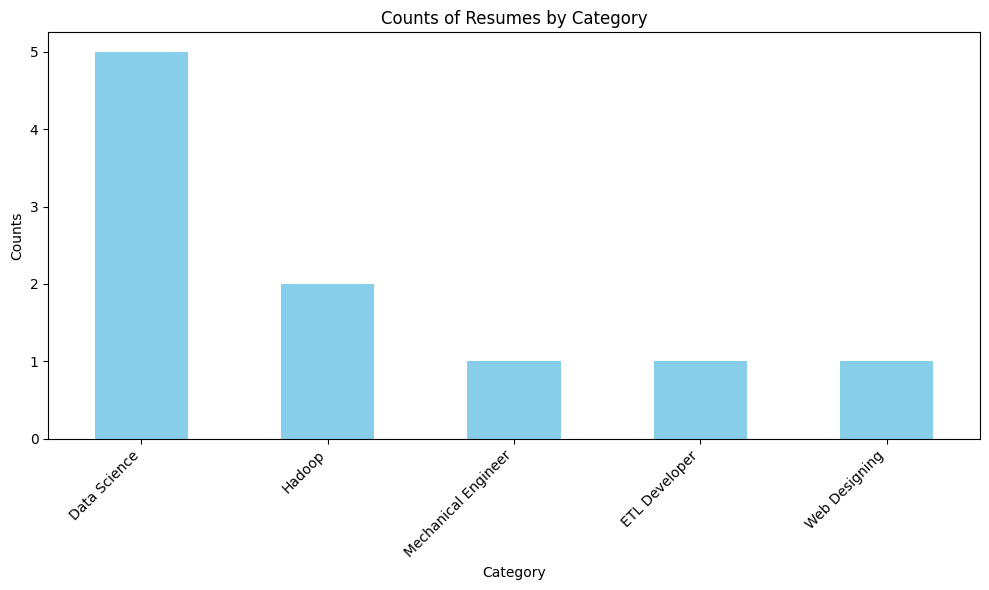

In [ ]:
# showcase the distribution of similar categories
category_counts = my_resume_tf_idf_most_similar_resumes['category'].value_counts()

# make a bar chart
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
category_counts.plot(kind='bar', color='skyblue')

# set the title and labels
plt.title('Counts of Resumes by Category')
plt.xlabel('Category')
plt.ylabel('Counts')

# rotate x labels for better readability if needed
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

My resume is for the job role of Product Manager (AI and Data). The job focuses on using AI and Data in the job to improve business opertaions and improve customer relationships and upsell opportunities, which was emphasised in the resume. Hence, it makes sense that the majority of the top 10 most similar resumes is in data science category. ETL developer makes sense as the resume does talk about knowing how to sift through and use data advantageously for insights. However, hadoop and web designing may not be as relevant

## Resume Similarity using Word2Vec

In [ ]:
# get the w2v document vector for my resume
def get_my_resume_w2v_vector(resume, resume_vectorizer_object):
    w2v_resume_vectors = []
    word2vec_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)
    tokens = resume.lower().split()
    vectors = []

    for token in tokens:
        if token in word2vec_model:
            vectors.append(word2vec_model[token])

    if vectors:
        w2v_resume_vectors.append(sum(vectors) / len(vectors))
    else:
        # Handle the case where all words are out-of-vocabulary
        w2v_resume_vectors.append([0] * 300)
    w2v_document_vector_df = pd.DataFrame(w2v_resume_vectors, index=['My Resume'])
    return w2v_document_vector_df

my_resume_w2v_vector = get_my_resume_w2v_vector(my_resume_text, resume_vectorizor)
my_resume_w2v_vector




,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
My Resume,-0.008947,0.020084,0.008825,0.062197,-0.05413,0.021215,0.039885,-0.069193,0.029237,0.013633,...,-0.06785,0.041891,-0.072088,0.040057,-0.021161,-0.022423,0.024432,-0.040705,-0.006532,0.02525


In [ ]:
# Calculate Cosine Similarity between my resume and all resumes
cosine_similarities_scores = []

i = 0 # used to iterate through the categories  variable to obtain the corresponding category information of the document tag
for resume_tag, resume_vector in w2v_resume_vectors_df.iterrows():
    similarity = calculate_cosine_similarity(np.array(resume_vector).reshape(1, -1), np.array(my_resume_w2v_vector).reshape(1, -1))
    category = resume_vectorizor.categories[i]
    resume = resume_vectorizor.resumes[i]
    cosine_similarities_scores.append([resume_tag, category, similarity, resume])
    i += 1

my_resume_w2v_similarity_df = pd.DataFrame(cosine_similarities_scores, columns=['resume_tag', 'category', 'similarity', 'resume'])

my_resume_w2v_most_similar_resumes = get_n_most_similar(10, my_resume_w2v_similarity_df)
my_resume_w2v_most_similar_resumes

,resume_tag,category,similarity,resume
2,Document 2,Data Science,0.894835,skill python sap hana tableau sap hana sql sap...
8,Document 8,Data Science,0.884474,expertise data quantitative analysis decision ...
152,Document 699,Database,0.881976,"technical skill sql oracle v10, v11, via progr..."
6,Document 6,Data Science,0.881449,education detail bbntgbqlmkktech maya para ins...
130,Document 588,DevOps Engineer,0.879029,"technical skill alm, rtc jira as400 (iseries) ..."
158,Document 725,Hadoop,0.875425,technical kill get programming language apache...
89,Document 395,Business Analyst,0.874430,key skill requirement gathering requirement an...
88,Document 394,Business Analyst,0.874184,technical skill application server ii 6bntgbql...
168,Document 768,ETL Developer,0.873582,technicalproficiencies db: oracle big domain i...
178,Document 830,Blockchain,0.872243,skill strong fundamental problem solving ether...


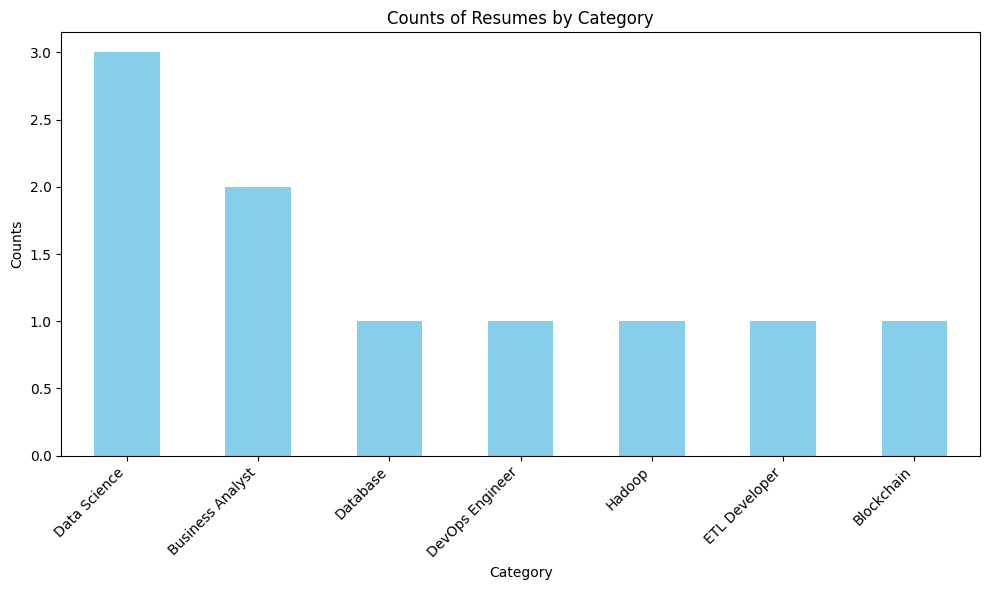

In [ ]:
# showcase the distribution of similar categories
category_counts = my_resume_w2v_most_similar_resumes['category'].value_counts()

# make a bar chart
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
category_counts.plot(kind='bar', color='skyblue')

# set the title and labels
plt.title('Counts of Resumes by Category')
plt.xlabel('Category')
plt.ylabel('Counts')

# rotate x labels for better readability if needed
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

Data science is the main category as my resume emphasised a lot on my experience in getting advantageous data insights.

DevOps Engineer is also valid because the resume did emphasise on abilities such as cloud and managed service providers which devops engineer usually have experience in.

Web Designing is anomalous as the resume did not emphasise on my ability to design website. This is not valid

Java developer is not very accurate as eventhough i had experience in programming, which was emphasised in the resume, I did not emphasise any ability to program java. This could be the result of just having a highly skewed dataset towards java devs

ETL Developer is valid as i did emphasise on extracting information and insights from data in the resume.

## Resume Similarity using Bert Embeddings

In [ ]:
# get the bert resume vector for my resume
def get_my_resume_bert_vector(resume, resume_vectorizer_object):
    my_resume = [resume]

    bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

    # Tokenize and obtain input IDs for the sentences
    inputs = bert_tokenizer(my_resume, return_tensors="pt", padding=True, truncation=True)
    tokenized_sentence_ids = inputs["input_ids"]

    # Use the BERT model to obtain embeddings
    bert_model = BertModel.from_pretrained('bert-base-uncased')

    with torch.no_grad():
        outputs = bert_model(**inputs)

    # Get the embeddings from the last hidden layer
    last_hidden_state = outputs.last_hidden_state
    resume_vectors = torch.mean(last_hidden_state, dim=1)
    bert_document_vector_df = pd.DataFrame(resume_vectors, index=['My Resume'])
    return bert_document_vector_df

my_resume_bert_vector = get_my_resume_bert_vector(my_resume_text, resume_vectorizor)
my_resume_bert_vector




,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
My Resume,-0.13721,0.277003,0.43285,-0.082165,0.667725,-0.093854,0.185473,0.335892,-0.172753,-0.388005,...,-0.186621,0.043721,0.209761,-0.295223,0.041073,-0.313661,-0.222223,-0.179762,-0.121265,-0.200716


In [ ]:
# Calculate Cosine Similarity between my resume and all resumes
cosine_similarities_scores = []

i = 0 # used to iterate through the categories  variable to obtain the corresponding category information of the document tag
for resume_tag, resume_vector in bert_resume_vectors_df.iterrows():
    similarity = calculate_cosine_similarity(np.array(resume_vector).reshape(1, -1), np.array(my_resume_bert_vector).reshape(1, -1))
    category = resume_vectorizor.categories[i]
    resume = resume_vectorizor.resumes[i]
    cosine_similarities_scores.append([resume_tag, category, similarity, resume])
    i += 1

my_resume_bert_similarity_df = pd.DataFrame(cosine_similarities_scores, columns=['resume_tag', 'category', 'similarity', 'resume'])

my_resume_bert_most_similar_resumes = get_n_most_similar(10, my_resume_bert_similarity_df)
my_resume_bert_most_similar_resumes

,resume_tag,category,similarity,resume
45,Document 139,Web Designing,0.876968,"skill language (basic), java (basic) web techn..."
6,Document 6,Data Science,0.871144,education detail bbntgbqlmkktech maya para ins...
107,Document 455,Automation Testing,0.869507,excellent grasping power learning new concept ...
178,Document 830,Blockchain,0.864927,skill strong fundamental problem solving ether...
127,Document 585,DevOps Engineer,0.862021,technical skill key skill technology bntgbqlmk...
82,Document 320,Java Developer,0.860908,technical skill programming language java (ser...
43,Document 137,Web Designing,0.859637,education detail bbntgbqlmkkcckekjofvwqa bache...
182,Document 837,Blockchain,0.855121,"skill bitcoin, ethereum solidity hyperledger, ..."
98,Document 424,SAP Developer,0.853625,education detail sap technical architect sap t...
89,Document 395,Business Analyst,0.852954,key skill requirement gathering requirement an...


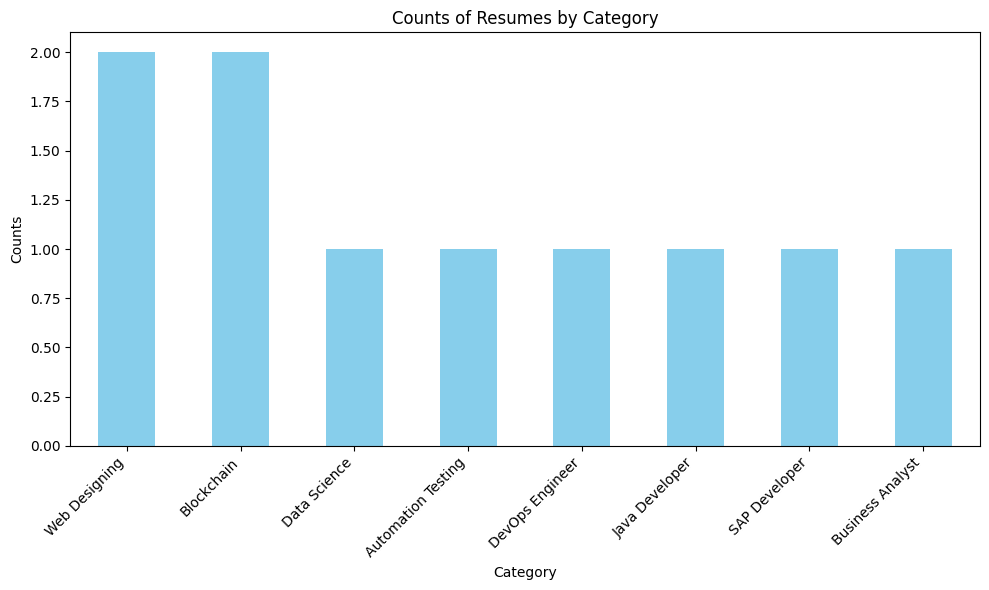

In [ ]:
# showcase the distribution of similar categories
category_counts = my_resume_bert_most_similar_resumes['category'].value_counts()

# make a bar chart
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
category_counts.plot(kind='bar', color='skyblue')

# set the title and labels
plt.title('Counts of Resumes by Category')
plt.xlabel('Category')
plt.ylabel('Counts')

# rotate x labels for better readability if needed
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

# 8. Text Summarization

In [ ]:
def get_important_details(resume):
    words = word_tokenize(resume)
    tags = pos_tag(words)
    ner_tags = nltk.ne_chunk(tags)
    ner_categories = set()

    for chunk in ner_tags:
        if isinstance(chunk, nltk.Tree):
            ner_label = chunk.label()
            token = " ".join(word for word, tag in chunk.leaves())
            ner_categories.add(ner_label)

    # Define the chunk grammar and attempt to get NP and VP in order to capture the tasks the person has done,
    # such as "I enhanced the performance of the company".
    # It is also to capture specific subjects from noun phrases, which may be exceptional such as a robust AI model, or a skilled analyst
    chunk_grammar = r"""
        NP: {<DT>?<JJ>*<NN>}
        VP: {<VB.*><.*>*<RB>?}
    """
    # Create a chunk parser
    chunk_parser = nltk.RegexpParser(chunk_grammar)

    # Chunking
    tree = chunk_parser.parse(tags)

    # Initialize an empty list to store phrases
    phrases = []

    # Iterate through subtrees and append phrases to the list
    for subtree in tree.subtrees():
        if subtree.label() in ['NP']:
            phrases.append(subtree)

    cohere_string_appendage = f"These are some key named entities, you should consider in your text summarisation to identify unique educational institutes, companies or locations: {ner_categories}\nThese are some key phrases you should consider in order to understand what the person did, and what were his key abilities: {phrases}"
    return cohere_string_appendage

# Read my own resume by defining a function to read the pdf file
def extract_text_from_pdf(pdf_path):
    with pdfplumber.open(pdf_path) as pdf:
        text = ''
        for page in pdf.pages:
            text += page.extract_text()
    return text

pdf_path = '222142U_Gawain_Resume.pdf'

my_resume_text = extract_text_from_pdf(pdf_path)

In [ ]:
# initialise the prompt with one shot learning and prepare it to receive Named entities and Verb phrases and noun phrases
co = cohere.Client('ik52RHHMaq7EpXT2GPUOiRMXKS71oRdhhzenzrZ7')

prompt = f"You are tasked to summarize a given resume in order to identify key attributes of the potential employee to give the company a concise and unbiased overview of the key attributes of a potential employee.\nYou will be provided a resume text, as well as named entities and phrases as input. The named entities and phrases provided are potentially important information that should be included in the summary. You are to analyze the resume text to identify information such as education, skills, langauges, achievements, work experience and objectives. You are to then condense the information into a clear and concise summary for the company to read and have an overview of the potential of the person as an employee of the company. The output will be the summarized version of the resume\nFor example, a small portion of the resume may contain information such as: Contributed to the development of Large Language Models in AI Singapore, which increased performance by 50%. The sample output should include information such as: He has substantially improved performance by 50% in AI Singapore with his contributions in enterprise-level AI initiatives in AI Singapore. Take note that experiences may include modules or courses, and not necessarily positions at companies"

response = co.chat(
    prompt,
    model="command",
    temperature=0.9
)
answer = response.text
answer

"I understand the task and requirements well. I'll make sure to evaluate the provided resume and create a clear and concise summary of the potential employee's key attributes for the company based on the given information. I will identify and emphasize the important details that should be included in the summary. \n\nPlease provide the resume document, along with any specific formatting or instructions, and let me know if there's anything else I can help you with!"

In [ ]:
# send information regarding my resume for resume summarization

important_details = get_important_details(my_resume_text)

message = f"{important_details}\n\n{my_resume_text}"

response = co.chat(
    message,
    model="command",
    temperature=0.9
)
answer = response.text
answer

'Gawain Yeo-Koh is a skillful and ambitious AI and Data Engineering enthusiast with a knack for pioneering cutting-edge solutions using AI models. With experience in Artificial Intelligence Engineering and Machine Learning, he is well-equipped to develop innovative applications that improve service experiences. His expertise in Data Preparation and Visualization enables him to analyze customer behavior and identify upsell opportunities, making him a valuable asset in the AI and Data field.\n\nIn 2023, Gawain Yeo-Koh joined the Engineering Product Lifecycle Management team, where he enhanced operational efficiency and identified upsell opportunities using Customer Relationship Management. He also explored AI tools such as Deepface, Keras, and YOLO in his Artificial Intelligence Engineering Project. Additionally, he developed machine learning models for quality assessment and analyzed customer behavior to learn preferences and enable pre-sales.\n\nWith a Diploma in AI & Data Engineering 